In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

# Case study: K2-24, putting it all together

In this tutorial, we will combine many of the previous tutorials to perform a fit of the K2-24 system using the K2 transit data and the RVs from [Petigura et al. (2016)](https://arxiv.org/abs/1511.04497).
This is the same system that we fit in the :ref:`rv` tutorial and we'll combine that model with the transit model from the :ref:`transit` tutorial and the Gaussian Process noise model from the :ref:`stellar-variability` tutorial.

## Datasets and initializations

To get started, let's download the relevant datasets.
First, the transit light curve from [Everest](https://rodluger.github.io/everest/):

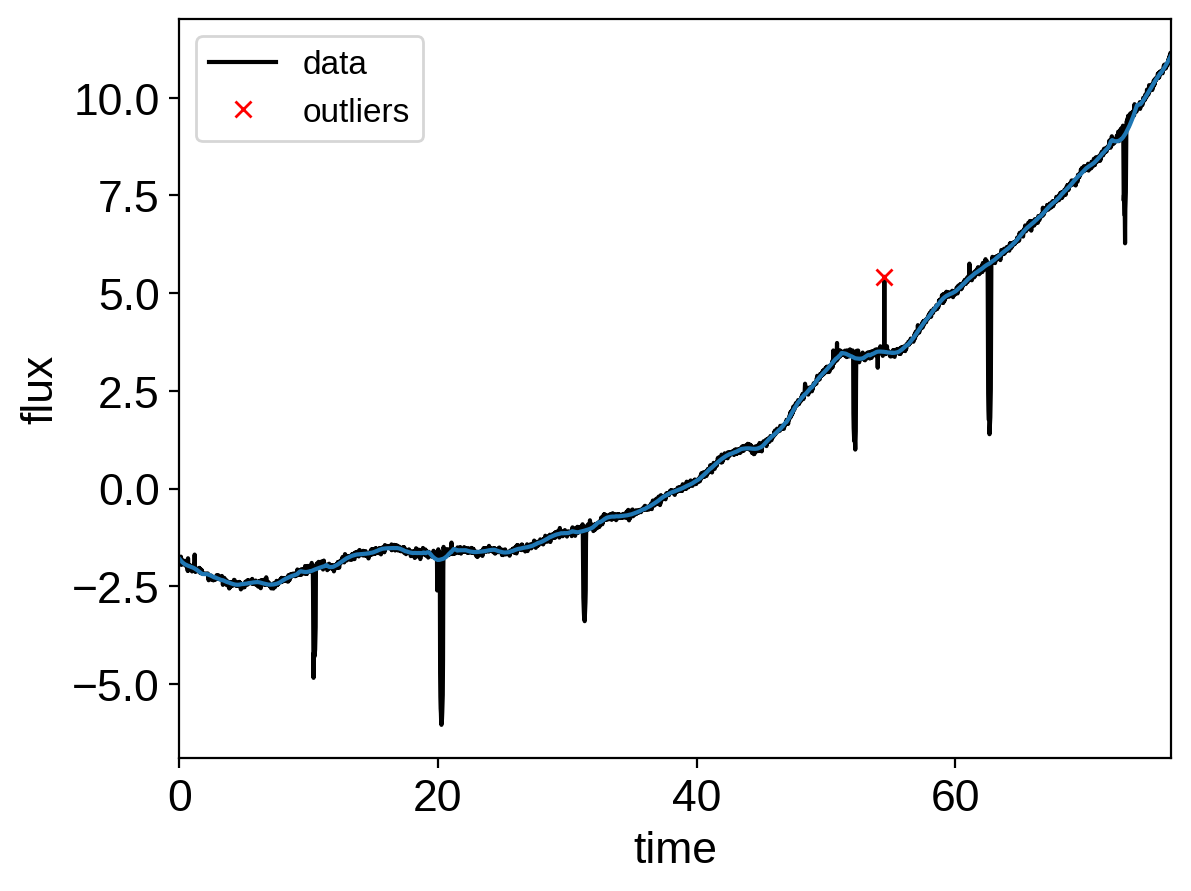

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from scipy.signal import savgol_filter

# Download the data
lc_url = "https://archive.stsci.edu/hlsps/everest/v2/c02/203700000/71098/hlsp_everest_k2_llc_203771098-c02_kepler_v2.0_lc.fits"
with fits.open(lc_url) as hdus:
    lc = hdus[1].data
    lc_hdr = hdus[1].header

# Work out the exposure time
texp = lc_hdr["FRAMETIM"] * lc_hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

# Mask bad data
m = (np.arange(len(lc)) > 100) & np.isfinite(lc["FLUX"]) & np.isfinite(lc["TIME"])
bad_bits = [1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17]
qual = lc["QUALITY"]
for b in bad_bits:
    m &= qual & 2 ** (b - 1) == 0

# Convert to parts per thousand
x = lc["TIME"][m]
y = lc["FLUX"][m]
mu = np.median(y)
y = (y / mu - 1) * 1e3

# Identify outliers
m = np.ones(len(y), dtype=bool)
for i in range(10):
    y_prime = np.interp(x, x[m], y[m])
    smooth = savgol_filter(y_prime, 101, polyorder=3)
    resid = y - smooth
    sigma = np.sqrt(np.mean(resid ** 2))
    m0 = np.abs(resid) < 3 * sigma
    if m.sum() == m0.sum():
        m = m0
        break
    m = m0

# Only discard positive outliers
m = resid < 3 * sigma

# Shift the data so that the K2 data start at t=0. This tends to make the fit
# better behaved since t0 covaries with period.
x_ref = np.min(x[m])
x -= x_ref

# Plot the data
plt.plot(x, y, "k", label="data")
plt.plot(x, smooth)
plt.plot(x[~m], y[~m], "xr", label="outliers")
plt.legend(fontsize=12)
plt.xlim(x.min(), x.max())
plt.xlabel("time")
plt.ylabel("flux")

# Make sure that the data type is consistent
x = np.ascontiguousarray(x[m], dtype=np.float64)
y = np.ascontiguousarray(y[m], dtype=np.float64)
smooth = np.ascontiguousarray(smooth[m], dtype=np.float64)

Then the RVs from [RadVel](https://radvel.readthedocs.io):

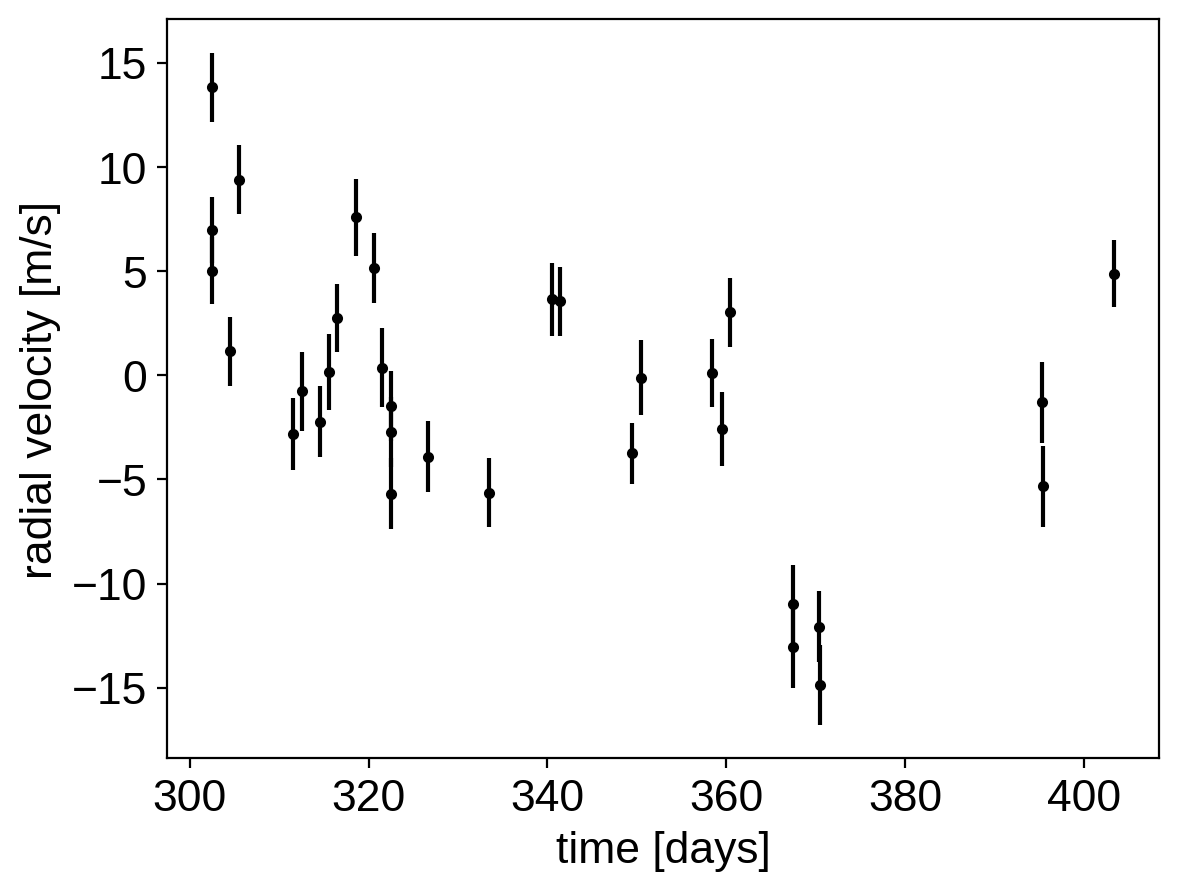

In [4]:
import pandas as pd

url = "https://raw.githubusercontent.com/California-Planet-Search/radvel/master/example_data/epic203771098.csv"
data = pd.read_csv(url, index_col=0)

# Don't forget to remove the time offset from above!
x_rv = np.array(data.t) - x_ref
y_rv = np.array(data.vel)
yerr_rv = np.array(data.errvel)

plt.errorbar(x_rv, y_rv, yerr=yerr_rv, fmt=".k")
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]");

We can initialize the transit parameters using [the box least squares periodogram from AstroPy](http://docs.astropy.org/en/latest/timeseries/bls.html).
(Note: you'll need AstroPy v3.1 or more recent to use this feature.)
A full discussion of transit detection and vetting is beyond the scope of this tutorial so let's assume that we know that there are two periodic transiting planets in this dataset.

In [5]:
from astropy.timeseries import BoxLeastSquares

m = np.zeros(len(x), dtype=bool)
period_grid = np.exp(np.linspace(np.log(5), np.log(50), 50000))
bls_results = []
periods = []
t0s = []
depths = []

# Compute the periodogram for each planet by iteratively masking out
# transits from the higher signal to noise planets. Here we're assuming
# that we know that there are exactly two planets.
for i in range(2):
    bls = BoxLeastSquares(x[~m], y[~m] - smooth[~m])
    bls_power = bls.power(period_grid, 0.1, oversample=20)
    bls_results.append(bls_power)

    # Save the highest peak as the planet candidate
    index = np.argmax(bls_power.power)
    periods.append(bls_power.period[index])
    t0s.append(bls_power.transit_time[index])
    depths.append(bls_power.depth[index])

    # Mask the data points that are in transit for this candidate
    m |= bls.transit_mask(x, periods[-1], 0.5, t0s[-1])

Let's plot the initial transit estimates based on these periodograms:

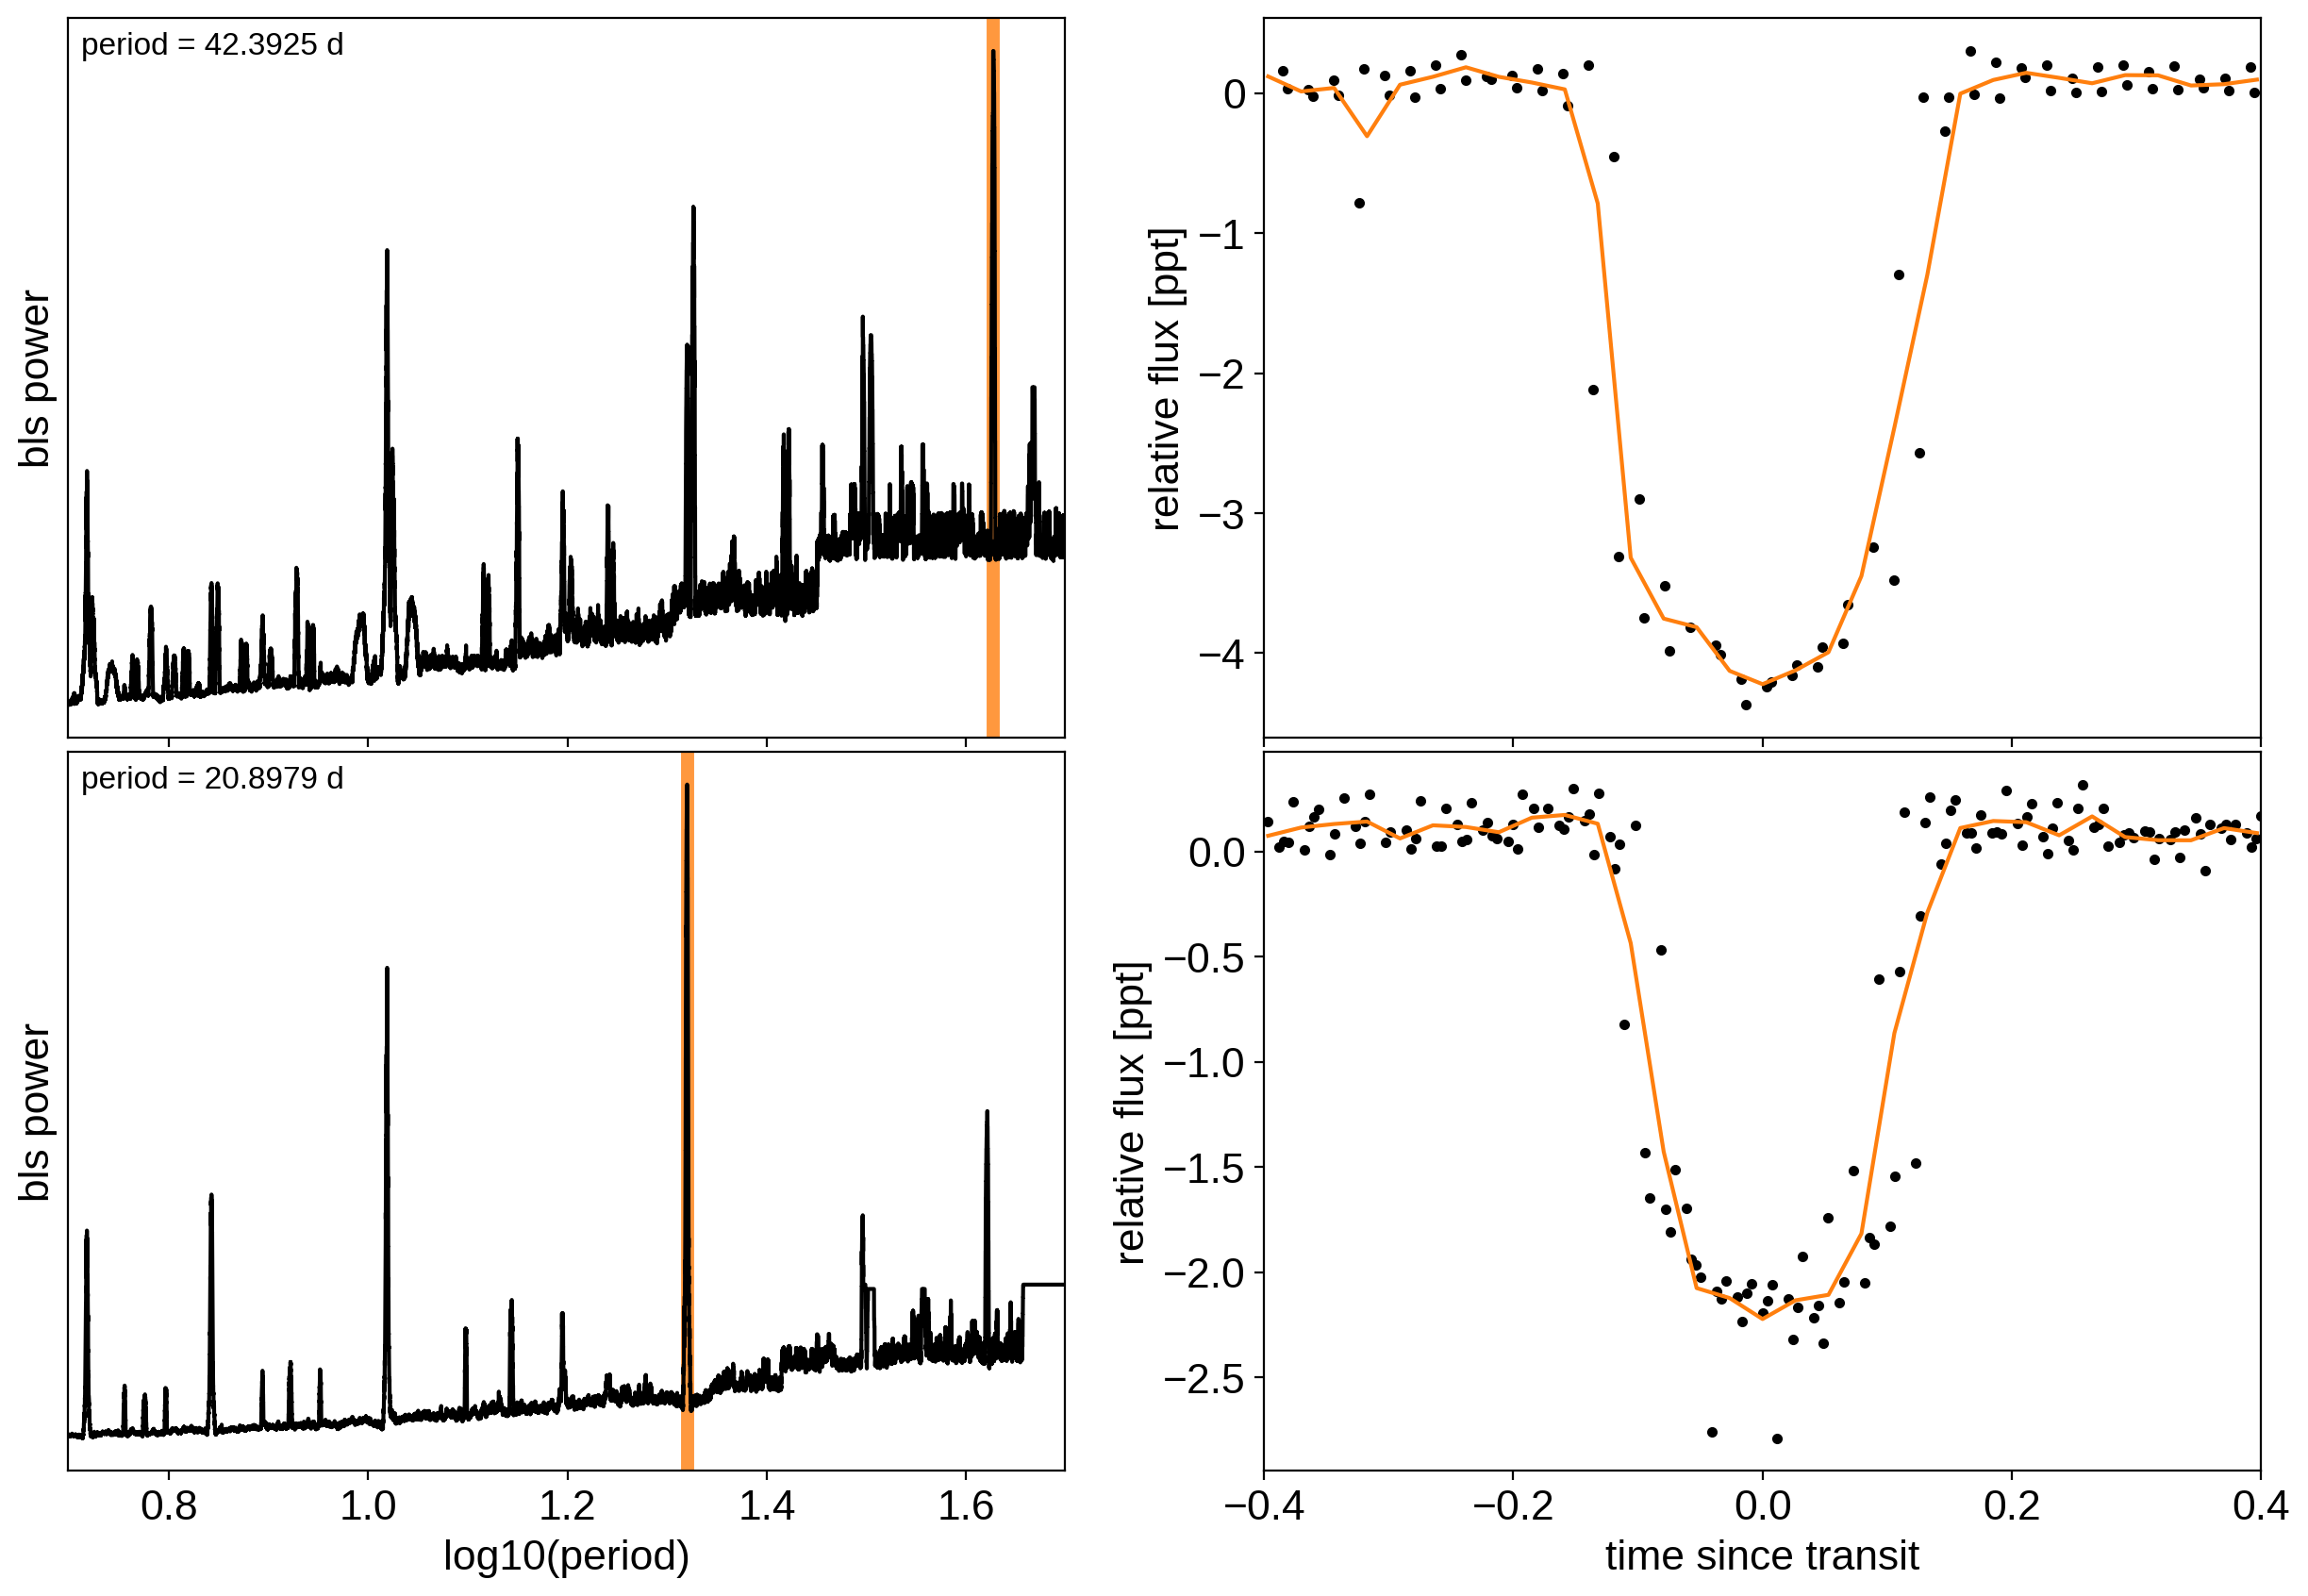

In [6]:
fig, axes = plt.subplots(len(bls_results), 2, figsize=(15, 10))

for i in range(len(bls_results)):
    # Plot the periodogram
    ax = axes[i, 0]
    ax.axvline(np.log10(periods[i]), color="C1", lw=5, alpha=0.8)
    ax.plot(np.log10(bls_results[i].period), bls_results[i].power, "k")
    ax.annotate(
        "period = {0:.4f} d".format(periods[i]),
        (0, 1),
        xycoords="axes fraction",
        xytext=(5, -5),
        textcoords="offset points",
        va="top",
        ha="left",
        fontsize=12,
    )
    ax.set_ylabel("bls power")
    ax.set_yticks([])
    ax.set_xlim(np.log10(period_grid.min()), np.log10(period_grid.max()))
    if i < len(bls_results) - 1:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("log10(period)")

    # Plot the folded transit
    ax = axes[i, 1]
    p = periods[i]
    x_fold = (x - t0s[i] + 0.5 * p) % p - 0.5 * p
    m = np.abs(x_fold) < 0.4
    ax.plot(x_fold[m], y[m] - smooth[m], ".k")

    # Overplot the phase binned light curve
    bins = np.linspace(-0.41, 0.41, 32)
    denom, _ = np.histogram(x_fold, bins)
    num, _ = np.histogram(x_fold, bins, weights=y - smooth)
    denom[num == 0] = 1.0
    ax.plot(0.5 * (bins[1:] + bins[:-1]), num / denom, color="C1")

    ax.set_xlim(-0.4, 0.4)
    ax.set_ylabel("relative flux [ppt]")
    if i < len(bls_results) - 1:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("time since transit")

fig.subplots_adjust(hspace=0.02)

The discovery paper for K2-24 ([Petigura et al. (2016)](https://arxiv.org/abs/1511.04497)) includes the following estimates of the stellar mass and radius in Solar units:

In [7]:
M_star_petigura = 1.12, 0.05
R_star_petigura = 1.21, 0.11

Finally, using this stellar mass, we can also estimate the minimum masses of the planets given these transit parameters.

In [8]:
import exoplanet as xo
import astropy.units as u

msini = xo.estimate_minimum_mass(
    periods, x_rv, y_rv, yerr_rv, t0s=t0s, m_star=M_star_petigura[0]
)
msini = msini.to(u.M_earth)
print(msini)

[32.80060146 23.89885976] earthMass


## A joint transit and radial velocity model in PyMC3

Now, let's define our full model in *PyMC3*.
There's a lot going on here, but I've tried to comment it and most of it should be familiar from the previous tutorials (:ref:`rv`, :ref:`transit`, :ref:`gp`, and :ref:`stellar-variability`).
In this case, I've put the model inside a model "factory" function because we'll do some sigma clipping below.

In [9]:
import pymc3 as pm
import theano.tensor as tt

t_rv = np.linspace(x_rv.min() - 5, x_rv.max() + 5, 1000)


def build_model(mask=None, start=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    with pm.Model() as model:

        # Parameters for the stellar properties
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        u_star = xo.QuadLimbDark("u_star")
        BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=3)
        m_star = BoundedNormal("m_star", mu=M_star_petigura[0], sd=M_star_petigura[1])
        r_star = BoundedNormal("r_star", mu=R_star_petigura[0], sd=R_star_petigura[1])

        # Orbital parameters for the planets
        logm = pm.Normal("logm", mu=np.log(msini.value), sd=1, shape=2)
        logP = pm.Normal("logP", mu=np.log(periods), sd=1, shape=2)
        t0 = pm.Normal("t0", mu=np.array(t0s), sd=1, shape=2)
        logr = pm.Normal(
            "logr",
            mu=0.5 * np.log(1e-3 * np.array(depths)) + np.log(R_star_petigura[0]),
            sd=1.0,
            shape=2,
        )
        r_pl = pm.Deterministic("r_pl", tt.exp(logr))
        ror = pm.Deterministic("ror", r_pl / r_star)
        b = xo.ImpactParameter("b", ror=ror, shape=2)

        ecs = xo.UnitDisk("ecs", shape=(2, 2), testval=0.01 * np.ones((2, 2)))
        ecc = pm.Deterministic("ecc", tt.sum(ecs ** 2, axis=0))
        omega = pm.Deterministic("omega", tt.arctan2(ecs[1], ecs[0]))
        xo.eccentricity.vaneylen19("ecc_prior", multi=True, shape=2, observed=ecc)

        # RV jitter & a quadratic RV trend
        logs_rv = pm.Normal("logs_rv", mu=np.log(np.median(yerr_rv)), sd=5)
        trend = pm.Normal("trend", mu=0, sd=10.0 ** -np.arange(3)[::-1], shape=3)

        # Transit jitter & GP parameters
        logs2 = pm.Normal("logs2", mu=np.log(np.var(y[mask])), sd=10)
        logw0 = pm.Normal("logw0", mu=0.0, sd=10)
        logSw4 = pm.Normal("logSw4", mu=np.log(np.var(y[mask])), sd=10)

        # Tracking planet parameters
        period = pm.Deterministic("period", tt.exp(logP))
        m_pl = pm.Deterministic("m_pl", tt.exp(logm))

        # Orbit model
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star,
            m_star=m_star,
            period=period,
            t0=t0,
            b=b,
            m_planet=xo.units.with_unit(m_pl, msini.unit),
            ecc=ecc,
            omega=omega,
        )

        # Compute the model light curve using starry
        def mean_model(t):
            light_curves = pm.Deterministic(
                "light_curves",
                xo.LimbDarkLightCurve(u_star).get_light_curve(
                    orbit=orbit, r=r_pl, t=t, texp=texp
                )
                * 1e3,
            )
            return pm.math.sum(light_curves, axis=-1) + mean

        # GP model for the light curve
        kernel = xo.gp.terms.SHOTerm(log_Sw4=logSw4, log_w0=logw0, Q=1 / np.sqrt(2))
        gp = xo.gp.GP(
            kernel, x[mask], tt.exp(logs2) + tt.zeros(mask.sum()), mean=mean_model
        )
        gp.marginal("transit_obs", observed=y[mask])
        pm.Deterministic("gp_pred", gp.predict())

        # And then include the RVs as in the RV tutorial
        x_rv_ref = 0.5 * (x_rv.min() + x_rv.max())

        def get_rv_model(t, name=""):
            # First the RVs induced by the planets
            vrad = orbit.get_radial_velocity(t)
            pm.Deterministic("vrad" + name, vrad)

            # Define the background model
            A = np.vander(t - x_rv_ref, 3)
            bkg = pm.Deterministic("bkg" + name, tt.dot(A, trend))

            # Sum over planets and add the background to get the full model
            return pm.Deterministic("rv_model" + name, tt.sum(vrad, axis=-1) + bkg)

        # Define the model
        rv_model = get_rv_model(x_rv)
        get_rv_model(t_rv, name="_pred")

        # The likelihood for the RVs
        err = tt.sqrt(yerr_rv ** 2 + tt.exp(2 * logs_rv))
        pm.Normal("obs", mu=rv_model, sd=err, observed=y_rv)

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = xo.optimize(start=start, vars=[trend])
        map_soln = xo.optimize(start=map_soln, vars=[logs2])
        map_soln = xo.optimize(start=map_soln, vars=[logr, b])
        map_soln = xo.optimize(start=map_soln, vars=[logP, t0])
        map_soln = xo.optimize(start=map_soln, vars=[logs2, logSw4])
        map_soln = xo.optimize(start=map_soln, vars=[logw0])
        map_soln = xo.optimize(start=map_soln)

    return model, map_soln


model0, map_soln0 = build_model()

optimizing logp for variables: [trend]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-8.282570e+03]

1it [00:00, 136.35it/s, logp=-8.282570e+03]

2it [00:00, 198.32it/s, logp=-8.282570e+03]

3it [00:00, 226.79it/s, logp=-5.396766e+06]

4it [00:00, 251.13it/s, logp=-8.282310e+03]

5it [00:00, 268.86it/s, logp=-8.281807e+03]

6it [00:00, 286.21it/s, logp=-8.280230e+03]

7it [00:00, 297.69it/s, logp=-8.276461e+03]

8it [00:00, 308.01it/s, logp=-8.270940e+03]

9it [00:00, 314.78it/s, logp=-8.269538e+03]

10it [00:00, 323.47it/s, logp=-8.269538e+03]

11it [00:00, 329.15it/s, logp=-8.269538e+03]

12it [00:13,  1.13s/it, logp=-8.269538e+03] 


message: Optimization terminated successfully.
logp: -8282.57015224409 -> -8269.537627952766


optimizing logp for variables: [logs2]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-8.269538e+03]

1it [00:00, 104.17it/s, logp=-8.269538e+03]

2it [00:00, 122.63it/s, logp=-8.269538e+03]

3it [00:00, 129.10it/s, logp=-6.546399e+03]

4it [00:00, 140.49it/s, logp=-5.158326e+01]

5it [00:00, 148.08it/s, logp=-3.542397e+05]

6it [00:00, 158.35it/s, logp=1.191602e+02] 

7it [00:00, 165.75it/s, logp=1.770672e+03]

8it [00:00, 175.01it/s, logp=1.852615e+03]

9it [00:00, 183.31it/s, logp=1.995596e+03]

10it [00:00, 190.62it/s, logp=2.108774e+03]

11it [00:00, 199.46it/s, logp=2.117537e+03]

12it [00:00, 207.71it/s, logp=2.117857e+03]

13it [00:00, 214.24it/s, logp=2.117857e+03]

14it [00:00, 221.02it/s, logp=2.117857e+03]

15it [00:01,  9.46it/s, logp=2.117857e+03] 


message: Optimization terminated successfully.
logp: -8269.537627952766 -> 2117.8573435796625


optimizing logp for variables: [b, logr, r_star]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=2.117857e+03]

1it [00:00, 121.31it/s, logp=2.117857e+03]

2it [00:00, 177.98it/s, logp=2.117857e+03]

3it [00:00, 214.19it/s, logp=-3.329302e+04]

4it [00:00, 240.45it/s, logp=2.605150e+03] 

5it [00:00, 258.23it/s, logp=1.043564e+02]

6it [00:00, 264.61it/s, logp=2.613717e+03]

7it [00:00, 274.87it/s, logp=2.625068e+03]

8it [00:00, 284.65it/s, logp=2.632251e+03]

9it [00:00, 292.25it/s, logp=2.634707e+03]

10it [00:00, 299.08it/s, logp=2.638709e+03]

11it [00:00, 304.75it/s, logp=2.643221e+03]

12it [00:00, 309.82it/s, logp=2.644818e+03]

13it [00:00, 313.94it/s, logp=2.646322e+03]

14it [00:00, 317.81it/s, logp=2.648624e+03]

15it [00:00, 321.51it/s, logp=2.650278e+03]

16it [00:00, 324.23it/s, logp=2.652850e+03]

17it [00:00, 327.22it/s, logp=2.652902e+03]

18it [00:00, 330.66it/s, logp=2.654227e+03]

19it [00:00, 333.13it/s, logp=2.656489e+03]

20it [00:00, 335.19it/s, logp=2.659707e+03]

21it [00:00, 337.12it/s, logp=2.664800e+03]

22it [00:00, 339.03it/s, logp=2.672599e+03]

23it [00:00, 340.79it/s, logp=2.674744e+03]

24it [00:00, 342.97it/s, logp=2.677564e+03]

25it [00:00, 344.16it/s, logp=2.684600e+03]

26it [00:00, 345.56it/s, logp=2.692404e+03]

27it [00:00, 346.53it/s, logp=2.694286e+03]

28it [00:00, 347.80it/s, logp=2.696434e+03]

29it [00:00, 348.91it/s, logp=2.696793e+03]

30it [00:00, 349.93it/s, logp=2.696792e+03]

31it [00:00, 351.37it/s, logp=2.696815e+03]

32it [00:00, 352.27it/s, logp=2.696822e+03]

33it [00:00, 353.07it/s, logp=2.696822e+03]

34it [00:00, 353.80it/s, logp=2.696822e+03]

35it [00:00, 354.48it/s, logp=2.696822e+03]

36it [00:00, 355.13it/s, logp=2.696822e+03]

37it [00:00, 362.97it/s, logp=2.696822e+03]

37it [00:00, 362.97it/s, logp=2.696822e+03]

38it [00:01, 23.57it/s, logp=2.696822e+03] 


message: Optimization terminated successfully.
logp: 2117.8573435796625 -> 2696.8220532480464


optimizing logp for variables: [t0, logP]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=2.696822e+03]

1it [00:00, 115.67it/s, logp=2.696822e+03]

2it [00:00, 171.91it/s, logp=2.696822e+03]

3it [00:00, 199.54it/s, logp=-5.025110e+03]

4it [00:00, 222.62it/s, logp=-1.578971e+02]

5it [00:00, 243.42it/s, logp=-8.006002e+02]

6it [00:00, 259.00it/s, logp=-9.547575e+02]

7it [00:00, 270.80it/s, logp=-6.251277e+02]

8it [00:00, 280.58it/s, logp=9.127022e+02] 

9it [00:00, 289.10it/s, logp=2.893315e+03]

10it [00:00, 293.59it/s, logp=-5.152372e+01]

11it [00:00, 300.69it/s, logp=2.891616e+03] 

12it [00:00, 305.23it/s, logp=2.895660e+03]

13it [00:00, 309.98it/s, logp=2.900379e+03]

14it [00:00, 314.42it/s, logp=2.918882e+03]

15it [00:00, 318.52it/s, logp=2.986599e+03]

16it [00:00, 321.32it/s, logp=3.135572e+03]

17it [00:00, 324.06it/s, logp=3.218986e+03]

18it [00:00, 326.57it/s, logp=3.247635e+03]

19it [00:00, 328.24it/s, logp=3.251831e+03]

20it [00:00, 329.36it/s, logp=3.251921e+03]

21it [00:00, 331.54it/s, logp=3.251922e+03]

22it [00:00, 333.35it/s, logp=3.251922e+03]

23it [00:00, 334.99it/s, logp=3.251922e+03]

24it [00:00, 336.26it/s, logp=3.251922e+03]

25it [00:00, 338.30it/s, logp=3.251922e+03]

26it [00:00, 340.13it/s, logp=3.251922e+03]

27it [00:00, 341.72it/s, logp=3.251922e+03]

28it [00:00, 343.28it/s, logp=3.251922e+03]

29it [00:00, 344.54it/s, logp=3.251922e+03]

30it [00:00, 346.00it/s, logp=3.251922e+03]

31it [00:00, 347.38it/s, logp=3.251922e+03]

32it [00:00, 348.18it/s, logp=3.251922e+03]

33it [00:00, 349.52it/s, logp=3.251922e+03]

34it [00:00, 350.68it/s, logp=3.251922e+03]

35it [00:00, 351.74it/s, logp=3.251922e+03]

36it [00:00, 359.81it/s, logp=3.251922e+03]

36it [00:00, 359.81it/s, logp=3.251922e+03]

37it [00:00, 359.81it/s, logp=3.251922e+03]

38it [00:00, 359.81it/s, logp=3.251922e+03]

39it [00:00, 359.81it/s, logp=3.251922e+03]

40it [00:00, 359.81it/s, logp=3.251922e+03]

41it [00:00, 359.81it/s, logp=3.251922e+03]

42it [00:00, 359.81it/s, logp=3.251922e+03]

43it [00:00, 359.81it/s, logp=3.251922e+03]

44it [00:00, 359.81it/s, logp=3.251922e+03]

45it [00:00, 359.81it/s, logp=3.251922e+03]

46it [00:00, 359.81it/s, logp=3.251922e+03]

47it [00:00, 359.81it/s, logp=3.251922e+03]

48it [00:00, 359.81it/s, logp=3.251922e+03]

49it [00:00, 359.81it/s, logp=3.251922e+03]

50it [00:00, 359.81it/s, logp=3.251922e+03]

51it [00:00, 359.81it/s, logp=3.251922e+03]

52it [00:00, 359.81it/s, logp=3.251922e+03]

53it [00:00, 359.81it/s, logp=3.251922e+03]

54it [00:00, 359.81it/s, logp=3.251922e+03]

55it [00:00, 359.81it/s, logp=3.251922e+03]

56it [00:00, 359.81it/s, logp=3.251922e+03]

57it [00:00, 359.81it/s, logp=3.251922e+03]

58it [00:00, 359.81it/s, logp=3.251922e+03]

59it [00:00, 359.81it/s, logp=3.251922e+03]

60it [00:00, 359.81it/s, logp=3.251922e+03]

61it [00:00, 359.81it/s, logp=3.251922e+03]

62it [00:00, 359.81it/s, logp=3.251922e+03]

63it [00:00, 359.81it/s, logp=3.251922e+03]

64it [00:00, 359.81it/s, logp=3.251922e+03]

65it [00:00, 359.81it/s, logp=3.251922e+03]

66it [00:00, 359.81it/s, logp=3.251922e+03]

67it [00:00, 359.81it/s, logp=3.251922e+03]

68it [00:00, 359.81it/s, logp=3.251922e+03]

69it [00:00, 359.81it/s, logp=3.251922e+03]

70it [00:00, 359.81it/s, logp=3.251922e+03]

71it [00:00, 359.81it/s, logp=3.251922e+03]

72it [00:00, 359.81it/s, logp=3.251922e+03]

73it [00:00, 359.81it/s, logp=3.251922e+03]

74it [00:00, 359.81it/s, logp=3.251922e+03]

75it [00:00, 367.45it/s, logp=3.251922e+03]

75it [00:00, 367.45it/s, logp=3.251922e+03]

76it [00:00, 367.45it/s, logp=3.251922e+03]

77it [00:00, 367.45it/s, logp=3.251922e+03]

78it [00:00, 367.45it/s, logp=3.251922e+03]

79it [00:00, 367.45it/s, logp=3.251922e+03]

80it [00:00, 367.45it/s, logp=3.251922e+03]

81it [00:00, 367.45it/s, logp=3.251922e+03]

82it [00:00, 367.45it/s, logp=3.251922e+03]

83it [00:00, 367.45it/s, logp=3.251922e+03]

84it [00:00, 367.45it/s, logp=3.251922e+03]

85it [00:00, 367.45it/s, logp=3.251922e+03]

86it [00:00, 367.45it/s, logp=3.251922e+03]

87it [00:00, 367.45it/s, logp=3.251922e+03]

88it [00:00, 367.45it/s, logp=3.251922e+03]

89it [00:00, 367.45it/s, logp=3.251922e+03]

90it [00:00, 367.45it/s, logp=3.251922e+03]

91it [00:00, 367.45it/s, logp=3.251922e+03]

92it [00:00, 367.45it/s, logp=3.251922e+03]

93it [00:00, 367.45it/s, logp=3.251922e+03]

94it [00:00, 367.45it/s, logp=3.251922e+03]

95it [00:00, 367.45it/s, logp=3.251922e+03]

96it [00:00, 367.45it/s, logp=3.251922e+03]

97it [00:00, 367.45it/s, logp=3.251922e+03]

98it [00:00, 367.45it/s, logp=3.251922e+03]

99it [00:00, 367.45it/s, logp=3.251922e+03]

100it [00:00, 367.45it/s, logp=3.251922e+03]

101it [00:00, 367.45it/s, logp=3.251922e+03]

102it [00:00, 367.45it/s, logp=3.251922e+03]

103it [00:00, 367.45it/s, logp=3.251922e+03]

104it [00:00, 367.45it/s, logp=3.251922e+03]

105it [00:00, 367.45it/s, logp=3.251922e+03]

106it [00:00, 367.45it/s, logp=3.251922e+03]

107it [00:00, 367.45it/s, logp=3.251922e+03]

108it [00:00, 367.45it/s, logp=3.251922e+03]

109it [00:00, 367.45it/s, logp=3.251922e+03]

110it [00:00, 367.45it/s, logp=3.251922e+03]

111it [00:00, 367.45it/s, logp=3.251922e+03]

112it [00:00, 367.45it/s, logp=3.251922e+03]

113it [00:00, 367.45it/s, logp=3.251922e+03]

114it [00:00, 373.13it/s, logp=3.251922e+03]

114it [00:00, 373.13it/s, logp=3.251922e+03]

115it [00:00, 373.13it/s, logp=3.251922e+03]

116it [00:00, 373.13it/s, logp=3.251922e+03]

117it [00:00, 373.13it/s, logp=3.251922e+03]

118it [00:00, 373.13it/s, logp=3.251922e+03]

119it [00:00, 373.13it/s, logp=3.251922e+03]

120it [00:00, 373.13it/s, logp=3.251922e+03]

121it [00:00, 373.13it/s, logp=3.251922e+03]

122it [00:00, 373.13it/s, logp=3.251922e+03]

123it [00:00, 373.13it/s, logp=3.251922e+03]

124it [00:00, 373.13it/s, logp=3.251922e+03]

125it [00:00, 373.13it/s, logp=3.251922e+03]

126it [00:00, 373.13it/s, logp=3.251922e+03]

127it [00:00, 373.13it/s, logp=3.251922e+03]

128it [00:00, 373.13it/s, logp=3.251922e+03]

129it [00:00, 373.13it/s, logp=3.251922e+03]

130it [00:00, 373.13it/s, logp=3.251922e+03]

131it [00:00, 373.13it/s, logp=3.251922e+03]

132it [00:00, 373.13it/s, logp=3.251922e+03]

133it [00:00, 373.13it/s, logp=3.251922e+03]

134it [00:02, 65.33it/s, logp=3.251922e+03] 


message: Desired error not necessarily achieved due to precision loss.
logp: 2696.8220532480464 -> 3251.9220705309353


optimizing logp for variables: [logSw4, logs2]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=3.251922e+03]

1it [00:00, 68.81it/s, logp=3.251922e+03]

2it [00:00, 104.73it/s, logp=3.251922e+03]

3it [00:00, 125.79it/s, logp=3.750351e+03]

4it [00:00, 143.77it/s, logp=-4.142749e+03]

5it [00:00, 161.95it/s, logp=3.902669e+03] 

6it [00:00, 173.90it/s, logp=3.905053e+03]

7it [00:00, 185.11it/s, logp=3.906091e+03]

8it [00:00, 195.26it/s, logp=3.906092e+03]

9it [00:00, 202.77it/s, logp=3.906093e+03]

10it [00:00, 211.51it/s, logp=3.906093e+03]

11it [00:00, 218.97it/s, logp=3.906093e+03]

12it [00:00, 225.77it/s, logp=3.906093e+03]

13it [00:00, 232.46it/s, logp=3.906093e+03]

14it [00:00, 238.72it/s, logp=3.906093e+03]

15it [00:00, 244.30it/s, logp=3.906093e+03]

16it [00:00, 249.53it/s, logp=3.906093e+03]

17it [00:00, 253.75it/s, logp=3.906093e+03]

18it [00:00, 258.04it/s, logp=3.906093e+03]

19it [00:00, 261.93it/s, logp=3.906093e+03]

20it [00:00, 265.62it/s, logp=3.906093e+03]

21it [00:00, 269.16it/s, logp=3.906093e+03]

22it [00:00, 272.45it/s, logp=3.906093e+03]

23it [00:00, 275.53it/s, logp=3.906093e+03]

24it [00:00, 278.47it/s, logp=3.906093e+03]

25it [00:00, 281.20it/s, logp=3.906093e+03]

26it [00:00, 283.82it/s, logp=3.906093e+03]

27it [00:00, 286.35it/s, logp=3.906093e+03]

28it [00:00, 288.52it/s, logp=3.906093e+03]

29it [00:00, 290.85it/s, logp=3.906093e+03]

30it [00:00, 299.22it/s, logp=3.906093e+03]

30it [00:00, 299.22it/s, logp=3.906093e+03]

31it [00:00, 299.22it/s, logp=3.906093e+03]

32it [00:00, 299.22it/s, logp=3.906093e+03]

33it [00:00, 299.22it/s, logp=3.906093e+03]

34it [00:00, 299.22it/s, logp=3.906093e+03]

35it [00:00, 299.22it/s, logp=3.906093e+03]

36it [00:00, 299.22it/s, logp=3.906093e+03]

37it [00:00, 299.22it/s, logp=3.906093e+03]

38it [00:00, 299.22it/s, logp=3.906093e+03]

39it [00:00, 299.22it/s, logp=3.906093e+03]

40it [00:00, 299.22it/s, logp=3.906093e+03]

41it [00:00, 299.22it/s, logp=3.906093e+03]

42it [00:00, 299.22it/s, logp=3.906093e+03]

43it [00:00, 299.22it/s, logp=3.906093e+03]

44it [00:00, 299.22it/s, logp=3.906093e+03]

45it [00:00, 299.22it/s, logp=3.906093e+03]

46it [00:00, 299.22it/s, logp=3.906093e+03]

47it [00:00, 299.22it/s, logp=3.906093e+03]

48it [00:00, 299.22it/s, logp=3.906093e+03]

49it [00:00, 299.22it/s, logp=3.906093e+03]

50it [00:00, 299.22it/s, logp=3.906093e+03]

51it [00:00, 299.22it/s, logp=3.906093e+03]

52it [00:00, 299.22it/s, logp=3.906093e+03]

53it [00:00, 299.22it/s, logp=3.906093e+03]

54it [00:00, 299.22it/s, logp=3.906093e+03]

55it [00:00, 299.22it/s, logp=3.906093e+03]

56it [00:00, 299.22it/s, logp=3.906093e+03]

57it [00:00, 299.22it/s, logp=3.906093e+03]

58it [00:00, 299.22it/s, logp=3.906093e+03]

59it [00:00, 299.22it/s, logp=3.906093e+03]

60it [00:00, 299.22it/s, logp=3.906093e+03]

61it [00:00, 299.22it/s, logp=3.906093e+03]

62it [00:00, 299.22it/s, logp=3.906093e+03]

63it [00:00, 299.22it/s, logp=3.906093e+03]

64it [00:00, 299.22it/s, logp=3.906093e+03]

65it [00:00, 299.22it/s, logp=3.906093e+03]

66it [00:00, 313.43it/s, logp=3.906093e+03]

66it [00:00, 313.43it/s, logp=3.906093e+03]

67it [00:00, 313.43it/s, logp=3.906093e+03]

68it [00:00, 313.43it/s, logp=3.906093e+03]

69it [00:00, 313.43it/s, logp=3.906093e+03]

70it [00:00, 313.43it/s, logp=3.906093e+03]

71it [00:00, 313.43it/s, logp=3.906093e+03]

72it [00:00, 313.43it/s, logp=3.906093e+03]

73it [00:00, 313.43it/s, logp=3.906093e+03]

74it [00:00, 313.43it/s, logp=3.906093e+03]

75it [00:00, 313.43it/s, logp=3.906093e+03]

76it [00:00, 313.43it/s, logp=3.906093e+03]

77it [00:00, 313.43it/s, logp=3.906093e+03]

78it [00:00, 313.43it/s, logp=3.906093e+03]

79it [00:00, 313.43it/s, logp=3.906093e+03]

80it [00:00, 313.43it/s, logp=3.906093e+03]

81it [00:00, 313.43it/s, logp=3.906093e+03]

82it [00:00, 313.43it/s, logp=3.906093e+03]

83it [00:00, 313.43it/s, logp=3.906093e+03]

84it [00:00, 313.43it/s, logp=3.906093e+03]

85it [00:00, 313.43it/s, logp=3.906093e+03]

86it [00:00, 313.43it/s, logp=3.906093e+03]

87it [00:00, 313.43it/s, logp=3.906093e+03]

88it [00:00, 313.43it/s, logp=3.906093e+03]

89it [00:00, 313.43it/s, logp=3.906093e+03]

90it [00:00, 313.43it/s, logp=3.906093e+03]

91it [00:00, 313.43it/s, logp=3.906093e+03]

92it [00:00, 313.43it/s, logp=3.906093e+03]

93it [00:00, 313.43it/s, logp=3.906093e+03]

94it [00:00, 313.43it/s, logp=3.906093e+03]

95it [00:00, 313.43it/s, logp=3.906093e+03]

96it [00:00, 313.43it/s, logp=3.906093e+03]

97it [00:00, 313.43it/s, logp=3.906093e+03]

98it [00:00, 313.43it/s, logp=3.906093e+03]

99it [00:00, 313.43it/s, logp=3.906093e+03]

100it [00:00, 313.43it/s, logp=3.906093e+03]

101it [00:00, 313.43it/s, logp=3.906093e+03]

102it [00:00, 313.43it/s, logp=3.906093e+03]

103it [00:00, 327.68it/s, logp=3.906093e+03]

103it [00:00, 327.68it/s, logp=3.906093e+03]

104it [00:00, 327.68it/s, logp=3.906093e+03]

105it [00:00, 327.68it/s, logp=3.906093e+03]

106it [00:00, 327.68it/s, logp=3.906093e+03]

107it [00:00, 327.68it/s, logp=3.906093e+03]

108it [00:00, 327.68it/s, logp=3.906093e+03]

109it [00:00, 327.68it/s, logp=3.906093e+03]

110it [00:00, 327.68it/s, logp=3.906093e+03]

111it [00:00, 327.68it/s, logp=3.906093e+03]

112it [00:00, 327.68it/s, logp=3.906093e+03]

113it [00:00, 327.68it/s, logp=3.906093e+03]

114it [00:00, 327.68it/s, logp=3.906093e+03]

115it [00:00, 327.68it/s, logp=3.906093e+03]

116it [00:00, 327.68it/s, logp=3.906093e+03]

117it [00:00, 327.68it/s, logp=3.906093e+03]

118it [00:00, 327.68it/s, logp=3.906093e+03]

119it [00:00, 327.68it/s, logp=3.906093e+03]

120it [00:00, 327.68it/s, logp=3.906093e+03]

121it [00:00, 327.68it/s, logp=3.906093e+03]

122it [00:00, 327.68it/s, logp=3.906093e+03]

123it [00:00, 327.68it/s, logp=3.906093e+03]

124it [00:00, 327.68it/s, logp=3.906093e+03]

125it [00:00, 327.68it/s, logp=3.906093e+03]

126it [00:00, 327.68it/s, logp=3.906093e+03]

127it [00:00, 327.68it/s, logp=3.906093e+03]

128it [00:00, 327.68it/s, logp=3.906093e+03]

129it [00:00, 327.68it/s, logp=3.906093e+03]

130it [00:00, 327.68it/s, logp=3.906093e+03]

131it [00:02, 56.69it/s, logp=3.906093e+03] 


message: Desired error not necessarily achieved due to precision loss.
logp: 3251.922070530933 -> 3906.092568184921


optimizing logp for variables: [logw0]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=3.906093e+03]

1it [00:00, 142.40it/s, logp=3.906093e+03]

2it [00:00, 202.80it/s, logp=3.906093e+03]

3it [00:00, 233.53it/s, logp=4.009198e+03]

4it [00:00, 254.08it/s, logp=4.009404e+03]

5it [00:00, 267.33it/s, logp=4.010104e+03]

6it [00:00, 278.52it/s, logp=4.010129e+03]

7it [00:00, 286.67it/s, logp=4.010545e+03]

8it [00:00, 291.94it/s, logp=4.010571e+03]

9it [00:00, 296.71it/s, logp=4.010575e+03]

10it [00:00, 301.79it/s, logp=4.010575e+03]

11it [00:00, 305.80it/s, logp=4.010575e+03]

12it [00:01,  7.36it/s, logp=4.010575e+03] 


message: Optimization terminated successfully.
logp: 3906.092568184921 -> 4010.575080730371


optimizing logp for variables: [logSw4, logw0, logs2, trend, logs_rv, ecc_prior_frac, ecc_prior_sigma_rayleigh, ecc_prior_sigma_gauss, ecs, b, logr, t0, logP, logm, r_star, m_star, u_star, mean]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=4.010575e+03]

1it [00:00, 96.80it/s, logp=4.010575e+03]

2it [00:00, 141.47it/s, logp=4.010575e+03]

3it [00:00, 166.23it/s, logp=-5.648716e+03]

4it [00:00, 182.93it/s, logp=-8.077767e+03]

5it [00:00, 193.65it/s, logp=-1.148771e+04]

6it [00:00, 203.05it/s, logp=3.996128e+03] 

7it [00:00, 210.27it/s, logp=4.010674e+03]

8it [00:00, 214.69it/s, logp=4.006483e+03]

9it [00:00, 220.48it/s, logp=4.010677e+03]

10it [00:00, 223.18it/s, logp=4.010681e+03]

11it [00:00, 227.92it/s, logp=4.010701e+03]

12it [00:00, 231.75it/s, logp=4.010777e+03]

13it [00:00, 234.98it/s, logp=4.011078e+03]

14it [00:00, 237.32it/s, logp=4.012201e+03]

15it [00:00, 238.66it/s, logp=4.015035e+03]

16it [00:00, 239.33it/s, logp=4.020604e+03]

17it [00:00, 240.90it/s, logp=4.039674e+03]

18it [00:00, 242.07it/s, logp=4.059294e+03]

19it [00:00, 242.97it/s, logp=3.954586e+03]

20it [00:00, 243.96it/s, logp=4.061974e+03]

21it [00:00, 244.15it/s, logp=4.067140e+03]

22it [00:00, 245.64it/s, logp=4.082740e+03]

23it [00:00, 246.20it/s, logp=4.122560e+03]

24it [00:00, 246.64it/s, logp=4.196767e+03]

25it [00:00, 246.86it/s, logp=4.295353e+03]

26it [00:00, 255.52it/s, logp=4.295353e+03]

26it [00:00, 255.52it/s, logp=4.389364e+03]

27it [00:00, 255.52it/s, logp=3.946451e+03]

28it [00:00, 255.52it/s, logp=4.404683e+03]

29it [00:00, 255.52it/s, logp=4.424397e+03]

30it [00:00, 255.52it/s, logp=4.448485e+03]

31it [00:00, 255.52it/s, logp=4.469955e+03]

32it [00:00, 255.52it/s, logp=4.484363e+03]

33it [00:00, 255.52it/s, logp=4.506999e+03]

34it [00:00, 255.52it/s, logp=4.385908e+03]

35it [00:00, 255.52it/s, logp=4.512442e+03]

36it [00:00, 255.52it/s, logp=4.521653e+03]

37it [00:00, 255.52it/s, logp=4.538413e+03]

38it [00:00, 255.52it/s, logp=4.557672e+03]

39it [00:00, 255.52it/s, logp=4.579036e+03]

40it [00:00, 255.52it/s, logp=4.601594e+03]

41it [00:00, 255.52it/s, logp=4.604420e+03]

42it [00:00, 255.52it/s, logp=4.609730e+03]

43it [00:00, 255.52it/s, logp=4.618268e+03]

44it [00:00, 255.52it/s, logp=4.627015e+03]

45it [00:00, 255.52it/s, logp=4.638103e+03]

46it [00:00, 255.52it/s, logp=4.634427e+03]

47it [00:00, 255.52it/s, logp=4.641840e+03]

48it [00:00, 255.52it/s, logp=4.647894e+03]

49it [00:00, 255.52it/s, logp=4.657568e+03]

50it [00:00, 255.52it/s, logp=4.665155e+03]

51it [00:00, 255.52it/s, logp=4.675746e+03]

52it [00:00, 256.41it/s, logp=4.675746e+03]

52it [00:00, 256.41it/s, logp=4.680753e+03]

53it [00:00, 256.41it/s, logp=4.687043e+03]

54it [00:00, 256.41it/s, logp=4.693320e+03]

55it [00:00, 256.41it/s, logp=4.697477e+03]

56it [00:00, 256.41it/s, logp=4.703138e+03]

57it [00:00, 256.41it/s, logp=4.706266e+03]

58it [00:00, 256.41it/s, logp=4.709462e+03]

59it [00:00, 256.41it/s, logp=4.711735e+03]

60it [00:00, 256.41it/s, logp=4.713150e+03]

61it [00:00, 256.41it/s, logp=4.712489e+03]

62it [00:00, 256.41it/s, logp=4.713723e+03]

63it [00:00, 256.41it/s, logp=4.714329e+03]

64it [00:00, 256.41it/s, logp=4.714660e+03]

65it [00:00, 256.41it/s, logp=4.715059e+03]

66it [00:00, 256.41it/s, logp=4.715420e+03]

67it [00:00, 256.41it/s, logp=4.715831e+03]

68it [00:00, 256.41it/s, logp=4.716255e+03]

69it [00:00, 256.41it/s, logp=4.716816e+03]

70it [00:00, 256.41it/s, logp=4.717297e+03]

71it [00:00, 256.41it/s, logp=4.717773e+03]

72it [00:00, 256.41it/s, logp=4.718298e+03]

73it [00:00, 256.41it/s, logp=4.718673e+03]

74it [00:00, 256.41it/s, logp=4.718961e+03]

75it [00:00, 256.41it/s, logp=4.719254e+03]

76it [00:00, 256.41it/s, logp=4.719496e+03]

77it [00:00, 256.41it/s, logp=4.719679e+03]

78it [00:00, 256.41it/s, logp=4.719679e+03]

78it [00:00, 256.41it/s, logp=4.719762e+03]

79it [00:00, 256.41it/s, logp=4.719871e+03]

80it [00:00, 256.41it/s, logp=4.720053e+03]

81it [00:00, 256.41it/s, logp=4.720370e+03]

82it [00:00, 256.41it/s, logp=4.720913e+03]

83it [00:00, 256.41it/s, logp=4.720948e+03]

84it [00:00, 256.41it/s, logp=4.721212e+03]

85it [00:00, 256.41it/s, logp=4.721699e+03]

86it [00:00, 256.41it/s, logp=4.722278e+03]

87it [00:00, 256.41it/s, logp=4.723214e+03]

88it [00:00, 256.41it/s, logp=4.724894e+03]

89it [00:00, 256.41it/s, logp=4.727753e+03]

90it [00:00, 256.41it/s, logp=4.731058e+03]

91it [00:00, 256.41it/s, logp=4.731766e+03]

92it [00:00, 256.41it/s, logp=4.732773e+03]

93it [00:00, 256.41it/s, logp=4.734315e+03]

94it [00:00, 256.41it/s, logp=4.735246e+03]

95it [00:00, 256.41it/s, logp=4.735668e+03]

96it [00:00, 256.41it/s, logp=4.735918e+03]

97it [00:00, 256.41it/s, logp=4.736141e+03]

98it [00:00, 256.41it/s, logp=4.736236e+03]

99it [00:00, 256.41it/s, logp=4.736279e+03]

100it [00:00, 256.41it/s, logp=4.736293e+03]

101it [00:00, 256.41it/s, logp=4.736297e+03]

102it [00:00, 256.41it/s, logp=4.736304e+03]

103it [00:00, 256.41it/s, logp=4.736315e+03]

104it [00:00, 256.48it/s, logp=4.736315e+03]

104it [00:00, 256.48it/s, logp=4.736336e+03]

105it [00:00, 256.48it/s, logp=4.736369e+03]

106it [00:00, 256.48it/s, logp=4.736414e+03]

107it [00:00, 256.48it/s, logp=4.736445e+03]

108it [00:00, 256.48it/s, logp=4.736461e+03]

109it [00:00, 256.48it/s, logp=4.736472e+03]

110it [00:00, 256.48it/s, logp=4.736476e+03]

111it [00:00, 256.48it/s, logp=4.736479e+03]

112it [00:00, 256.48it/s, logp=4.736484e+03]

113it [00:00, 256.48it/s, logp=4.736491e+03]

114it [00:00, 256.48it/s, logp=4.736504e+03]

115it [00:00, 256.48it/s, logp=4.736524e+03]

116it [00:00, 256.48it/s, logp=4.736556e+03]

117it [00:00, 256.48it/s, logp=4.736591e+03]

118it [00:00, 256.48it/s, logp=4.736628e+03]

119it [00:00, 256.48it/s, logp=4.736663e+03]

120it [00:00, 256.48it/s, logp=4.736687e+03]

121it [00:00, 256.48it/s, logp=4.736719e+03]

122it [00:00, 256.48it/s, logp=4.736702e+03]

123it [00:00, 256.48it/s, logp=4.736727e+03]

124it [00:00, 256.48it/s, logp=4.736740e+03]

125it [00:00, 256.48it/s, logp=4.736749e+03]

126it [00:00, 256.48it/s, logp=4.736753e+03]

127it [00:00, 256.48it/s, logp=4.736756e+03]

128it [00:00, 256.48it/s, logp=4.736760e+03]

129it [00:00, 256.48it/s, logp=4.736764e+03]

130it [00:00, 257.23it/s, logp=4.736764e+03]

130it [00:00, 257.23it/s, logp=4.736769e+03]

131it [00:00, 257.23it/s, logp=4.736771e+03]

132it [00:00, 257.23it/s, logp=4.736774e+03]

133it [00:00, 257.23it/s, logp=4.736779e+03]

134it [00:00, 257.23it/s, logp=4.736786e+03]

135it [00:00, 257.23it/s, logp=4.736792e+03]

136it [00:00, 257.23it/s, logp=4.736792e+03]

137it [00:00, 257.23it/s, logp=4.736795e+03]

138it [00:00, 257.23it/s, logp=4.736799e+03]

139it [00:00, 257.23it/s, logp=4.736806e+03]

140it [00:00, 257.23it/s, logp=4.736819e+03]

141it [00:00, 257.23it/s, logp=4.736842e+03]

142it [00:00, 257.23it/s, logp=4.736864e+03]

143it [00:00, 257.23it/s, logp=4.736863e+03]

144it [00:00, 257.23it/s, logp=4.736841e+03]

145it [00:00, 257.23it/s, logp=4.736871e+03]

146it [00:00, 257.23it/s, logp=4.736886e+03]

147it [00:00, 257.23it/s, logp=4.736912e+03]

148it [00:00, 257.23it/s, logp=4.736954e+03]

149it [00:00, 257.23it/s, logp=4.736980e+03]

150it [00:00, 257.23it/s, logp=4.737015e+03]

151it [00:00, 257.23it/s, logp=4.737041e+03]

152it [00:00, 257.23it/s, logp=4.737074e+03]

153it [00:00, 257.23it/s, logp=4.737096e+03]

154it [00:00, 257.23it/s, logp=4.737102e+03]

155it [00:00, 257.23it/s, logp=4.737107e+03]

156it [00:00, 257.23it/s, logp=4.737113e+03]

157it [00:00, 258.04it/s, logp=4.737113e+03]

157it [00:00, 258.04it/s, logp=4.737110e+03]

158it [00:00, 258.04it/s, logp=4.737115e+03]

159it [00:00, 258.04it/s, logp=4.737118e+03]

160it [00:00, 258.04it/s, logp=4.737120e+03]

161it [00:00, 258.04it/s, logp=4.737121e+03]

162it [00:00, 258.04it/s, logp=4.737123e+03]

163it [00:00, 258.04it/s, logp=4.737125e+03]

164it [00:00, 258.04it/s, logp=4.737128e+03]

165it [00:00, 258.04it/s, logp=4.737132e+03]

166it [00:00, 258.04it/s, logp=4.737134e+03]

167it [00:00, 258.04it/s, logp=4.737135e+03]

168it [00:00, 258.04it/s, logp=4.737136e+03]

169it [00:00, 258.04it/s, logp=4.737136e+03]

170it [00:00, 258.04it/s, logp=4.737136e+03]

171it [00:00, 258.04it/s, logp=4.737136e+03]

172it [00:00, 258.04it/s, logp=4.737136e+03]

173it [00:00, 258.04it/s, logp=4.737137e+03]

174it [00:00, 258.04it/s, logp=4.737060e+03]

175it [00:00, 258.04it/s, logp=4.737138e+03]

176it [00:00, 258.04it/s, logp=4.736639e+03]

177it [00:00, 258.04it/s, logp=4.737137e+03]

178it [00:00, 258.04it/s, logp=4.737138e+03]

179it [00:00, 258.04it/s, logp=4.737138e+03]

180it [00:00, 258.04it/s, logp=4.737138e+03]

181it [00:00, 258.04it/s, logp=4.737140e+03]

182it [00:00, 258.04it/s, logp=4.737143e+03]

183it [00:00, 258.04it/s, logp=4.737148e+03]

184it [00:00, 260.91it/s, logp=4.737148e+03]

184it [00:00, 260.91it/s, logp=4.737158e+03]

185it [00:00, 260.91it/s, logp=4.737175e+03]

186it [00:00, 260.91it/s, logp=4.737194e+03]

187it [00:00, 260.91it/s, logp=4.737162e+03]

188it [00:00, 260.91it/s, logp=4.737197e+03]

189it [00:00, 260.91it/s, logp=4.737198e+03]

190it [00:00, 260.91it/s, logp=4.737198e+03]

191it [00:00, 260.91it/s, logp=4.737198e+03]

192it [00:00, 260.91it/s, logp=4.737198e+03]

193it [00:00, 260.91it/s, logp=4.737198e+03]

194it [00:00, 260.91it/s, logp=4.737198e+03]

195it [00:00, 260.91it/s, logp=4.737198e+03]

196it [00:00, 260.91it/s, logp=4.737198e+03]

197it [00:00, 260.91it/s, logp=4.737198e+03]

198it [00:00, 260.91it/s, logp=4.737198e+03]

199it [00:00, 260.91it/s, logp=4.737198e+03]

200it [00:00, 260.91it/s, logp=4.737198e+03]

201it [00:00, 260.91it/s, logp=4.737198e+03]

202it [00:00, 260.91it/s, logp=4.737198e+03]

203it [00:00, 260.91it/s, logp=4.737198e+03]

204it [00:00, 260.91it/s, logp=4.737199e+03]

205it [00:00, 260.91it/s, logp=4.737199e+03]

206it [00:00, 260.91it/s, logp=4.737199e+03]

207it [00:00, 260.91it/s, logp=4.737199e+03]

208it [00:00, 260.91it/s, logp=4.737199e+03]

209it [00:00, 260.91it/s, logp=4.737199e+03]

210it [00:00, 260.91it/s, logp=4.737199e+03]

211it [00:00, 261.49it/s, logp=4.737199e+03]

211it [00:00, 261.49it/s, logp=4.737199e+03]

212it [00:00, 261.49it/s, logp=4.737199e+03]

213it [00:00, 261.49it/s, logp=4.737199e+03]

214it [00:00, 261.49it/s, logp=4.737199e+03]

215it [00:00, 261.49it/s, logp=4.737199e+03]

216it [00:00, 261.49it/s, logp=4.737199e+03]

217it [00:00, 261.49it/s, logp=4.737199e+03]

218it [00:00, 261.49it/s, logp=4.737199e+03]

219it [00:00, 261.49it/s, logp=4.737199e+03]

220it [00:00, 261.49it/s, logp=4.737199e+03]

221it [00:00, 261.49it/s, logp=4.737199e+03]

222it [00:00, 261.49it/s, logp=4.737199e+03]

223it [00:00, 261.49it/s, logp=4.737199e+03]

224it [00:00, 261.49it/s, logp=4.737199e+03]

225it [00:00, 261.49it/s, logp=4.737199e+03]

226it [00:00, 261.49it/s, logp=4.737199e+03]

227it [00:00, 261.49it/s, logp=4.737199e+03]

228it [00:00, 261.49it/s, logp=4.737199e+03]

229it [00:00, 261.49it/s, logp=4.737199e+03]

230it [00:00, 261.49it/s, logp=4.737199e+03]

231it [00:00, 261.49it/s, logp=4.737199e+03]

232it [00:00, 261.49it/s, logp=4.737199e+03]

233it [00:00, 261.49it/s, logp=4.737199e+03]

234it [00:00, 261.49it/s, logp=4.737199e+03]

235it [00:00, 261.49it/s, logp=4.737199e+03]

236it [00:00, 261.49it/s, logp=4.737199e+03]

237it [00:00, 261.49it/s, logp=4.737199e+03]

238it [00:00, 261.49it/s, logp=4.737199e+03]

239it [00:00, 265.70it/s, logp=4.737199e+03]

239it [00:00, 265.70it/s, logp=4.737199e+03]

240it [00:00, 265.70it/s, logp=4.737199e+03]

241it [00:00, 265.70it/s, logp=4.737199e+03]

242it [00:00, 265.70it/s, logp=4.737199e+03]

243it [00:00, 265.70it/s, logp=4.737199e+03]

244it [00:00, 265.70it/s, logp=4.737199e+03]

245it [00:00, 265.70it/s, logp=4.737199e+03]

246it [00:00, 265.70it/s, logp=4.737199e+03]

247it [00:00, 265.70it/s, logp=4.737199e+03]

248it [00:00, 265.70it/s, logp=4.737199e+03]

249it [00:00, 265.70it/s, logp=4.737199e+03]

250it [00:00, 265.70it/s, logp=4.737199e+03]

251it [00:00, 265.70it/s, logp=4.737199e+03]

252it [00:00, 265.70it/s, logp=4.737199e+03]

253it [00:00, 265.70it/s, logp=4.737199e+03]

254it [00:00, 265.70it/s, logp=4.737199e+03]

255it [00:00, 265.70it/s, logp=4.737199e+03]

256it [00:00, 265.70it/s, logp=4.737199e+03]

257it [00:00, 265.70it/s, logp=4.737199e+03]

258it [00:00, 265.70it/s, logp=4.737199e+03]

259it [00:00, 265.70it/s, logp=4.737199e+03]

260it [00:00, 265.70it/s, logp=4.737199e+03]

261it [00:00, 265.70it/s, logp=4.737199e+03]

262it [00:00, 265.70it/s, logp=4.737199e+03]

263it [00:01, 265.70it/s, logp=4.737199e+03]

264it [00:01, 265.70it/s, logp=4.737199e+03]

265it [00:01, 265.70it/s, logp=4.737199e+03]

266it [00:01, 265.70it/s, logp=4.737199e+03]

267it [00:01, 265.70it/s, logp=4.737199e+03]

268it [00:01, 270.15it/s, logp=4.737199e+03]

268it [00:01, 270.15it/s, logp=4.737199e+03]

269it [00:01, 270.15it/s, logp=4.737199e+03]

270it [00:01, 270.15it/s, logp=4.737199e+03]

271it [00:01, 270.15it/s, logp=4.737199e+03]

272it [00:01, 270.15it/s, logp=4.737199e+03]

273it [00:01, 270.15it/s, logp=4.737199e+03]

274it [00:01, 270.15it/s, logp=4.737199e+03]

275it [00:01, 270.15it/s, logp=4.737199e+03]

276it [00:01, 270.15it/s, logp=4.737199e+03]

277it [00:01, 270.15it/s, logp=4.737199e+03]

278it [00:01, 270.15it/s, logp=4.737199e+03]

279it [00:01, 270.15it/s, logp=4.737199e+03]

280it [00:01, 270.15it/s, logp=4.737199e+03]

281it [00:01, 270.15it/s, logp=4.737199e+03]

282it [00:01, 270.15it/s, logp=4.737199e+03]

283it [00:01, 270.15it/s, logp=4.737199e+03]

284it [00:01, 270.15it/s, logp=4.737199e+03]

285it [00:01, 270.15it/s, logp=4.737199e+03]

286it [00:01, 270.15it/s, logp=4.737199e+03]

287it [00:01, 270.15it/s, logp=4.737199e+03]

288it [00:01, 270.15it/s, logp=4.737199e+03]

289it [00:01, 270.15it/s, logp=4.737199e+03]

290it [00:01, 270.15it/s, logp=4.737199e+03]

291it [00:01, 270.15it/s, logp=4.737199e+03]

292it [00:01, 270.15it/s, logp=4.737199e+03]

293it [00:01, 270.15it/s, logp=4.737199e+03]

294it [00:01, 270.15it/s, logp=4.737199e+03]

295it [00:01, 270.15it/s, logp=4.737199e+03]

296it [00:01, 272.19it/s, logp=4.737199e+03]

296it [00:01, 272.19it/s, logp=4.737199e+03]

297it [00:01, 272.19it/s, logp=4.737199e+03]

298it [00:01, 272.19it/s, logp=4.737199e+03]

299it [00:01, 272.19it/s, logp=4.737199e+03]

300it [00:01, 272.19it/s, logp=4.737199e+03]

301it [00:01, 272.19it/s, logp=4.737199e+03]

302it [00:01, 272.19it/s, logp=4.737199e+03]

303it [00:01, 272.19it/s, logp=4.737199e+03]

304it [00:01, 272.19it/s, logp=4.737199e+03]

305it [00:01, 272.19it/s, logp=4.737199e+03]

306it [00:01, 272.19it/s, logp=4.737199e+03]

307it [00:01, 272.19it/s, logp=4.737199e+03]

308it [00:01, 272.19it/s, logp=4.737199e+03]

309it [00:01, 272.19it/s, logp=4.737199e+03]

310it [00:01, 272.19it/s, logp=4.737199e+03]

311it [00:01, 272.19it/s, logp=4.737199e+03]

312it [00:01, 272.19it/s, logp=4.737199e+03]

313it [00:01, 272.19it/s, logp=4.737199e+03]

314it [00:01, 272.19it/s, logp=4.737199e+03]

315it [00:01, 272.19it/s, logp=4.737199e+03]

316it [00:01, 272.19it/s, logp=4.737199e+03]

317it [00:01, 272.19it/s, logp=4.737199e+03]

318it [00:02, 112.91it/s, logp=4.737199e+03]


message: Desired error not necessarily achieved due to precision loss.
logp: 4010.5750807303757 -> 4737.198746481699


Now let's plot the map radial velocity model.

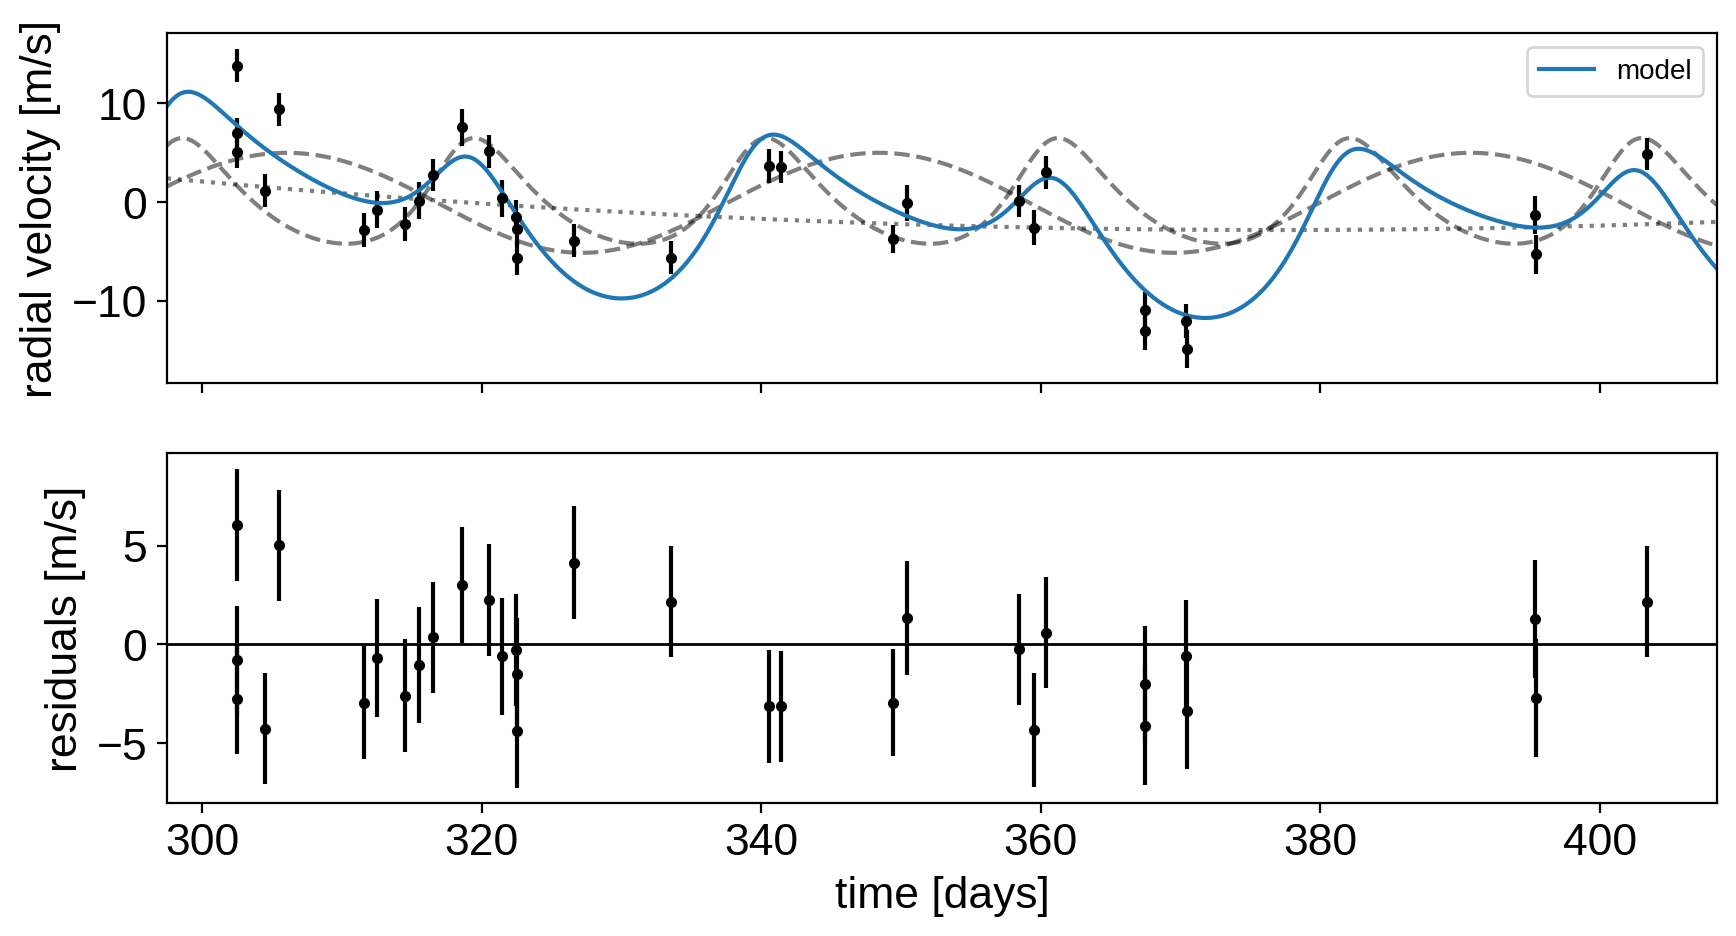

In [10]:
def plot_rv_curve(soln):
    fig, axes = plt.subplots(2, 1, figsize=(10, 5), sharex=True)

    ax = axes[0]
    ax.errorbar(x_rv, y_rv, yerr=yerr_rv, fmt=".k")
    ax.plot(t_rv, soln["vrad_pred"], "--k", alpha=0.5)
    ax.plot(t_rv, soln["bkg_pred"], ":k", alpha=0.5)
    ax.plot(t_rv, soln["rv_model_pred"], label="model")
    ax.legend(fontsize=10)
    ax.set_ylabel("radial velocity [m/s]")

    ax = axes[1]
    err = np.sqrt(yerr_rv ** 2 + np.exp(2 * soln["logs_rv"]))
    ax.errorbar(x_rv, y_rv - soln["rv_model"], yerr=err, fmt=".k")
    ax.axhline(0, color="k", lw=1)
    ax.set_ylabel("residuals [m/s]")
    ax.set_xlim(t_rv.min(), t_rv.max())
    ax.set_xlabel("time [days]")


plot_rv_curve(map_soln0)

That looks pretty similar to what we got in :ref:`rv`.
Now let's also plot the transit model.

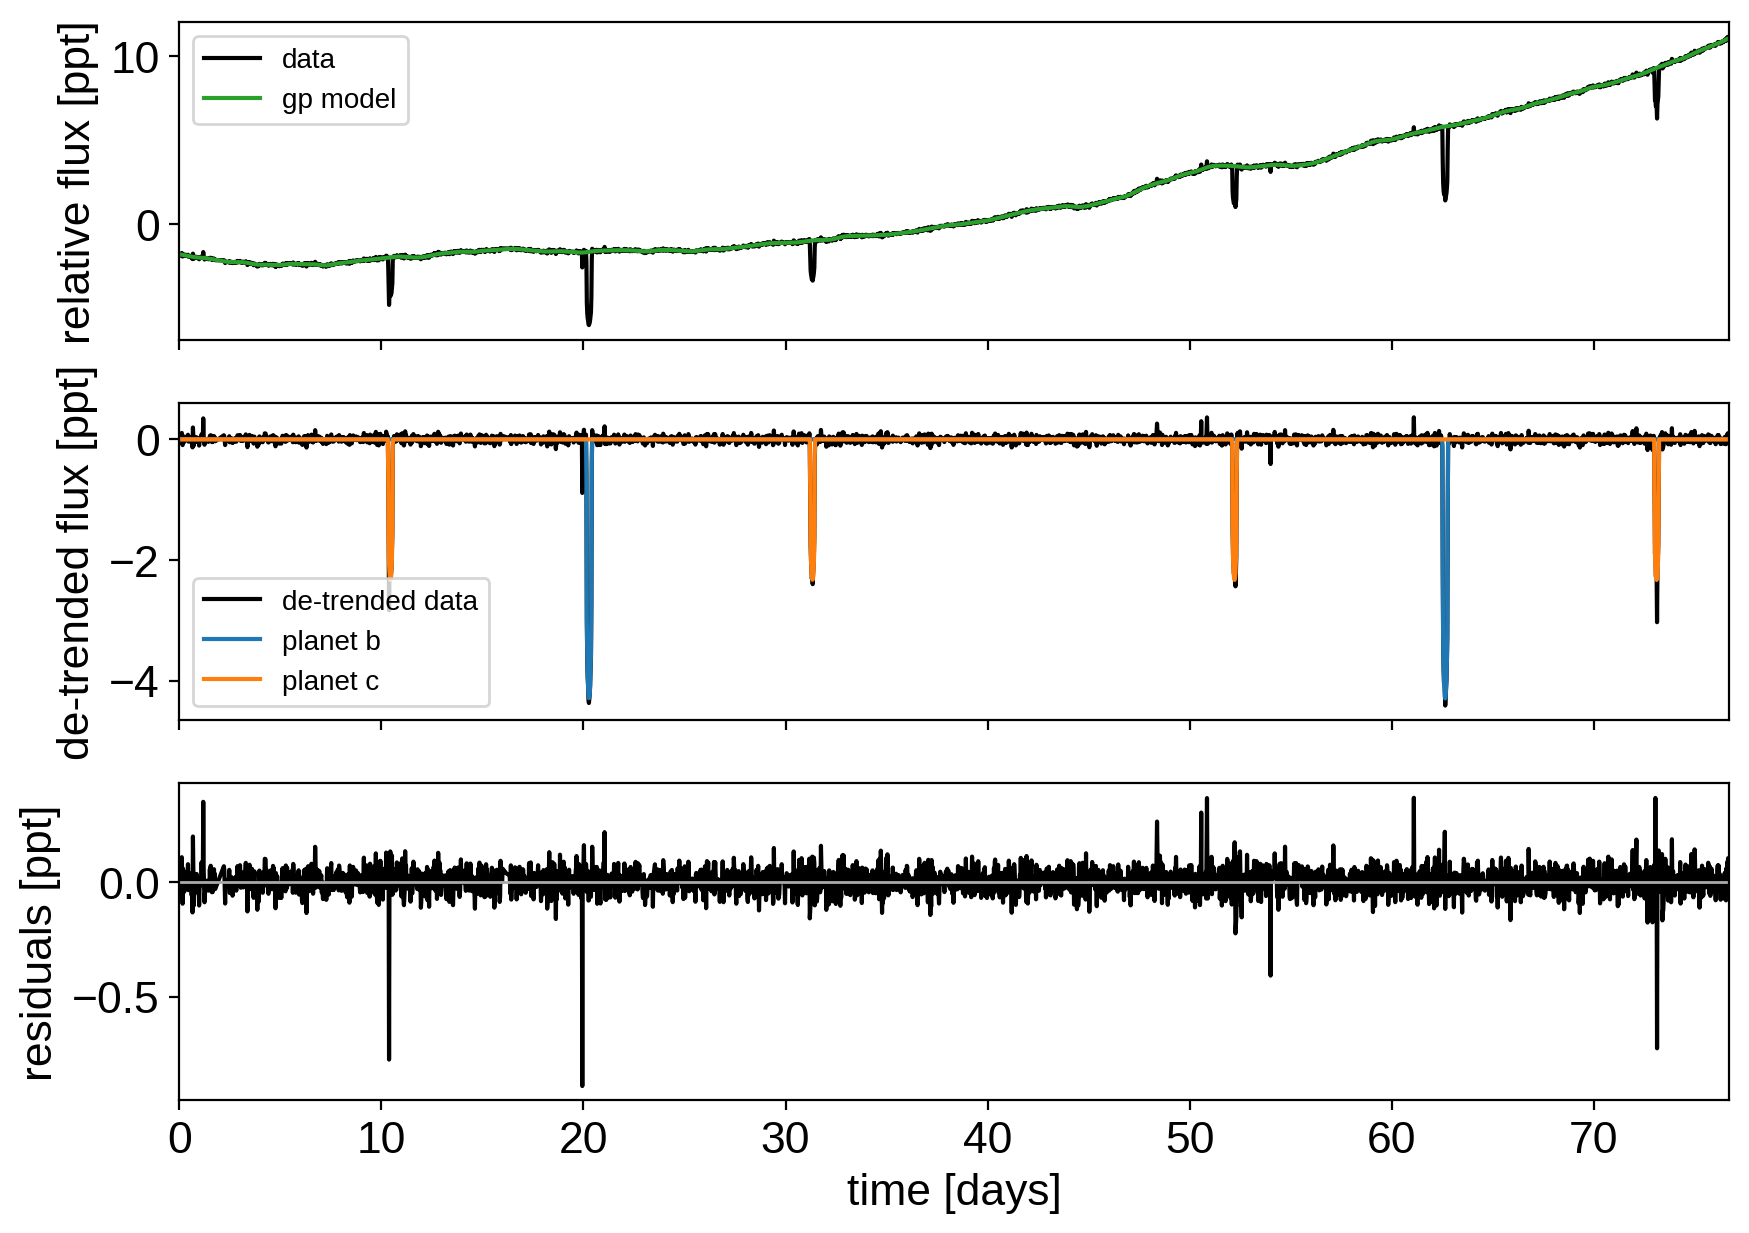

In [11]:
def plot_light_curve(soln, mask=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)

    ax = axes[0]
    ax.plot(x[mask], y[mask], "k", label="data")
    gp_mod = soln["gp_pred"] + soln["mean"]
    ax.plot(x[mask], gp_mod, color="C2", label="gp model")
    ax.legend(fontsize=10)
    ax.set_ylabel("relative flux [ppt]")

    ax = axes[1]
    ax.plot(x[mask], y[mask] - gp_mod, "k", label="de-trended data")
    for i, l in enumerate("bc"):
        mod = soln["light_curves"][:, i]
        ax.plot(x[mask], mod, label="planet {0}".format(l))
    ax.legend(fontsize=10, loc=3)
    ax.set_ylabel("de-trended flux [ppt]")

    ax = axes[2]
    mod = gp_mod + np.sum(soln["light_curves"], axis=-1)
    ax.plot(x[mask], y[mask] - mod, "k")
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals [ppt]")
    ax.set_xlim(x[mask].min(), x[mask].max())
    ax.set_xlabel("time [days]")

    return fig


plot_light_curve(map_soln0);

There are still a few outliers in the light curve and it can be useful to remove those before doing the full fit because both the GP and transit parameters can be sensitive to this.

## Sigma clipping

To remove the outliers, we'll look at the empirical RMS of the residuals away from the GP + transit model and remove anything that is more than a 7-sigma outlier.

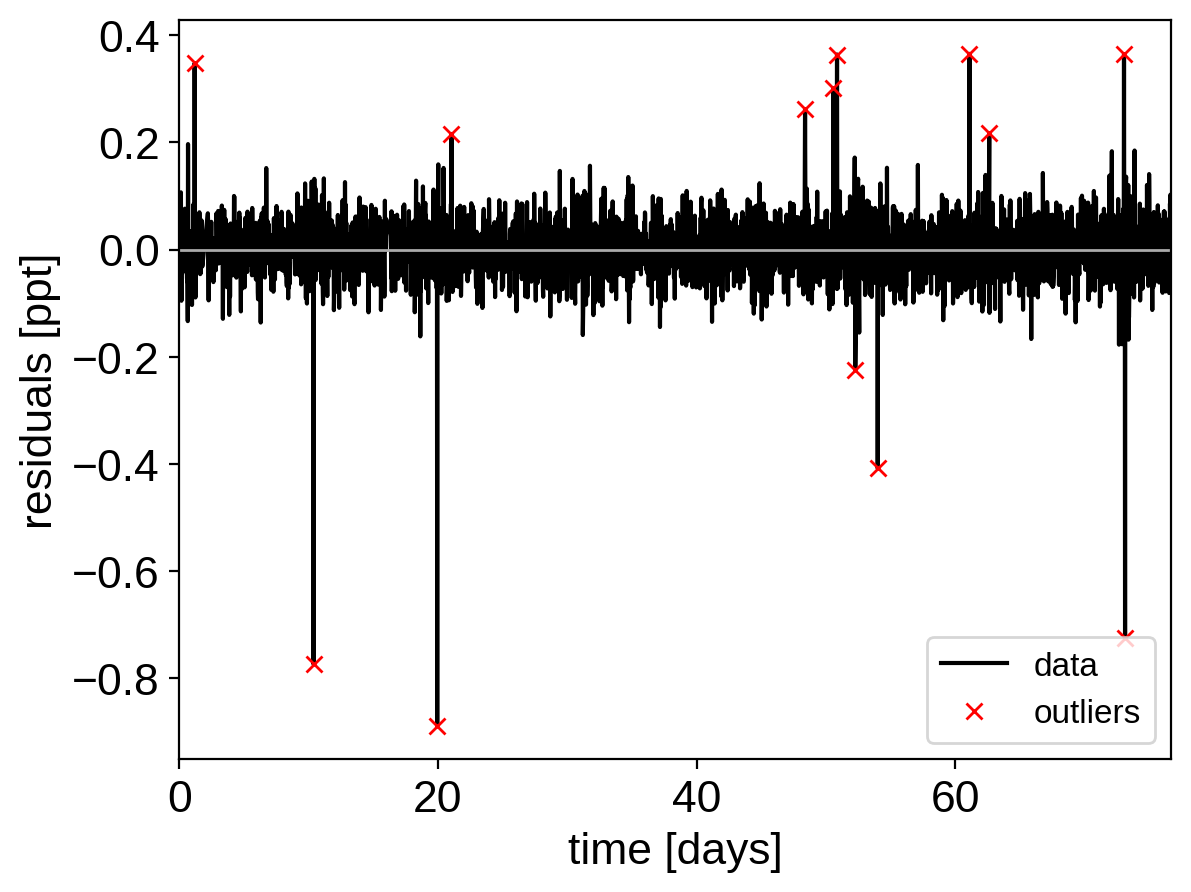

In [12]:
mod = (
    map_soln0["gp_pred"]
    + map_soln0["mean"]
    + np.sum(map_soln0["light_curves"], axis=-1)
)
resid = y - mod
rms = np.sqrt(np.median(resid ** 2))
mask = np.abs(resid) < 7 * rms

plt.plot(x, resid, "k", label="data")
plt.plot(x[~mask], resid[~mask], "xr", label="outliers")
plt.axhline(0, color="#aaaaaa", lw=1)
plt.ylabel("residuals [ppt]")
plt.xlabel("time [days]")
plt.legend(fontsize=12, loc=4)
plt.xlim(x.min(), x.max());

That looks better. Let's re-build our model with this sigma-clipped dataset.

optimizing logp for variables: [trend]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=5.187170e+03]

1it [00:00, 132.11it/s, logp=5.187170e+03]

2it [00:00, 180.53it/s, logp=5.187170e+03]

3it [00:00, 213.16it/s, logp=5.184582e+03]

4it [00:00, 228.58it/s, logp=5.187170e+03]

5it [00:01,  2.82it/s, logp=5.187170e+03] 


message: Optimization terminated successfully.
logp: 5187.169972104779 -> 5187.169972104779


optimizing logp for variables: [logs2]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=5.187170e+03]

1it [00:00, 125.66it/s, logp=5.187170e+03]

2it [00:00, 174.43it/s, logp=5.187170e+03]

3it [00:00, 200.61it/s, logp=4.799455e+03]

4it [00:00, 225.30it/s, logp=5.268757e+03]

5it [00:00, 242.82it/s, logp=5.269243e+03]

6it [00:00, 255.56it/s, logp=5.269258e+03]

7it [00:00, 266.53it/s, logp=5.269258e+03]

8it [00:00, 277.68it/s, logp=5.269258e+03]

9it [00:01,  4.89it/s, logp=5.269258e+03] 


message: Optimization terminated successfully.
logp: 5187.169972104779 -> 5269.258081228617


optimizing logp for variables: [b, logr, r_star]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=5.269258e+03]

1it [00:00, 186.36it/s, logp=5.269258e+03]

2it [00:00, 254.29it/s, logp=5.269258e+03]

3it [00:00, 288.53it/s, logp=-5.785905e+04]

4it [00:00, 312.85it/s, logp=5.272880e+03] 

5it [00:00, 326.89it/s, logp=5.209373e+03]

6it [00:00, 338.92it/s, logp=5.273077e+03]

7it [00:00, 343.91it/s, logp=5.273269e+03]

8it [00:00, 347.37it/s, logp=5.273558e+03]

9it [00:00, 353.47it/s, logp=5.274168e+03]

10it [00:00, 358.85it/s, logp=5.274984e+03]

11it [00:00, 363.97it/s, logp=5.275160e+03]

12it [00:00, 367.19it/s, logp=5.277683e+03]

13it [00:00, 369.73it/s, logp=4.929549e+03]

14it [00:00, 373.24it/s, logp=5.277864e+03]

15it [00:00, 375.02it/s, logp=5.278214e+03]

16it [00:00, 378.10it/s, logp=5.279301e+03]

17it [00:00, 379.50it/s, logp=5.280050e+03]

18it [00:00, 380.69it/s, logp=5.280094e+03]

19it [00:00, 382.20it/s, logp=5.280172e+03]

20it [00:00, 383.02it/s, logp=5.280126e+03]

21it [00:00, 384.73it/s, logp=5.280224e+03]

22it [00:00, 385.55it/s, logp=5.280223e+03]

23it [00:00, 387.08it/s, logp=5.280229e+03]

24it [00:00, 387.87it/s, logp=5.280231e+03]

25it [00:00, 388.52it/s, logp=5.280231e+03]

26it [00:00, 389.15it/s, logp=5.280231e+03]

27it [00:00, 389.73it/s, logp=5.280231e+03]

28it [00:00, 390.12it/s, logp=5.280231e+03]

29it [00:00, 390.77it/s, logp=5.280231e+03]

30it [00:00, 391.33it/s, logp=5.280231e+03]

31it [00:00, 391.90it/s, logp=5.280231e+03]

32it [00:00, 392.30it/s, logp=5.280231e+03]

33it [00:00, 392.65it/s, logp=5.280231e+03]

34it [00:01, 21.17it/s, logp=5.280231e+03] 


message: Optimization terminated successfully.
logp: 5269.258081228617 -> 5280.231230124337


optimizing logp for variables: [t0, logP]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=5.280231e+03]

1it [00:00, 168.65it/s, logp=5.280231e+03]

2it [00:00, 233.21it/s, logp=5.280231e+03]

3it [00:00, 260.33it/s, logp=-9.216501e+04]

4it [00:00, 282.13it/s, logp=-7.964204e+04]

5it [00:00, 298.35it/s, logp=-3.809930e+04]

6it [00:00, 310.54it/s, logp=5.227414e+03] 

7it [00:00, 320.86it/s, logp=5.280689e+03]

8it [00:00, 325.67it/s, logp=5.113912e+03]

9it [00:00, 332.33it/s, logp=5.280690e+03]

10it [00:00, 336.90it/s, logp=5.280692e+03]

11it [00:00, 341.96it/s, logp=5.280701e+03]

12it [00:00, 345.85it/s, logp=5.280736e+03]

13it [00:00, 349.77it/s, logp=5.280868e+03]

14it [00:00, 352.07it/s, logp=5.280610e+03]

15it [00:00, 354.97it/s, logp=5.280920e+03]

16it [00:00, 356.39it/s, logp=5.281020e+03]

17it [00:00, 358.91it/s, logp=5.281339e+03]

18it [00:00, 359.67it/s, logp=5.281600e+03]

19it [00:00, 359.78it/s, logp=5.281602e+03]

20it [00:00, 360.55it/s, logp=5.281602e+03]

21it [00:00, 361.41it/s, logp=5.281602e+03]

22it [00:00, 362.18it/s, logp=5.281602e+03]

23it [00:00, 363.33it/s, logp=5.281602e+03]

24it [00:00, 364.60it/s, logp=5.281602e+03]

25it [00:00, 365.87it/s, logp=5.281602e+03]

26it [00:00, 367.06it/s, logp=5.281602e+03]

27it [00:00, 368.21it/s, logp=5.281602e+03]

28it [00:00, 369.13it/s, logp=5.281602e+03]

29it [00:00, 370.24it/s, logp=5.281602e+03]

30it [00:00, 371.01it/s, logp=5.281602e+03]

31it [00:00, 372.01it/s, logp=5.281602e+03]

32it [00:00, 372.63it/s, logp=5.281602e+03]

33it [00:00, 373.23it/s, logp=5.281602e+03]

34it [00:00, 373.96it/s, logp=5.281602e+03]

35it [00:00, 374.64it/s, logp=5.281602e+03]

36it [00:00, 375.23it/s, logp=5.281602e+03]

37it [00:00, 375.99it/s, logp=5.281602e+03]

38it [00:00, 376.46it/s, logp=5.281602e+03]

39it [00:00, 384.32it/s, logp=5.281602e+03]

39it [00:00, 384.32it/s, logp=5.281602e+03]

40it [00:00, 384.32it/s, logp=5.281602e+03]

41it [00:00, 384.32it/s, logp=5.281602e+03]

42it [00:00, 384.32it/s, logp=5.281602e+03]

43it [00:00, 384.32it/s, logp=5.281602e+03]

44it [00:00, 384.32it/s, logp=5.281602e+03]

45it [00:00, 384.32it/s, logp=5.281602e+03]

46it [00:00, 384.32it/s, logp=5.281602e+03]

47it [00:00, 384.32it/s, logp=5.281602e+03]

48it [00:00, 384.32it/s, logp=5.281602e+03]

49it [00:00, 384.32it/s, logp=5.281602e+03]

50it [00:00, 384.32it/s, logp=5.281602e+03]

51it [00:00, 384.32it/s, logp=5.281602e+03]

52it [00:00, 384.32it/s, logp=5.281602e+03]

53it [00:00, 384.32it/s, logp=5.281602e+03]

54it [00:00, 384.32it/s, logp=5.281602e+03]

55it [00:00, 384.32it/s, logp=5.281602e+03]

56it [00:00, 384.32it/s, logp=5.281602e+03]

57it [00:00, 384.32it/s, logp=5.281602e+03]

58it [00:00, 384.32it/s, logp=5.281602e+03]

59it [00:00, 384.32it/s, logp=5.281602e+03]

60it [00:00, 384.32it/s, logp=5.281602e+03]

61it [00:00, 384.32it/s, logp=5.281602e+03]

62it [00:00, 384.32it/s, logp=5.281602e+03]

63it [00:00, 384.32it/s, logp=5.281602e+03]

64it [00:00, 384.32it/s, logp=5.281602e+03]

65it [00:00, 384.32it/s, logp=5.281602e+03]

66it [00:00, 384.32it/s, logp=5.281602e+03]

67it [00:00, 384.32it/s, logp=5.281602e+03]

68it [00:00, 384.32it/s, logp=5.281602e+03]

69it [00:00, 384.32it/s, logp=5.281602e+03]

70it [00:00, 384.32it/s, logp=5.281602e+03]

71it [00:00, 384.32it/s, logp=5.281602e+03]

72it [00:00, 384.32it/s, logp=5.281602e+03]

73it [00:00, 384.32it/s, logp=5.281602e+03]

74it [00:00, 384.32it/s, logp=5.281602e+03]

75it [00:00, 384.32it/s, logp=5.281602e+03]

76it [00:00, 384.32it/s, logp=5.281602e+03]

77it [00:02, 37.36it/s, logp=5.281602e+03] 


message: Desired error not necessarily achieved due to precision loss.
logp: 5280.231230124337 -> 5281.601991110998


optimizing logp for variables: [logSw4, logs2]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=5.281602e+03]

1it [00:00, 173.56it/s, logp=5.281602e+03]

2it [00:00, 236.41it/s, logp=5.281602e+03]

3it [00:00, 269.25it/s, logp=4.587147e+03]

4it [00:00, 290.76it/s, logp=5.281683e+03]

5it [00:00, 302.43it/s, logp=5.281837e+03]

6it [00:00, 312.04it/s, logp=5.282099e+03]

7it [00:00, 318.61it/s, logp=5.282332e+03]

8it [00:00, 324.70it/s, logp=5.282332e+03]

9it [00:00, 329.40it/s, logp=5.282332e+03]

10it [00:01,  6.80it/s, logp=5.282332e+03]


message: Optimization terminated successfully.
logp: 5281.601991111005 -> 5282.331526068319


optimizing logp for variables: [logw0]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=5.282332e+03]

1it [00:00, 132.99it/s, logp=5.282332e+03]

2it [00:00, 182.80it/s, logp=5.282332e+03]

3it [00:00, 212.13it/s, logp=5.247376e+03]

4it [00:00, 233.15it/s, logp=5.282218e+03]

5it [00:00, 241.97it/s, logp=5.282366e+03]

6it [00:00, 252.09it/s, logp=5.282366e+03]

7it [00:00, 260.60it/s, logp=5.282366e+03]

8it [00:00, 268.42it/s, logp=5.282366e+03]

9it [00:01,  6.14it/s, logp=5.282366e+03] 


message: Optimization terminated successfully.
logp: 5282.331526068319 -> 5282.365625613341


optimizing logp for variables: [logSw4, logw0, logs2, trend, logs_rv, ecc_prior_frac, ecc_prior_sigma_rayleigh, ecc_prior_sigma_gauss, ecs, b, logr, t0, logP, logm, r_star, m_star, u_star, mean]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=5.282366e+03]

1it [00:00, 132.67it/s, logp=5.282366e+03]

2it [00:00, 182.99it/s, logp=5.282366e+03]

3it [00:00, 201.17it/s, logp=-1.189649e+05]

4it [00:00, 217.58it/s, logp=2.133685e+03] 

5it [00:00, 229.89it/s, logp=5.282366e+03]

6it [00:00, 235.06it/s, logp=5.282343e+03]

7it [00:00, 241.69it/s, logp=5.282366e+03]

8it [00:00, 243.79it/s, logp=5.282366e+03]

9it [00:00, 249.03it/s, logp=5.282366e+03]

10it [00:00, 252.91it/s, logp=5.282366e+03]

11it [00:00, 254.98it/s, logp=5.282366e+03]

12it [00:00, 255.56it/s, logp=5.282366e+03]

13it [00:00, 258.45it/s, logp=5.282367e+03]

14it [00:00, 260.71it/s, logp=5.282370e+03]

15it [00:00, 261.05it/s, logp=5.282364e+03]

16it [00:00, 263.14it/s, logp=5.282371e+03]

17it [00:00, 263.50it/s, logp=5.282373e+03]

18it [00:00, 263.65it/s, logp=5.282367e+03]

19it [00:00, 265.19it/s, logp=5.282373e+03]

20it [00:00, 265.02it/s, logp=5.282374e+03]

21it [00:00, 266.38it/s, logp=5.282376e+03]

22it [00:00, 266.27it/s, logp=5.282381e+03]

23it [00:00, 266.52it/s, logp=5.282391e+03]

24it [00:00, 267.63it/s, logp=5.282428e+03]

25it [00:00, 267.50it/s, logp=5.282488e+03]

26it [00:00, 267.06it/s, logp=5.282605e+03]

27it [00:00, 267.60it/s, logp=5.282985e+03]

28it [00:00, 276.13it/s, logp=5.282985e+03]

28it [00:00, 276.13it/s, logp=5.270852e+03]

29it [00:00, 276.13it/s, logp=5.283004e+03]

30it [00:00, 276.13it/s, logp=5.283038e+03]

31it [00:00, 276.13it/s, logp=5.283091e+03]

32it [00:00, 276.13it/s, logp=5.283169e+03]

33it [00:00, 276.13it/s, logp=5.283311e+03]

34it [00:00, 276.13it/s, logp=5.283468e+03]

35it [00:00, 276.13it/s, logp=5.283449e+03]

36it [00:00, 276.13it/s, logp=5.283553e+03]

37it [00:00, 276.13it/s, logp=5.283599e+03]

38it [00:00, 276.13it/s, logp=5.283658e+03]

39it [00:00, 276.13it/s, logp=5.283758e+03]

40it [00:00, 276.13it/s, logp=5.283800e+03]

41it [00:00, 276.13it/s, logp=5.283828e+03]

42it [00:00, 276.13it/s, logp=5.283860e+03]

43it [00:00, 276.13it/s, logp=5.283915e+03]

44it [00:00, 276.13it/s, logp=5.283778e+03]

45it [00:00, 276.13it/s, logp=5.283928e+03]

46it [00:00, 276.13it/s, logp=5.283950e+03]

47it [00:00, 276.13it/s, logp=5.283967e+03]

48it [00:00, 276.13it/s, logp=5.283974e+03]

49it [00:00, 276.13it/s, logp=5.283984e+03]

50it [00:00, 276.13it/s, logp=5.283990e+03]

51it [00:00, 276.13it/s, logp=5.283992e+03]

52it [00:00, 276.13it/s, logp=5.283996e+03]

53it [00:00, 276.13it/s, logp=5.284012e+03]

54it [00:00, 276.13it/s, logp=5.284023e+03]

55it [00:00, 272.41it/s, logp=5.284023e+03]

55it [00:00, 272.41it/s, logp=5.284044e+03]

56it [00:00, 272.41it/s, logp=5.284085e+03]

57it [00:00, 272.41it/s, logp=5.284092e+03]

58it [00:00, 272.41it/s, logp=5.284129e+03]

59it [00:00, 272.41it/s, logp=5.283942e+03]

60it [00:00, 272.41it/s, logp=5.284172e+03]

61it [00:00, 272.41it/s, logp=5.284176e+03]

62it [00:00, 272.41it/s, logp=5.284196e+03]

63it [00:00, 272.41it/s, logp=5.284231e+03]

64it [00:00, 272.41it/s, logp=5.284215e+03]

65it [00:00, 272.41it/s, logp=5.284244e+03]

66it [00:00, 272.41it/s, logp=5.284257e+03]

67it [00:00, 272.41it/s, logp=5.284260e+03]

68it [00:00, 272.41it/s, logp=5.284266e+03]

69it [00:00, 272.41it/s, logp=5.284275e+03]

70it [00:00, 272.41it/s, logp=5.284281e+03]

71it [00:00, 272.41it/s, logp=5.284284e+03]

72it [00:00, 272.41it/s, logp=5.284287e+03]

73it [00:00, 272.41it/s, logp=5.284288e+03]

74it [00:00, 272.41it/s, logp=5.284289e+03]

75it [00:00, 272.41it/s, logp=5.284289e+03]

76it [00:00, 272.41it/s, logp=5.284289e+03]

77it [00:00, 272.41it/s, logp=5.284290e+03]

78it [00:00, 272.41it/s, logp=5.284290e+03]

79it [00:00, 272.41it/s, logp=5.284290e+03]

80it [00:00, 272.41it/s, logp=5.284290e+03]

81it [00:00, 272.41it/s, logp=5.284290e+03]

82it [00:00, 270.37it/s, logp=5.284290e+03]

82it [00:00, 270.37it/s, logp=5.284290e+03]

83it [00:00, 270.37it/s, logp=5.284290e+03]

84it [00:00, 270.37it/s, logp=5.284290e+03]

85it [00:00, 270.37it/s, logp=5.284290e+03]

86it [00:00, 270.37it/s, logp=5.284290e+03]

87it [00:00, 270.37it/s, logp=5.284290e+03]

88it [00:00, 270.37it/s, logp=5.284290e+03]

89it [00:00, 270.37it/s, logp=5.284290e+03]

90it [00:00, 270.37it/s, logp=5.284290e+03]

91it [00:00, 270.37it/s, logp=5.284290e+03]

92it [00:00, 270.37it/s, logp=5.284290e+03]

93it [00:00, 270.37it/s, logp=5.284290e+03]

94it [00:00, 270.37it/s, logp=5.284290e+03]

95it [00:00, 270.37it/s, logp=5.284290e+03]

96it [00:00, 270.37it/s, logp=5.284290e+03]

97it [00:00, 270.37it/s, logp=5.284290e+03]

98it [00:00, 270.37it/s, logp=5.284290e+03]

99it [00:00, 270.37it/s, logp=5.284290e+03]

100it [00:00, 270.37it/s, logp=5.284290e+03]

101it [00:00, 270.37it/s, logp=5.284290e+03]

102it [00:00, 270.37it/s, logp=5.284290e+03]

103it [00:00, 270.37it/s, logp=5.284290e+03]

104it [00:00, 270.37it/s, logp=5.284290e+03]

105it [00:00, 270.37it/s, logp=5.284290e+03]

106it [00:00, 270.37it/s, logp=5.284290e+03]

107it [00:00, 270.37it/s, logp=5.284290e+03]

108it [00:00, 270.37it/s, logp=5.284290e+03]

109it [00:00, 270.37it/s, logp=5.284290e+03]

110it [00:00, 272.66it/s, logp=5.284290e+03]

110it [00:00, 272.66it/s, logp=5.284290e+03]

111it [00:00, 272.66it/s, logp=5.284290e+03]

112it [00:00, 272.66it/s, logp=5.284290e+03]

113it [00:00, 272.66it/s, logp=5.284290e+03]

114it [00:00, 272.66it/s, logp=5.284290e+03]

115it [00:00, 272.66it/s, logp=5.284290e+03]

116it [00:00, 272.66it/s, logp=5.284290e+03]

117it [00:00, 272.66it/s, logp=5.284290e+03]

118it [00:00, 272.66it/s, logp=5.284290e+03]

119it [00:00, 272.66it/s, logp=5.284290e+03]

120it [00:00, 272.66it/s, logp=5.284290e+03]

121it [00:00, 272.66it/s, logp=5.284290e+03]

122it [00:00, 272.66it/s, logp=5.284290e+03]

123it [00:00, 272.66it/s, logp=5.284290e+03]

124it [00:00, 272.66it/s, logp=5.284290e+03]

125it [00:00, 272.66it/s, logp=5.284290e+03]

126it [00:00, 272.66it/s, logp=5.284290e+03]

127it [00:00, 272.66it/s, logp=5.284290e+03]

128it [00:00, 272.66it/s, logp=5.284290e+03]

129it [00:00, 272.66it/s, logp=5.284290e+03]

130it [00:00, 272.66it/s, logp=5.284290e+03]

131it [00:00, 272.66it/s, logp=5.284290e+03]

132it [00:00, 272.66it/s, logp=5.284290e+03]

133it [00:00, 272.66it/s, logp=5.284290e+03]

134it [00:00, 272.66it/s, logp=5.284290e+03]

135it [00:00, 272.66it/s, logp=5.284290e+03]

136it [00:00, 272.66it/s, logp=5.284290e+03]

137it [00:00, 272.66it/s, logp=5.284290e+03]

138it [00:00, 272.66it/s, logp=5.284290e+03]

139it [00:00, 277.41it/s, logp=5.284290e+03]

139it [00:00, 277.41it/s, logp=5.284290e+03]

140it [00:00, 277.41it/s, logp=5.284290e+03]

141it [00:00, 277.41it/s, logp=5.284290e+03]

142it [00:00, 277.41it/s, logp=5.284290e+03]

143it [00:00, 277.41it/s, logp=5.284290e+03]

144it [00:00, 277.41it/s, logp=5.284290e+03]

145it [00:00, 277.41it/s, logp=5.284290e+03]

146it [00:00, 277.41it/s, logp=5.284290e+03]

147it [00:00, 277.41it/s, logp=5.284290e+03]

148it [00:00, 277.41it/s, logp=5.284290e+03]

149it [00:00, 277.41it/s, logp=5.284290e+03]

150it [00:00, 277.41it/s, logp=5.284290e+03]

151it [00:00, 277.41it/s, logp=5.284290e+03]

152it [00:00, 277.41it/s, logp=5.284290e+03]

153it [00:00, 277.41it/s, logp=5.284290e+03]

154it [00:00, 277.41it/s, logp=5.284290e+03]

155it [00:02, 62.92it/s, logp=5.284290e+03] 


message: Desired error not necessarily achieved due to precision loss.
logp: 5282.365625613334 -> 5284.289992339934


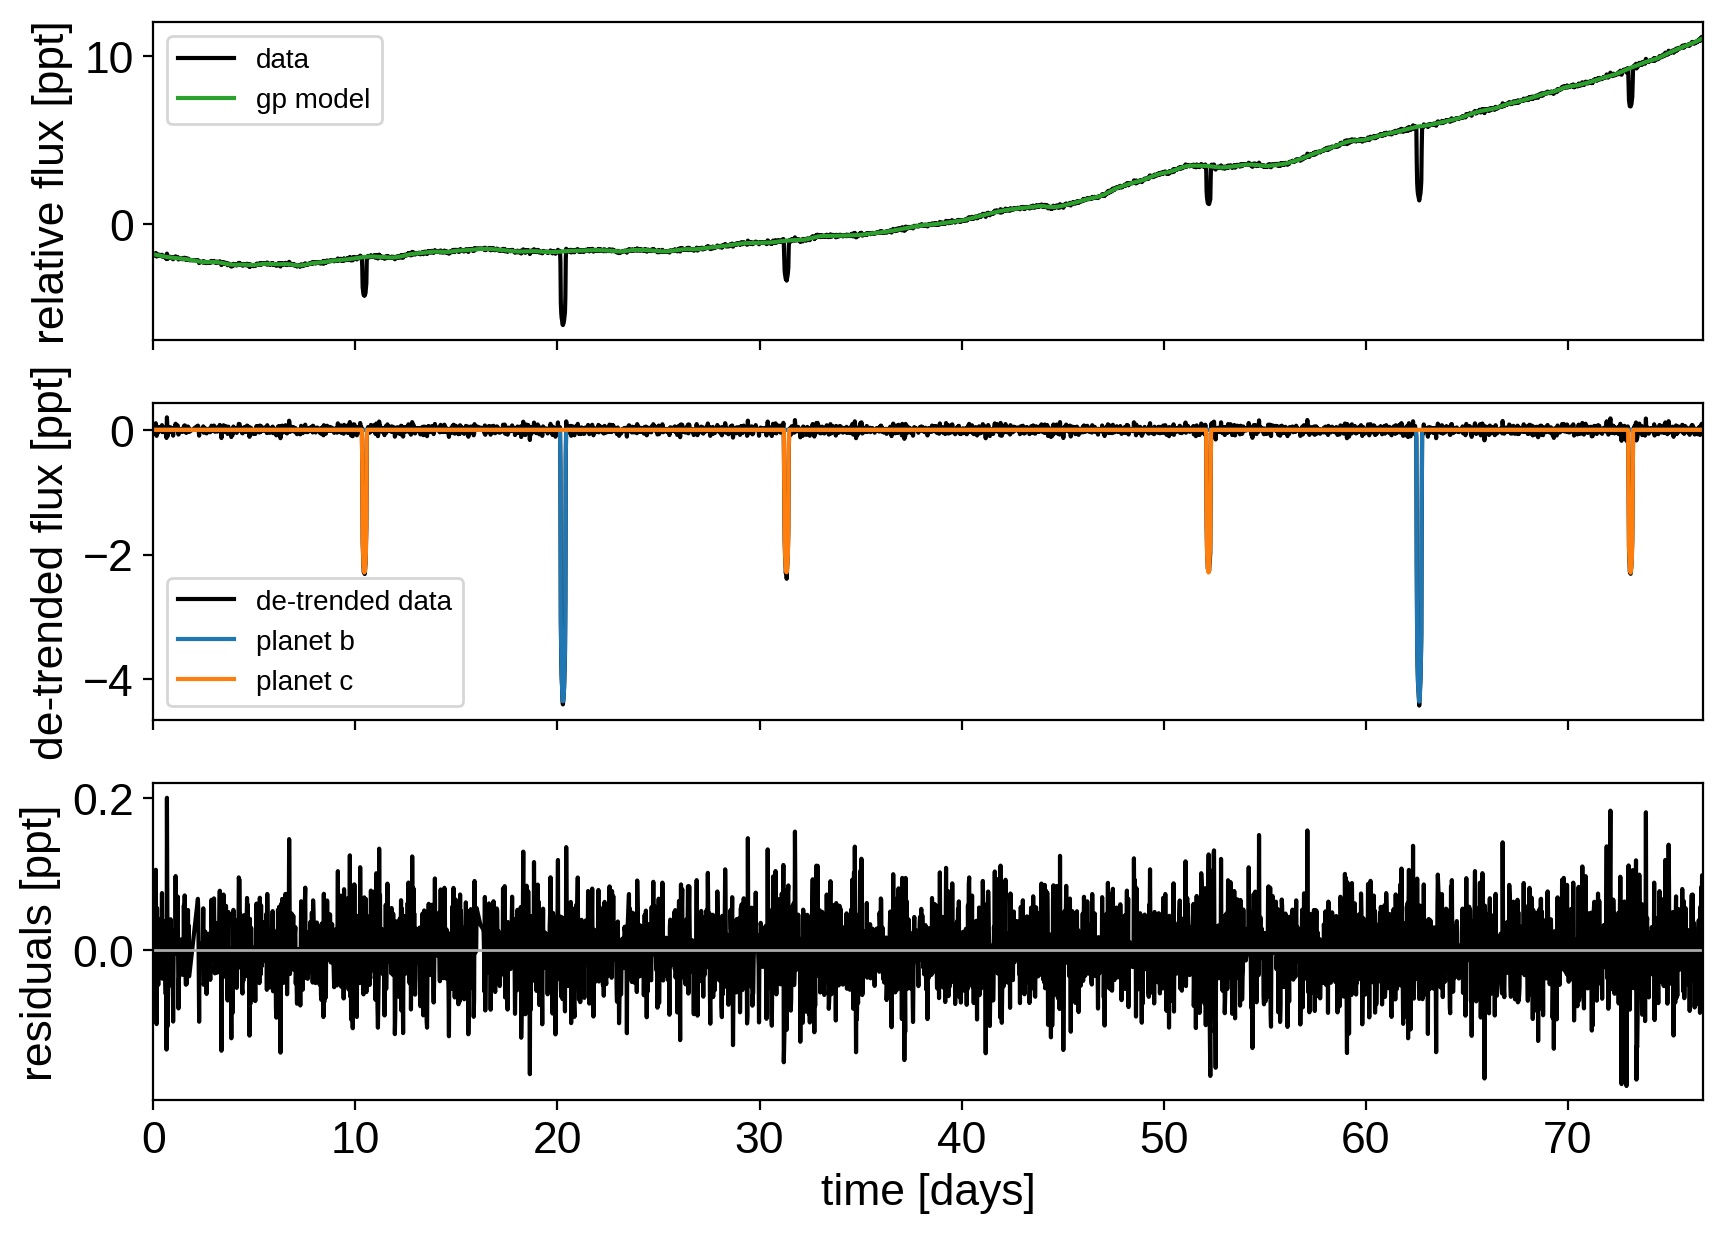

In [13]:
model, map_soln = build_model(mask, map_soln0)
plot_light_curve(map_soln, mask);

Great! Now we're ready to sample.

## Sampling

The sampling for this model is the same as for all the previous tutorials, but it takes a bit longer (about 2 hours on my laptop).
This is partly because the model is more expensive to compute than the previous ones and partly because there are some non-affine degeneracies in the problem (for example between impact parameter and eccentricity).
It might be worth thinking about reparameterizations (in terms of duration instead of eccentricity), but that's beyond the scope of this tutorial.
Besides, using more traditional MCMC methods, this would have taken a lot more than 2 hours to get >1000 effective samples!

In [14]:
np.random.seed(203771098)
with model:
    trace = pm.sample(
        tune=3500,
        draws=3000,
        start=map_soln,
        chains=4,
        step=xo.get_dense_nuts_step(target_accept=0.95),
    )

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [logSw4, logw0, logs2, trend, logs_rv, ecc_prior_frac, ecc_prior_sigma_rayleigh, ecc_prior_sigma_gauss, ecs, b, logr, t0, logP, logm, r_star, m_star, u_star, mean]


Sampling 4 chains, 0 divergences:   0%|          | 0/26000 [00:00<?, ?draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 20/26000 [00:00<02:18, 187.22draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 26/26000 [00:01<29:07, 14.87draws/s] 

Sampling 4 chains, 0 divergences:   0%|          | 31/26000 [00:02<37:44, 11.47draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 35/26000 [00:02<47:01,  9.20draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 38/26000 [00:03<1:00:13,  7.18draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 41/26000 [00:03<1:08:58,  6.27draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 45/26000 [00:04<1:09:00,  6.27draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 49/26000 [00:05<1:09:01,  6.27draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 53/26000 [00:05<1:09:17,  6.24draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 56/26000 [00:05<53:05,  8.14draws/s]  

Sampling 4 chains, 0 divergences:   0%|          | 58/26000 [00:06<1:12:10,  5.99draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 60/26000 [00:06<58:03,  7.45draws/s]  

Sampling 4 chains, 0 divergences:   0%|          | 62/26000 [00:07<1:14:41,  5.79draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 64/26000 [00:07<1:00:34,  7.14draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 66/26000 [00:07<1:15:31,  5.72draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 68/26000 [00:07<1:02:08,  6.95draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 70/26000 [00:08<1:16:01,  5.69draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 72/26000 [00:08<1:02:49,  6.88draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 74/26000 [00:09<1:15:54,  5.69draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 76/26000 [00:09<1:03:28,  6.81draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 77/26000 [00:09<1:42:34,  4.21draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 79/26000 [00:09<1:20:30,  5.37draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 81/26000 [00:10<1:28:54,  4.86draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 83/26000 [00:10<1:11:40,  6.03draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 85/26000 [00:10<1:21:40,  5.29draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 87/26000 [00:11<1:07:25,  6.41draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 89/26000 [00:11<1:18:04,  5.53draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 91/26000 [00:11<1:06:22,  6.51draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 93/26000 [00:12<1:16:01,  5.68draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 95/26000 [00:12<1:05:35,  6.58draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 97/26000 [00:12<1:14:34,  5.79draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 99/26000 [00:13<1:05:30,  6.59draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 101/26000 [00:13<1:14:02,  5.83draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 103/26000 [00:13<1:05:32,  6.59draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 104/26000 [00:13<58:54,  7.33draws/s]  

Sampling 4 chains, 0 divergences:   0%|          | 105/26000 [00:14<1:22:54,  5.21draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 107/26000 [00:14<1:12:33,  5.95draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 108/26000 [00:14<1:06:06,  6.53draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 109/26000 [00:14<1:24:11,  5.12draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 111/26000 [00:14<1:14:03,  5.83draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 112/26000 [00:15<1:07:37,  6.38draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 113/26000 [00:15<1:23:39,  5.16draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 115/26000 [00:15<1:14:10,  5.82draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 116/26000 [00:15<1:08:15,  6.32draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 117/26000 [00:16<1:22:08,  5.25draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 118/26000 [00:16<1:10:42,  6.10draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 119/26000 [00:16<1:09:45,  6.18draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 120/26000 [00:16<1:06:45,  6.46draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 121/26000 [00:16<1:17:49,  5.54draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 122/26000 [00:16<1:10:24,  6.13draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 123/26000 [00:16<1:08:51,  6.26draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 124/26000 [00:17<1:05:52,  6.55draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 125/26000 [00:17<1:14:55,  5.76draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 126/26000 [00:17<1:09:09,  6.24draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 127/26000 [00:17<1:08:44,  6.27draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 128/26000 [00:17<1:06:20,  6.50draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 129/26000 [00:17<1:13:16,  5.88draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 130/26000 [00:18<1:08:30,  6.29draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 131/26000 [00:18<1:09:34,  6.20draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 132/26000 [00:18<1:07:07,  6.42draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 133/26000 [00:18<1:11:56,  5.99draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 134/26000 [00:18<1:07:57,  6.34draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 135/26000 [00:18<1:10:01,  6.16draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 136/26000 [00:19<1:08:22,  6.30draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 137/26000 [00:19<1:10:32,  6.11draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 138/26000 [00:19<1:08:49,  6.26draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 139/26000 [00:19<1:10:19,  6.13draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 140/26000 [00:19<1:09:10,  6.23draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 141/26000 [00:19<1:09:42,  6.18draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 142/26000 [00:19<1:07:53,  6.35draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 143/26000 [00:20<1:10:28,  6.12draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 144/26000 [00:20<1:11:46,  6.00draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 145/26000 [00:20<1:07:52,  6.35draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 146/26000 [00:20<1:07:12,  6.41draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 147/26000 [00:20<1:10:53,  6.08draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 148/26000 [00:21<1:12:40,  5.93draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 149/26000 [00:21<1:06:21,  6.49draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 150/26000 [00:21<1:06:29,  6.48draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 151/26000 [00:21<1:11:22,  6.04draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 152/26000 [00:21<1:13:35,  5.85draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 153/26000 [00:21<1:05:03,  6.62draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 154/26000 [00:21<1:06:22,  6.49draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 155/26000 [00:22<1:12:07,  5.97draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 156/26000 [00:22<1:14:25,  5.79draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 158/26000 [00:22<1:08:38,  6.27draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 159/26000 [00:22<1:15:19,  5.72draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 160/26000 [00:22<1:16:09,  5.66draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 162/26000 [00:23<1:09:29,  6.20draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 163/26000 [00:23<1:16:56,  5.60draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 164/26000 [00:23<1:18:46,  5.47draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 166/26000 [00:23<1:10:52,  6.07draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 167/26000 [00:24<1:17:03,  5.59draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 168/26000 [00:24<1:19:04,  5.44draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 170/26000 [00:24<1:10:24,  6.11draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 171/26000 [00:24<1:17:31,  5.55draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 172/26000 [00:24<1:19:38,  5.41draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 174/26000 [00:25<1:10:13,  6.13draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 175/26000 [00:25<1:18:25,  5.49draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 176/26000 [00:25<1:19:52,  5.39draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 178/26000 [00:25<1:09:57,  6.15draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 179/26000 [00:26<1:19:05,  5.44draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 180/26000 [00:26<1:18:37,  5.47draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 182/26000 [00:26<1:09:28,  6.19draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 183/26000 [00:26<1:19:42,  5.40draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 184/26000 [00:26<1:17:43,  5.54draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 186/26000 [00:27<1:09:13,  6.21draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 187/26000 [00:27<1:20:14,  5.36draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 188/26000 [00:27<1:16:36,  5.62draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 190/26000 [00:27<1:09:30,  6.19draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 191/26000 [00:27<1:19:55,  5.38draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 192/26000 [00:28<1:14:31,  5.77draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 194/26000 [00:28<1:08:23,  6.29draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 195/26000 [00:28<1:19:53,  5.38draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 196/26000 [00:28<1:12:55,  5.90draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 198/26000 [00:28<1:07:39,  6.36draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 199/26000 [00:29<1:20:27,  5.34draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 200/26000 [00:29<1:13:08,  5.88draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 202/26000 [00:29<1:07:33,  6.36draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 203/26000 [00:29<1:20:50,  5.32draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 204/26000 [00:29<1:12:04,  5.96draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 205/26000 [00:30<1:04:32,  6.66draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 206/26000 [00:30<1:04:17,  6.69draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 207/26000 [00:30<1:19:28,  5.41draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 208/26000 [00:30<1:09:35,  6.18draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 209/26000 [00:30<1:04:50,  6.63draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 210/26000 [00:30<1:03:06,  6.81draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 211/26000 [00:31<1:19:30,  5.41draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 213/26000 [00:31<1:10:52,  6.06draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 214/26000 [00:31<1:06:01,  6.51draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 215/26000 [00:31<1:22:40,  5.20draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 217/26000 [00:32<1:13:17,  5.86draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 218/26000 [00:32<1:06:22,  6.47draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 219/26000 [00:32<1:24:18,  5.10draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 221/26000 [00:32<1:14:29,  5.77draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 222/26000 [00:32<1:05:21,  6.57draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 223/26000 [00:33<1:24:29,  5.09draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 225/26000 [00:33<1:14:56,  5.73draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 227/26000 [00:33<1:18:29,  5.47draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 229/26000 [00:34<1:11:39,  5.99draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 231/26000 [00:34<1:14:57,  5.73draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 233/26000 [00:34<1:09:31,  6.18draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 235/26000 [00:35<1:13:11,  5.87draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 237/26000 [00:35<1:08:24,  6.28draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 239/26000 [00:35<1:12:13,  5.94draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 241/26000 [00:35<1:07:59,  6.31draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 243/26000 [00:36<1:11:56,  5.97draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 245/26000 [00:36<1:07:50,  6.33draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 247/26000 [00:36<1:10:54,  6.05draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 249/26000 [00:37<1:08:01,  6.31draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 251/26000 [00:37<1:09:58,  6.13draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 253/26000 [00:37<1:08:27,  6.27draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 255/26000 [00:38<1:09:23,  6.18draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 257/26000 [00:38<1:08:57,  6.22draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 259/26000 [00:38<1:08:50,  6.23draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 261/26000 [00:39<1:08:34,  6.26draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 263/26000 [00:39<1:08:25,  6.27draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 265/26000 [00:39<1:08:26,  6.27draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 267/26000 [00:40<1:08:08,  6.29draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 269/26000 [00:40<1:09:11,  6.20draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 271/26000 [00:40<1:07:42,  6.33draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 273/26000 [00:41<1:09:09,  6.20draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 275/26000 [00:41<1:07:21,  6.37draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 277/26000 [00:41<1:09:17,  6.19draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 279/26000 [00:42<1:07:03,  6.39draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 281/26000 [00:42<1:09:25,  6.17draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 283/26000 [00:42<1:07:01,  6.39draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 284/26000 [00:42<1:00:30,  7.08draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 285/26000 [00:43<1:14:02,  5.79draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 287/26000 [00:43<1:10:57,  6.04draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 288/26000 [00:43<1:03:09,  6.78draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 289/26000 [00:43<1:14:58,  5.72draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 291/26000 [00:43<1:11:14,  6.01draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 292/26000 [00:44<1:04:27,  6.65draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 293/26000 [00:44<1:15:02,  5.71draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 294/26000 [00:44<1:05:36,  6.53draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 295/26000 [00:44<1:10:18,  6.09draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 296/26000 [00:44<1:04:46,  6.61draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 297/26000 [00:44<1:14:25,  5.76draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 298/26000 [00:45<1:06:40,  6.43draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 299/26000 [00:45<1:09:01,  6.21draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 300/26000 [00:45<1:05:15,  6.56draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 301/26000 [00:45<1:13:56,  5.79draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 302/26000 [00:45<1:08:00,  6.30draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 303/26000 [00:45<1:07:53,  6.31draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 304/26000 [00:46<1:05:31,  6.54draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 305/26000 [00:46<1:13:22,  5.84draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 306/26000 [00:46<1:09:01,  6.20draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 307/26000 [00:46<1:06:39,  6.42draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 308/26000 [00:46<1:05:59,  6.49draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 309/26000 [00:46<1:12:57,  5.87draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 310/26000 [00:47<1:10:06,  6.11draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 311/26000 [00:47<1:05:07,  6.57draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 312/26000 [00:47<1:07:31,  6.34draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 313/26000 [00:47<1:12:16,  5.92draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 314/26000 [00:47<1:10:55,  6.04draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 315/26000 [00:47<1:03:51,  6.70draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 316/26000 [00:47<1:07:55,  6.30draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 317/26000 [00:48<1:11:42,  5.97draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 318/26000 [00:48<1:11:55,  5.95draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 320/26000 [00:48<1:08:46,  6.22draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 321/26000 [00:48<1:11:48,  5.96draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 322/26000 [00:48<1:14:31,  5.74draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 324/26000 [00:49<1:09:50,  6.13draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 325/26000 [00:49<1:11:19,  6.00draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 326/26000 [00:49<1:15:26,  5.67draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 328/26000 [00:49<1:10:13,  6.09draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 329/26000 [00:50<1:10:47,  6.04draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 330/26000 [00:50<1:16:10,  5.62draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 332/26000 [00:50<1:10:36,  6.06draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 333/26000 [00:50<1:12:02,  5.94draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 334/26000 [00:50<1:16:30,  5.59draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 336/26000 [00:51<1:10:40,  6.05draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 337/26000 [00:51<1:11:03,  6.02draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 338/26000 [00:51<1:17:23,  5.53draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 340/26000 [00:51<1:11:00,  6.02draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 341/26000 [00:51<1:10:21,  6.08draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 342/26000 [00:52<1:17:46,  5.50draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 344/26000 [00:52<1:11:15,  6.00draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 345/26000 [00:52<1:09:37,  6.14draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 346/26000 [00:52<1:16:39,  5.58draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 348/26000 [00:53<1:11:24,  5.99draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 349/26000 [00:53<1:08:29,  6.24draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 350/26000 [00:53<1:15:43,  5.65draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 352/26000 [00:53<1:11:15,  6.00draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 353/26000 [00:53<1:07:31,  6.33draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 354/26000 [00:54<1:14:21,  5.75draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 356/26000 [00:54<1:11:04,  6.01draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 357/26000 [00:54<1:06:31,  6.42draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 358/26000 [00:54<1:13:03,  5.85draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 360/26000 [00:55<1:10:52,  6.03draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 361/26000 [00:55<1:05:31,  6.52draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 362/26000 [00:55<1:11:37,  5.97draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 364/26000 [00:55<1:10:33,  6.06draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 365/26000 [00:55<1:04:44,  6.60draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 366/26000 [00:56<1:10:17,  6.08draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 368/26000 [00:56<1:10:36,  6.05draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 369/26000 [00:56<1:03:38,  6.71draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 370/26000 [00:56<1:08:46,  6.21draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 371/26000 [00:56<1:01:52,  6.90draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 372/26000 [00:57<1:13:58,  5.77draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 373/26000 [00:57<1:05:12,  6.55draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 374/26000 [00:57<1:09:09,  6.18draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 375/26000 [00:57<1:03:50,  6.69draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 376/26000 [00:57<1:15:03,  5.69draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 378/26000 [00:57<1:10:14,  6.08draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 379/26000 [00:58<1:06:51,  6.39draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 380/26000 [00:58<1:16:18,  5.60draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 382/26000 [00:58<1:10:31,  6.05draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 383/26000 [00:58<1:09:05,  6.18draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 384/26000 [00:58<1:17:10,  5.53draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 386/26000 [00:59<1:10:24,  6.06draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 387/26000 [00:59<1:10:57,  6.02draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 388/26000 [00:59<1:17:42,  5.49draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 390/26000 [00:59<1:10:06,  6.09draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 391/26000 [01:00<1:12:42,  5.87draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 392/26000 [01:00<1:18:17,  5.45draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 394/26000 [01:00<1:09:43,  6.12draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 395/26000 [01:00<1:14:33,  5.72draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 396/26000 [01:00<1:19:04,  5.40draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 398/26000 [01:01<1:09:40,  6.12draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 399/26000 [01:01<1:16:37,  5.57draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 400/26000 [01:01<1:19:40,  5.36draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 402/26000 [01:01<1:09:28,  6.14draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 403/26000 [01:01<1:19:12,  5.39draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 404/26000 [01:02<1:20:03,  5.33draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 406/26000 [01:02<1:09:02,  6.18draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 407/26000 [01:02<1:20:53,  5.27draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 408/26000 [01:02<1:20:27,  5.30draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 410/26000 [01:03<1:08:38,  6.21draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 411/26000 [01:03<1:22:32,  5.17draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 412/26000 [01:03<1:20:53,  5.27draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 414/26000 [01:03<1:08:20,  6.24draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 415/26000 [01:03<1:24:36,  5.04draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 416/26000 [01:04<1:21:18,  5.24draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 418/26000 [01:04<1:08:19,  6.24draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 419/26000 [01:04<1:26:38,  4.92draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 420/26000 [01:04<1:21:36,  5.22draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 422/26000 [01:04<1:08:50,  6.19draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 423/26000 [01:05<1:26:42,  4.92draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 424/26000 [01:05<1:21:14,  5.25draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 426/26000 [01:05<1:07:45,  6.29draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 427/26000 [01:05<1:27:54,  4.85draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 428/26000 [01:06<1:21:40,  5.22draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 430/26000 [01:06<1:07:18,  6.33draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 431/26000 [01:06<1:29:35,  4.76draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 432/26000 [01:06<1:22:19,  5.18draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 434/26000 [01:06<1:07:08,  6.35draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 435/26000 [01:07<1:31:28,  4.66draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 436/26000 [01:07<1:23:13,  5.12draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 438/26000 [01:07<1:06:54,  6.37draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 439/26000 [01:07<1:33:30,  4.56draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 440/26000 [01:07<1:23:56,  5.07draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 442/26000 [01:08<1:06:54,  6.37draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 443/26000 [01:08<1:35:31,  4.46draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 444/26000 [01:08<1:23:42,  5.09draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 446/26000 [01:08<1:06:30,  6.40draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 448/26000 [01:09<1:19:21,  5.37draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 450/26000 [01:09<1:03:06,  6.75draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 452/26000 [01:09<1:17:23,  5.50draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 454/26000 [01:09<1:01:21,  6.94draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 456/26000 [01:10<1:16:30,  5.56draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 458/26000 [01:10<1:00:29,  7.04draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 460/26000 [01:11<1:16:08,  5.59draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 462/26000 [01:11<59:50,  7.11draws/s]  

Sampling 4 chains, 0 divergences:   2%|▏         | 464/26000 [01:11<1:16:04,  5.59draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 467/26000 [01:12<1:17:23,  5.50draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 469/26000 [01:12<1:02:05,  6.85draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 471/26000 [01:13<1:17:26,  5.49draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 473/26000 [01:13<1:01:45,  6.89draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 475/26000 [01:13<1:16:54,  5.53draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 477/26000 [01:13<1:01:17,  6.94draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 479/26000 [01:14<1:16:41,  5.55draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 481/26000 [01:14<1:01:02,  6.97draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 483/26000 [01:14<1:16:45,  5.54draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 485/26000 [01:15<1:00:55,  6.98draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 487/26000 [01:15<1:16:41,  5.54draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 489/26000 [01:15<1:00:10,  7.07draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 491/26000 [01:16<1:16:57,  5.52draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 494/26000 [01:16<58:18,  7.29draws/s]  

Sampling 4 chains, 0 divergences:   2%|▏         | 496/26000 [01:16<1:16:36,  5.55draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 499/26000 [01:17<1:20:16,  5.29draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 502/26000 [01:17<1:00:41,  7.00draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 504/26000 [01:18<1:17:13,  5.50draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 506/26000 [01:18<1:00:29,  7.02draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 508/26000 [01:18<1:16:52,  5.53draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 510/26000 [01:18<1:00:20,  7.04draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 512/26000 [01:19<1:16:37,  5.54draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 514/26000 [01:19<1:00:19,  7.04draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 516/26000 [01:20<1:17:05,  5.51draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 519/26000 [01:20<1:20:03,  5.30draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 522/26000 [01:20<1:01:23,  6.92draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 524/26000 [01:21<1:17:25,  5.48draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 526/26000 [01:21<1:00:47,  6.98draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 528/26000 [01:22<1:16:25,  5.56draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 530/26000 [01:22<1:00:46,  6.99draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 532/26000 [01:22<1:15:31,  5.62draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 534/26000 [01:22<1:01:01,  6.96draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 536/26000 [01:23<1:15:17,  5.64draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 538/26000 [01:23<1:01:10,  6.94draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 540/26000 [01:23<1:15:00,  5.66draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 542/26000 [01:24<1:01:21,  6.91draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 544/26000 [01:24<1:14:47,  5.67draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 546/26000 [01:24<1:01:31,  6.89draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 548/26000 [01:25<1:14:34,  5.69draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 549/26000 [01:25<1:05:51,  6.44draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 551/26000 [01:25<1:18:38,  5.39draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 553/26000 [01:26<1:03:58,  6.63draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 555/26000 [01:26<1:16:24,  5.55draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 557/26000 [01:26<1:03:24,  6.69draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 559/26000 [01:27<1:15:52,  5.59draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 561/26000 [01:27<1:03:19,  6.70draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 563/26000 [01:27<1:14:45,  5.67draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 565/26000 [01:27<1:03:27,  6.68draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 567/26000 [01:28<1:13:47,  5.74draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 569/26000 [01:28<1:03:41,  6.65draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 571/26000 [01:29<1:13:08,  5.79draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 573/26000 [01:29<1:03:36,  6.66draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 575/26000 [01:29<1:12:39,  5.83draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 577/26000 [01:29<1:03:41,  6.65draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 579/26000 [01:30<1:12:19,  5.86draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 581/26000 [01:30<1:03:54,  6.63draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 583/26000 [01:30<1:12:04,  5.88draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 585/26000 [01:31<1:04:06,  6.61draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 587/26000 [01:31<1:11:44,  5.90draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 589/26000 [01:31<1:04:25,  6.57draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 591/26000 [01:32<1:11:20,  5.94draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 593/26000 [01:32<1:04:41,  6.55draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 595/26000 [01:32<1:11:07,  5.95draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 597/26000 [01:33<1:04:52,  6.53draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 599/26000 [01:33<1:10:52,  5.97draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 601/26000 [01:33<1:05:05,  6.50draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 603/26000 [01:34<1:10:21,  6.02draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 605/26000 [01:34<1:05:24,  6.47draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 607/26000 [01:34<1:09:52,  6.06draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 609/26000 [01:35<1:05:41,  6.44draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 611/26000 [01:35<1:09:48,  6.06draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 613/26000 [01:35<1:05:56,  6.42draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 615/26000 [01:36<1:09:45,  6.07draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 617/26000 [01:36<1:06:25,  6.37draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 619/26000 [01:36<1:10:03,  6.04draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 621/26000 [01:37<1:06:26,  6.37draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 623/26000 [01:37<1:09:44,  6.06draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 625/26000 [01:37<1:06:32,  6.36draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 627/26000 [01:38<1:09:09,  6.12draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 629/26000 [01:38<1:06:43,  6.34draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 631/26000 [01:38<1:09:01,  6.12draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 633/26000 [01:38<1:06:53,  6.32draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 635/26000 [01:39<1:08:30,  6.17draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 637/26000 [01:39<1:07:06,  6.30draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 639/26000 [01:39<1:08:05,  6.21draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 641/26000 [01:40<1:07:22,  6.27draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 643/26000 [01:40<1:07:29,  6.26draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 645/26000 [01:40<1:07:46,  6.24draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 646/26000 [01:40<1:00:52,  6.94draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 647/26000 [01:41<1:09:12,  6.11draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 649/26000 [01:41<1:09:17,  6.10draws/s]

Sampling 4 chains, 0 divergences:   2%|▎         | 650/26000 [01:41<1:03:04,  6.70draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 651/26000 [01:41<1:08:56,  6.13draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 653/26000 [01:42<1:09:51,  6.05draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 654/26000 [01:42<1:03:50,  6.62draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 655/26000 [01:42<1:07:24,  6.27draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 657/26000 [01:42<1:09:10,  6.11draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 658/26000 [01:42<1:04:22,  6.56draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 659/26000 [01:43<1:05:47,  6.42draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 661/26000 [01:43<1:08:29,  6.17draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 662/26000 [01:43<1:04:56,  6.50draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 663/26000 [01:43<1:04:20,  6.56draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 665/26000 [01:44<1:08:04,  6.20draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 666/26000 [01:44<1:05:12,  6.47draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 667/26000 [01:44<1:02:55,  6.71draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 669/26000 [01:44<1:07:23,  6.27draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 670/26000 [01:44<1:05:27,  6.45draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 671/26000 [01:45<1:01:13,  6.90draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 673/26000 [01:45<1:06:47,  6.32draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 674/26000 [01:45<1:06:05,  6.39draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 675/26000 [01:45<59:52,  7.05draws/s]  

Sampling 4 chains, 0 divergences:   3%|▎         | 677/26000 [01:46<1:06:13,  6.37draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 678/26000 [01:46<1:06:38,  6.33draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 680/26000 [01:46<53:30,  7.89draws/s]  

Sampling 4 chains, 0 divergences:   3%|▎         | 682/26000 [01:46<1:11:38,  5.89draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 684/26000 [01:46<56:28,  7.47draws/s]  

Sampling 4 chains, 0 divergences:   3%|▎         | 686/26000 [01:47<1:16:11,  5.54draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 689/26000 [01:47<1:12:20,  5.83draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 690/26000 [01:48<1:16:18,  5.53draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 693/26000 [01:48<1:12:08,  5.85draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 694/26000 [01:48<1:16:41,  5.50draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 697/26000 [01:49<1:12:08,  5.85draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 698/26000 [01:49<1:16:17,  5.53draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 701/26000 [01:49<1:11:57,  5.86draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 702/26000 [01:50<1:15:13,  5.61draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 705/26000 [01:50<1:11:28,  5.90draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 706/26000 [01:50<1:14:27,  5.66draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 709/26000 [01:51<1:11:07,  5.93draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 710/26000 [01:51<1:13:11,  5.76draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 713/26000 [01:51<1:10:32,  5.97draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 714/26000 [01:52<1:11:51,  5.86draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 717/26000 [01:52<1:09:55,  6.03draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 718/26000 [01:52<1:10:05,  6.01draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 721/26000 [01:53<1:09:06,  6.10draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 722/26000 [01:53<1:08:51,  6.12draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 725/26000 [01:53<1:08:29,  6.15draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 726/26000 [01:53<1:07:21,  6.25draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 728/26000 [01:54<54:17,  7.76draws/s]  

Sampling 4 chains, 0 divergences:   3%|▎         | 729/26000 [01:54<1:25:36,  4.92draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 730/26000 [01:54<1:18:03,  5.40draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 732/26000 [01:54<1:02:43,  6.71draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 733/26000 [01:55<1:31:20,  4.61draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 734/26000 [01:55<1:20:36,  5.22draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 736/26000 [01:55<1:05:34,  6.42draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 737/26000 [01:55<1:32:25,  4.56draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 738/26000 [01:55<1:20:22,  5.24draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 740/26000 [01:56<1:06:24,  6.34draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 741/26000 [01:56<1:32:17,  4.56draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 742/26000 [01:56<1:19:16,  5.31draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 744/26000 [01:56<1:06:33,  6.32draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 745/26000 [01:57<1:31:08,  4.62draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 746/26000 [01:57<1:18:06,  5.39draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 748/26000 [01:57<1:06:40,  6.31draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 749/26000 [01:57<1:29:43,  4.69draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 750/26000 [01:57<1:16:32,  5.50draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 752/26000 [01:57<1:06:24,  6.34draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 753/26000 [01:58<1:28:53,  4.73draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 754/26000 [01:58<1:15:15,  5.59draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 756/26000 [01:58<1:06:24,  6.34draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 757/26000 [01:58<1:27:15,  4.82draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 759/26000 [01:59<1:10:19,  5.98draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 760/26000 [01:59<1:12:15,  5.82draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 761/26000 [01:59<1:30:16,  4.66draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 763/26000 [01:59<1:12:05,  5.84draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 764/26000 [01:59<1:14:43,  5.63draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 765/26000 [02:00<1:31:26,  4.60draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 767/26000 [02:00<1:12:31,  5.80draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 768/26000 [02:00<1:16:13,  5.52draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 769/26000 [02:00<1:32:12,  4.56draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 771/26000 [02:01<1:12:36,  5.79draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 772/26000 [02:01<1:17:53,  5.40draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 773/26000 [02:01<1:32:35,  4.54draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 775/26000 [02:01<1:12:24,  5.81draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 776/26000 [02:01<1:19:35,  5.28draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 777/26000 [02:02<1:32:55,  4.52draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 779/26000 [02:02<1:12:14,  5.82draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 780/26000 [02:02<1:20:58,  5.19draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 781/26000 [02:02<1:33:03,  4.52draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 783/26000 [02:02<1:11:52,  5.85draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 785/26000 [02:03<1:24:08,  4.99draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 788/26000 [02:03<1:14:04,  5.67draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 789/26000 [02:04<1:27:26,  4.81draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 792/26000 [02:04<1:16:39,  5.48draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 793/26000 [02:04<1:28:23,  4.75draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 795/26000 [02:05<1:25:31,  4.91draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 796/26000 [02:05<1:33:46,  4.48draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 797/26000 [02:05<1:54:00,  3.68draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 798/26000 [02:06<1:52:33,  3.73draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 799/26000 [02:06<2:07:34,  3.29draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 800/26000 [02:06<1:59:27,  3.52draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 801/26000 [02:07<2:15:42,  3.09draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 802/26000 [02:07<2:14:28,  3.12draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 803/26000 [02:08<4:08:48,  1.69draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 804/26000 [02:09<4:09:14,  1.68draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 805/26000 [02:09<3:53:32,  1.80draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 806/26000 [02:09<3:17:35,  2.13draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 807/26000 [02:11<4:54:40,  1.42draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 808/26000 [02:11<4:35:53,  1.52draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 809/26000 [02:12<4:19:40,  1.62draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 810/26000 [02:12<3:30:30,  1.99draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 811/26000 [02:13<5:06:51,  1.37draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 812/26000 [02:14<4:38:58,  1.50draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 813/26000 [02:14<4:33:30,  1.53draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 814/26000 [02:15<3:30:38,  1.99draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 815/26000 [02:16<5:10:03,  1.35draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 816/26000 [02:16<4:36:27,  1.52draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 817/26000 [02:17<4:38:49,  1.51draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 818/26000 [02:17<3:28:28,  2.01draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 819/26000 [02:18<5:12:25,  1.34draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 820/26000 [02:19<4:33:08,  1.54draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 821/26000 [02:20<4:42:47,  1.48draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 823/26000 [02:21<4:46:40,  1.46draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 824/26000 [02:21<4:12:17,  1.66draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 825/26000 [02:22<3:35:51,  1.94draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 826/26000 [02:22<3:30:11,  2.00draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 827/26000 [02:24<5:22:33,  1.30draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 828/26000 [02:24<4:33:12,  1.54draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 829/26000 [02:24<3:50:42,  1.82draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 830/26000 [02:25<3:45:04,  1.86draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 831/26000 [02:26<4:14:18,  1.65draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 832/26000 [02:26<4:15:59,  1.64draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 833/26000 [02:26<3:41:13,  1.90draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 834/26000 [02:27<4:26:21,  1.57draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 835/26000 [02:28<4:35:38,  1.52draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 836/26000 [02:29<4:33:28,  1.53draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 837/26000 [02:29<3:49:42,  1.83draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 838/26000 [02:30<4:37:53,  1.51draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 839/26000 [02:31<4:38:35,  1.51draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 840/26000 [02:31<4:38:46,  1.50draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 841/26000 [02:32<3:48:01,  1.84draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 842/26000 [02:33<4:43:17,  1.48draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 843/26000 [02:33<4:38:10,  1.51draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 845/26000 [02:34<3:58:00,  1.76draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 846/26000 [02:34<3:16:49,  2.13draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 847/26000 [02:36<5:41:44,  1.23draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 849/26000 [02:36<4:43:35,  1.48draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 850/26000 [02:37<3:45:41,  1.86draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 851/26000 [02:38<5:17:39,  1.32draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 852/26000 [02:38<4:27:19,  1.57draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 853/26000 [02:38<3:24:00,  2.05draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 854/26000 [02:39<3:37:38,  1.93draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 855/26000 [02:40<3:40:36,  1.90draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 856/26000 [02:40<4:28:26,  1.56draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 857/26000 [02:41<4:17:15,  1.63draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 858/26000 [02:41<3:52:29,  1.80draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 859/26000 [02:42<3:01:54,  2.30draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 860/26000 [02:42<3:13:19,  2.17draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 861/26000 [02:42<2:29:18,  2.81draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 862/26000 [02:43<3:43:18,  1.88draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 863/26000 [02:43<2:56:23,  2.38draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 864/26000 [02:44<2:39:17,  2.63draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 866/26000 [02:44<2:29:23,  2.80draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 867/26000 [02:45<3:17:14,  2.12draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 868/26000 [02:46<4:11:35,  1.66draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 869/26000 [02:46<3:40:23,  1.90draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 870/26000 [02:47<3:44:41,  1.86draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 871/26000 [02:48<4:10:58,  1.67draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 873/26000 [02:48<3:51:21,  1.81draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 874/26000 [02:49<3:31:36,  1.98draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 876/26000 [02:49<2:43:19,  2.56draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 877/26000 [02:49<2:07:04,  3.30draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 878/26000 [02:50<2:47:59,  2.49draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 879/26000 [02:50<2:37:13,  2.66draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 880/26000 [02:52<4:57:49,  1.41draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 881/26000 [02:52<3:49:14,  1.83draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 882/26000 [02:52<3:48:46,  1.83draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 883/26000 [02:53<3:24:26,  2.05draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 884/26000 [02:53<4:06:55,  1.70draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 885/26000 [02:54<4:41:14,  1.49draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 886/26000 [02:55<4:15:50,  1.64draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 887/26000 [02:55<3:49:52,  1.82draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 888/26000 [02:56<3:58:33,  1.75draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 889/26000 [02:57<4:37:17,  1.51draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 890/26000 [02:57<3:41:20,  1.89draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 891/26000 [02:58<4:21:05,  1.60draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 893/26000 [02:58<3:15:31,  2.14draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 894/26000 [02:58<2:35:06,  2.70draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 895/26000 [02:59<2:49:52,  2.46draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 896/26000 [02:59<2:58:45,  2.34draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 897/26000 [02:59<2:23:09,  2.92draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 898/26000 [03:00<2:16:52,  3.06draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 900/26000 [03:00<2:27:06,  2.84draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 902/26000 [03:01<2:11:44,  3.17draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 903/26000 [03:02<4:09:58,  1.67draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 904/26000 [03:03<4:38:32,  1.50draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 907/26000 [03:03<3:24:18,  2.05draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 908/26000 [03:03<2:37:01,  2.66draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 909/26000 [03:03<2:03:27,  3.39draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 910/26000 [03:04<2:00:45,  3.46draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 911/26000 [03:04<1:44:34,  4.00draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 912/26000 [03:04<1:52:57,  3.70draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 913/26000 [03:06<4:42:34,  1.48draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 915/26000 [03:06<3:24:46,  2.04draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 916/26000 [03:06<3:31:27,  1.98draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 918/26000 [03:07<2:58:44,  2.34draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 919/26000 [03:07<2:32:09,  2.75draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 920/26000 [03:08<2:46:49,  2.51draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 921/26000 [03:08<3:27:15,  2.02draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 923/26000 [03:08<2:35:11,  2.69draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 925/26000 [03:09<2:23:36,  2.91draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 926/26000 [03:09<2:21:04,  2.96draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 927/26000 [03:09<1:56:54,  3.57draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 928/26000 [03:10<1:42:15,  4.09draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 930/26000 [03:10<1:21:32,  5.12draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 931/26000 [03:10<1:17:06,  5.42draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 933/26000 [03:10<1:04:49,  6.44draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 934/26000 [03:10<1:23:11,  5.02draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 935/26000 [03:11<1:54:21,  3.65draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 938/26000 [03:12<1:50:04,  3.79draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 939/26000 [03:12<1:34:22,  4.43draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 940/26000 [03:12<1:46:34,  3.92draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 941/26000 [03:12<2:09:51,  3.22draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 942/26000 [03:13<1:55:43,  3.61draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 943/26000 [03:13<2:48:49,  2.47draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 945/26000 [03:14<2:21:14,  2.96draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 946/26000 [03:14<2:11:55,  3.17draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 948/26000 [03:14<1:45:09,  3.97draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 949/26000 [03:15<2:00:27,  3.47draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 951/26000 [03:15<1:39:01,  4.22draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 953/26000 [03:15<1:21:17,  5.14draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 954/26000 [03:15<1:21:05,  5.15draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 955/26000 [03:15<1:12:10,  5.78draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 956/26000 [03:16<1:23:10,  5.02draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 957/26000 [03:16<1:44:53,  3.98draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 958/26000 [03:16<1:30:20,  4.62draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 959/26000 [03:16<1:43:24,  4.04draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 960/26000 [03:17<2:05:51,  3.32draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 962/26000 [03:18<2:11:54,  3.16draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 963/26000 [03:18<1:51:53,  3.73draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 964/26000 [03:18<1:30:51,  4.59draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 967/26000 [03:18<1:25:56,  4.85draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 969/26000 [03:18<1:10:03,  5.95draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 970/26000 [03:19<1:08:46,  6.07draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 972/26000 [03:19<1:07:54,  6.14draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 973/26000 [03:19<1:05:01,  6.41draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 975/26000 [03:19<55:41,  7.49draws/s]  

Sampling 4 chains, 0 divergences:   4%|▍         | 976/26000 [03:19<1:03:46,  6.54draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 977/26000 [03:20<1:00:31,  6.89draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 980/26000 [03:20<50:26,  8.27draws/s]  

Sampling 4 chains, 0 divergences:   4%|▍         | 982/26000 [03:20<43:47,  9.52draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 984/26000 [03:20<50:00,  8.34draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 985/26000 [03:21<1:17:09,  5.40draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 986/26000 [03:21<1:16:38,  5.44draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 987/26000 [03:21<1:07:50,  6.15draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 988/26000 [03:21<1:11:45,  5.81draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 989/26000 [03:21<1:05:20,  6.38draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 990/26000 [03:21<1:25:25,  4.88draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 991/26000 [03:22<1:39:27,  4.19draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 992/26000 [03:22<1:39:14,  4.20draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 993/26000 [03:22<1:47:52,  3.86draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 994/26000 [03:22<1:34:29,  4.41draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 995/26000 [03:23<1:27:40,  4.75draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 996/26000 [03:23<1:21:25,  5.12draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 997/26000 [03:23<1:17:46,  5.36draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 998/26000 [03:23<1:30:44,  4.59draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 999/26000 [03:23<1:26:16,  4.83draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1000/26000 [03:24<1:17:56,  5.35draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1002/26000 [03:24<1:05:44,  6.34draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1003/26000 [03:24<1:03:48,  6.53draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1004/26000 [03:24<1:32:43,  4.49draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1005/26000 [03:24<1:18:41,  5.29draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1006/26000 [03:25<2:10:20,  3.20draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1008/26000 [03:25<1:42:27,  4.07draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1009/26000 [03:25<1:32:41,  4.49draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1010/26000 [03:26<1:24:49,  4.91draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1012/26000 [03:26<1:07:05,  6.21draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1013/26000 [03:26<1:11:20,  5.84draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1015/26000 [03:26<1:17:11,  5.39draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1017/26000 [03:26<1:06:45,  6.24draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1018/26000 [03:27<1:07:16,  6.19draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1019/26000 [03:27<1:18:58,  5.27draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1021/26000 [03:27<1:09:04,  6.03draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1023/26000 [03:27<54:46,  7.60draws/s]  

Sampling 4 chains, 0 divergences:   4%|▍         | 1025/26000 [03:28<58:28,  7.12draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1026/26000 [03:28<1:06:54,  6.22draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1027/26000 [03:28<1:01:38,  6.75draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1028/26000 [03:28<1:01:16,  6.79draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1030/26000 [03:28<54:10,  7.68draws/s]  

Sampling 4 chains, 0 divergences:   4%|▍         | 1032/26000 [03:28<49:43,  8.37draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1034/26000 [03:29<41:34, 10.01draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1036/26000 [03:29<52:07,  7.98draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1038/26000 [03:29<48:27,  8.59draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1040/26000 [03:29<42:19,  9.83draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1042/26000 [03:30<49:06,  8.47draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1044/26000 [03:30<44:19,  9.38draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1046/26000 [03:30<40:57, 10.16draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1048/26000 [03:30<44:14,  9.40draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1050/26000 [03:30<46:25,  8.96draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1052/26000 [03:31<1:03:54,  6.51draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1053/26000 [03:31<1:02:16,  6.68draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1056/26000 [03:31<51:01,  8.15draws/s]  

Sampling 4 chains, 0 divergences:   4%|▍         | 1058/26000 [03:32<57:40,  7.21draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1059/26000 [03:32<56:09,  7.40draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1062/26000 [03:32<47:27,  8.76draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1064/26000 [03:32<42:00,  9.89draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1066/26000 [03:32<50:39,  8.20draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1068/26000 [03:32<43:00,  9.66draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1070/26000 [03:33<42:19,  9.82draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1072/26000 [03:33<49:23,  8.41draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1074/26000 [03:33<51:37,  8.05draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1078/26000 [03:34<45:57,  9.04draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1080/26000 [03:34<51:54,  8.00draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1083/26000 [03:34<49:33,  8.38draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1085/26000 [03:35<57:29,  7.22draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1088/26000 [03:35<51:27,  8.07draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1090/26000 [03:35<42:35,  9.75draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1092/26000 [03:35<41:07, 10.10draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1095/26000 [03:35<33:19, 12.46draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1097/26000 [03:35<36:59, 11.22draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1100/26000 [03:36<30:04, 13.80draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1102/26000 [03:36<35:04, 11.83draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1104/26000 [03:36<46:10,  8.98draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1107/26000 [03:36<38:50, 10.68draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1109/26000 [03:36<37:41, 11.01draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1111/26000 [03:37<37:43, 11.00draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1113/26000 [03:37<34:27, 12.04draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1116/26000 [03:37<33:59, 12.20draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1119/26000 [03:37<30:23, 13.64draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1121/26000 [03:37<40:54, 10.14draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1124/26000 [03:38<35:18, 11.74draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1126/26000 [03:38<48:20,  8.57draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1128/26000 [03:38<44:47,  9.25draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1130/26000 [03:38<40:14, 10.30draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1132/26000 [03:38<38:09, 10.86draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1134/26000 [03:39<37:25, 11.07draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1136/26000 [03:39<35:12, 11.77draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1138/26000 [03:39<35:37, 11.63draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1140/26000 [03:39<34:57, 11.85draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1142/26000 [03:39<33:01, 12.55draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1144/26000 [03:39<32:59, 12.56draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1147/26000 [03:40<29:43, 13.94draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1150/26000 [03:40<28:29, 14.54draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1152/26000 [03:40<27:56, 14.83draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1154/26000 [03:40<29:26, 14.07draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1156/26000 [03:40<30:31, 13.57draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1158/26000 [03:40<33:21, 12.41draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1160/26000 [03:41<31:02, 13.34draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1162/26000 [03:41<33:53, 12.21draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1164/26000 [03:41<31:04, 13.32draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1166/26000 [03:41<34:12, 12.10draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1168/26000 [03:41<31:14, 13.24draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1172/26000 [03:41<26:47, 15.44draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1175/26000 [03:41<25:17, 16.36draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1177/26000 [03:42<25:36, 16.15draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1180/26000 [03:42<22:28, 18.41draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1183/26000 [03:42<28:50, 14.34draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1185/26000 [03:42<30:07, 13.73draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1188/26000 [03:42<27:39, 14.95draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1190/26000 [03:42<27:56, 14.80draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1194/26000 [03:43<24:33, 16.84draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1196/26000 [03:43<28:11, 14.66draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1198/26000 [03:43<28:42, 14.40draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1200/26000 [03:43<30:03, 13.75draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1203/26000 [03:43<25:33, 16.17draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1205/26000 [03:43<25:24, 16.27draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1208/26000 [03:44<28:12, 14.65draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1211/26000 [03:44<26:21, 15.67draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1213/26000 [03:44<28:29, 14.50draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1215/26000 [03:44<27:08, 15.22draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1217/26000 [03:44<31:28, 13.13draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1219/26000 [03:44<31:59, 12.91draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1221/26000 [03:45<32:19, 12.77draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1223/26000 [03:45<32:01, 12.90draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1226/26000 [03:45<28:55, 14.28draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1230/26000 [03:45<24:13, 17.04draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1233/26000 [03:45<22:17, 18.52draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1236/26000 [03:45<21:23, 19.29draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1239/26000 [03:45<20:43, 19.92draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1242/26000 [03:46<23:44, 17.39draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1244/26000 [03:46<32:12, 12.81draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1247/26000 [03:46<28:16, 14.59draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1249/26000 [03:46<30:54, 13.34draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1252/26000 [03:46<28:08, 14.66draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1255/26000 [03:47<28:41, 14.38draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1258/26000 [03:47<25:32, 16.14draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1261/26000 [03:47<23:06, 17.84draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1264/26000 [03:47<24:02, 17.15draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1266/26000 [03:47<26:45, 15.41draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1269/26000 [03:47<26:22, 15.63draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1271/26000 [03:48<26:47, 15.39draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1273/26000 [03:48<28:25, 14.50draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1276/26000 [03:48<26:34, 15.50draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1279/26000 [03:48<26:08, 15.76draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1281/26000 [03:48<26:56, 15.29draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1283/26000 [03:49<39:48, 10.35draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1286/26000 [03:49<34:26, 11.96draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1288/26000 [03:49<33:42, 12.22draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1291/26000 [03:49<30:16, 13.60draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1293/26000 [03:49<34:48, 11.83draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1295/26000 [03:49<31:25, 13.10draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1297/26000 [03:50<40:32, 10.15draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1300/26000 [03:50<34:26, 11.95draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1304/26000 [03:50<29:18, 14.04draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1306/26000 [03:50<29:38, 13.89draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1308/26000 [03:50<31:09, 13.20draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1310/26000 [03:50<30:48, 13.36draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1312/26000 [03:51<31:17, 13.15draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1314/26000 [03:51<41:22,  9.94draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1317/26000 [03:51<35:28, 11.59draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1319/26000 [03:51<40:33, 10.14draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1322/26000 [03:52<37:50, 10.87draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1325/26000 [03:52<32:41, 12.58draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1327/26000 [03:52<33:06, 12.42draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1329/26000 [03:52<29:31, 13.92draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1332/26000 [03:52<27:01, 15.21draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1336/26000 [03:52<25:15, 16.27draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1338/26000 [03:52<24:49, 16.56draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1341/26000 [03:53<25:29, 16.13draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1343/26000 [03:53<25:25, 16.16draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1346/26000 [03:53<24:27, 16.80draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1348/26000 [03:53<27:02, 15.19draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1352/26000 [03:53<23:53, 17.20draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1356/26000 [03:53<22:11, 18.51draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1358/26000 [03:54<24:28, 16.78draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1361/26000 [03:54<24:06, 17.04draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1364/26000 [03:54<23:21, 17.58draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1368/26000 [03:54<23:30, 17.47draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1370/26000 [03:54<26:18, 15.60draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1372/26000 [03:54<26:26, 15.52draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1374/26000 [03:55<26:46, 15.33draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1376/26000 [03:55<30:23, 13.50draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1378/26000 [03:55<29:12, 14.05draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1380/26000 [03:55<28:07, 14.59draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1382/26000 [03:55<31:13, 13.14draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1385/26000 [03:55<27:09, 15.10draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1387/26000 [03:56<34:44, 11.81draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1391/26000 [03:56<29:16, 14.01draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1394/26000 [03:56<27:05, 15.13draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1397/26000 [03:56<27:34, 14.87draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1399/26000 [03:56<27:48, 14.75draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1401/26000 [03:56<32:32, 12.60draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1403/26000 [03:57<40:09, 10.21draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1405/26000 [03:57<35:27, 11.56draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1407/26000 [03:57<36:57, 11.09draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1410/26000 [03:57<30:57, 13.24draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1412/26000 [03:57<33:37, 12.19draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1415/26000 [03:57<28:44, 14.26draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1419/26000 [03:58<27:06, 15.11draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1421/26000 [03:58<26:07, 15.68draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1424/26000 [03:58<26:32, 15.43draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1426/26000 [03:58<25:40, 15.95draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1429/26000 [03:58<26:09, 15.65draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1431/26000 [03:58<25:38, 15.97draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1433/26000 [03:59<26:40, 15.35draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1435/26000 [03:59<29:02, 14.10draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1438/26000 [03:59<26:33, 15.41draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1440/26000 [03:59<31:52, 12.84draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1442/26000 [03:59<34:43, 11.79draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1445/26000 [03:59<29:00, 14.11draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1447/26000 [04:00<33:07, 12.35draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1450/26000 [04:00<27:38, 14.80draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1452/26000 [04:00<25:53, 15.80draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1454/26000 [04:00<27:50, 14.69draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1457/26000 [04:00<24:46, 16.51draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1460/26000 [04:00<23:59, 17.05draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1463/26000 [04:00<23:27, 17.43draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1466/26000 [04:01<23:43, 17.23draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1469/26000 [04:01<22:33, 18.12draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1471/26000 [04:01<25:53, 15.78draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1474/26000 [04:01<24:49, 16.47draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1477/26000 [04:01<24:00, 17.02draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1480/26000 [04:01<23:19, 17.52draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1483/26000 [04:02<22:51, 17.88draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1485/26000 [04:02<26:31, 15.40draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1488/26000 [04:02<24:59, 16.35draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1490/26000 [04:02<27:09, 15.04draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1493/26000 [04:02<25:31, 16.00draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1496/26000 [04:02<24:21, 16.76draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1500/26000 [04:03<22:35, 18.07draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1502/26000 [04:03<24:15, 16.83draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1506/26000 [04:03<21:50, 18.69draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1509/26000 [04:03<22:09, 18.42draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1512/26000 [04:03<21:43, 18.79draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1515/26000 [04:03<21:45, 18.75draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1518/26000 [04:04<21:43, 18.78draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1521/26000 [04:04<21:40, 18.82draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1524/26000 [04:04<21:38, 18.84draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1528/26000 [04:04<20:00, 20.39draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1532/26000 [04:04<18:53, 21.60draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1535/26000 [04:04<20:27, 19.92draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1538/26000 [04:05<20:48, 19.59draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1541/26000 [04:05<21:19, 19.12draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1543/26000 [04:05<22:51, 17.83draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1545/26000 [04:05<23:45, 17.16draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1548/26000 [04:05<24:08, 16.88draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1551/26000 [04:05<22:36, 18.02draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1554/26000 [04:05<22:28, 18.13draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1558/26000 [04:06<20:51, 19.53draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1561/26000 [04:06<21:04, 19.33draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1564/26000 [04:06<21:15, 19.16draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1567/26000 [04:06<22:27, 18.13draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1570/26000 [04:06<21:01, 19.36draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1574/26000 [04:06<20:37, 19.74draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1578/26000 [04:07<19:25, 20.96draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1582/26000 [04:07<18:44, 21.72draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1585/26000 [04:07<19:42, 20.64draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1588/26000 [04:07<20:25, 19.92draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1591/26000 [04:07<20:47, 19.56draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1593/26000 [04:07<23:50, 17.06draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1596/26000 [04:08<23:07, 17.59draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1599/26000 [04:08<22:37, 17.97draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1602/26000 [04:08<22:19, 18.22draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1605/26000 [04:08<22:50, 17.80draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1607/26000 [04:08<26:08, 15.55draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1609/26000 [04:08<28:19, 14.35draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1611/26000 [04:09<28:41, 14.17draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1613/26000 [04:09<28:44, 14.14draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1616/26000 [04:09<26:35, 15.28draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1620/26000 [04:09<23:27, 17.32draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1622/26000 [04:09<27:07, 14.98draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1624/26000 [04:09<27:39, 14.69draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1627/26000 [04:09<26:28, 15.35draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1629/26000 [04:10<27:03, 15.01draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1632/26000 [04:10<25:59, 15.62draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1635/26000 [04:10<23:54, 16.99draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1637/26000 [04:10<27:17, 14.88draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1640/26000 [04:10<25:29, 15.92draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1642/26000 [04:10<26:40, 15.22draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1646/26000 [04:11<23:29, 17.28draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1648/26000 [04:11<27:01, 15.01draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1650/26000 [04:11<27:42, 14.64draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1652/26000 [04:11<29:37, 13.70draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1655/26000 [04:11<26:45, 15.16draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1657/26000 [04:11<28:54, 14.04draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1660/26000 [04:12<28:24, 14.28draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1662/26000 [04:12<29:43, 13.64draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1664/26000 [04:12<27:02, 15.00draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1668/26000 [04:12<23:46, 17.06draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1671/26000 [04:12<23:10, 17.49draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1673/26000 [04:12<25:32, 15.88draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1676/26000 [04:12<24:17, 16.69draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1678/26000 [04:13<30:59, 13.08draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1681/26000 [04:13<28:23, 14.28draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1683/26000 [04:13<29:40, 13.66draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1686/26000 [04:13<27:20, 14.82draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1688/26000 [04:13<29:08, 13.91draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1691/26000 [04:14<26:41, 15.18draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1694/26000 [04:14<25:20, 15.98draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1696/26000 [04:14<27:10, 14.90draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1699/26000 [04:14<25:30, 15.87draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1702/26000 [04:14<24:21, 16.63draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1705/26000 [04:14<24:03, 16.83draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1707/26000 [04:15<29:30, 13.72draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1710/26000 [04:15<25:19, 15.98draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1712/26000 [04:15<29:59, 13.50draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1714/26000 [04:15<30:38, 13.21draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1716/26000 [04:15<31:01, 13.04draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1718/26000 [04:15<29:49, 13.57draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1720/26000 [04:15<28:58, 13.97draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1724/26000 [04:16<30:01, 13.48draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1728/26000 [04:16<27:40, 14.62draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1730/26000 [04:16<27:29, 14.71draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1733/26000 [04:16<26:56, 15.01draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1735/26000 [04:16<26:15, 15.40draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1738/26000 [04:17<30:14, 13.37draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1742/26000 [04:17<26:26, 15.29draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1744/26000 [04:17<28:06, 14.38draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1747/26000 [04:17<26:03, 15.52draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1750/26000 [04:17<24:21, 16.59draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1754/26000 [04:18<21:59, 18.37draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1756/26000 [04:18<25:17, 15.98draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1759/26000 [04:18<23:51, 16.94draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1761/26000 [04:18<26:11, 15.42draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1764/26000 [04:18<24:41, 16.36draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1766/26000 [04:18<26:54, 15.01draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1769/26000 [04:19<31:41, 12.74draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1773/26000 [04:19<29:56, 13.49draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1777/26000 [04:19<25:55, 15.57draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1779/26000 [04:19<31:07, 12.97draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1782/26000 [04:19<26:21, 15.31draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1784/26000 [04:20<32:14, 12.52draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1787/26000 [04:20<28:09, 14.33draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1789/26000 [04:20<30:41, 13.15draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1791/26000 [04:20<27:52, 14.48draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1793/26000 [04:20<30:58, 13.02draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1796/26000 [04:20<27:07, 14.87draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1798/26000 [04:21<28:47, 14.01draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1802/26000 [04:21<25:01, 16.11draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1805/26000 [04:21<24:04, 16.76draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1809/26000 [04:21<21:45, 18.53draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1813/26000 [04:21<20:28, 19.69draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1816/26000 [04:21<20:16, 19.89draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1819/26000 [04:21<20:39, 19.50draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1823/26000 [04:22<19:18, 20.87draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1826/26000 [04:22<19:59, 20.16draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1831/26000 [04:22<18:19, 21.99draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1834/26000 [04:22<18:42, 21.53draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1837/26000 [04:22<19:38, 20.51draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1840/26000 [04:22<20:24, 19.73draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1843/26000 [04:23<20:54, 19.26draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1847/26000 [04:23<19:27, 20.68draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1850/26000 [04:23<20:03, 20.06draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1853/26000 [04:23<20:26, 19.68draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1856/26000 [04:23<20:47, 19.35draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1859/26000 [04:23<20:58, 19.19draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1861/26000 [04:24<24:21, 16.51draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1865/26000 [04:24<21:47, 18.46draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1868/26000 [04:24<21:36, 18.61draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1871/26000 [04:24<21:31, 18.69draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1874/26000 [04:24<21:25, 18.76draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1878/26000 [04:24<19:48, 20.30draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1881/26000 [04:25<20:16, 19.82draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1884/26000 [04:25<21:49, 18.42draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1887/26000 [04:25<20:22, 19.72draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1890/26000 [04:25<22:06, 18.17draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1892/26000 [04:25<22:42, 17.69draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1896/26000 [04:25<20:39, 19.44draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1899/26000 [04:25<19:45, 20.33draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1903/26000 [04:26<18:40, 21.50draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1906/26000 [04:26<20:15, 19.82draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1909/26000 [04:26<20:04, 20.00draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1912/26000 [04:26<22:18, 18.00draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1914/26000 [04:26<32:03, 12.52draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1918/26000 [04:27<27:21, 14.67draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1920/26000 [04:27<28:45, 13.96draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1923/26000 [04:27<26:28, 15.16draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1927/26000 [04:27<23:18, 17.22draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1930/26000 [04:27<22:40, 17.69draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1934/26000 [04:27<20:39, 19.42draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1937/26000 [04:28<20:50, 19.24draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1940/26000 [04:28<20:58, 19.11draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1943/26000 [04:28<21:04, 19.03draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1945/26000 [04:28<24:20, 16.47draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1948/26000 [04:28<23:25, 17.12draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1951/26000 [04:28<23:37, 16.97draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1953/26000 [04:28<24:50, 16.13draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1956/26000 [04:29<21:29, 18.64draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1959/26000 [04:29<24:12, 16.55draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1962/26000 [04:29<21:21, 18.75draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1965/26000 [04:29<21:17, 18.81draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1968/26000 [04:29<20:27, 19.58draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1971/26000 [04:29<20:39, 19.38draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1974/26000 [04:30<20:51, 19.19draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1978/26000 [04:30<19:25, 20.61draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1982/26000 [04:30<18:22, 21.79draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1985/26000 [04:30<19:56, 20.06draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1988/26000 [04:30<19:40, 20.34draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1991/26000 [04:30<17:48, 22.47draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1994/26000 [04:30<19:00, 21.06draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1997/26000 [04:31<17:38, 22.67draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2000/26000 [04:31<17:03, 23.44draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2003/26000 [04:31<18:17, 21.86draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2006/26000 [04:31<18:47, 21.27draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2009/26000 [04:31<17:29, 22.86draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2013/26000 [04:31<17:05, 23.38draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2016/26000 [04:31<18:25, 21.69draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2020/26000 [04:32<19:16, 20.73draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2023/26000 [04:32<19:50, 20.14draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2026/26000 [04:32<19:24, 20.58draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2029/26000 [04:32<17:37, 22.67draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2032/26000 [04:32<16:33, 24.13draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2035/26000 [04:32<18:00, 22.17draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2038/26000 [04:32<19:00, 21.00draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2041/26000 [04:33<21:33, 18.52draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2043/26000 [04:33<21:48, 18.31draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2046/26000 [04:33<20:36, 19.37draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2049/26000 [04:33<21:44, 18.36draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2052/26000 [04:33<20:52, 19.12draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2054/26000 [04:33<24:23, 16.36draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2058/26000 [04:34<21:59, 18.14draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2060/26000 [04:34<25:08, 15.87draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2064/26000 [04:34<22:27, 17.76draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2066/26000 [04:34<25:28, 15.66draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2068/26000 [04:34<27:02, 14.75draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2070/26000 [04:34<28:27, 14.02draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2074/26000 [04:35<24:41, 16.15draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2076/26000 [04:35<26:51, 14.85draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2080/26000 [04:35<23:32, 16.93draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2082/26000 [04:35<25:57, 15.36draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2086/26000 [04:35<22:54, 17.40draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2088/26000 [04:35<25:28, 15.64draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2092/26000 [04:35<22:31, 17.69draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2094/26000 [04:36<25:23, 15.69draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2098/26000 [04:36<22:31, 17.68draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2101/26000 [04:36<22:05, 18.03draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2105/26000 [04:36<21:07, 18.86draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2108/26000 [04:36<20:22, 19.55draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2111/26000 [04:36<19:58, 19.94draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2114/26000 [04:37<21:42, 18.34draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2116/26000 [04:37<22:28, 17.71draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2118/26000 [04:37<25:12, 15.78draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2122/26000 [04:37<22:22, 17.79draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2124/26000 [04:37<26:02, 15.28draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2127/26000 [04:37<23:45, 16.75draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2129/26000 [04:38<26:06, 15.24draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2132/26000 [04:38<22:25, 17.73draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2135/26000 [04:38<24:10, 16.45draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2138/26000 [04:38<21:25, 18.56draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2141/26000 [04:38<21:29, 18.51draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2145/26000 [04:38<19:57, 19.92draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2148/26000 [04:38<20:30, 19.39draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2152/26000 [04:39<19:13, 20.68draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2155/26000 [04:39<19:56, 19.93draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2159/26000 [04:39<18:47, 21.15draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2162/26000 [04:39<19:37, 20.25draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2165/26000 [04:39<20:11, 19.68draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2168/26000 [04:39<20:35, 19.30draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2172/26000 [04:40<19:11, 20.70draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2175/26000 [04:40<19:46, 20.08draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2179/26000 [04:40<18:47, 21.13draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2182/26000 [04:40<20:23, 19.47draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2185/26000 [04:40<19:49, 20.03draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2188/26000 [04:40<20:20, 19.51draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2191/26000 [04:41<19:53, 19.94draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2194/26000 [04:41<20:13, 19.62draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2198/26000 [04:41<18:52, 21.02draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2201/26000 [04:41<19:30, 20.32draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2204/26000 [04:41<19:59, 19.83draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2207/26000 [04:41<20:19, 19.52draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2211/26000 [04:41<18:54, 20.97draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2214/26000 [04:42<20:32, 19.29draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2218/26000 [04:42<18:18, 21.65draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2221/26000 [04:42<17:02, 23.26draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2224/26000 [04:42<20:12, 19.61draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2227/26000 [04:42<18:29, 21.42draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2230/26000 [04:42<21:06, 18.76draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2233/26000 [04:43<19:10, 20.65draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2236/26000 [04:43<23:32, 16.83draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2239/26000 [04:43<20:39, 19.17draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2242/26000 [04:43<22:52, 17.32draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2244/26000 [04:43<22:08, 17.88draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2247/26000 [04:43<20:00, 19.79draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2250/26000 [04:44<20:18, 19.49draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2253/26000 [04:44<19:38, 20.15draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2256/26000 [04:44<20:11, 19.60draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2259/26000 [04:44<22:44, 17.40draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2261/26000 [04:44<22:24, 17.66draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2264/26000 [04:44<20:17, 19.50draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2267/26000 [04:44<22:23, 17.66draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2270/26000 [04:45<20:03, 19.71draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2273/26000 [04:45<22:07, 17.88draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2276/26000 [04:45<19:59, 19.78draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2280/26000 [04:45<20:19, 19.45draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2283/26000 [04:45<20:40, 19.13draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2285/26000 [04:45<23:06, 17.11draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2288/26000 [04:46<20:34, 19.22draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2291/26000 [04:46<20:37, 19.16draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2295/26000 [04:46<20:37, 19.16draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2298/26000 [04:46<18:48, 21.01draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2301/26000 [04:46<21:11, 18.63draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2304/26000 [04:46<19:28, 20.28draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2307/26000 [04:47<21:30, 18.36draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2310/26000 [04:47<19:50, 19.89draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2313/26000 [04:47<21:33, 18.32draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2315/26000 [04:47<22:41, 17.39draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2318/26000 [04:47<23:19, 16.93draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2320/26000 [04:47<24:15, 16.27draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2324/26000 [04:47<22:23, 17.62draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2327/26000 [04:48<21:09, 18.65draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2330/26000 [04:48<21:38, 18.23draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2333/26000 [04:48<20:54, 18.87draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2336/26000 [04:48<21:16, 18.53draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2339/26000 [04:48<20:50, 18.91draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2341/26000 [04:48<24:46, 15.92draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2343/26000 [04:49<26:14, 15.02draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2346/26000 [04:49<24:37, 16.01draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2348/26000 [04:49<26:40, 14.78draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2350/26000 [04:49<27:53, 14.13draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2353/26000 [04:49<25:45, 15.30draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2356/26000 [04:49<24:18, 16.22draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2358/26000 [04:50<26:24, 14.92draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2362/26000 [04:50<23:09, 17.01draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2365/26000 [04:50<22:28, 17.53draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2368/26000 [04:50<19:44, 19.95draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2371/26000 [04:50<22:17, 17.67draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2374/26000 [04:50<19:55, 19.76draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2377/26000 [04:50<22:05, 17.82draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2380/26000 [04:51<21:39, 18.17draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2382/26000 [04:51<22:10, 17.75draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2386/26000 [04:51<21:24, 18.39draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2388/26000 [04:51<24:23, 16.13draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2390/26000 [04:51<24:23, 16.13draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2392/26000 [04:51<26:36, 14.79draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2395/26000 [04:52<24:55, 15.78draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2398/26000 [04:52<23:45, 16.56draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2401/26000 [04:52<23:02, 17.06draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2404/26000 [04:52<22:32, 17.45draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2407/26000 [04:52<22:05, 17.80draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2410/26000 [04:52<21:57, 17.91draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2412/26000 [04:53<24:05, 16.32draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2415/26000 [04:53<22:56, 17.14draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2419/26000 [04:53<21:22, 18.39draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2421/26000 [04:53<22:46, 17.26draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2424/26000 [04:53<22:07, 17.77draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2428/26000 [04:53<20:54, 18.79draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2431/26000 [04:53<19:44, 19.90draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2435/26000 [04:54<19:22, 20.28draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2438/26000 [04:54<18:25, 21.31draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2441/26000 [04:54<17:24, 22.55draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2444/26000 [04:54<18:24, 21.32draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2447/26000 [04:54<18:15, 21.51draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2450/26000 [04:54<19:51, 19.76draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2453/26000 [04:55<20:08, 19.48draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2455/26000 [04:55<21:16, 18.44draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2458/26000 [04:55<21:56, 17.88draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2461/26000 [04:55<20:49, 18.83draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2465/26000 [04:55<19:19, 20.29draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2468/26000 [04:55<19:55, 19.69draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2472/26000 [04:55<18:42, 20.96draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2475/26000 [04:56<19:26, 20.16draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2479/26000 [04:56<18:19, 21.40draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2483/26000 [04:56<17:34, 22.29draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2487/26000 [04:56<17:04, 22.95draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2490/26000 [04:56<18:18, 21.41draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2495/26000 [04:56<16:43, 23.41draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2499/26000 [04:57<16:20, 23.97draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2502/26000 [04:57<17:40, 22.16draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2506/26000 [04:57<17:00, 23.01draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2509/26000 [04:57<18:22, 21.30draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2512/26000 [04:57<18:49, 20.79draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2515/26000 [04:57<19:23, 20.18draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2519/26000 [04:58<18:16, 21.41draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2523/26000 [04:58<17:27, 22.41draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2527/26000 [04:58<16:52, 23.18draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2531/26000 [04:58<16:27, 23.78draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2535/26000 [04:58<16:09, 24.20draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2539/26000 [04:58<16:00, 24.44draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2542/26000 [04:58<17:28, 22.37draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2545/26000 [04:59<18:30, 21.13draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2550/26000 [04:59<17:20, 22.54draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2553/26000 [04:59<17:48, 21.95draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2556/26000 [04:59<18:46, 20.81draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2559/26000 [04:59<20:08, 19.39draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2561/26000 [04:59<22:27, 17.39draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2564/26000 [05:00<21:04, 18.53draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2568/26000 [05:00<20:41, 18.88draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2570/26000 [05:00<21:11, 18.42draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2572/26000 [05:00<27:00, 14.45draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2574/26000 [05:00<25:20, 15.41draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2578/26000 [05:00<23:59, 16.28draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2580/26000 [05:01<22:49, 17.10draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2584/26000 [05:01<21:39, 18.02draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2587/26000 [05:01<19:57, 19.55draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2591/26000 [05:01<19:43, 19.78draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2594/26000 [05:01<18:30, 21.08draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2598/26000 [05:01<18:45, 20.79draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2601/26000 [05:01<17:46, 21.93draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2605/26000 [05:02<18:18, 21.30draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2608/26000 [05:02<17:03, 22.86draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2611/26000 [05:02<20:07, 19.37draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2614/26000 [05:02<18:00, 21.63draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2617/26000 [05:02<20:47, 18.75draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2620/26000 [05:02<20:42, 18.82draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2623/26000 [05:03<20:39, 18.86draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2625/26000 [05:03<23:41, 16.45draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2628/26000 [05:03<20:30, 18.99draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2631/26000 [05:03<20:29, 19.00draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2634/26000 [05:03<19:32, 19.93draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2637/26000 [05:03<19:54, 19.56draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2640/26000 [05:03<18:04, 21.54draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2644/26000 [05:04<17:20, 22.44draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2648/26000 [05:04<16:48, 23.15draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2652/26000 [05:04<17:43, 21.95draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2655/26000 [05:04<16:57, 22.95draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2659/26000 [05:04<16:34, 23.47draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2663/26000 [05:04<17:16, 22.51draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2666/26000 [05:05<17:03, 22.80draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2669/26000 [05:05<18:11, 21.37draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2673/26000 [05:05<17:25, 22.31draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2677/26000 [05:05<17:32, 22.17draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2680/26000 [05:05<17:38, 22.02draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2684/26000 [05:05<17:01, 22.82draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2687/26000 [05:06<18:40, 20.80draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2690/26000 [05:06<18:47, 20.67draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2693/26000 [05:06<19:21, 20.06draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2696/26000 [05:06<19:45, 19.65draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2699/26000 [05:06<20:03, 19.36draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2703/26000 [05:06<18:42, 20.75draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2706/26000 [05:07<19:06, 20.32draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2710/26000 [05:07<17:57, 21.61draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2714/26000 [05:07<17:09, 22.61draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2718/26000 [05:07<16:37, 23.34draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2722/26000 [05:07<16:14, 23.88draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2725/26000 [05:07<17:28, 22.20draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2728/26000 [05:07<16:21, 23.72draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2731/26000 [05:08<17:46, 21.83draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2734/26000 [05:08<16:18, 23.77draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2737/26000 [05:08<17:34, 22.05draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2740/26000 [05:08<17:16, 22.45draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2743/26000 [05:08<16:22, 23.67draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2746/26000 [05:08<17:34, 22.06draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2749/26000 [05:08<18:03, 21.45draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2752/26000 [05:09<19:13, 20.16draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2755/26000 [05:09<19:44, 19.63draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2758/26000 [05:09<21:55, 17.67draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2760/26000 [05:09<21:42, 17.85draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2762/26000 [05:09<23:51, 16.24draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2764/26000 [05:09<25:59, 14.90draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2768/26000 [05:09<22:48, 16.98draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2771/26000 [05:10<22:07, 17.49draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2775/26000 [05:10<20:06, 19.26draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2778/26000 [05:10<20:12, 19.15draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2782/26000 [05:10<18:45, 20.63draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2785/26000 [05:10<19:16, 20.07draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2788/26000 [05:10<19:56, 19.41draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2790/26000 [05:11<22:39, 17.08draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2794/26000 [05:11<20:27, 18.91draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2797/26000 [05:11<20:27, 18.90draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2801/26000 [05:11<18:54, 20.45draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2804/26000 [05:11<19:25, 19.90draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2807/26000 [05:11<21:09, 18.27draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2809/26000 [05:12<21:35, 17.90draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2812/26000 [05:12<21:12, 18.22draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2816/26000 [05:12<19:28, 19.85draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2820/26000 [05:12<18:12, 21.22draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2823/26000 [05:12<18:47, 20.56draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2827/26000 [05:12<17:46, 21.73draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2830/26000 [05:12<18:25, 20.96draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2834/26000 [05:13<17:27, 22.11draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2839/26000 [05:13<16:03, 24.03draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2842/26000 [05:13<17:20, 22.26draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2846/26000 [05:13<16:42, 23.10draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2850/26000 [05:13<16:16, 23.70draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2853/26000 [05:13<17:30, 22.02draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2856/26000 [05:14<20:59, 18.37draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2860/26000 [05:14<19:16, 20.01draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2863/26000 [05:14<20:31, 18.79draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2865/26000 [05:14<22:09, 17.40draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2868/26000 [05:14<21:38, 17.82draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2872/26000 [05:14<20:37, 18.70draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2874/26000 [05:15<21:50, 17.65draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2876/26000 [05:15<24:32, 15.70draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2880/26000 [05:15<21:47, 17.68draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2882/26000 [05:15<24:25, 15.77draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2886/26000 [05:15<21:42, 17.75draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2888/26000 [05:15<24:18, 15.84draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2891/26000 [05:16<25:35, 15.05draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2894/26000 [05:16<22:58, 16.77draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2896/26000 [05:16<32:00, 12.03draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2899/26000 [05:16<31:28, 12.23draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2902/26000 [05:16<27:06, 14.21draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2904/26000 [05:17<25:25, 15.14draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2906/26000 [05:17<26:58, 14.27draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2910/26000 [05:17<23:29, 16.38draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2912/26000 [05:17<25:31, 15.07draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2916/26000 [05:17<22:25, 17.15draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2920/26000 [05:17<20:17, 18.96draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2923/26000 [05:17<20:19, 18.92draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2926/26000 [05:18<20:26, 18.81draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2928/26000 [05:18<20:44, 18.54draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2931/26000 [05:18<19:06, 20.12draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2934/26000 [05:18<19:24, 19.81draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2937/26000 [05:18<18:51, 20.39draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2940/26000 [05:18<19:20, 19.88draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2943/26000 [05:18<17:38, 21.78draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2946/26000 [05:19<18:28, 20.80draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2949/26000 [05:19<17:59, 21.35draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2953/26000 [05:19<17:18, 22.20draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2956/26000 [05:19<18:24, 20.86draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2960/26000 [05:19<17:36, 21.82draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2964/26000 [05:19<17:01, 22.54draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2968/26000 [05:20<16:36, 23.10draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2972/26000 [05:20<16:20, 23.50draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2975/26000 [05:20<17:47, 21.57draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2978/26000 [05:20<18:20, 20.92draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2981/26000 [05:20<18:56, 20.26draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2985/26000 [05:20<17:46, 21.57draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2988/26000 [05:21<18:31, 20.70draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 2992/26000 [05:21<17:32, 21.87draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 2995/26000 [05:21<17:41, 21.66draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 2999/26000 [05:21<16:56, 22.62draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3003/26000 [05:21<16:50, 22.76draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3006/26000 [05:21<17:11, 22.28draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3009/26000 [05:21<18:39, 20.54draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3012/26000 [05:22<18:29, 20.72draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3015/26000 [05:22<18:59, 20.17draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3018/26000 [05:22<19:22, 19.77draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3021/26000 [05:22<19:35, 19.55draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3024/26000 [05:22<17:56, 21.34draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3027/26000 [05:22<17:36, 21.75draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3030/26000 [05:22<19:35, 19.54draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3033/26000 [05:23<18:52, 20.28draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3036/26000 [05:23<20:19, 18.82draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3039/26000 [05:23<19:33, 19.57draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3042/26000 [05:23<20:36, 18.57draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3045/26000 [05:23<19:46, 19.35draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3047/26000 [05:23<24:22, 15.70draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3050/26000 [05:24<22:29, 17.00draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3053/26000 [05:24<21:54, 17.46draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3056/26000 [05:24<23:09, 16.51draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3058/26000 [05:24<22:59, 16.63draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3062/26000 [05:24<20:47, 18.38draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3066/26000 [05:24<19:15, 19.84draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3069/26000 [05:25<19:32, 19.55draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3074/26000 [05:25<17:52, 21.37draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3077/26000 [05:25<18:02, 21.18draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3081/26000 [05:25<17:17, 22.08draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3084/26000 [05:25<18:16, 20.90draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3088/26000 [05:25<17:26, 21.89draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3091/26000 [05:26<18:28, 20.67draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3094/26000 [05:26<21:03, 18.13draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3096/26000 [05:26<20:44, 18.40draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3099/26000 [05:26<20:18, 18.79draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3102/26000 [05:26<20:18, 18.79draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3106/26000 [05:26<18:46, 20.32draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3109/26000 [05:27<19:25, 19.64draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3112/26000 [05:27<19:26, 19.62draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3115/26000 [05:27<19:40, 19.39draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3119/26000 [05:27<18:17, 20.86draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3123/26000 [05:27<17:25, 21.89draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3126/26000 [05:27<17:29, 21.80draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3129/26000 [05:27<18:20, 20.79draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3133/26000 [05:28<17:22, 21.93draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3137/26000 [05:28<16:43, 22.78draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3140/26000 [05:28<17:47, 21.41draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3144/26000 [05:28<17:02, 22.35draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3147/26000 [05:28<18:03, 21.09draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3150/26000 [05:28<18:42, 20.35draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3153/26000 [05:29<19:10, 19.85draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3156/26000 [05:29<18:53, 20.16draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3160/26000 [05:29<18:19, 20.78draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3163/26000 [05:29<17:57, 21.20draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3167/26000 [05:29<17:48, 21.37draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3170/26000 [05:29<17:20, 21.95draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3173/26000 [05:29<18:08, 20.97draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3177/26000 [05:30<18:13, 20.88draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3180/26000 [05:30<18:34, 20.47draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3183/26000 [05:30<18:57, 20.05draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3186/26000 [05:30<19:18, 19.69draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3189/26000 [05:30<18:18, 20.77draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3192/26000 [05:30<19:58, 19.03draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3195/26000 [05:31<18:48, 20.20draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3198/26000 [05:31<20:26, 18.60draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3200/26000 [05:31<21:29, 17.68draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3202/26000 [05:31<25:57, 14.64draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3204/26000 [05:31<24:24, 15.56draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3207/26000 [05:31<23:14, 16.35draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3211/26000 [05:32<20:53, 18.19draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3214/26000 [05:32<20:49, 18.24draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3218/26000 [05:32<19:12, 19.76draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3222/26000 [05:32<17:58, 21.13draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3225/26000 [05:32<18:37, 20.37draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3229/26000 [05:32<17:35, 21.57draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3232/26000 [05:32<18:21, 20.68draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3236/26000 [05:33<17:23, 21.82draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3239/26000 [05:33<18:14, 20.80draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3243/26000 [05:33<17:17, 21.94draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3246/26000 [05:33<18:03, 20.99draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3249/26000 [05:33<18:37, 20.36draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3252/26000 [05:33<19:39, 19.29draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3255/26000 [05:34<19:00, 19.94draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3258/26000 [05:34<22:40, 16.72draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3260/26000 [05:34<22:45, 16.65draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3262/26000 [05:34<25:06, 15.10draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3265/26000 [05:34<22:14, 17.04draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3267/26000 [05:34<23:02, 16.45draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3271/26000 [05:35<20:38, 18.35draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3274/26000 [05:35<20:23, 18.57draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3278/26000 [05:35<18:44, 20.21draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3281/26000 [05:35<19:07, 19.80draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3284/26000 [05:35<19:24, 19.50draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3287/26000 [05:35<17:25, 21.72draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3290/26000 [05:35<18:13, 20.77draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3293/26000 [05:36<18:22, 20.59draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3296/26000 [05:36<21:16, 17.78draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3298/26000 [05:36<20:35, 18.38draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3302/26000 [05:36<19:18, 19.59draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3305/26000 [05:36<19:13, 19.67draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3309/26000 [05:36<18:10, 20.81draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3312/26000 [05:37<18:37, 20.30draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3315/26000 [05:37<19:11, 19.70draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3319/26000 [05:37<17:59, 21.02draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3322/26000 [05:37<18:35, 20.33draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3325/26000 [05:37<19:06, 19.78draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3329/26000 [05:37<17:56, 21.05draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3333/26000 [05:38<17:10, 22.00draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3336/26000 [05:38<17:59, 21.00draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3340/26000 [05:38<17:13, 21.93draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3343/26000 [05:38<18:00, 20.97draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3347/26000 [05:38<17:09, 22.00draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3351/26000 [05:38<16:32, 22.81draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3355/26000 [05:38<16:13, 23.27draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3358/26000 [05:39<17:17, 21.82draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3362/26000 [05:39<16:35, 22.73draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3366/26000 [05:39<16:03, 23.49draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3370/26000 [05:39<15:41, 24.05draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3374/26000 [05:39<15:28, 24.38draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3378/26000 [05:39<15:18, 24.63draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3382/26000 [05:40<15:11, 24.82draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3386/26000 [05:40<15:07, 24.92draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3390/26000 [05:40<15:05, 24.98draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3394/26000 [05:40<15:03, 25.02draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3398/26000 [05:40<15:02, 25.04draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3401/26000 [05:40<16:52, 22.32draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3404/26000 [05:41<17:18, 21.76draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3408/26000 [05:41<16:35, 22.69draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3411/26000 [05:41<17:36, 21.39draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3415/26000 [05:41<16:46, 22.45draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3419/26000 [05:41<16:10, 23.26draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3423/26000 [05:41<15:46, 23.87draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3427/26000 [05:41<15:28, 24.31draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3430/26000 [05:42<14:35, 25.77draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3433/26000 [05:42<14:12, 26.48draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3436/26000 [05:42<14:31, 25.89draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3439/26000 [05:42<15:41, 23.95draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3442/26000 [05:42<16:57, 22.17draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3445/26000 [05:42<16:05, 23.36draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3448/26000 [05:42<15:07, 24.86draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3451/26000 [05:43<18:56, 19.84draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3454/26000 [05:43<20:35, 18.25draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3457/26000 [05:43<19:13, 19.54draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3461/26000 [05:43<18:50, 19.93draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3464/26000 [05:43<18:10, 20.67draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3468/26000 [05:43<17:58, 20.89draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3471/26000 [05:44<18:35, 20.19draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3474/26000 [05:44<18:19, 20.49draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3478/26000 [05:44<17:46, 21.13draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3481/26000 [05:44<18:20, 20.45draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3484/26000 [05:44<18:34, 20.20draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3487/26000 [05:44<19:06, 19.64draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3490/26000 [05:45<19:10, 19.56draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3494/26000 [05:45<17:54, 20.95draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3498/26000 [05:45<17:00, 22.05draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3501/26000 [05:45<17:52, 20.97draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3505/26000 [05:45<17:00, 22.04draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3508/26000 [05:45<17:49, 21.02draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3512/26000 [05:45<16:56, 22.13draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3515/26000 [05:46<15:36, 24.02draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3518/26000 [05:46<16:58, 22.07draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3522/26000 [05:46<16:24, 22.83draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3526/26000 [05:46<17:18, 21.64draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3529/26000 [05:46<18:00, 20.79draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3532/26000 [05:46<16:56, 22.09draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3535/26000 [05:46<15:37, 23.97draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3538/26000 [05:47<14:57, 25.03draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3541/26000 [05:47<16:26, 22.76draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3544/26000 [05:47<16:59, 22.03draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3547/26000 [05:47<17:47, 21.03draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3550/26000 [05:47<17:21, 21.56draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3553/26000 [05:47<16:12, 23.09draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3557/26000 [05:47<15:54, 23.51draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3561/26000 [05:48<15:41, 23.84draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3565/26000 [05:48<15:28, 24.17draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3569/26000 [05:48<16:35, 22.53draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3572/26000 [05:48<15:54, 23.50draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3576/26000 [05:48<15:44, 23.75draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3580/26000 [05:48<15:36, 23.95draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3583/26000 [05:49<17:01, 21.94draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3586/26000 [05:49<17:57, 20.80draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3590/26000 [05:49<17:06, 21.82draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3594/26000 [05:49<16:31, 22.59draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3598/26000 [05:49<16:05, 23.20draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3602/26000 [05:49<16:12, 23.04draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3605/26000 [05:50<17:19, 21.53draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3608/26000 [05:50<17:36, 21.19draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3611/26000 [05:50<18:23, 20.28draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3615/26000 [05:50<17:27, 21.36draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3619/26000 [05:50<16:48, 22.20draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3622/26000 [05:50<17:42, 21.07draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3625/26000 [05:51<18:18, 20.37draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3628/26000 [05:51<18:40, 19.96draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3631/26000 [05:51<19:21, 19.26draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3633/26000 [05:51<21:44, 17.14draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3637/26000 [05:51<19:34, 19.04draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3640/26000 [05:51<19:36, 19.01draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3643/26000 [05:51<19:38, 18.96draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3646/26000 [05:52<19:40, 18.94draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3649/26000 [05:52<19:37, 18.98draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3653/26000 [05:52<18:43, 19.89draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3657/26000 [05:52<17:40, 21.08draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3661/26000 [05:52<16:49, 22.13draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3664/26000 [05:52<17:52, 20.83draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3667/26000 [05:53<18:23, 20.24draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3670/26000 [05:53<18:47, 19.80draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3674/26000 [05:53<17:32, 21.21draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3677/26000 [05:53<18:10, 20.48draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3681/26000 [05:53<17:09, 21.69draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3685/26000 [05:53<16:42, 22.26draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3689/26000 [05:54<16:12, 22.95draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3693/26000 [05:54<15:49, 23.49draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3697/26000 [05:54<15:33, 23.89draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3701/26000 [05:54<15:22, 24.17draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3705/26000 [05:54<14:38, 25.39draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3709/26000 [05:54<14:39, 25.35draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3713/26000 [05:54<14:41, 25.28draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3717/26000 [05:55<14:43, 25.22draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3721/26000 [05:55<14:43, 25.21draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3725/26000 [05:55<14:43, 25.20draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3729/26000 [05:55<14:40, 25.29draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3733/26000 [05:55<14:40, 25.28draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3737/26000 [05:55<14:41, 25.27draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3741/26000 [05:56<14:40, 25.29draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3745/26000 [05:56<14:36, 25.39draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3749/26000 [05:56<14:34, 25.44draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3753/26000 [05:56<14:33, 25.46draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3757/26000 [05:56<13:12, 28.08draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3760/26000 [05:56<14:04, 26.33draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3763/26000 [05:56<15:53, 23.33draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3766/26000 [05:57<17:08, 21.62draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3769/26000 [05:57<16:36, 22.31draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3772/26000 [05:57<17:35, 21.06draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3776/26000 [05:57<16:46, 22.09draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3779/26000 [05:57<17:41, 20.93draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3782/26000 [05:57<18:20, 20.19draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3785/26000 [05:58<18:46, 19.72draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3789/26000 [05:58<17:35, 21.04draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3792/26000 [05:58<18:16, 20.25draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3795/26000 [05:58<18:45, 19.72draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3799/26000 [05:58<18:14, 20.28draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3802/26000 [05:58<18:35, 19.90draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3805/26000 [05:59<18:53, 19.58draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3807/26000 [05:59<21:09, 17.48draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3811/26000 [05:59<20:28, 18.06draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3813/26000 [05:59<21:23, 17.28draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3816/26000 [05:59<22:19, 16.56draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3818/26000 [05:59<21:56, 16.85draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3821/26000 [06:00<23:06, 15.99draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3823/26000 [06:00<22:20, 16.54draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3826/26000 [06:00<23:20, 15.83draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3828/26000 [06:00<22:15, 16.60draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3832/26000 [06:00<19:57, 18.51draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3835/26000 [06:00<20:08, 18.34draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3838/26000 [06:00<19:38, 18.80draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3841/26000 [06:01<19:57, 18.50draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3843/26000 [06:01<22:17, 16.57draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3846/26000 [06:01<21:30, 17.17draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3850/26000 [06:01<19:28, 18.96draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3853/26000 [06:01<19:31, 18.91draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3856/26000 [06:01<19:28, 18.96draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3858/26000 [06:02<22:20, 16.52draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3861/26000 [06:02<19:27, 18.96draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3864/26000 [06:02<23:20, 15.80draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3866/26000 [06:02<22:27, 16.43draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3868/26000 [06:02<25:31, 14.45draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3870/26000 [06:02<23:28, 15.71draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3872/26000 [06:03<28:30, 12.94draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3874/26000 [06:03<25:36, 14.40draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3877/26000 [06:03<23:48, 15.48draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3880/26000 [06:03<22:34, 16.33draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3883/26000 [06:03<21:42, 16.98draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3886/26000 [06:03<21:06, 17.46draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3890/26000 [06:03<19:14, 19.15draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3893/26000 [06:04<20:14, 18.21draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3896/26000 [06:04<19:19, 19.06draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3898/26000 [06:04<22:30, 16.36draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3902/26000 [06:04<20:15, 18.18draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3906/26000 [06:04<18:38, 19.75draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3909/26000 [06:04<19:03, 19.31draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3912/26000 [06:05<19:10, 19.19draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3915/26000 [06:05<20:49, 17.67draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3917/26000 [06:05<20:43, 17.76draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3920/26000 [06:05<21:00, 17.52draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3922/26000 [06:05<22:24, 16.42draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3925/26000 [06:05<22:28, 16.37draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3927/26000 [06:06<22:59, 16.00draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3930/26000 [06:06<23:11, 15.86draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3933/26000 [06:06<20:49, 17.67draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3936/26000 [06:06<20:24, 18.01draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3940/26000 [06:06<19:57, 18.42draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3943/26000 [06:06<18:06, 20.30draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3946/26000 [06:07<20:28, 17.95draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3949/26000 [06:07<18:16, 20.11draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3953/26000 [06:07<18:50, 19.51draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3956/26000 [06:07<19:02, 19.30draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3960/26000 [06:07<17:39, 20.81draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3964/26000 [06:07<16:45, 21.92draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3967/26000 [06:07<17:33, 20.92draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3971/26000 [06:08<16:40, 22.02draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3974/26000 [06:08<17:31, 20.95draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3978/26000 [06:08<16:37, 22.08draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3981/26000 [06:08<17:26, 21.03draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3985/26000 [06:08<17:15, 21.26draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3988/26000 [06:08<17:39, 20.78draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3991/26000 [06:09<17:26, 21.02draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3994/26000 [06:09<19:00, 19.30draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3997/26000 [06:09<18:07, 20.23draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4001/26000 [06:09<17:01, 21.53draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4004/26000 [06:09<19:02, 19.26draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4007/26000 [06:09<17:36, 20.82draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4010/26000 [06:10<20:15, 18.10draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4013/26000 [06:10<19:37, 18.67draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4015/26000 [06:10<24:13, 15.13draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4017/26000 [06:10<24:11, 15.14draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4019/26000 [06:10<25:45, 14.22draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4023/26000 [06:10<23:00, 15.92draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4025/26000 [06:11<24:35, 14.89draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4028/26000 [06:11<22:35, 16.21draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4030/26000 [06:11<24:38, 14.86draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4034/26000 [06:11<21:57, 16.67draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4036/26000 [06:11<24:02, 15.22draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4039/26000 [06:11<22:38, 16.16draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4041/26000 [06:12<23:47, 15.39draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4045/26000 [06:12<21:00, 17.41draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4047/26000 [06:12<23:50, 15.34draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4050/26000 [06:12<22:19, 16.38draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4054/26000 [06:12<19:56, 18.34draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4057/26000 [06:12<19:44, 18.53draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4060/26000 [06:12<19:38, 18.62draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4064/26000 [06:13<18:05, 20.20draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4067/26000 [06:13<18:27, 19.80draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4071/26000 [06:13<17:14, 21.20draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4075/26000 [06:13<16:20, 22.36draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4078/26000 [06:13<17:54, 20.39draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4081/26000 [06:13<17:33, 20.81draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4084/26000 [06:14<18:09, 20.12draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4088/26000 [06:14<17:01, 21.46draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4091/26000 [06:14<17:39, 20.67draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4095/26000 [06:14<16:42, 21.86draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4098/26000 [06:14<17:30, 20.85draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4102/26000 [06:14<16:37, 21.96draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4106/26000 [06:15<18:19, 19.91draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4109/26000 [06:15<16:37, 21.95draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4112/26000 [06:15<16:12, 22.51draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4116/26000 [06:15<15:41, 23.25draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4119/26000 [06:15<16:45, 21.76draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4122/26000 [06:15<15:32, 23.47draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4125/26000 [06:15<16:47, 21.72draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4128/26000 [06:16<16:54, 21.56draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4131/26000 [06:16<17:35, 20.72draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4134/26000 [06:16<16:08, 22.58draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4137/26000 [06:16<20:04, 18.16draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4140/26000 [06:16<18:34, 19.62draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4143/26000 [06:16<18:46, 19.41draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4146/26000 [06:17<18:56, 19.23draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4149/26000 [06:17<19:02, 19.13draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4151/26000 [06:17<19:21, 18.82draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4153/26000 [06:17<19:50, 18.36draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4155/26000 [06:17<21:44, 16.74draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4158/26000 [06:17<19:08, 19.03draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4161/26000 [06:17<21:09, 17.20draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4164/26000 [06:17<18:32, 19.63draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4167/26000 [06:18<20:59, 17.34draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4171/26000 [06:18<19:08, 19.01draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4174/26000 [06:18<19:18, 18.85draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4177/26000 [06:18<19:19, 18.82draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4180/26000 [06:18<19:17, 18.85draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4184/26000 [06:18<17:50, 20.38draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4187/26000 [06:19<18:16, 19.90draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4191/26000 [06:19<17:06, 21.25draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4194/26000 [06:19<17:42, 20.52draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4198/26000 [06:19<16:41, 21.77draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4201/26000 [06:19<17:25, 20.85draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4205/26000 [06:19<16:31, 21.99draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4208/26000 [06:20<17:14, 21.06draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4211/26000 [06:20<17:49, 20.37draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4214/26000 [06:20<18:14, 19.91draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4217/26000 [06:20<18:31, 19.59draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4220/26000 [06:20<18:43, 19.38draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4223/26000 [06:20<18:49, 19.29draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4226/26000 [06:21<18:53, 19.21draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4230/26000 [06:21<17:32, 20.68draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4234/26000 [06:21<16:36, 21.83draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4237/26000 [06:21<17:21, 20.89draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4241/26000 [06:21<16:26, 22.06draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4244/26000 [06:21<20:19, 17.84draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4247/26000 [06:22<20:03, 18.08draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4250/26000 [06:22<18:47, 19.28draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4254/26000 [06:22<17:32, 20.65draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4258/26000 [06:22<17:09, 21.12draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4261/26000 [06:22<17:43, 20.44draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4264/26000 [06:22<18:09, 19.96draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4267/26000 [06:23<18:28, 19.60draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4271/26000 [06:23<17:19, 20.91draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4275/26000 [06:23<16:25, 22.03draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4278/26000 [06:23<17:41, 20.47draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4281/26000 [06:23<17:47, 20.34draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4284/26000 [06:23<19:37, 18.44draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4286/26000 [06:23<20:12, 17.90draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4289/26000 [06:24<19:52, 18.21draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4292/26000 [06:24<19:40, 18.39draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4296/26000 [06:24<18:10, 19.91draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4300/26000 [06:24<18:36, 19.43draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4303/26000 [06:24<17:54, 20.20draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4306/26000 [06:25<19:15, 18.78draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4308/26000 [06:25<21:12, 17.05draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4311/26000 [06:25<21:29, 16.82draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4314/26000 [06:25<20:07, 17.95draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4317/26000 [06:25<20:46, 17.39draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4320/26000 [06:25<19:45, 18.29draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4324/26000 [06:25<18:46, 19.24draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4327/26000 [06:26<18:29, 19.53draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4330/26000 [06:26<19:11, 18.82draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4333/26000 [06:26<19:07, 18.87draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4336/26000 [06:26<19:15, 18.74draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4339/26000 [06:26<19:21, 18.66draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4342/26000 [06:26<19:17, 18.71draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4344/26000 [06:27<22:14, 16.23draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4347/26000 [06:27<21:22, 16.88draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4350/26000 [06:27<20:47, 17.36draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4353/26000 [06:27<20:23, 17.69draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4357/26000 [06:27<18:38, 19.34draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4360/26000 [06:27<19:05, 18.90draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4363/26000 [06:28<18:51, 19.13draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4365/26000 [06:28<21:53, 16.48draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4369/26000 [06:28<19:37, 18.37draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4371/26000 [06:28<22:18, 16.16draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4375/26000 [06:28<19:57, 18.05draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4377/26000 [06:28<22:36, 15.94draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4381/26000 [06:29<20:09, 17.87draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4384/26000 [06:29<19:56, 18.07draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4387/26000 [06:29<19:39, 18.32draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4390/26000 [06:29<19:58, 18.03draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4392/26000 [06:29<22:08, 16.27draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4395/26000 [06:29<21:37, 16.65draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4397/26000 [06:29<23:23, 15.39draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4400/26000 [06:30<22:06, 16.28draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4402/26000 [06:30<22:06, 16.28draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4406/26000 [06:30<20:42, 17.37draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4409/26000 [06:30<19:13, 18.72draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4413/26000 [06:30<18:29, 19.45draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4415/26000 [06:30<20:29, 17.56draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4419/26000 [06:31<18:44, 19.19draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4422/26000 [06:31<19:07, 18.80draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4425/26000 [06:31<19:02, 18.88draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4428/26000 [06:31<19:04, 18.84draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4431/26000 [06:31<19:06, 18.81draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4434/26000 [06:31<19:04, 18.84draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4438/26000 [06:32<17:39, 20.36draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4442/26000 [06:32<16:39, 21.57draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4445/26000 [06:32<17:59, 19.96draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4448/26000 [06:32<17:55, 20.04draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4451/26000 [06:32<18:56, 18.95draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4453/26000 [06:32<20:29, 17.53draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4455/26000 [06:33<22:53, 15.69draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4459/26000 [06:33<20:18, 17.67draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4461/26000 [06:33<22:46, 15.77draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4465/26000 [06:33<20:11, 17.77draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4468/26000 [06:33<19:49, 18.10draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4472/26000 [06:33<17:44, 20.22draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4476/26000 [06:33<16:44, 21.43draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4480/26000 [06:34<16:07, 22.23draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4483/26000 [06:34<17:02, 21.05draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4487/26000 [06:34<16:12, 22.12draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4490/26000 [06:34<17:08, 20.91draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4493/26000 [06:34<17:33, 20.41draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4496/26000 [06:34<17:48, 20.13draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4500/26000 [06:35<16:42, 21.44draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4504/26000 [06:35<15:56, 22.47draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4507/26000 [06:35<17:04, 20.99draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4510/26000 [06:35<17:27, 20.53draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4513/26000 [06:35<17:54, 20.00draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4517/26000 [06:35<16:48, 21.31draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4521/26000 [06:36<16:00, 22.35draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4524/26000 [06:36<14:48, 24.17draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4527/26000 [06:36<16:08, 22.18draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4531/26000 [06:36<15:37, 22.89draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4535/26000 [06:36<15:18, 23.36draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4539/26000 [06:36<15:03, 23.74draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4543/26000 [06:36<16:05, 22.21draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4546/26000 [06:37<15:30, 23.05draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4550/26000 [06:37<16:13, 22.03draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4553/26000 [06:37<15:48, 22.61draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4557/26000 [06:37<15:26, 23.15draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4561/26000 [06:37<15:08, 23.60draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4565/26000 [06:37<14:57, 23.89draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4569/26000 [06:38<14:51, 24.03draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4573/26000 [06:38<14:47, 24.14draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4577/26000 [06:38<14:42, 24.28draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4581/26000 [06:38<14:36, 24.43draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4584/26000 [06:38<16:00, 22.31draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4588/26000 [06:38<15:33, 22.93draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4591/26000 [06:39<16:35, 21.52draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4595/26000 [06:39<15:54, 22.43draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4599/26000 [06:39<15:24, 23.14draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4603/26000 [06:39<15:02, 23.71draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4607/26000 [06:39<14:46, 24.12draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4611/26000 [06:39<14:35, 24.43draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4614/26000 [06:40<15:53, 22.42draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4618/26000 [06:40<15:20, 23.23draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4622/26000 [06:40<14:58, 23.80draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4626/26000 [06:40<14:40, 24.27draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4630/26000 [06:40<14:29, 24.59draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4634/26000 [06:40<14:17, 24.92draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4638/26000 [06:40<14:11, 25.07draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4642/26000 [06:41<14:11, 25.09draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4646/26000 [06:41<14:06, 25.22draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4650/26000 [06:41<14:01, 25.36draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4654/26000 [06:41<13:59, 25.44draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4658/26000 [06:41<13:57, 25.48draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4662/26000 [06:41<13:54, 25.56draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4666/26000 [06:42<13:53, 25.60draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4669/26000 [06:42<13:22, 26.59draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4672/26000 [06:42<14:48, 24.00draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4676/26000 [06:42<14:37, 24.29draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4679/26000 [06:42<15:56, 22.28draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4683/26000 [06:42<15:26, 23.02draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4687/26000 [06:42<15:04, 23.56draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4691/26000 [06:43<14:49, 23.94draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4694/26000 [06:43<16:04, 22.10draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4698/26000 [06:43<15:30, 22.89draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4702/26000 [06:43<15:06, 23.49draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4706/26000 [06:43<14:50, 23.90draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4710/26000 [06:43<14:39, 24.20draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4714/26000 [06:44<14:38, 24.24draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4718/26000 [06:44<14:30, 24.45draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4722/26000 [06:44<14:22, 24.67draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4726/26000 [06:44<14:17, 24.81draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4730/26000 [06:44<14:11, 24.97draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4734/26000 [06:44<14:11, 24.99draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4738/26000 [06:45<14:10, 25.00draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4741/26000 [06:45<15:34, 22.75draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4745/26000 [06:45<15:13, 23.26draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4748/26000 [06:45<16:15, 21.80draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4752/26000 [06:45<15:39, 22.63draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4756/26000 [06:45<15:12, 23.29draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4760/26000 [06:45<14:53, 23.77draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4764/26000 [06:46<14:38, 24.17draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4768/26000 [06:46<14:28, 24.43draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4771/26000 [06:46<15:48, 22.39draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4775/26000 [06:46<15:17, 23.13draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4779/26000 [06:46<14:56, 23.68draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4783/26000 [06:46<14:40, 24.10draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4787/26000 [06:47<14:26, 24.48draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4790/26000 [06:47<15:43, 22.48draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4794/26000 [06:47<15:15, 23.18draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4797/26000 [06:47<16:17, 21.68draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4800/26000 [06:47<17:34, 20.11draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4803/26000 [06:47<17:22, 20.34draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4806/26000 [06:48<17:48, 19.83draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4810/26000 [06:48<16:42, 21.14draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4813/26000 [06:48<17:20, 20.36draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4817/26000 [06:48<16:21, 21.58draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4820/26000 [06:48<17:32, 20.13draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4823/26000 [06:48<18:38, 18.93draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4825/26000 [06:49<19:31, 18.08draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4829/26000 [06:49<17:53, 19.72draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4832/26000 [06:49<18:07, 19.46draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4836/26000 [06:49<16:51, 20.92draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4840/26000 [06:49<16:00, 22.04draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4843/26000 [06:49<16:45, 21.05draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4847/26000 [06:49<15:56, 22.12draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4850/26000 [06:50<16:46, 21.01draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4854/26000 [06:50<15:56, 22.10draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4857/26000 [06:50<14:46, 23.85draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4860/26000 [06:50<16:04, 21.91draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4864/26000 [06:50<15:32, 22.66draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4867/26000 [06:50<16:36, 21.20draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4871/26000 [06:51<15:53, 22.16draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4874/26000 [06:51<16:50, 20.91draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4878/26000 [06:51<16:04, 21.91draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4881/26000 [06:51<17:00, 20.69draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4884/26000 [06:51<17:40, 19.91draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4887/26000 [06:51<18:33, 18.97draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4889/26000 [06:52<21:20, 16.49draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4892/26000 [06:52<20:30, 17.16draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4896/26000 [06:52<18:34, 18.94draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4899/26000 [06:52<18:35, 18.92draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4903/26000 [06:52<17:11, 20.46draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4906/26000 [06:52<18:23, 19.12draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4909/26000 [06:52<17:43, 19.84draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4912/26000 [06:53<17:59, 19.53draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4916/26000 [06:53<16:48, 20.90draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4920/26000 [06:53<15:58, 21.99draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4923/26000 [06:53<16:48, 20.89draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4927/26000 [06:53<15:57, 22.00draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4930/26000 [06:53<16:43, 21.01draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4934/26000 [06:54<15:50, 22.15draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4937/26000 [06:54<16:35, 21.16draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4941/26000 [06:54<16:56, 20.71draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4944/26000 [06:54<17:25, 20.13draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4947/26000 [06:54<16:03, 21.86draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4950/26000 [06:54<16:46, 20.91draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4954/26000 [06:55<15:52, 22.09draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4957/26000 [06:55<16:37, 21.10draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4961/26000 [06:55<15:48, 22.19draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4964/26000 [06:55<14:42, 23.84draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4967/26000 [06:55<15:59, 21.92draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4970/26000 [06:55<15:47, 22.20draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4973/26000 [06:55<17:41, 19.81draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4976/26000 [06:56<16:59, 20.63draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4979/26000 [06:56<18:36, 18.82draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4982/26000 [06:56<17:19, 20.22draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4985/26000 [06:56<16:36, 21.08draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4988/26000 [06:56<17:09, 20.41draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4991/26000 [06:56<15:36, 22.43draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4994/26000 [06:57<19:15, 18.18draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4997/26000 [06:57<18:01, 19.42draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5000/26000 [06:57<21:29, 16.29draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5003/26000 [06:57<18:32, 18.87draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5006/26000 [06:57<17:09, 20.39draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5009/26000 [06:57<17:34, 19.91draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5012/26000 [06:57<15:57, 21.93draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5015/26000 [06:58<16:46, 20.86draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5018/26000 [06:58<16:39, 20.99draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5021/26000 [06:58<19:48, 17.65draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5024/26000 [06:58<17:50, 19.60draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5027/26000 [06:58<19:34, 17.86draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5030/26000 [06:58<17:58, 19.44draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5033/26000 [06:59<21:16, 16.43draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5036/26000 [06:59<20:29, 17.05draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5038/26000 [06:59<19:36, 17.82draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5040/26000 [06:59<20:45, 16.82draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5043/26000 [06:59<18:16, 19.11draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5046/26000 [06:59<23:08, 15.09draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5050/26000 [07:00<20:23, 17.12draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5052/26000 [07:00<22:40, 15.40draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5056/26000 [07:00<20:06, 17.36draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5059/26000 [07:00<19:41, 17.73draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5061/26000 [07:00<22:17, 15.65draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5063/26000 [07:00<23:44, 14.70draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5066/26000 [07:01<22:06, 15.79draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5069/26000 [07:01<20:59, 16.62draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5072/26000 [07:01<20:14, 17.24draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5074/26000 [07:01<22:29, 15.51draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5076/26000 [07:01<21:03, 16.56draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5078/26000 [07:01<22:08, 15.75draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5081/26000 [07:01<21:55, 15.90draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5083/26000 [07:02<22:10, 15.73draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5087/26000 [07:02<19:38, 17.75draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5090/26000 [07:02<19:17, 18.07draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5093/26000 [07:02<19:03, 18.29draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5095/26000 [07:02<23:39, 14.73draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5098/26000 [07:02<20:43, 16.81draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5101/26000 [07:02<20:03, 17.36draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5105/26000 [07:03<20:16, 17.17draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5107/26000 [07:03<20:55, 16.64draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5109/26000 [07:03<20:19, 17.13draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5112/26000 [07:03<21:41, 16.05draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5114/26000 [07:03<23:34, 14.77draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5116/26000 [07:03<21:47, 15.98draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5118/26000 [07:04<26:28, 13.15draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5120/26000 [07:04<23:55, 14.55draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5123/26000 [07:04<22:15, 15.63draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5126/26000 [07:04<21:05, 16.49draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5129/26000 [07:04<20:19, 17.11draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5131/26000 [07:04<22:35, 15.40draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5134/26000 [07:05<22:43, 15.31draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5136/26000 [07:05<22:06, 15.73draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5138/26000 [07:05<23:46, 14.62draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5141/26000 [07:05<22:10, 15.68draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5143/26000 [07:05<23:50, 14.58draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5146/26000 [07:05<22:13, 15.63draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5149/26000 [07:06<21:05, 16.47draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5152/26000 [07:06<20:17, 17.12draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5155/26000 [07:06<19:45, 17.59draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5158/26000 [07:06<19:21, 17.94draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5162/26000 [07:06<17:42, 19.62draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5165/26000 [07:06<17:51, 19.45draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5169/26000 [07:06<16:34, 20.95draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5172/26000 [07:07<17:26, 19.90draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5175/26000 [07:07<17:16, 20.09draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5178/26000 [07:07<17:36, 19.71draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5181/26000 [07:07<16:04, 21.59draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5184/26000 [07:07<18:32, 18.71draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5186/26000 [07:07<19:00, 18.25draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5189/26000 [07:08<18:21, 18.89draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5192/26000 [07:08<20:13, 17.15draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5194/26000 [07:08<19:52, 17.45draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5197/26000 [07:08<20:05, 17.25draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5200/26000 [07:08<18:58, 18.27draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5203/26000 [07:08<18:51, 18.38draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5207/26000 [07:08<17:22, 19.94draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5210/26000 [07:09<18:25, 18.81draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5213/26000 [07:09<17:47, 19.47draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5216/26000 [07:09<18:01, 19.21draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5220/26000 [07:09<17:23, 19.92draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5224/26000 [07:09<15:44, 22.00draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5227/26000 [07:09<16:35, 20.87draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5230/26000 [07:10<15:05, 22.94draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5233/26000 [07:10<16:02, 21.57draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5237/26000 [07:10<15:20, 22.55draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5240/26000 [07:10<18:34, 18.62draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5244/26000 [07:10<17:09, 20.15draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5247/26000 [07:10<17:42, 19.52draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5250/26000 [07:11<17:41, 19.55draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5253/26000 [07:11<17:51, 19.37draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5257/26000 [07:11<16:37, 20.79draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5261/26000 [07:11<15:53, 21.74draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5264/26000 [07:11<16:36, 20.80draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5267/26000 [07:11<16:54, 20.44draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5271/26000 [07:12<16:09, 21.38draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5274/26000 [07:12<16:24, 21.05draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5277/26000 [07:12<17:28, 19.76draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5280/26000 [07:12<17:49, 19.38draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5282/26000 [07:12<19:42, 17.51draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5285/26000 [07:12<19:16, 17.92draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5287/26000 [07:12<21:41, 15.92draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5291/26000 [07:13<19:17, 17.89draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5293/26000 [07:13<21:45, 15.86draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5296/26000 [07:13<18:41, 18.47draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5299/26000 [07:13<20:37, 16.73draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5302/26000 [07:13<18:09, 19.00draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5305/26000 [07:13<20:37, 16.72draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5308/26000 [07:14<19:58, 17.26draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5310/26000 [07:14<21:05, 16.35draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5312/26000 [07:14<21:02, 16.39draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5315/26000 [07:14<20:24, 16.89draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5317/26000 [07:14<19:53, 17.32draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5320/26000 [07:14<17:35, 19.60draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5323/26000 [07:14<17:04, 20.19draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5326/26000 [07:15<19:51, 17.36draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5329/26000 [07:15<17:44, 19.41draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5332/26000 [07:15<16:59, 20.26draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5335/26000 [07:15<17:08, 20.09draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5339/26000 [07:15<16:10, 21.30draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5343/26000 [07:15<15:30, 22.19draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5347/26000 [07:16<15:05, 22.81draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5350/26000 [07:16<16:04, 21.41draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5354/26000 [07:16<15:24, 22.34draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5358/26000 [07:16<14:53, 23.10draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5362/26000 [07:16<14:31, 23.67draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5366/26000 [07:16<14:17, 24.06draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5369/26000 [07:17<17:15, 19.93draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5372/26000 [07:17<15:47, 21.78draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5376/26000 [07:17<15:09, 22.68draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5380/26000 [07:17<14:42, 23.36draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5383/26000 [07:17<15:44, 21.83draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5387/26000 [07:17<15:07, 22.71draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5390/26000 [07:17<16:02, 21.40draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5394/26000 [07:18<15:20, 22.39draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5398/26000 [07:18<14:48, 23.18draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5401/26000 [07:18<15:06, 22.72draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5404/26000 [07:18<16:05, 21.34draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5407/26000 [07:18<15:02, 22.83draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5410/26000 [07:18<17:46, 19.30draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5413/26000 [07:18<16:22, 20.96draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5416/26000 [07:19<17:04, 20.09draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5420/26000 [07:19<16:07, 21.27draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5423/26000 [07:19<16:53, 20.30draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5427/26000 [07:19<16:02, 21.38draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5431/26000 [07:19<15:27, 22.19draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5434/26000 [07:19<16:26, 20.85draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5438/26000 [07:20<15:43, 21.80draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5441/26000 [07:20<16:33, 20.68draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5445/26000 [07:20<15:45, 21.74draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5448/26000 [07:20<16:37, 20.61draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5452/26000 [07:20<15:40, 21.85draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5455/26000 [07:20<16:46, 20.40draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5458/26000 [07:21<16:36, 20.62draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5461/26000 [07:21<16:55, 20.23draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5464/26000 [07:21<18:29, 18.51draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5466/26000 [07:21<19:00, 18.01draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5470/26000 [07:21<17:14, 19.84draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5474/26000 [07:21<16:01, 21.34draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5478/26000 [07:22<16:22, 20.90draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5481/26000 [07:22<15:16, 22.39draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5484/26000 [07:22<14:26, 23.68draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5487/26000 [07:22<15:43, 21.75draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5490/26000 [07:22<15:31, 22.02draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5493/26000 [07:22<16:17, 20.98draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5496/26000 [07:22<15:18, 22.32draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5499/26000 [07:22<14:37, 23.36draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5502/26000 [07:23<17:06, 19.96draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5505/26000 [07:23<16:01, 21.32draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5508/26000 [07:23<15:48, 21.60draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5511/26000 [07:23<20:06, 16.98draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5514/26000 [07:23<18:00, 18.95draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5517/26000 [07:23<16:48, 20.31draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5520/26000 [07:24<16:56, 20.15draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5523/26000 [07:24<17:17, 19.74draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5526/26000 [07:24<17:33, 19.43draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5530/26000 [07:24<16:21, 20.85draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5534/26000 [07:24<15:32, 21.95draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5537/26000 [07:24<16:19, 20.90draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5541/26000 [07:25<15:29, 22.01draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5544/26000 [07:25<16:17, 20.93draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5548/26000 [07:25<15:24, 22.12draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5552/26000 [07:25<14:48, 23.01draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5556/26000 [07:25<14:24, 23.65draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5559/26000 [07:25<15:27, 22.04draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5563/26000 [07:25<14:49, 22.97draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5567/26000 [07:26<14:24, 23.64draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5571/26000 [07:26<14:04, 24.18draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5575/26000 [07:26<13:49, 24.61draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5579/26000 [07:26<13:40, 24.89draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5582/26000 [07:26<16:56, 20.08draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5586/26000 [07:26<16:41, 20.37draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5589/26000 [07:27<17:05, 19.91draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5592/26000 [07:27<16:20, 20.82draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5596/26000 [07:27<15:28, 21.96draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5600/26000 [07:27<14:51, 22.88draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5604/26000 [07:27<14:24, 23.58draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5608/26000 [07:27<14:05, 24.11draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5612/26000 [07:28<13:54, 24.42draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5616/26000 [07:28<14:39, 23.19draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5619/26000 [07:28<14:31, 23.39draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5623/26000 [07:28<15:04, 22.53draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5626/26000 [07:28<14:45, 23.02draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5630/26000 [07:28<14:22, 23.61draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5634/26000 [07:29<15:03, 22.55draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5637/26000 [07:29<14:39, 23.16draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5640/26000 [07:29<16:58, 20.00draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5643/26000 [07:29<15:59, 21.22draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5647/26000 [07:29<16:10, 20.97draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5650/26000 [07:29<15:28, 21.92draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5653/26000 [07:29<14:14, 23.81draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5656/26000 [07:30<14:10, 23.93draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5659/26000 [07:30<15:17, 22.17draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5662/26000 [07:30<14:59, 22.62draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5665/26000 [07:30<14:38, 23.16draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5668/26000 [07:30<15:37, 21.68draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5671/26000 [07:30<15:12, 22.28draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5675/26000 [07:30<14:47, 22.91draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5679/26000 [07:31<14:29, 23.37draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5683/26000 [07:31<14:19, 23.64draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5687/26000 [07:31<14:09, 23.91draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5690/26000 [07:31<15:18, 22.10draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5694/26000 [07:31<16:15, 20.82draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5697/26000 [07:31<15:03, 22.47draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5700/26000 [07:32<15:42, 21.53draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5704/26000 [07:32<15:00, 22.53draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5707/26000 [07:32<15:49, 21.37draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5711/26000 [07:32<15:07, 22.35draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5714/26000 [07:32<15:58, 21.16draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5717/26000 [07:32<16:25, 20.57draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5721/26000 [07:32<15:31, 21.76draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5725/26000 [07:33<14:54, 22.66draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5728/26000 [07:33<15:47, 21.39draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5732/26000 [07:33<15:01, 22.48draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5735/26000 [07:33<15:49, 21.35draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5738/26000 [07:33<16:25, 20.57draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5742/26000 [07:33<15:29, 21.80draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5745/26000 [07:34<16:23, 20.60draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5748/26000 [07:34<16:51, 20.02draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5751/26000 [07:34<18:27, 18.28draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5753/26000 [07:34<18:38, 18.10draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5755/26000 [07:34<21:05, 16.00draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5758/26000 [07:34<20:01, 16.84draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5761/26000 [07:35<19:17, 17.48draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5764/26000 [07:35<18:47, 17.95draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5766/26000 [07:35<21:03, 16.01draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5770/26000 [07:35<18:43, 18.01draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5772/26000 [07:35<18:21, 18.37draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5775/26000 [07:35<17:00, 19.82draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5778/26000 [07:35<17:17, 19.49draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5781/26000 [07:36<17:30, 19.25draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5783/26000 [07:36<17:23, 19.38draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5785/26000 [07:36<17:20, 19.42draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5788/26000 [07:36<16:07, 20.89draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5792/26000 [07:36<15:21, 21.93draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5795/26000 [07:36<16:12, 20.78draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5798/26000 [07:36<16:47, 20.05draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5802/26000 [07:37<15:58, 21.07draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5805/26000 [07:37<16:37, 20.25draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5809/26000 [07:37<15:44, 21.37draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5812/26000 [07:37<16:53, 19.91draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5815/26000 [07:37<17:44, 18.97draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5818/26000 [07:37<17:37, 19.09draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5822/26000 [07:38<16:20, 20.58draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5825/26000 [07:38<16:47, 20.03draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5829/26000 [07:38<15:46, 21.32draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5833/26000 [07:38<15:03, 22.33draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5837/26000 [07:38<14:30, 23.16draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5841/26000 [07:38<14:07, 23.79draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5845/26000 [07:38<13:51, 24.23draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5849/26000 [07:39<13:42, 24.49draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5853/26000 [07:39<13:34, 24.74draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5857/26000 [07:39<13:30, 24.86draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5860/26000 [07:39<15:46, 21.27draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5863/26000 [07:39<15:23, 21.80draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5867/26000 [07:39<14:48, 22.66draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5871/26000 [07:40<14:22, 23.34draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5875/26000 [07:40<14:03, 23.87draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5878/26000 [07:40<16:49, 19.94draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5881/26000 [07:40<15:19, 21.87draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5884/26000 [07:40<14:46, 22.70draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5887/26000 [07:40<18:32, 18.07draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5890/26000 [07:41<16:45, 19.99draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5893/26000 [07:41<18:26, 18.17draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5896/26000 [07:41<16:52, 19.85draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5899/26000 [07:41<18:23, 18.22draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5902/26000 [07:41<16:48, 19.93draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5905/26000 [07:41<18:25, 18.17draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5908/26000 [07:41<16:50, 19.89draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5911/26000 [07:42<16:07, 20.77draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5914/26000 [07:42<16:37, 20.13draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5917/26000 [07:42<16:41, 20.04draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5920/26000 [07:42<17:59, 18.60draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5922/26000 [07:42<19:26, 17.21draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5925/26000 [07:42<19:02, 17.58draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5929/26000 [07:43<17:21, 19.27draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5932/26000 [07:43<17:31, 19.09draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5934/26000 [07:43<20:23, 16.39draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5937/26000 [07:43<19:35, 17.06draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5939/26000 [07:43<21:38, 15.45draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5943/26000 [07:43<19:07, 17.48draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5946/26000 [07:44<18:58, 17.61draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5949/26000 [07:44<18:17, 18.28draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5952/26000 [07:44<18:04, 18.49draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5955/26000 [07:44<17:54, 18.65draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5959/26000 [07:44<16:33, 20.18draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5962/26000 [07:44<16:54, 19.76draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5965/26000 [07:45<17:56, 18.60draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5968/26000 [07:45<17:03, 19.57draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5972/26000 [07:45<15:54, 20.99draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5975/26000 [07:45<17:20, 19.25draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5978/26000 [07:45<16:31, 20.20draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5982/26000 [07:45<15:34, 21.43draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5986/26000 [07:45<15:35, 21.39draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5989/26000 [07:46<15:12, 21.92draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5992/26000 [07:46<15:56, 20.91draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5996/26000 [07:46<15:09, 22.00draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6000/26000 [07:46<14:34, 22.87draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6004/26000 [07:46<14:09, 23.53draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6008/26000 [07:46<13:52, 24.01draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6012/26000 [07:47<13:40, 24.35draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6016/26000 [07:47<14:17, 23.30draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6019/26000 [07:47<14:04, 23.66draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6022/26000 [07:47<14:59, 22.21draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6025/26000 [07:47<15:19, 21.72draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6028/26000 [07:47<14:47, 22.50draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6032/26000 [07:47<14:19, 23.22draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6036/26000 [07:48<15:02, 22.13draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6039/26000 [07:48<14:30, 22.92draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6042/26000 [07:48<14:05, 23.60draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6045/26000 [07:48<15:08, 21.96draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6048/26000 [07:48<15:50, 20.99draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6051/26000 [07:48<16:18, 20.39draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6054/26000 [07:49<21:00, 15.83draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6057/26000 [07:49<20:00, 16.61draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6059/26000 [07:49<21:56, 15.15draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6061/26000 [07:49<21:23, 15.53draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6063/26000 [07:49<21:28, 15.47draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6067/26000 [07:49<19:04, 17.41draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6070/26000 [07:50<19:32, 17.00draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6073/26000 [07:50<18:14, 18.20draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6076/26000 [07:50<18:50, 17.63draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6079/26000 [07:50<17:45, 18.69draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6082/26000 [07:50<18:21, 18.08draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6085/26000 [07:50<17:42, 18.75draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6088/26000 [07:51<18:09, 18.27draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6090/26000 [07:51<20:09, 16.46draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6093/26000 [07:51<19:39, 16.88draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6095/26000 [07:51<21:28, 15.45draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6098/26000 [07:51<20:19, 16.31draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6100/26000 [07:51<22:07, 14.99draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6104/26000 [07:51<19:38, 16.89draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6106/26000 [07:52<21:10, 15.66draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6109/26000 [07:52<20:09, 16.45draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6112/26000 [07:52<19:48, 16.73draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6114/26000 [07:52<20:55, 15.83draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6117/26000 [07:52<20:13, 16.38draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6119/26000 [07:52<21:22, 15.50draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6122/26000 [07:53<20:38, 16.04draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6126/26000 [07:53<18:20, 18.06draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6129/26000 [07:53<18:44, 17.68draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6131/26000 [07:53<20:51, 15.88draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6133/26000 [07:53<21:18, 15.54draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6135/26000 [07:53<22:46, 14.54draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6138/26000 [07:54<26:28, 12.51draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6140/26000 [07:54<26:25, 12.53draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6143/26000 [07:54<23:44, 13.94draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6146/26000 [07:54<21:53, 15.12draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6148/26000 [07:54<23:12, 14.25draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6151/26000 [07:54<21:31, 15.36draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6153/26000 [07:55<22:59, 14.39draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6156/26000 [07:55<21:28, 15.40draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6159/26000 [07:55<20:17, 16.29draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6161/26000 [07:55<22:05, 14.96draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6164/26000 [07:55<20:42, 15.97draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6167/26000 [07:55<19:48, 16.69draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6169/26000 [07:56<21:43, 15.21draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6172/26000 [07:56<20:29, 16.13draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6174/26000 [07:56<19:19, 17.09draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6176/26000 [07:56<18:34, 17.79draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6178/26000 [07:56<20:56, 15.77draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6180/26000 [07:56<21:17, 15.52draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6182/26000 [07:56<24:04, 13.72draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6184/26000 [07:57<24:42, 13.36draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6186/26000 [07:57<23:50, 13.85draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6188/26000 [07:57<23:04, 14.31draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6190/26000 [07:57<24:01, 13.74draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6193/26000 [07:57<21:12, 15.57draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6195/26000 [07:57<24:01, 13.74draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6198/26000 [07:57<21:23, 15.43draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6201/26000 [07:58<20:49, 15.84draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6203/26000 [07:58<21:46, 15.15draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6207/26000 [07:58<19:26, 16.97draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6209/26000 [07:58<22:48, 14.46draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6211/26000 [07:58<22:21, 14.75draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6213/26000 [07:58<24:39, 13.38draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6215/26000 [07:59<23:51, 13.82draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6217/26000 [07:59<24:31, 13.44draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6220/26000 [07:59<22:20, 14.76draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6222/26000 [07:59<23:28, 14.04draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6225/26000 [07:59<21:38, 15.22draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6227/26000 [07:59<22:58, 14.34draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6230/26000 [08:00<21:20, 15.44draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6233/26000 [08:00<20:10, 16.33draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6235/26000 [08:00<22:00, 14.97draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6238/26000 [08:00<20:37, 15.96draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6240/26000 [08:00<22:20, 14.74draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6244/26000 [08:00<19:35, 16.81draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6246/26000 [08:01<21:50, 15.08draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6249/26000 [08:01<20:19, 16.19draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6251/26000 [08:01<22:04, 14.91draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6254/26000 [08:01<20:42, 15.89draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6256/26000 [08:01<22:19, 14.74draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6260/26000 [08:01<19:32, 16.84draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6263/26000 [08:01<18:54, 17.40draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6265/26000 [08:02<21:05, 15.59draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6268/26000 [08:02<20:01, 16.42draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6270/26000 [08:02<21:49, 15.06draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6272/26000 [08:02<23:07, 14.22draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6275/26000 [08:02<21:22, 15.38draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6278/26000 [08:02<20:08, 16.32draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6280/26000 [08:03<19:22, 16.97draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6283/26000 [08:03<18:35, 17.67draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6286/26000 [08:03<18:38, 17.63draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6289/26000 [08:03<17:54, 18.35draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6292/26000 [08:03<18:21, 17.89draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6295/26000 [08:03<17:26, 18.82draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6297/26000 [08:03<21:24, 15.33draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6300/26000 [08:04<19:20, 16.98draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6303/26000 [08:04<18:49, 17.44draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6307/26000 [08:04<17:06, 19.18draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6310/26000 [08:04<17:14, 19.04draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6313/26000 [08:04<18:11, 18.04draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6316/26000 [08:04<17:07, 19.17draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6319/26000 [08:05<17:55, 18.31draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6321/26000 [08:05<19:21, 16.94draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6324/26000 [08:05<18:46, 17.46draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6328/26000 [08:05<17:23, 18.86draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6330/26000 [08:05<19:52, 16.49draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6333/26000 [08:05<19:06, 17.15draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6335/26000 [08:06<20:39, 15.87draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6339/26000 [08:06<18:33, 17.66draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6341/26000 [08:06<20:21, 16.09draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6345/26000 [08:06<18:11, 18.02draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6348/26000 [08:06<18:00, 18.18draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6350/26000 [08:06<20:20, 16.10draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6354/26000 [08:07<18:09, 18.03draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6358/26000 [08:07<16:32, 19.79draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6361/26000 [08:07<17:08, 19.10draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6364/26000 [08:07<17:21, 18.86draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6367/26000 [08:07<16:38, 19.66draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6370/26000 [08:07<18:34, 17.61draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6372/26000 [08:07<18:08, 18.03draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6374/26000 [08:08<21:36, 15.14draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6377/26000 [08:08<19:31, 16.74draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6379/26000 [08:08<22:42, 14.40draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6382/26000 [08:08<20:04, 16.29draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6385/26000 [08:08<19:16, 16.96draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6387/26000 [08:08<21:19, 15.33draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6390/26000 [08:09<20:06, 16.26draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6392/26000 [08:09<21:54, 14.91draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6395/26000 [08:09<19:20, 16.89draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6397/26000 [08:09<23:10, 14.10draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6400/26000 [08:09<20:27, 15.97draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6402/26000 [08:09<23:28, 13.91draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6405/26000 [08:09<20:57, 15.58draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6407/26000 [08:10<22:38, 14.42draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6411/26000 [08:10<20:00, 16.32draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6413/26000 [08:10<21:51, 14.93draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6416/26000 [08:10<20:25, 15.98draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6418/26000 [08:10<22:22, 14.58draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6420/26000 [08:10<23:07, 14.11draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6422/26000 [08:11<24:01, 13.58draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6425/26000 [08:11<22:00, 14.82draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6427/26000 [08:11<23:09, 14.09draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6430/26000 [08:11<21:21, 15.27draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6433/26000 [08:11<20:59, 15.54draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6436/26000 [08:11<19:49, 16.45draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6438/26000 [08:12<23:51, 13.67draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6440/26000 [08:12<22:27, 14.51draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6443/26000 [08:12<20:55, 15.57draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6445/26000 [08:12<24:29, 13.30draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6447/26000 [08:12<22:14, 14.65draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6450/26000 [08:12<22:23, 14.55draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6452/26000 [08:13<20:57, 15.55draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6455/26000 [08:13<21:11, 15.37draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6457/26000 [08:13<20:32, 15.86draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6461/26000 [08:13<19:09, 17.00draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6463/26000 [08:13<19:22, 16.81draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6466/26000 [08:13<19:52, 16.38draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6468/26000 [08:13<19:54, 16.35draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6471/26000 [08:14<20:51, 15.60draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6473/26000 [08:14<19:42, 16.52draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6475/26000 [08:14<23:12, 14.02draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6478/26000 [08:14<20:16, 16.05draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6480/26000 [08:14<25:31, 12.74draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6482/26000 [08:15<25:53, 12.56draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6484/26000 [08:15<26:01, 12.50draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6486/26000 [08:15<26:00, 12.51draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6488/26000 [08:15<26:19, 12.36draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6490/26000 [08:15<25:57, 12.53draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6492/26000 [08:15<26:33, 12.24draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6495/26000 [08:15<23:14, 13.99draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6497/26000 [08:16<25:12, 12.89draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6500/26000 [08:16<25:04, 12.96draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6503/26000 [08:16<22:06, 14.70draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6505/26000 [08:16<24:03, 13.51draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6507/26000 [08:16<22:01, 14.75draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6510/26000 [08:16<19:04, 17.03draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6512/26000 [08:17<21:08, 15.36draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6515/26000 [08:17<19:59, 16.25draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6517/26000 [08:17<24:27, 13.28draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6519/26000 [08:17<22:21, 14.53draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6521/26000 [08:17<26:11, 12.40draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6523/26000 [08:17<23:27, 13.84draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6525/26000 [08:18<27:14, 11.92draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6527/26000 [08:18<23:56, 13.56draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6529/26000 [08:18<27:35, 11.76draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6533/26000 [08:18<23:25, 13.85draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6535/26000 [08:18<24:19, 13.34draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6537/26000 [08:18<24:02, 13.50draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6539/26000 [08:19<21:48, 14.88draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6541/26000 [08:19<25:45, 12.59draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6543/26000 [08:19<23:18, 13.92draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6546/26000 [08:19<23:06, 14.04draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6548/26000 [08:19<21:33, 15.04draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6551/26000 [08:19<20:18, 15.96draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6553/26000 [08:19<22:01, 14.72draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6556/26000 [08:20<20:38, 15.70draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6559/26000 [08:20<20:34, 15.74draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6561/26000 [08:20<20:47, 15.59draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6563/26000 [08:20<23:33, 13.75draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6565/26000 [08:20<23:07, 14.00draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6567/26000 [08:20<23:57, 13.52draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6570/26000 [08:21<21:58, 14.74draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6572/26000 [08:21<23:11, 13.96draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6575/26000 [08:21<21:26, 15.10draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6577/26000 [08:21<22:47, 14.21draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6580/26000 [08:21<21:08, 15.31draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6582/26000 [08:21<22:35, 14.33draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6585/26000 [08:22<20:56, 15.45draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6587/26000 [08:22<22:33, 14.34draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6589/26000 [08:22<23:13, 13.93draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6592/26000 [08:22<21:25, 15.10draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6595/26000 [08:22<20:22, 15.88draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6597/26000 [08:22<21:31, 15.02draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6600/26000 [08:23<20:11, 16.01draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6603/26000 [08:23<19:17, 16.76draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6605/26000 [08:23<21:33, 14.99draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6607/26000 [08:23<26:58, 11.98draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6611/26000 [08:23<25:14, 12.80draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6613/26000 [08:23<23:07, 13.97draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6615/26000 [08:24<26:28, 12.21draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6617/26000 [08:24<23:34, 13.70draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6619/26000 [08:24<24:07, 13.39draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6621/26000 [08:24<22:55, 14.09draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6624/26000 [08:24<22:13, 14.53draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6626/26000 [08:24<21:48, 14.80draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6629/26000 [08:25<21:14, 15.20draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6631/26000 [08:25<21:33, 14.97draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6634/26000 [08:25<20:51, 15.47draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6636/26000 [08:25<21:40, 14.89draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6639/26000 [08:25<20:34, 15.68draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6641/26000 [08:25<21:52, 14.75draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6643/26000 [08:26<23:13, 13.89draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6646/26000 [08:26<21:22, 15.09draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6648/26000 [08:26<22:40, 14.23draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6651/26000 [08:26<20:58, 15.38draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6655/26000 [08:26<18:30, 17.41draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6657/26000 [08:26<21:07, 15.26draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6660/26000 [08:27<23:02, 13.99draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6664/26000 [08:27<20:01, 16.09draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6666/26000 [08:27<24:45, 13.01draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6668/26000 [08:27<22:14, 14.49draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6670/26000 [08:27<24:33, 13.12draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6673/26000 [08:27<21:35, 14.92draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6675/26000 [08:28<23:49, 13.52draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6678/26000 [08:28<21:15, 15.15draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6680/26000 [08:28<23:19, 13.80draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6683/26000 [08:28<20:59, 15.33draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6685/26000 [08:28<22:24, 14.37draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6689/26000 [08:28<19:31, 16.48draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6691/26000 [08:29<21:42, 14.82draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6694/26000 [08:29<20:03, 16.04draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6696/26000 [08:29<21:43, 14.81draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6699/26000 [08:29<20:32, 15.66draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6701/26000 [08:29<22:01, 14.60draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6704/26000 [08:29<20:30, 15.68draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6706/26000 [08:29<22:08, 14.52draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6709/26000 [08:30<20:30, 15.67draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6711/26000 [08:30<23:13, 13.84draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6713/26000 [08:30<22:42, 14.15draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6716/26000 [08:30<21:07, 15.21draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6718/26000 [08:30<22:07, 14.53draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6721/26000 [08:30<20:54, 15.37draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6723/26000 [08:31<21:44, 14.78draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6726/26000 [08:31<20:47, 15.45draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6728/26000 [08:31<21:26, 14.98draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6731/26000 [08:31<24:21, 13.19draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6735/26000 [08:31<21:27, 14.96draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6737/26000 [08:32<21:53, 14.67draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6740/26000 [08:32<20:52, 15.38draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6742/26000 [08:32<21:45, 14.75draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6746/26000 [08:32<19:17, 16.64draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6748/26000 [08:32<20:52, 15.37draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6751/26000 [08:32<19:49, 16.19draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6753/26000 [08:32<21:40, 14.80draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6756/26000 [08:33<20:10, 15.90draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6758/26000 [08:33<22:19, 14.37draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6761/26000 [08:33<20:21, 15.75draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6764/26000 [08:33<19:58, 16.05draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6767/26000 [08:33<18:25, 17.40draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6769/26000 [08:33<21:30, 14.90draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6772/26000 [08:34<19:27, 16.47draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6774/26000 [08:34<22:15, 14.39draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6777/26000 [08:34<20:06, 15.93draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6779/26000 [08:34<22:25, 14.29draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6782/26000 [08:34<20:19, 15.76draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6784/26000 [08:34<24:37, 13.01draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6786/26000 [08:35<22:07, 14.47draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6788/26000 [08:35<26:04, 12.28draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6791/26000 [08:35<27:00, 11.85draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6794/26000 [08:35<23:24, 13.67draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6796/26000 [08:35<24:55, 12.84draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6798/26000 [08:35<24:14, 13.20draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6800/26000 [08:36<25:26, 12.58draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6803/26000 [08:36<22:25, 14.27draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6805/26000 [08:36<26:34, 12.04draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6808/26000 [08:36<27:06, 11.80draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6811/26000 [08:36<23:25, 13.65draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6813/26000 [08:37<24:57, 12.81draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6815/26000 [08:37<24:14, 13.19draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6817/26000 [08:37<25:26, 12.57draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6819/26000 [08:37<24:31, 13.03draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6821/26000 [08:37<22:41, 14.09draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6823/26000 [08:37<25:35, 12.49draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6825/26000 [08:38<23:42, 13.48draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6828/26000 [08:38<24:43, 12.93draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6830/26000 [08:38<22:11, 14.39draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6833/26000 [08:38<22:32, 14.17draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6836/26000 [08:38<19:23, 16.47draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6838/26000 [08:38<26:54, 11.87draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6842/26000 [08:39<24:50, 12.85draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6845/26000 [08:39<20:53, 15.29draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6847/26000 [08:39<28:23, 11.25draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6850/26000 [08:39<25:07, 12.70draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6852/26000 [08:39<24:56, 12.80draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6854/26000 [08:40<25:40, 12.43draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6856/26000 [08:40<25:02, 12.74draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6859/26000 [08:40<23:06, 13.80draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6861/26000 [08:40<23:59, 13.29draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6863/26000 [08:40<24:27, 13.04draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6865/26000 [08:40<23:41, 13.46draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6867/26000 [08:41<25:10, 12.67draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6869/26000 [08:41<24:01, 13.27draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6871/26000 [08:41<25:23, 12.55draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6873/26000 [08:41<24:20, 13.10draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6875/26000 [08:41<25:16, 12.61draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6878/26000 [08:41<22:12, 14.36draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6880/26000 [08:42<23:33, 13.53draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6882/26000 [08:42<21:29, 14.82draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6884/26000 [08:42<25:00, 12.74draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6886/26000 [08:42<22:41, 14.04draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6888/26000 [08:42<25:53, 12.30draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6890/26000 [08:42<23:15, 13.70draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6892/26000 [08:42<23:50, 13.35draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6894/26000 [08:43<22:08, 14.38draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6896/26000 [08:43<25:11, 12.64draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6898/26000 [08:43<23:14, 13.70draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6901/26000 [08:43<24:08, 13.18draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6903/26000 [08:43<22:14, 14.31draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6905/26000 [08:43<24:38, 12.91draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6908/26000 [08:44<21:19, 14.92draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6910/26000 [08:44<23:59, 13.26draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6912/26000 [08:44<21:41, 14.67draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6915/26000 [08:44<21:56, 14.50draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6917/26000 [08:44<20:47, 15.30draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6920/26000 [08:44<21:27, 14.82draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6922/26000 [08:44<20:43, 15.34draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6924/26000 [08:45<23:13, 13.69draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6926/26000 [08:45<22:25, 14.18draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6928/26000 [08:45<24:39, 12.89draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6930/26000 [08:45<23:38, 13.44draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6932/26000 [08:45<24:31, 12.96draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6935/26000 [08:45<22:07, 14.36draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6937/26000 [08:46<23:26, 13.55draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6940/26000 [08:46<21:26, 14.82draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6942/26000 [08:46<22:40, 14.01draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6945/26000 [08:46<21:00, 15.12draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6947/26000 [08:46<22:12, 14.30draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6949/26000 [08:46<23:15, 13.66draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6952/26000 [08:47<21:17, 14.91draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6954/26000 [08:47<22:20, 14.21draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6957/26000 [08:47<20:48, 15.25draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6960/26000 [08:47<19:23, 16.37draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6962/26000 [08:47<21:35, 14.70draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6965/26000 [08:47<19:47, 16.03draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6967/26000 [08:48<21:21, 14.86draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6971/26000 [08:48<22:26, 14.13draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6975/26000 [08:48<19:30, 16.26draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6978/26000 [08:48<18:42, 16.94draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6981/26000 [08:48<18:01, 17.59draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6983/26000 [08:48<20:21, 15.57draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6986/26000 [08:49<19:09, 16.55draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6988/26000 [08:49<22:19, 14.20draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6990/26000 [08:49<21:48, 14.53draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6992/26000 [08:49<24:18, 13.03draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6994/26000 [08:49<22:57, 13.80draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6996/26000 [08:49<23:46, 13.32draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6999/26000 [08:50<21:34, 14.67draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7001/26000 [08:50<22:40, 13.97draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7005/26000 [08:50<20:37, 15.35draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7007/26000 [08:50<20:16, 15.61draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7010/26000 [08:50<20:26, 15.48draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7012/26000 [08:50<19:53, 15.91draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7015/26000 [08:51<20:23, 15.51draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7017/26000 [08:51<19:42, 16.06draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7019/26000 [08:51<21:04, 15.02draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7022/26000 [08:51<19:44, 16.02draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7024/26000 [08:51<21:23, 14.78draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7026/26000 [08:51<22:24, 14.12draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7029/26000 [08:51<20:40, 15.29draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7033/26000 [08:52<18:13, 17.35draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7035/26000 [08:52<20:23, 15.50draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7037/26000 [08:52<19:12, 16.45draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7039/26000 [08:52<23:28, 13.47draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7041/26000 [08:52<21:48, 14.49draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7043/26000 [08:52<24:41, 12.80draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7046/26000 [08:53<21:18, 14.82draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7048/26000 [08:53<24:08, 13.08draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7050/26000 [08:53<23:06, 13.67draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7052/26000 [08:53<24:38, 12.82draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7054/26000 [08:53<24:10, 13.06draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7056/26000 [08:53<24:48, 12.72draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7058/26000 [08:54<24:48, 12.73draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7060/26000 [08:54<24:48, 12.72draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7062/26000 [08:54<22:13, 14.20draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7065/26000 [08:54<20:38, 15.28draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7067/26000 [08:54<24:18, 12.98draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7069/26000 [08:54<22:16, 14.17draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7071/26000 [08:54<23:08, 13.63draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7074/26000 [08:55<22:39, 13.92draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7076/26000 [08:55<21:20, 14.77draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7079/26000 [08:55<21:16, 14.83draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7081/26000 [08:55<21:57, 14.35draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7083/26000 [08:55<23:18, 13.53draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7085/26000 [08:55<23:15, 13.55draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7087/26000 [08:56<24:16, 12.99draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7089/26000 [08:56<23:53, 13.20draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7091/26000 [08:56<24:45, 12.73draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7093/26000 [08:56<24:16, 12.98draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7096/26000 [08:56<26:47, 11.76draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7099/26000 [08:57<26:28, 11.90draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7103/26000 [08:57<22:21, 14.08draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7105/26000 [08:57<26:45, 11.77draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7108/26000 [08:57<28:26, 11.07draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7111/26000 [08:57<23:07, 13.62draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7113/26000 [08:58<26:39, 11.80draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7115/26000 [08:58<23:36, 13.33draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7117/26000 [08:58<26:32, 11.86draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7119/26000 [08:58<23:52, 13.18draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7122/26000 [08:58<22:59, 13.69draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7125/26000 [08:58<19:58, 15.74draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7127/26000 [08:59<23:11, 13.56draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7129/26000 [08:59<22:22, 14.06draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7132/26000 [08:59<21:39, 14.52draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7134/26000 [08:59<22:24, 14.03draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7136/26000 [08:59<23:11, 13.56draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7138/26000 [08:59<23:07, 13.60draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7142/26000 [09:00<23:49, 13.19draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7146/26000 [09:00<24:15, 12.95draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7150/26000 [09:00<20:45, 15.13draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7152/26000 [09:00<21:51, 14.37draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7154/26000 [09:00<22:46, 13.79draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7157/26000 [09:01<20:57, 14.99draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7160/26000 [09:01<19:39, 15.97draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7162/26000 [09:01<22:04, 14.23draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7164/26000 [09:01<21:55, 14.32draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7166/26000 [09:01<23:54, 13.13draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7168/26000 [09:01<22:56, 13.68draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7171/26000 [09:02<21:02, 14.91draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7173/26000 [09:02<22:07, 14.18draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7176/26000 [09:02<21:31, 14.58draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7178/26000 [09:02<21:16, 14.74draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7180/26000 [09:02<23:53, 13.13draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7182/26000 [09:02<22:42, 13.82draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7184/26000 [09:03<25:11, 12.45draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7186/26000 [09:03<23:17, 13.46draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7188/26000 [09:03<23:29, 13.35draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7190/26000 [09:03<23:59, 13.07draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7193/26000 [09:03<21:41, 14.45draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7195/26000 [09:03<22:38, 13.85draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7198/26000 [09:03<20:47, 15.07draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7201/26000 [09:04<21:37, 14.48draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7205/26000 [09:04<19:12, 16.31draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7207/26000 [09:04<24:08, 12.98draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7210/26000 [09:04<24:38, 12.71draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7214/26000 [09:05<21:11, 14.77draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7216/26000 [09:05<25:00, 12.52draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7219/26000 [09:05<20:50, 15.01draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7221/26000 [09:05<21:38, 14.46draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7225/26000 [09:05<18:55, 16.54draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7227/26000 [09:05<21:16, 14.71draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7230/26000 [09:05<19:32, 16.01draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7232/26000 [09:06<21:57, 14.24draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7235/26000 [09:06<19:55, 15.70draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7237/26000 [09:06<21:30, 14.54draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7241/26000 [09:06<18:50, 16.59draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7243/26000 [09:06<21:30, 14.53draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7246/26000 [09:06<19:30, 16.02draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7248/26000 [09:07<22:26, 13.93draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7250/26000 [09:07<21:51, 14.30draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7252/26000 [09:07<24:07, 12.95draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7254/26000 [09:07<22:54, 13.64draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7258/26000 [09:07<19:46, 15.80draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7260/26000 [09:07<21:22, 14.62draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7263/26000 [09:08<19:56, 15.66draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7265/26000 [09:08<21:23, 14.60draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7268/26000 [09:08<19:59, 15.62draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7271/26000 [09:08<18:58, 16.45draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7273/26000 [09:08<20:45, 15.04draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7276/26000 [09:08<19:32, 15.98draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7279/26000 [09:09<18:39, 16.72draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7282/26000 [09:09<18:00, 17.33draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7285/26000 [09:09<17:34, 17.75draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7288/26000 [09:09<17:14, 18.08draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7290/26000 [09:09<19:29, 16.00draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7293/26000 [09:09<18:32, 16.81draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7296/26000 [09:09<17:54, 17.40draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7299/26000 [09:10<17:28, 17.84draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7302/26000 [09:10<17:13, 18.09draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7304/26000 [09:10<19:22, 16.08draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7307/26000 [09:10<18:30, 16.84draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7310/26000 [09:10<17:56, 17.36draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7313/26000 [09:10<17:31, 17.77draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7315/26000 [09:11<19:36, 15.88draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7318/26000 [09:11<18:39, 16.69draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7321/26000 [09:11<17:59, 17.30draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7323/26000 [09:11<20:00, 15.55draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7326/26000 [09:11<18:57, 16.42draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7328/26000 [09:11<21:38, 14.38draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7330/26000 [09:12<21:29, 14.48draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7333/26000 [09:12<19:58, 15.58draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7336/26000 [09:12<19:17, 16.12draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7338/26000 [09:12<21:55, 14.19draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7340/26000 [09:12<21:37, 14.38draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7342/26000 [09:12<21:54, 14.19draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7345/26000 [09:12<18:47, 16.54draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7347/26000 [09:13<22:48, 13.63draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7350/26000 [09:13<19:35, 15.87draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7353/26000 [09:13<19:53, 15.63draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7355/26000 [09:13<19:46, 15.71draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7359/26000 [09:13<21:22, 14.53draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7363/26000 [09:14<19:15, 16.13draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7365/26000 [09:14<20:49, 14.92draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7368/26000 [09:14<19:26, 15.97draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7370/26000 [09:14<20:42, 14.99draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7374/26000 [09:14<18:16, 16.98draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7376/26000 [09:14<20:11, 15.38draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7380/26000 [09:15<17:49, 17.41draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7382/26000 [09:15<19:54, 15.59draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7386/26000 [09:15<17:37, 17.60draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7388/26000 [09:15<19:40, 15.76draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7392/26000 [09:15<17:23, 17.84draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7394/26000 [09:15<19:32, 15.87draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7398/26000 [09:15<17:21, 17.86draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7401/26000 [09:16<17:04, 18.15draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7405/26000 [09:16<15:40, 19.78draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7408/26000 [09:16<15:51, 19.54draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7411/26000 [09:16<15:59, 19.37draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7414/26000 [09:16<16:05, 19.24draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7418/26000 [09:16<14:58, 20.68draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7422/26000 [09:17<14:10, 21.85draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7425/26000 [09:17<14:50, 20.85draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7428/26000 [09:17<15:53, 19.48draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7431/26000 [09:17<15:20, 20.16draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7434/26000 [09:17<15:38, 19.78draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7437/26000 [09:17<14:12, 21.77draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7440/26000 [09:18<17:11, 17.99draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7443/26000 [09:18<16:12, 19.09draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7446/26000 [09:18<19:06, 16.19draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7450/26000 [09:18<18:26, 16.77draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7452/26000 [09:18<18:23, 16.81draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7455/26000 [09:18<18:52, 16.37draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7457/26000 [09:19<19:06, 16.17draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7460/26000 [09:19<18:22, 16.82draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7463/26000 [09:19<17:38, 17.52draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7467/26000 [09:19<16:07, 19.16draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7469/26000 [09:19<18:50, 16.39draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7471/26000 [09:19<20:29, 15.07draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7474/26000 [09:20<19:24, 15.91draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7476/26000 [09:20<20:46, 14.87draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7479/26000 [09:20<19:41, 15.67draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7482/26000 [09:20<18:30, 16.67draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7485/26000 [09:20<17:57, 17.19draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7488/26000 [09:20<17:42, 17.42draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7490/26000 [09:21<19:32, 15.78draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7494/26000 [09:21<17:26, 17.69draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7496/26000 [09:21<19:43, 15.64draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7499/26000 [09:21<18:29, 16.67draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7501/26000 [09:21<20:51, 14.78draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7504/26000 [09:21<18:59, 16.23draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7506/26000 [09:22<21:29, 14.34draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7509/26000 [09:22<24:07, 12.78draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7513/26000 [09:22<21:17, 14.47draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7515/26000 [09:22<22:21, 13.78draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7518/26000 [09:22<23:58, 12.84draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7522/26000 [09:23<21:43, 14.18draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7524/26000 [09:23<22:06, 13.93draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7527/26000 [09:23<20:50, 14.77draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7529/26000 [09:23<21:15, 14.48draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7532/26000 [09:23<18:08, 16.96draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7534/26000 [09:23<19:53, 15.47draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7538/26000 [09:24<18:53, 16.29draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7541/26000 [09:24<18:49, 16.35draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7544/26000 [09:24<17:21, 17.71draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7546/26000 [09:24<21:00, 14.65draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7548/26000 [09:24<20:34, 14.94draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7550/26000 [09:24<23:25, 13.13draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7552/26000 [09:25<22:04, 13.93draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7554/26000 [09:25<24:42, 12.44draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7556/26000 [09:25<22:42, 13.53draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7559/26000 [09:25<21:53, 14.04draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7561/26000 [09:25<23:24, 13.13draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7563/26000 [09:25<23:16, 13.21draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7565/26000 [09:25<21:37, 14.21draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7567/26000 [09:26<24:45, 12.41draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7569/26000 [09:26<22:18, 13.77draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7571/26000 [09:26<25:32, 12.03draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7574/26000 [09:26<23:17, 13.18draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7576/26000 [09:26<23:29, 13.08draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7578/26000 [09:27<23:41, 12.96draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7580/26000 [09:27<23:59, 12.80draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7583/26000 [09:27<21:36, 14.21draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7585/26000 [09:27<22:21, 13.73draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7588/26000 [09:27<20:48, 14.75draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7590/26000 [09:27<22:11, 13.83draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7592/26000 [09:27<21:53, 14.02draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7595/26000 [09:28<23:02, 13.31draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7599/26000 [09:28<23:24, 13.11draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7603/26000 [09:28<22:03, 13.90draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7605/26000 [09:28<20:59, 14.61draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7607/26000 [09:29<21:53, 14.00draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7609/26000 [09:29<20:22, 15.04draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7611/26000 [09:29<23:40, 12.95draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7613/26000 [09:29<21:47, 14.06draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7615/26000 [09:29<24:30, 12.50draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7617/26000 [09:29<22:26, 13.66draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7619/26000 [09:29<20:59, 14.60draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7621/26000 [09:30<21:30, 14.24draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7624/26000 [09:30<19:59, 15.32draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7626/26000 [09:30<23:37, 12.96draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7628/26000 [09:30<21:41, 14.11draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7630/26000 [09:30<22:30, 13.60draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7632/26000 [09:30<23:29, 13.03draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7634/26000 [09:31<23:18, 13.13draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7636/26000 [09:31<24:11, 12.66draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7638/26000 [09:31<23:38, 12.94draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7642/26000 [09:31<20:14, 15.12draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7644/26000 [09:31<21:33, 14.19draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7648/26000 [09:31<18:47, 16.28draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7650/26000 [09:31<20:31, 14.90draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7654/26000 [09:32<18:21, 16.65draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7656/26000 [09:32<19:23, 15.77draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7659/26000 [09:32<19:44, 15.49draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7661/26000 [09:32<20:07, 15.19draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7664/26000 [09:32<19:23, 15.76draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7666/26000 [09:32<20:15, 15.08draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7669/26000 [09:33<19:17, 15.83draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7671/26000 [09:33<19:35, 15.59draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7674/26000 [09:33<19:29, 15.66draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7676/26000 [09:33<19:31, 15.63draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7679/26000 [09:33<19:35, 15.58draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7681/26000 [09:33<20:02, 15.23draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7683/26000 [09:34<21:20, 14.30draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7686/26000 [09:34<19:25, 15.71draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7689/26000 [09:34<19:13, 15.88draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7691/26000 [09:34<19:43, 15.47draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7693/26000 [09:34<21:55, 13.91draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7695/26000 [09:34<21:50, 13.97draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7698/26000 [09:35<21:34, 14.13draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7700/26000 [09:35<20:40, 14.75draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7702/26000 [09:35<21:50, 13.96draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7704/26000 [09:35<22:12, 13.73draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7707/26000 [09:35<20:32, 14.85draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7709/26000 [09:35<21:28, 14.20draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7712/26000 [09:35<19:45, 15.43draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7714/26000 [09:36<21:03, 14.47draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7717/26000 [09:36<19:35, 15.56draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7720/26000 [09:36<18:33, 16.42draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7722/26000 [09:36<20:10, 15.10draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7726/26000 [09:36<17:44, 17.17draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7728/26000 [09:36<20:25, 14.91draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7730/26000 [09:37<20:48, 14.63draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7732/26000 [09:37<22:18, 13.65draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7735/26000 [09:37<20:03, 15.18draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7737/26000 [09:37<21:14, 14.33draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7741/26000 [09:37<18:28, 16.48draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7744/26000 [09:37<17:42, 17.19draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7746/26000 [09:38<19:36, 15.51draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7748/26000 [09:38<18:33, 16.38draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7752/26000 [09:38<16:41, 18.23draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7754/26000 [09:38<21:05, 14.42draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7757/26000 [09:38<18:16, 16.64draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7759/26000 [09:38<20:07, 15.11draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7763/26000 [09:38<17:47, 17.08draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7765/26000 [09:39<21:13, 14.32draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7768/26000 [09:39<18:51, 16.11draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7770/26000 [09:39<21:27, 14.16draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7772/26000 [09:39<21:30, 14.13draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7775/26000 [09:39<20:16, 14.98draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7778/26000 [09:39<18:48, 16.14draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7780/26000 [09:40<20:35, 14.75draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7783/26000 [09:40<19:11, 15.82draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7785/26000 [09:40<20:37, 14.72draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7788/26000 [09:40<19:15, 15.77draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7791/26000 [09:40<18:17, 16.59draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7794/26000 [09:40<17:35, 17.25draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7796/26000 [09:41<19:30, 15.55draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7799/26000 [09:41<18:26, 16.45draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7801/26000 [09:41<20:25, 14.85draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7803/26000 [09:41<21:09, 14.33draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7805/26000 [09:41<21:57, 13.81draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7808/26000 [09:41<20:08, 15.05draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7810/26000 [09:41<21:54, 13.84draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7813/26000 [09:42<19:43, 15.37draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7815/26000 [09:42<21:43, 13.95draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7818/26000 [09:42<19:34, 15.49draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7820/26000 [09:42<21:37, 14.01draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7823/26000 [09:42<19:30, 15.53draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7825/26000 [09:42<23:14, 13.03draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7827/26000 [09:43<21:05, 14.36draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7829/26000 [09:43<22:35, 13.41draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7832/26000 [09:43<20:05, 15.07draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7834/26000 [09:43<24:25, 12.40draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7837/26000 [09:43<22:55, 13.21draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7840/26000 [09:43<20:03, 15.09draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7842/26000 [09:44<22:29, 13.46draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7844/26000 [09:44<22:07, 13.68draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7846/26000 [09:44<22:50, 13.25draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7850/26000 [09:44<23:21, 12.95draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7854/26000 [09:44<21:08, 14.30draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7856/26000 [09:45<20:18, 14.89draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7859/26000 [09:45<20:07, 15.03draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7861/26000 [09:45<19:35, 15.43draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7865/26000 [09:45<18:08, 16.67draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7867/26000 [09:45<18:39, 16.20draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7870/26000 [09:45<17:46, 17.00draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7872/26000 [09:46<19:38, 15.38draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7876/26000 [09:46<18:26, 16.37draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7878/26000 [09:46<18:26, 16.37draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7880/26000 [09:46<20:25, 14.78draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7882/26000 [09:46<21:03, 14.34draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7884/26000 [09:46<22:05, 13.67draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7886/26000 [09:47<22:40, 13.32draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7888/26000 [09:47<22:40, 13.31draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7891/26000 [09:47<20:37, 14.63draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7894/26000 [09:47<19:12, 15.72draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7897/26000 [09:47<18:31, 16.28draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7900/26000 [09:47<17:09, 17.58draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7903/26000 [09:47<17:46, 16.96draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7905/26000 [09:48<17:55, 16.82draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7908/26000 [09:48<17:18, 17.42draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7911/26000 [09:48<16:54, 17.83draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7914/26000 [09:48<17:31, 17.20draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7916/26000 [09:48<18:03, 16.69draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7919/26000 [09:48<18:18, 16.46draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7921/26000 [09:49<18:39, 16.15draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7924/26000 [09:49<17:53, 16.84draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7928/26000 [09:49<16:48, 17.93draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7930/26000 [09:49<19:27, 15.48draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7932/26000 [09:49<18:50, 15.98draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7935/26000 [09:49<19:05, 15.78draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7938/26000 [09:50<16:57, 17.76draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7940/26000 [09:50<20:55, 14.38draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7942/26000 [09:50<19:57, 15.08draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7944/26000 [09:50<22:30, 13.37draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7947/26000 [09:50<19:38, 15.32draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7949/26000 [09:50<23:04, 13.04draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7951/26000 [09:50<21:13, 14.17draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7953/26000 [09:51<25:50, 11.64draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7956/26000 [09:51<25:00, 12.03draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7960/26000 [09:51<24:38, 12.20draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7964/26000 [09:52<24:22, 12.33draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7967/26000 [09:52<20:15, 14.84draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7969/26000 [09:52<24:28, 12.28draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7971/26000 [09:52<21:46, 13.80draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7973/26000 [09:52<24:48, 12.11draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7975/26000 [09:52<22:27, 13.38draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7978/26000 [09:53<21:28, 13.99draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7981/26000 [09:53<19:06, 15.71draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7983/26000 [09:53<21:58, 13.67draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7985/26000 [09:53<21:26, 14.01draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7987/26000 [09:53<23:12, 12.94draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7989/26000 [09:53<22:34, 13.29draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7992/26000 [09:54<23:22, 12.84draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7995/26000 [09:54<23:28, 12.78draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7998/26000 [09:54<21:13, 14.13draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8000/26000 [09:54<21:55, 13.68draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8004/26000 [09:54<18:52, 15.89draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8006/26000 [09:54<20:35, 14.57draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8009/26000 [09:55<18:56, 15.83draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8011/26000 [09:55<20:44, 14.45draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8014/26000 [09:55<19:02, 15.74draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8016/26000 [09:55<20:46, 14.42draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8019/26000 [09:55<19:09, 15.65draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8021/26000 [09:55<22:29, 13.33draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8023/26000 [09:56<21:00, 14.26draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8025/26000 [09:56<21:50, 13.72draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8027/26000 [09:56<22:26, 13.35draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8029/26000 [09:56<22:30, 13.30draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8031/26000 [09:56<20:36, 14.53draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8033/26000 [09:56<19:49, 15.11draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8036/26000 [09:56<19:40, 15.21draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8038/26000 [09:57<19:32, 15.32draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8041/26000 [09:57<19:20, 15.47draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8043/26000 [09:57<19:36, 15.27draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8046/26000 [09:57<19:13, 15.57draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8048/26000 [09:57<19:41, 15.19draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8051/26000 [09:57<19:15, 15.53draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8053/26000 [09:58<21:50, 13.70draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8055/26000 [09:58<21:24, 13.97draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8057/26000 [09:58<21:10, 14.12draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8060/26000 [09:58<20:19, 14.71draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8062/26000 [09:58<20:15, 14.76draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8065/26000 [09:58<19:44, 15.14draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8067/26000 [09:59<21:13, 14.08draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8069/26000 [09:59<21:50, 13.68draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8071/26000 [09:59<21:23, 13.97draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8073/26000 [09:59<23:12, 12.87draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8075/26000 [09:59<22:20, 13.37draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8078/26000 [09:59<21:09, 14.12draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8080/26000 [09:59<20:51, 14.32draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8083/26000 [10:00<20:05, 14.86draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8085/26000 [10:00<20:12, 14.77draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8087/26000 [10:00<22:13, 13.43draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8089/26000 [10:00<22:02, 13.55draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8091/26000 [10:00<22:43, 13.13draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8094/26000 [10:00<20:46, 14.36draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8096/26000 [10:01<22:05, 13.50draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8098/26000 [10:01<22:12, 13.43draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8100/26000 [10:01<23:16, 12.82draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8102/26000 [10:01<22:46, 13.10draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8104/26000 [10:01<23:09, 12.88draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8107/26000 [10:01<19:18, 15.45draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8109/26000 [10:02<20:40, 14.42draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8112/26000 [10:02<20:32, 14.52draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8114/26000 [10:02<19:25, 15.34draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8116/26000 [10:02<20:41, 14.41draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8120/26000 [10:02<18:01, 16.54draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8122/26000 [10:02<21:39, 13.75draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8125/26000 [10:03<23:23, 12.73draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8129/26000 [10:03<22:06, 13.48draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8131/26000 [10:03<20:04, 14.84draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8133/26000 [10:03<19:21, 15.38draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8135/26000 [10:03<20:40, 14.40draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8138/26000 [10:03<17:36, 16.91draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8140/26000 [10:04<21:47, 13.66draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8142/26000 [10:04<22:21, 13.31draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8144/26000 [10:04<20:45, 14.34draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8146/26000 [10:04<19:12, 15.50draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8148/26000 [10:04<20:33, 14.47draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8151/26000 [10:04<23:04, 12.90draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8154/26000 [10:05<19:41, 15.11draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8156/26000 [10:05<23:46, 12.50draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8159/26000 [10:05<21:25, 13.88draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8161/26000 [10:05<25:05, 11.85draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8164/26000 [10:05<22:21, 13.30draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8166/26000 [10:05<23:30, 12.65draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8168/26000 [10:06<22:57, 12.95draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8170/26000 [10:06<23:42, 12.53draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8172/26000 [10:06<23:14, 12.78draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8174/26000 [10:06<23:48, 12.47draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8177/26000 [10:06<21:15, 13.97draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8179/26000 [10:06<24:00, 12.37draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8181/26000 [10:07<21:58, 13.52draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8183/26000 [10:07<24:19, 12.21draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8185/26000 [10:07<22:13, 13.36draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8188/26000 [10:07<20:17, 14.63draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8190/26000 [10:07<21:15, 13.97draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8193/26000 [10:07<19:35, 15.15draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8196/26000 [10:08<19:38, 15.10draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8198/26000 [10:08<18:57, 15.65draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8201/26000 [10:08<17:59, 16.49draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8204/26000 [10:08<18:28, 16.06draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8206/26000 [10:08<18:15, 16.25draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8208/26000 [10:08<21:35, 13.73draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8210/26000 [10:08<20:27, 14.49draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8212/26000 [10:09<23:01, 12.87draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8214/26000 [10:09<21:38, 13.69draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8217/26000 [10:09<20:56, 14.15draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8219/26000 [10:09<22:30, 13.16draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8221/26000 [10:09<20:20, 14.57draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8223/26000 [10:09<21:18, 13.91draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8225/26000 [10:10<19:28, 15.21draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8227/26000 [10:10<23:10, 12.78draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8229/26000 [10:10<20:52, 14.19draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8232/26000 [10:10<18:27, 16.05draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8234/26000 [10:10<20:09, 14.68draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8236/26000 [10:10<19:02, 15.55draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8239/26000 [10:10<16:50, 17.58draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8241/26000 [10:11<20:26, 14.47draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8243/26000 [10:11<19:33, 15.13draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8245/26000 [10:11<22:24, 13.21draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8247/26000 [10:11<20:53, 14.16draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8249/26000 [10:11<20:08, 14.69draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8251/26000 [10:11<21:09, 13.98draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8253/26000 [10:11<21:32, 13.73draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8255/26000 [10:12<22:32, 13.12draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8257/26000 [10:12<22:30, 13.14draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8261/26000 [10:12<19:21, 15.27draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8263/26000 [10:12<20:58, 14.10draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8266/26000 [10:12<19:20, 15.29draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8268/26000 [10:12<20:46, 14.22draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8271/26000 [10:13<19:46, 14.94draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8273/26000 [10:13<20:12, 14.62draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8275/26000 [10:13<21:51, 13.52draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8277/26000 [10:13<21:39, 13.64draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8280/26000 [10:13<19:52, 14.87draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8283/26000 [10:13<18:36, 15.87draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8286/26000 [10:14<17:46, 16.61draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8289/26000 [10:14<17:11, 17.17draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8292/26000 [10:14<16:49, 17.54draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8295/26000 [10:14<16:30, 17.87draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8297/26000 [10:14<18:20, 16.09draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8299/26000 [10:14<17:27, 16.90draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8302/26000 [10:14<18:27, 15.99draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8304/26000 [10:15<17:45, 16.61draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8307/26000 [10:15<18:32, 15.90draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8309/26000 [10:15<18:07, 16.27draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8312/26000 [10:15<18:40, 15.79draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8314/26000 [10:15<20:06, 14.66draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8317/26000 [10:15<18:47, 15.68draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8319/26000 [10:16<19:16, 15.29draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8322/26000 [10:16<18:55, 15.57draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8324/26000 [10:16<19:37, 15.01draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8328/26000 [10:16<17:20, 16.99draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8331/26000 [10:16<17:09, 17.16draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8334/26000 [10:16<16:36, 17.73draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8337/26000 [10:17<16:16, 18.09draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8340/26000 [10:17<16:06, 18.27draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8343/26000 [10:17<15:46, 18.65draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8345/26000 [10:17<18:07, 16.23draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8348/26000 [10:17<17:18, 17.00draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8351/26000 [10:17<16:42, 17.60draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8354/26000 [10:18<16:20, 17.99draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8357/26000 [10:18<16:07, 18.24draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8360/26000 [10:18<15:57, 18.43draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8362/26000 [10:18<18:13, 16.13draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8365/26000 [10:18<17:20, 16.95draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8367/26000 [10:18<19:19, 15.20draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8370/26000 [10:18<18:00, 16.31draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8372/26000 [10:19<19:46, 14.86draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8375/26000 [10:19<18:22, 15.98draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8378/26000 [10:19<17:38, 16.65draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8381/26000 [10:19<16:53, 17.38draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8383/26000 [10:19<18:50, 15.58draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8386/26000 [10:19<17:47, 16.49draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8388/26000 [10:20<19:28, 15.08draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8391/26000 [10:20<18:14, 16.08draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8393/26000 [10:20<22:19, 13.15draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8396/26000 [10:20<18:42, 15.68draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8398/26000 [10:20<22:29, 13.04draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8401/26000 [10:20<18:47, 15.61draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8403/26000 [10:21<24:48, 11.82draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8406/26000 [10:21<25:22, 11.56draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8410/26000 [10:21<21:17, 13.77draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8412/26000 [10:21<21:58, 13.34draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8416/26000 [10:21<20:37, 14.21draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8418/26000 [10:22<20:23, 14.37draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8421/26000 [10:22<17:32, 16.71draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8423/26000 [10:22<19:23, 15.11draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8427/26000 [10:22<17:07, 17.10draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8429/26000 [10:22<19:05, 15.33draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8432/26000 [10:22<19:25, 15.07draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8434/26000 [10:23<20:33, 14.24draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8437/26000 [10:23<17:43, 16.52draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8439/26000 [10:23<19:26, 15.06draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8443/26000 [10:23<17:08, 17.07draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8445/26000 [10:23<20:23, 14.35draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8448/26000 [10:23<18:03, 16.19draws/s]

Sampling 4 chains, 0 divergences:  32%|███▎      | 8450/26000 [10:23<19:44, 14.82draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8454/26000 [10:24<17:19, 16.88draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8456/26000 [10:24<19:11, 15.24draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8460/26000 [10:24<17:23, 16.80draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8462/26000 [10:24<18:45, 15.58draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8465/26000 [10:24<17:59, 16.24draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8467/26000 [10:24<19:09, 15.25draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8470/26000 [10:25<17:58, 16.26draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8472/26000 [10:25<19:35, 14.91draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8475/26000 [10:25<18:30, 15.79draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8478/26000 [10:25<17:25, 16.75draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8481/26000 [10:25<16:57, 17.21draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8484/26000 [10:25<16:18, 17.90draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8486/26000 [10:26<18:41, 15.61draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8489/26000 [10:26<17:26, 16.74draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8492/26000 [10:26<17:05, 17.07draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8494/26000 [10:26<18:20, 15.91draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8498/26000 [10:26<16:36, 17.56draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8500/26000 [10:26<18:35, 15.69draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8503/26000 [10:27<17:38, 16.52draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8505/26000 [10:27<19:20, 15.07draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8508/26000 [10:27<18:12, 16.02draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8510/26000 [10:27<19:42, 14.80draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8512/26000 [10:27<18:12, 16.01draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8514/26000 [10:27<20:47, 14.02draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8516/26000 [10:27<20:50, 13.98draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8519/26000 [10:28<19:23, 15.02draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8522/26000 [10:28<18:14, 15.98draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8524/26000 [10:28<19:15, 15.13draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8527/26000 [10:28<18:36, 15.66draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8529/26000 [10:28<18:54, 15.41draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8532/26000 [10:28<18:48, 15.48draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8535/26000 [10:29<16:44, 17.38draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8538/26000 [10:29<17:36, 16.53draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8541/26000 [10:29<15:41, 18.54draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8543/26000 [10:29<20:30, 14.19draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8546/26000 [10:29<18:57, 15.35draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8548/26000 [10:29<20:02, 14.51draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8550/26000 [10:29<18:34, 15.66draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8552/26000 [10:30<17:44, 16.40draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8554/26000 [10:30<21:33, 13.48draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8556/26000 [10:30<20:00, 14.54draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8558/26000 [10:30<18:59, 15.30draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8560/26000 [10:30<19:41, 14.77draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8562/26000 [10:30<20:50, 13.95draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8566/26000 [10:31<21:32, 13.49draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8570/26000 [10:31<19:42, 14.74draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8572/26000 [10:31<19:44, 14.72draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8574/26000 [10:31<19:08, 15.17draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8576/26000 [10:31<22:09, 13.11draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8579/26000 [10:31<18:46, 15.46draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8581/26000 [10:32<20:05, 14.45draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8583/26000 [10:32<18:25, 15.76draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8585/26000 [10:32<22:25, 12.95draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8589/26000 [10:32<19:09, 15.15draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8591/26000 [10:32<20:21, 14.26draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8595/26000 [10:32<19:05, 15.19draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8597/26000 [10:33<20:02, 14.47draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8601/26000 [10:33<17:39, 16.42draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8603/26000 [10:33<19:22, 14.97draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8606/26000 [10:33<18:15, 15.88draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8608/26000 [10:33<19:05, 15.18draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8612/26000 [10:33<17:14, 16.80draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8614/26000 [10:34<18:09, 15.95draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8618/26000 [10:34<18:14, 15.88draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8622/26000 [10:34<16:13, 17.85draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8624/26000 [10:34<21:32, 13.45draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8628/26000 [10:34<20:18, 14.26draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8632/26000 [10:35<21:03, 13.75draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8636/26000 [10:35<18:10, 15.93draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8638/26000 [10:35<23:22, 12.38draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8642/26000 [10:35<21:18, 13.58draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8645/26000 [10:36<18:01, 16.05draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8647/26000 [10:36<19:00, 15.22draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8650/26000 [10:36<17:33, 16.46draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8652/26000 [10:36<19:51, 14.56draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8655/26000 [10:36<17:58, 16.08draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8657/26000 [10:36<20:15, 14.27draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8660/26000 [10:36<18:08, 15.92draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8663/26000 [10:37<17:53, 16.15draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8666/26000 [10:37<16:26, 17.56draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8669/26000 [10:37<16:49, 17.17draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8672/26000 [10:37<15:41, 18.41draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8674/26000 [10:37<18:56, 15.24draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8677/26000 [10:37<17:11, 16.80draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8680/26000 [10:38<18:50, 15.32draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8683/26000 [10:38<16:18, 17.71draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8686/26000 [10:38<17:46, 16.24draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8688/26000 [10:38<16:47, 17.18draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8690/26000 [10:38<18:43, 15.41draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8693/26000 [10:38<17:04, 16.89draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8696/26000 [10:39<16:30, 17.46draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8699/26000 [10:39<16:51, 17.11draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8701/26000 [10:39<17:37, 16.36draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8704/26000 [10:39<17:40, 16.31draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8706/26000 [10:39<18:05, 15.93draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8710/26000 [10:39<16:46, 17.18draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8712/26000 [10:39<17:16, 16.69draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8714/26000 [10:40<16:24, 17.56draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8716/26000 [10:40<16:35, 17.37draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8718/26000 [10:40<18:28, 15.59draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8721/26000 [10:40<16:50, 17.09draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8723/26000 [10:40<16:59, 16.95draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8725/26000 [10:40<16:52, 17.05draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8727/26000 [10:40<16:25, 17.52draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8730/26000 [10:41<17:47, 16.18draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8733/26000 [10:41<17:36, 16.34draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8735/26000 [10:41<18:31, 15.53draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8738/26000 [10:41<17:55, 16.05draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8740/26000 [10:41<18:58, 15.16draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8743/26000 [10:41<17:52, 16.09draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8746/26000 [10:41<16:56, 16.97draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8748/26000 [10:42<19:09, 15.01draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8751/26000 [10:42<17:28, 16.45draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8753/26000 [10:42<20:04, 14.32draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8756/26000 [10:42<17:54, 16.05draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8758/26000 [10:42<20:51, 13.78draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8761/26000 [10:42<18:12, 15.77draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8764/26000 [10:43<17:18, 16.59draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8766/26000 [10:43<18:59, 15.13draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8769/26000 [10:43<17:52, 16.07draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8771/26000 [10:43<19:21, 14.84draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8774/26000 [10:43<18:06, 15.85draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8777/26000 [10:43<17:13, 16.66draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8779/26000 [10:44<18:52, 15.20draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8782/26000 [10:44<17:55, 16.01draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8784/26000 [10:44<19:32, 14.69draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8787/26000 [10:44<18:12, 15.75draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8790/26000 [10:44<17:37, 16.28draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8792/26000 [10:44<18:34, 15.44draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8795/26000 [10:45<17:33, 16.33draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8798/26000 [10:45<16:49, 17.04draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8800/26000 [10:45<16:08, 17.77draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8803/26000 [10:45<15:51, 18.07draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8805/26000 [10:45<17:40, 16.22draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8808/26000 [10:45<17:10, 16.68draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8810/26000 [10:45<18:39, 15.36draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8813/26000 [10:46<17:50, 16.05draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8815/26000 [10:46<19:06, 14.99draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8819/26000 [10:46<16:51, 16.98draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8821/26000 [10:46<18:53, 15.15draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8824/26000 [10:46<17:44, 16.13draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8826/26000 [10:46<19:23, 14.76draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8829/26000 [10:47<18:07, 15.79draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8831/26000 [10:47<19:40, 14.55draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8834/26000 [10:47<18:22, 15.57draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8836/26000 [10:47<19:39, 14.56draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8839/26000 [10:47<18:23, 15.55draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8841/26000 [10:47<19:33, 14.62draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8844/26000 [10:47<18:18, 15.61draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8846/26000 [10:48<19:28, 14.69draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8849/26000 [10:48<18:08, 15.76draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8852/26000 [10:48<17:40, 16.17draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8854/26000 [10:48<18:23, 15.53draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8856/26000 [10:48<20:15, 14.10draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8858/26000 [10:48<20:23, 14.01draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8861/26000 [10:49<19:11, 14.88draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8863/26000 [10:49<20:13, 14.12draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8865/26000 [10:49<20:56, 13.64draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8867/26000 [10:49<21:06, 13.53draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8869/26000 [10:49<21:44, 13.13draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8871/26000 [10:49<21:55, 13.02draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8874/26000 [10:50<19:51, 14.37draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8876/26000 [10:50<20:40, 13.81draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8879/26000 [10:50<18:59, 15.02draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8882/26000 [10:50<18:02, 15.81draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8884/26000 [10:50<19:05, 14.95draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8886/26000 [10:50<20:16, 14.07draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8889/26000 [10:51<18:40, 15.28draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8891/26000 [10:51<19:47, 14.41draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8894/26000 [10:51<18:21, 15.53draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8897/26000 [10:51<17:23, 16.39draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8900/26000 [10:51<16:35, 17.18draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8902/26000 [10:51<18:33, 15.35draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8905/26000 [10:51<17:14, 16.52draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8907/26000 [10:52<20:32, 13.87draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8909/26000 [10:52<19:12, 14.83draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8912/26000 [10:52<18:24, 15.47draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8914/26000 [10:52<18:48, 15.14draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8917/26000 [10:52<19:25, 14.65draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8920/26000 [10:52<16:43, 17.02draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8922/26000 [10:53<20:43, 13.74draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8925/26000 [10:53<17:23, 16.37draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8928/26000 [10:53<19:47, 14.38draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8931/26000 [10:53<16:58, 16.77draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8934/26000 [10:53<17:56, 15.85draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8937/26000 [10:54<18:06, 15.71draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8939/26000 [10:54<18:15, 15.57draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8942/26000 [10:54<20:18, 14.00draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8946/26000 [10:54<19:18, 14.72draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8948/26000 [10:54<19:50, 14.32draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8952/26000 [10:54<17:30, 16.22draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8954/26000 [10:55<18:32, 15.32draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8957/26000 [10:55<15:49, 17.94draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8960/26000 [10:55<17:12, 16.50draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8963/26000 [10:55<16:48, 16.89draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8965/26000 [10:55<18:02, 15.73draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8967/26000 [10:55<19:47, 14.34draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8969/26000 [10:56<20:07, 14.10draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8971/26000 [10:56<18:57, 14.97draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8974/26000 [10:56<17:47, 15.94draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8976/26000 [10:56<19:17, 14.71draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8979/26000 [10:56<20:12, 14.04draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8981/26000 [10:56<19:13, 14.75draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8983/26000 [10:56<18:29, 15.34draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8985/26000 [10:57<19:44, 14.36draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8988/26000 [10:57<18:21, 15.44draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8990/26000 [10:57<19:41, 14.40draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8993/26000 [10:57<18:19, 15.47draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8995/26000 [10:57<19:38, 14.43draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8998/26000 [10:57<18:14, 15.53draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9001/26000 [10:58<17:16, 16.40draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9004/26000 [10:58<16:35, 17.07draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9007/26000 [10:58<16:10, 17.52draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9010/26000 [10:58<15:51, 17.85draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9013/26000 [10:58<15:38, 18.11draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9015/26000 [10:58<17:45, 15.95draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9019/26000 [10:59<15:55, 17.77draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9021/26000 [10:59<17:58, 15.75draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9023/26000 [10:59<19:05, 14.82draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9026/26000 [10:59<17:50, 15.86draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9028/26000 [10:59<16:44, 16.90draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9031/26000 [10:59<17:51, 15.84draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9033/26000 [10:59<17:05, 16.54draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9036/26000 [11:00<17:56, 15.76draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9038/26000 [11:00<17:13, 16.42draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9040/26000 [11:00<20:41, 13.66draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9042/26000 [11:00<19:29, 14.49draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9045/26000 [11:00<19:09, 14.74draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9047/26000 [11:00<18:59, 14.87draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9050/26000 [11:01<18:27, 15.30draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9053/26000 [11:01<17:00, 16.60draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9057/26000 [11:01<16:08, 17.49draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9059/26000 [11:01<16:57, 16.65draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9062/26000 [11:01<20:40, 13.65draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9066/26000 [11:02<18:09, 15.54draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9068/26000 [11:02<18:42, 15.08draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9072/26000 [11:02<16:48, 16.78draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9074/26000 [11:02<17:42, 15.93draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9078/26000 [11:02<16:05, 17.53draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9080/26000 [11:02<17:53, 15.76draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9083/26000 [11:03<17:00, 16.57draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9085/26000 [11:03<18:38, 15.12draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9088/26000 [11:03<21:22, 13.18draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9092/26000 [11:03<18:45, 15.02draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9094/26000 [11:03<20:47, 13.55draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9096/26000 [11:03<20:22, 13.82draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9098/26000 [11:04<20:56, 13.45draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9101/26000 [11:04<19:05, 14.75draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9103/26000 [11:04<18:34, 15.16draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9106/26000 [11:04<19:38, 14.33draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9108/26000 [11:04<18:33, 15.17draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9110/26000 [11:04<18:21, 15.34draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9113/26000 [11:05<19:52, 14.17draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9116/26000 [11:05<16:46, 16.77draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9118/26000 [11:05<21:30, 13.08draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9121/26000 [11:05<21:55, 12.83draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9124/26000 [11:05<18:30, 15.19draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9126/26000 [11:06<24:35, 11.44draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9130/26000 [11:06<22:19, 12.59draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9133/26000 [11:06<18:45, 14.98draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9135/26000 [11:06<25:19, 11.10draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9139/26000 [11:06<22:25, 12.53draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9141/26000 [11:07<20:00, 14.04draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9143/26000 [11:07<27:13, 10.32draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9146/26000 [11:07<24:53, 11.29draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9148/26000 [11:07<22:46, 12.33draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9151/26000 [11:07<20:05, 13.98draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9153/26000 [11:08<22:22, 12.55draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9155/26000 [11:08<27:43, 10.13draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9159/26000 [11:08<22:48, 12.31draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9161/26000 [11:08<23:31, 11.93draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9163/26000 [11:08<22:23, 12.53draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9165/26000 [11:08<22:23, 12.53draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9168/26000 [11:09<20:27, 13.72draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9170/26000 [11:09<20:32, 13.65draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9173/26000 [11:09<22:57, 12.22draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9177/26000 [11:09<19:41, 14.24draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9179/26000 [11:09<20:38, 13.58draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9181/26000 [11:10<21:05, 13.29draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9183/26000 [11:10<21:18, 13.16draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9186/26000 [11:10<18:42, 14.97draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9188/26000 [11:10<23:29, 11.93draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9190/26000 [11:10<20:47, 13.48draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9192/26000 [11:10<23:50, 11.75draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9196/26000 [11:11<23:29, 11.92draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9200/26000 [11:11<21:05, 13.28draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9202/26000 [11:11<20:54, 13.39draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9205/26000 [11:11<19:20, 14.47draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9207/26000 [11:11<18:08, 15.43draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9210/26000 [11:12<18:29, 15.13draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9212/26000 [11:12<17:54, 15.63draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9216/26000 [11:12<17:39, 15.84draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9218/26000 [11:12<16:38, 16.81draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9220/26000 [11:12<18:32, 15.08draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9222/26000 [11:12<18:37, 15.01draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9225/26000 [11:13<18:06, 15.44draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9227/26000 [11:13<18:38, 15.00draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9229/26000 [11:13<20:24, 13.70draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9231/26000 [11:13<20:31, 13.61draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9234/26000 [11:13<18:59, 14.71draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9236/26000 [11:13<20:06, 13.89draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9239/26000 [11:14<19:51, 14.07draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9241/26000 [11:14<18:19, 15.25draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9244/26000 [11:14<18:54, 14.77draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9246/26000 [11:14<17:31, 15.93draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9248/26000 [11:14<21:27, 13.01draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9251/26000 [11:14<18:08, 15.39draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9253/26000 [11:15<21:22, 13.06draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9256/26000 [11:15<19:26, 14.35draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9258/26000 [11:15<23:10, 12.04draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9262/26000 [11:15<21:34, 12.93draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9265/26000 [11:15<18:31, 15.05draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9267/26000 [11:16<21:19, 13.08draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9269/26000 [11:16<20:13, 13.79draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9271/26000 [11:16<18:35, 14.99draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9273/26000 [11:16<22:09, 12.58draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9276/26000 [11:16<20:43, 13.45draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9278/26000 [11:16<20:20, 13.70draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9281/26000 [11:16<19:16, 14.46draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9283/26000 [11:17<19:34, 14.23draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9287/26000 [11:17<17:18, 16.09draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9289/26000 [11:17<18:45, 14.84draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9292/26000 [11:17<17:34, 15.84draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9294/26000 [11:17<18:36, 14.96draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9296/26000 [11:17<20:06, 13.85draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9298/26000 [11:18<20:31, 13.56draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9301/26000 [11:18<18:58, 14.67draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9303/26000 [11:18<19:54, 13.98draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9306/26000 [11:18<18:23, 15.12draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9308/26000 [11:18<19:33, 14.22draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9310/26000 [11:18<20:21, 13.67draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9312/26000 [11:19<20:53, 13.31draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9316/26000 [11:19<17:59, 15.46draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9318/26000 [11:19<19:35, 14.19draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9321/26000 [11:19<17:58, 15.46draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9323/26000 [11:19<19:25, 14.31draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9326/26000 [11:19<17:58, 15.46draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9328/26000 [11:20<19:18, 14.39draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9331/26000 [11:20<17:58, 15.45draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9333/26000 [11:20<18:35, 14.95draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9337/26000 [11:20<16:38, 16.70draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9339/26000 [11:20<18:14, 15.22draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9342/26000 [11:20<17:08, 16.20draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9344/26000 [11:20<17:47, 15.61draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9346/26000 [11:21<19:46, 14.04draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9348/26000 [11:21<19:40, 14.10draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9351/26000 [11:21<18:35, 14.92draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9353/26000 [11:21<18:52, 14.69draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9356/26000 [11:21<17:59, 15.41draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9358/26000 [11:21<18:34, 14.93draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9361/26000 [11:22<17:55, 15.47draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9363/26000 [11:22<18:17, 15.17draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9367/26000 [11:22<16:40, 16.63draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9369/26000 [11:22<16:51, 16.45draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9373/26000 [11:22<15:53, 17.43draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9375/26000 [11:22<15:51, 17.47draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9377/26000 [11:23<19:45, 14.02draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9379/26000 [11:23<18:15, 15.17draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9381/26000 [11:23<17:24, 15.91draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9383/26000 [11:23<17:13, 16.08draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9385/26000 [11:23<18:00, 15.38draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9388/26000 [11:23<17:26, 15.87draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9390/26000 [11:23<18:28, 14.98draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9392/26000 [11:24<19:40, 14.06draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9395/26000 [11:24<18:13, 15.18draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9397/26000 [11:24<19:27, 14.22draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9399/26000 [11:24<20:16, 13.64draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9402/26000 [11:24<18:42, 14.79draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9404/26000 [11:24<19:25, 14.25draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9406/26000 [11:24<20:39, 13.39draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9408/26000 [11:25<20:28, 13.50draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9411/26000 [11:25<20:49, 13.28draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9413/26000 [11:25<18:50, 14.67draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9415/26000 [11:25<19:55, 13.87draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9417/26000 [11:25<19:17, 14.32draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9420/26000 [11:25<18:51, 14.65draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9422/26000 [11:26<18:14, 15.15draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9424/26000 [11:26<21:09, 13.06draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9426/26000 [11:26<19:25, 14.22draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9428/26000 [11:26<20:04, 13.75draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9431/26000 [11:26<20:05, 13.75draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9434/26000 [11:26<18:35, 14.85draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9436/26000 [11:27<20:52, 13.22draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9438/26000 [11:27<19:47, 13.95draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9441/26000 [11:27<18:25, 14.98draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9443/26000 [11:27<19:35, 14.09draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9445/26000 [11:27<21:43, 12.70draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9447/26000 [11:27<19:52, 13.89draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9450/26000 [11:28<19:45, 13.96draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9452/26000 [11:28<18:10, 15.17draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9454/26000 [11:28<21:47, 12.65draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9457/26000 [11:28<18:38, 14.79draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9459/26000 [11:28<21:28, 12.84draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9461/26000 [11:28<19:56, 13.82draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9463/26000 [11:29<22:00, 12.52draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9465/26000 [11:29<20:39, 13.34draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9467/26000 [11:29<22:24, 12.30draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9469/26000 [11:29<21:06, 13.05draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9471/26000 [11:29<22:15, 12.38draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9474/26000 [11:29<19:28, 14.15draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9476/26000 [11:30<21:15, 12.96draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9478/26000 [11:30<20:30, 13.42draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9480/26000 [11:30<21:00, 13.11draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9483/26000 [11:30<19:03, 14.44draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9485/26000 [11:30<20:04, 13.71draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9487/26000 [11:30<20:19, 13.54draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9489/26000 [11:30<21:08, 13.01draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9491/26000 [11:31<20:55, 13.15draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9493/26000 [11:31<21:45, 12.65draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9495/26000 [11:31<21:15, 12.94draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9497/26000 [11:31<22:06, 12.45draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9500/26000 [11:31<19:19, 14.23draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9502/26000 [11:31<21:01, 13.07draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9505/26000 [11:32<18:17, 15.03draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9507/26000 [11:32<22:00, 12.49draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9510/26000 [11:32<23:14, 11.82draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9513/26000 [11:32<19:16, 14.26draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9515/26000 [11:32<23:24, 11.74draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9518/26000 [11:33<19:57, 13.76draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9520/26000 [11:33<20:38, 13.30draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9523/26000 [11:33<19:55, 13.79draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9525/26000 [11:33<19:41, 13.95draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9527/26000 [11:33<19:44, 13.91draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9529/26000 [11:33<20:27, 13.42draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9533/26000 [11:34<18:30, 14.83draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9535/26000 [11:34<18:05, 15.17draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9537/26000 [11:34<19:04, 14.38draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9539/26000 [11:34<19:39, 13.95draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9542/26000 [11:34<18:08, 15.12draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9545/26000 [11:34<17:48, 15.40draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9547/26000 [11:34<18:25, 14.89draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9549/26000 [11:35<19:30, 14.05draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9551/26000 [11:35<19:26, 14.10draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9554/26000 [11:35<18:20, 14.94draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9556/26000 [11:35<19:45, 13.87draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9558/26000 [11:35<19:45, 13.87draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9560/26000 [11:35<21:02, 13.02draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9562/26000 [11:36<20:25, 13.41draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9564/26000 [11:36<20:13, 13.54draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9566/26000 [11:36<21:02, 13.02draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9568/26000 [11:36<22:31, 12.16draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9570/26000 [11:36<20:36, 13.29draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9572/26000 [11:36<18:58, 14.43draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9574/26000 [11:36<19:55, 13.74draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9577/26000 [11:37<20:48, 13.15draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9579/26000 [11:37<19:01, 14.39draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9581/26000 [11:37<19:48, 13.81draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9583/26000 [11:37<20:46, 13.17draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9585/26000 [11:37<23:12, 11.79draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9587/26000 [11:37<20:31, 13.33draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9589/26000 [11:38<20:15, 13.50draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9591/26000 [11:38<26:52, 10.18draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9594/26000 [11:38<23:48, 11.49draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9596/26000 [11:38<22:56, 11.92draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9598/26000 [11:38<22:14, 12.29draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9601/26000 [11:39<19:55, 13.71draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9605/26000 [11:39<17:12, 15.87draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9607/26000 [11:39<18:59, 14.38draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9610/26000 [11:39<17:45, 15.38draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9612/26000 [11:39<18:51, 14.49draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9614/26000 [11:39<20:07, 13.57draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9616/26000 [11:40<20:07, 13.57draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9619/26000 [11:40<20:13, 13.50draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9622/26000 [11:40<17:18, 15.78draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9624/26000 [11:40<18:47, 14.52draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9626/26000 [11:40<18:20, 14.88draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9628/26000 [11:40<20:56, 13.03draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9630/26000 [11:40<19:22, 14.08draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9632/26000 [11:41<22:13, 12.27draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9634/26000 [11:41<19:44, 13.82draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9636/26000 [11:41<23:00, 11.86draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9639/26000 [11:41<21:05, 12.93draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9641/26000 [11:41<21:14, 12.83draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9644/26000 [11:42<19:12, 14.19draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9646/26000 [11:42<22:17, 12.23draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9648/26000 [11:42<26:00, 10.48draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9652/26000 [11:42<21:47, 12.51draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9654/26000 [11:42<23:16, 11.71draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9656/26000 [11:42<21:00, 12.97draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9658/26000 [11:43<21:21, 12.76draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9661/26000 [11:43<19:31, 13.95draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9663/26000 [11:43<21:06, 12.90draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9665/26000 [11:43<20:19, 13.40draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9667/26000 [11:43<21:00, 12.96draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9670/26000 [11:43<19:02, 14.30draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9673/26000 [11:44<17:42, 15.37draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9675/26000 [11:44<18:56, 14.36draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9678/26000 [11:44<18:02, 15.07draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9680/26000 [11:44<18:49, 14.44draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9682/26000 [11:44<19:38, 13.85draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9684/26000 [11:44<20:02, 13.57draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9687/26000 [11:45<18:24, 14.77draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9689/26000 [11:45<19:27, 13.97draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9692/26000 [11:45<18:00, 15.09draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9694/26000 [11:45<19:07, 14.21draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9697/26000 [11:45<17:34, 15.46draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9699/26000 [11:45<18:55, 14.35draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9702/26000 [11:46<17:18, 15.70draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9705/26000 [11:46<16:30, 16.44draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9708/26000 [11:46<15:44, 17.25draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9710/26000 [11:46<17:28, 15.54draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9714/26000 [11:46<15:57, 17.01draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9716/26000 [11:46<16:39, 16.29draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9719/26000 [11:46<15:54, 17.06draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9722/26000 [11:47<15:18, 17.72draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9726/26000 [11:47<14:41, 18.47draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9728/26000 [11:47<15:28, 17.53draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9731/26000 [11:47<16:04, 16.87draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9733/26000 [11:47<16:17, 16.65draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9736/26000 [11:47<16:44, 16.18draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9738/26000 [11:48<16:16, 16.66draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9740/26000 [11:48<17:45, 15.26draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9743/26000 [11:48<16:48, 16.11draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9745/26000 [11:48<17:59, 15.05draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9747/26000 [11:48<19:15, 14.07draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9750/26000 [11:48<17:41, 15.31draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9752/26000 [11:49<19:07, 14.16draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9755/26000 [11:49<21:47, 12.43draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9759/26000 [11:49<18:31, 14.62draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9762/26000 [11:49<17:08, 15.79draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9765/26000 [11:49<14:46, 18.30draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9768/26000 [11:49<14:46, 18.32draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9771/26000 [11:50<13:41, 19.77draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9774/26000 [11:50<16:09, 16.74draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9777/26000 [11:50<18:40, 14.48draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9780/26000 [11:50<16:34, 16.30draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9782/26000 [11:50<19:27, 13.89draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9784/26000 [11:51<18:47, 14.38draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9786/26000 [11:51<19:39, 13.75draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9790/26000 [11:51<18:21, 14.72draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9792/26000 [11:51<18:07, 14.90draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9794/26000 [11:51<17:40, 15.29draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9796/26000 [11:51<18:55, 14.27draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9799/26000 [11:51<17:36, 15.34draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9801/26000 [11:52<18:51, 14.32draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9805/26000 [11:52<16:27, 16.40draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9808/26000 [11:52<15:51, 17.01draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9811/26000 [11:52<15:25, 17.49draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9815/26000 [11:52<14:00, 19.25draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9818/26000 [11:52<14:28, 18.64draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9821/26000 [11:53<14:02, 19.20draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9823/26000 [11:53<16:31, 16.32draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9826/26000 [11:53<15:41, 17.17draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9828/26000 [11:53<17:23, 15.49draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9831/26000 [11:53<17:55, 15.04draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9833/26000 [11:53<17:06, 15.74draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9836/26000 [11:54<16:14, 16.59draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9838/26000 [11:54<17:22, 15.50draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9842/26000 [11:54<17:14, 15.62draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9845/26000 [11:54<15:32, 17.32draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9847/26000 [11:54<18:46, 14.34draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9850/26000 [11:55<19:21, 13.91draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9853/26000 [11:55<17:32, 15.34draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9855/26000 [11:55<21:11, 12.70draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9858/26000 [11:55<17:54, 15.02draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9860/26000 [11:55<19:02, 14.13draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9862/26000 [11:55<18:59, 14.16draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9864/26000 [11:55<18:24, 14.61draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9866/26000 [11:56<20:36, 13.05draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9868/26000 [11:56<19:52, 13.52draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9870/26000 [11:56<21:14, 12.66draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9873/26000 [11:56<18:45, 14.33draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9875/26000 [11:56<20:00, 13.43draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9878/26000 [11:56<18:09, 14.80draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9880/26000 [11:57<19:11, 14.00draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9882/26000 [11:57<19:56, 13.47draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9885/26000 [11:57<18:05, 14.85draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9888/26000 [11:57<17:15, 15.56draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9890/26000 [11:57<17:57, 14.95draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9893/26000 [11:57<17:25, 15.41draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9895/26000 [11:58<17:40, 15.18draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9899/26000 [11:58<16:13, 16.53draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9901/26000 [11:58<16:25, 16.33draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9904/26000 [11:58<16:49, 15.94draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9906/26000 [11:58<18:22, 14.60draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9908/26000 [11:58<23:49, 11.26draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9912/26000 [11:59<20:52, 12.84draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9914/26000 [11:59<18:55, 14.17draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9918/26000 [11:59<17:34, 15.25draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9920/26000 [11:59<18:43, 14.32draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9923/26000 [11:59<17:23, 15.41draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9926/26000 [11:59<16:28, 16.27draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9929/26000 [12:00<16:06, 16.63draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9931/26000 [12:00<17:46, 15.07draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9934/26000 [12:00<20:42, 12.93draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9938/26000 [12:00<17:42, 15.11draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9940/26000 [12:00<19:02, 14.06draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9943/26000 [12:01<21:41, 12.34draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9947/26000 [12:01<18:28, 14.48draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9949/26000 [12:01<19:27, 13.75draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9952/26000 [12:01<21:54, 12.20draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9956/26000 [12:02<18:41, 14.30draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9958/26000 [12:02<19:33, 13.67draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9961/26000 [12:02<17:31, 15.25draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9964/26000 [12:02<17:05, 15.63draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9966/26000 [12:02<17:13, 15.52draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9969/26000 [12:02<17:11, 15.55draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9971/26000 [12:02<16:49, 15.88draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9973/26000 [12:03<19:45, 13.52draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9975/26000 [12:03<18:25, 14.50draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9978/26000 [12:03<18:17, 14.60draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9980/26000 [12:03<17:11, 15.53draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9983/26000 [12:03<17:40, 15.10draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9985/26000 [12:04<19:25, 13.74draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9987/26000 [12:04<19:26, 13.72draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9989/26000 [12:04<20:01, 13.33draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9992/26000 [12:04<18:18, 14.57draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9996/26000 [12:04<16:17, 16.36draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9998/26000 [12:04<17:48, 14.97draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 10000/26000 [12:04<18:46, 14.21draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 10002/26000 [12:05<18:47, 14.19draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 10004/26000 [12:05<17:12, 15.50draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 10006/26000 [12:05<20:41, 12.89draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 10009/26000 [12:05<17:09, 15.53draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10011/26000 [12:05<21:23, 12.45draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10014/26000 [12:05<19:12, 13.87draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10016/26000 [12:06<19:15, 13.83draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10018/26000 [12:06<19:56, 13.36draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10021/26000 [12:06<19:23, 13.73draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10023/26000 [12:06<18:15, 14.58draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10025/26000 [12:06<21:02, 12.65draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10027/26000 [12:06<19:14, 13.83draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10030/26000 [12:07<19:06, 13.94draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10032/26000 [12:07<17:27, 15.24draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10035/26000 [12:07<16:44, 15.90draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10038/26000 [12:07<15:37, 17.02draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10040/26000 [12:07<17:44, 14.99draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10043/26000 [12:07<16:16, 16.33draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10045/26000 [12:07<18:19, 14.51draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10048/26000 [12:08<16:35, 16.03draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10051/26000 [12:08<16:33, 16.06draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10053/26000 [12:08<17:17, 15.37draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10055/26000 [12:08<19:11, 13.85draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10057/26000 [12:08<19:01, 13.96draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10059/26000 [12:08<20:27, 12.99draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10062/26000 [12:09<18:00, 14.75draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10065/26000 [12:09<18:05, 14.68draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10067/26000 [12:09<18:01, 14.73draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10069/26000 [12:09<19:55, 13.33draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10071/26000 [12:09<19:24, 13.68draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10073/26000 [12:09<20:47, 12.77draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10075/26000 [12:10<20:13, 13.13draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10078/26000 [12:10<21:44, 12.21draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10081/26000 [12:10<18:00, 14.74draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10083/26000 [12:10<22:39, 11.71draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10086/26000 [12:11<23:12, 11.43draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10089/26000 [12:11<19:19, 13.72draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10091/26000 [12:11<22:51, 11.60draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10094/26000 [12:11<23:26, 11.31draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10097/26000 [12:11<19:44, 13.42draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10099/26000 [12:11<22:48, 11.62draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10102/26000 [12:12<23:10, 11.43draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10105/26000 [12:12<20:08, 13.15draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10107/26000 [12:12<22:32, 11.75draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10109/26000 [12:12<22:07, 11.97draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10111/26000 [12:12<23:16, 11.38draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10113/26000 [12:13<21:02, 12.58draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10115/26000 [12:13<20:58, 12.62draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10117/26000 [12:13<19:48, 13.37draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10119/26000 [12:13<21:19, 12.41draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10121/26000 [12:13<25:17, 10.47draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10123/26000 [12:13<21:54, 12.08draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10125/26000 [12:14<23:42, 11.16draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10127/26000 [12:14<20:58, 12.62draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10129/26000 [12:14<22:57, 11.52draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10131/26000 [12:14<20:27, 12.93draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10133/26000 [12:14<22:31, 11.74draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10135/26000 [12:14<20:17, 13.03draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10137/26000 [12:15<22:17, 11.86draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10139/26000 [12:15<20:15, 13.05draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10142/26000 [12:15<19:30, 13.55draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10144/26000 [12:15<21:04, 12.54draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10146/26000 [12:15<19:53, 13.29draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10148/26000 [12:15<21:10, 12.48draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10150/26000 [12:16<20:09, 13.11draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10152/26000 [12:16<20:22, 12.96draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10154/26000 [12:16<20:35, 12.83draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10157/26000 [12:16<18:53, 13.97draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10159/26000 [12:16<19:06, 13.82draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10162/26000 [12:16<17:52, 14.77draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10164/26000 [12:17<18:24, 14.33draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10168/26000 [12:17<19:11, 13.74draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10172/26000 [12:17<16:33, 15.92draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10174/26000 [12:17<17:51, 14.76draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10177/26000 [12:17<17:03, 15.46draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10179/26000 [12:17<17:48, 14.80draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10181/26000 [12:18<19:13, 13.71draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10183/26000 [12:18<19:15, 13.69draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10185/26000 [12:18<17:31, 15.05draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10187/26000 [12:18<20:44, 12.71draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10189/26000 [12:18<18:48, 14.01draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10191/26000 [12:18<21:20, 12.34draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10193/26000 [12:19<19:28, 13.53draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10195/26000 [12:19<21:39, 12.16draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10197/26000 [12:19<19:56, 13.21draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10199/26000 [12:19<21:18, 12.35draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10202/26000 [12:19<18:35, 14.16draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10204/26000 [12:19<20:27, 12.87draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10206/26000 [12:20<19:37, 13.42draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10208/26000 [12:20<20:15, 13.00draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10211/26000 [12:20<18:20, 14.34draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10213/26000 [12:20<19:51, 13.25draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10215/26000 [12:20<19:22, 13.58draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10217/26000 [12:20<20:38, 12.74draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10219/26000 [12:20<19:45, 13.32draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10222/26000 [12:21<18:00, 14.61draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10225/26000 [12:21<16:45, 15.69draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10228/26000 [12:21<16:28, 15.95draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10230/26000 [12:21<16:53, 15.56draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10232/26000 [12:21<18:56, 13.88draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10235/26000 [12:21<16:49, 15.61draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10237/26000 [12:22<18:48, 13.96draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10239/26000 [12:22<18:33, 14.16draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10242/26000 [12:22<17:09, 15.30draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10244/26000 [12:22<20:16, 12.95draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10246/26000 [12:22<18:23, 14.27draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10248/26000 [12:22<19:04, 13.76draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10252/26000 [12:23<18:22, 14.29draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10255/26000 [12:23<16:04, 16.32draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10257/26000 [12:23<21:17, 12.33draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10260/26000 [12:23<17:37, 14.89draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10262/26000 [12:23<20:36, 12.73draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10265/26000 [12:23<17:22, 15.09draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10267/26000 [12:24<20:04, 13.07draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10270/26000 [12:24<17:18, 15.14draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10272/26000 [12:24<18:31, 14.16draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10274/26000 [12:24<17:46, 14.75draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10277/26000 [12:24<17:40, 14.82draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10279/26000 [12:24<17:17, 15.15draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10282/26000 [12:25<16:22, 15.99draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10285/26000 [12:25<16:35, 15.78draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10287/26000 [12:25<16:37, 15.75draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10289/26000 [12:25<19:19, 13.55draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10292/26000 [12:25<16:54, 15.48draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10294/26000 [12:25<19:15, 13.59draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10297/26000 [12:25<16:58, 15.42draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10299/26000 [12:26<19:04, 13.72draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10301/26000 [12:26<18:48, 13.91draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10304/26000 [12:26<18:12, 14.36draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10306/26000 [12:26<17:44, 14.74draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10309/26000 [12:26<17:22, 15.06draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10311/26000 [12:26<17:19, 15.10draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10314/26000 [12:27<16:59, 15.39draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10316/26000 [12:27<17:16, 15.14draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10318/26000 [12:27<19:11, 13.62draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10320/26000 [12:27<18:50, 13.87draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10323/26000 [12:27<17:29, 14.93draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10325/26000 [12:27<18:08, 14.40draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10327/26000 [12:28<19:29, 13.40draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10330/26000 [12:28<17:10, 15.20draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10332/26000 [12:28<18:04, 14.44draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10336/26000 [12:28<16:57, 15.40draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10338/26000 [12:28<16:42, 15.62draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10341/26000 [12:28<16:55, 15.43draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10343/26000 [12:29<16:22, 15.94draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10345/26000 [12:29<19:29, 13.38draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10347/26000 [12:29<18:03, 14.45draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10350/26000 [12:29<19:35, 13.31draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10353/26000 [12:29<16:25, 15.87draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10355/26000 [12:29<19:45, 13.20draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10357/26000 [12:30<18:04, 14.42draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10359/26000 [12:30<20:46, 12.55draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10361/26000 [12:30<22:59, 11.33draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10363/26000 [12:30<23:29, 11.09draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10366/26000 [12:30<19:48, 13.15draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10368/26000 [12:30<21:35, 12.07draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10371/26000 [12:31<18:14, 14.28draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10373/26000 [12:31<20:43, 12.56draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10376/26000 [12:31<17:29, 14.88draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10378/26000 [12:31<20:22, 12.78draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10381/26000 [12:31<17:06, 15.22draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10383/26000 [12:31<20:21, 12.79draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10386/26000 [12:32<16:56, 15.36draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10389/26000 [12:32<18:33, 14.02draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10391/26000 [12:32<19:17, 13.48draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10393/26000 [12:32<19:10, 13.57draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10396/26000 [12:32<17:58, 14.46draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10398/26000 [12:32<18:07, 14.35draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10401/26000 [12:33<17:19, 15.00draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10403/26000 [12:33<17:21, 14.97draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10406/26000 [12:33<20:16, 12.82draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10410/26000 [12:33<17:15, 15.06draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10412/26000 [12:33<19:50, 13.09draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10414/26000 [12:34<18:17, 14.20draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10416/26000 [12:34<20:57, 12.40draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10418/26000 [12:34<18:46, 13.83draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10420/26000 [12:34<20:48, 12.48draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10423/26000 [12:34<17:38, 14.72draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10425/26000 [12:34<20:19, 12.77draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10428/26000 [12:34<17:10, 15.11draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10430/26000 [12:35<18:14, 14.23draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10434/26000 [12:35<17:12, 15.08draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10436/26000 [12:35<17:44, 14.62draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10438/26000 [12:35<19:07, 13.56draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10440/26000 [12:35<19:24, 13.37draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10443/26000 [12:36<17:54, 14.48draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10445/26000 [12:36<18:43, 13.85draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10448/26000 [12:36<17:23, 14.91draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10450/26000 [12:36<18:07, 14.30draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10453/26000 [12:36<17:06, 15.15draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10455/26000 [12:36<17:41, 14.64draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10458/26000 [12:36<16:49, 15.39draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10460/26000 [12:37<17:26, 14.85draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10463/26000 [12:37<16:44, 15.47draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10465/26000 [12:37<17:15, 15.00draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10467/26000 [12:37<19:01, 13.61draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10469/26000 [12:37<18:40, 13.86draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10472/26000 [12:37<18:51, 13.73draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10474/26000 [12:38<17:43, 14.59draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10476/26000 [12:38<18:34, 13.93draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10478/26000 [12:38<18:15, 14.17draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10481/26000 [12:38<17:33, 14.74draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10483/26000 [12:38<17:53, 14.45draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10485/26000 [12:38<19:12, 13.46draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10487/26000 [12:39<19:07, 13.52draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10489/26000 [12:39<20:01, 12.91draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10491/26000 [12:39<19:42, 13.11draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10494/26000 [12:39<17:53, 14.45draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10496/26000 [12:39<18:36, 13.88draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10499/26000 [12:39<17:43, 14.58draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10501/26000 [12:39<17:38, 14.64draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10505/26000 [12:40<15:59, 16.15draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10507/26000 [12:40<17:20, 14.90draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10510/26000 [12:40<16:13, 15.92draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10512/26000 [12:40<16:20, 15.80draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10515/26000 [12:40<16:16, 15.86draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10517/26000 [12:40<16:23, 15.75draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10520/26000 [12:41<16:19, 15.80draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10523/26000 [12:41<14:44, 17.50draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10525/26000 [12:41<17:36, 14.65draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10528/26000 [12:41<15:36, 16.52draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10530/26000 [12:41<19:06, 13.49draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10532/26000 [12:41<17:28, 14.75draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10535/26000 [12:42<17:47, 14.48draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10537/26000 [12:42<16:23, 15.73draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10540/26000 [12:42<14:04, 18.31draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10543/26000 [12:42<15:55, 16.17draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10546/26000 [12:42<16:21, 15.75draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10548/26000 [12:42<15:45, 16.34draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10550/26000 [12:42<14:53, 17.29draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10552/26000 [12:43<18:01, 14.29draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10555/26000 [12:43<15:51, 16.23draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10557/26000 [12:43<18:28, 13.94draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10560/26000 [12:43<16:19, 15.76draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10562/26000 [12:43<18:35, 13.84draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10565/26000 [12:43<16:28, 15.62draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10567/26000 [12:44<19:23, 13.26draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10569/26000 [12:44<18:11, 14.14draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10571/26000 [12:44<20:26, 12.58draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10573/26000 [12:44<18:58, 13.55draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10575/26000 [12:44<20:44, 12.39draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10577/26000 [12:44<19:26, 13.22draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10579/26000 [12:45<20:01, 12.84draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10582/26000 [12:45<18:00, 14.27draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10584/26000 [12:45<18:44, 13.71draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10586/26000 [12:45<19:21, 13.27draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10588/26000 [12:45<19:26, 13.21draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10590/26000 [12:45<17:42, 14.51draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10592/26000 [12:45<18:33, 13.84draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10596/26000 [12:46<16:04, 15.96draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10598/26000 [12:46<19:00, 13.51draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10601/26000 [12:46<16:16, 15.77draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10604/26000 [12:46<16:27, 15.58draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10606/26000 [12:46<16:06, 15.93draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10608/26000 [12:46<17:23, 14.75draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10611/26000 [12:47<18:18, 14.01draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10613/26000 [12:47<17:20, 14.79draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10615/26000 [12:47<16:47, 15.27draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10617/26000 [12:47<17:52, 14.34draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10620/26000 [12:47<16:37, 15.42draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10623/26000 [12:47<15:44, 16.28draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10625/26000 [12:48<17:09, 14.94draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10628/26000 [12:48<16:49, 15.22draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10630/26000 [12:48<17:32, 14.60draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10633/26000 [12:48<15:53, 16.12draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10635/26000 [12:48<17:16, 14.83draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10637/26000 [12:48<15:57, 16.04draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10639/26000 [12:48<19:32, 13.11draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10641/26000 [12:49<17:49, 14.36draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10643/26000 [12:49<18:45, 13.65draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10646/26000 [12:49<18:30, 13.82draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10648/26000 [12:49<17:26, 14.67draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10652/26000 [12:49<16:03, 15.93draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10654/26000 [12:49<17:15, 14.83draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10657/26000 [12:50<15:25, 16.58draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10659/26000 [12:50<18:13, 14.03draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10661/26000 [12:50<17:49, 14.34draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10663/26000 [12:50<18:54, 13.52draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10665/26000 [12:50<19:19, 13.22draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10667/26000 [12:50<19:34, 13.06draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10669/26000 [12:51<20:06, 12.71draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10671/26000 [12:51<20:41, 12.35draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10673/26000 [12:51<20:23, 12.53draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10675/26000 [12:51<20:22, 12.54draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10677/26000 [12:51<20:41, 12.34draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10679/26000 [12:51<20:02, 12.74draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10681/26000 [12:51<18:46, 13.60draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10683/26000 [12:52<20:32, 12.43draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10685/26000 [12:52<19:08, 13.34draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10687/26000 [12:52<20:46, 12.28draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10689/26000 [12:52<19:11, 13.30draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10691/26000 [12:52<20:55, 12.19draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10693/26000 [12:52<19:08, 13.33draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10696/26000 [12:53<18:31, 13.77draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10698/26000 [12:53<20:18, 12.56draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10700/26000 [12:53<18:55, 13.47draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10702/26000 [12:53<20:50, 12.23draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10704/26000 [12:53<19:01, 13.40draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10706/26000 [12:53<21:08, 12.06draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10708/26000 [12:54<19:01, 13.39draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10710/26000 [12:54<21:24, 11.90draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10712/26000 [12:54<18:56, 13.45draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10714/26000 [12:54<21:39, 11.76draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10717/26000 [12:54<19:38, 12.97draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10719/26000 [12:54<19:15, 13.22draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10721/26000 [12:55<20:16, 12.56draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10723/26000 [12:55<19:33, 13.01draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10726/26000 [12:55<18:15, 13.95draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10728/26000 [12:55<18:51, 13.49draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10730/26000 [12:55<19:03, 13.35draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10732/26000 [12:55<19:04, 13.34draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10734/26000 [12:56<19:41, 12.92draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10736/26000 [12:56<19:42, 12.90draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10739/26000 [12:56<17:52, 14.23draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10741/26000 [12:56<19:44, 12.89draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10743/26000 [12:56<18:42, 13.59draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10745/26000 [12:56<19:21, 13.13draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10748/26000 [12:57<17:25, 14.59draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10750/26000 [12:57<20:02, 12.69draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10752/26000 [12:57<18:15, 13.92draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10754/26000 [12:57<20:53, 12.16draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10756/26000 [12:57<18:32, 13.71draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10758/26000 [12:57<21:28, 11.83draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10761/26000 [12:58<22:03, 11.51draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10764/26000 [12:58<22:45, 11.15draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10768/26000 [12:58<18:56, 13.40draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10770/26000 [12:58<22:07, 11.47draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10772/26000 [12:59<26:11,  9.69draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10775/26000 [12:59<21:16, 11.92draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10777/26000 [12:59<22:39, 11.20draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10780/26000 [12:59<22:39, 11.20draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10783/26000 [12:59<18:42, 13.56draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10785/26000 [13:00<23:02, 11.01draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10788/26000 [13:00<22:35, 11.22draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10791/26000 [13:00<18:57, 13.37draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10793/26000 [13:00<20:29, 12.36draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10796/26000 [13:00<17:41, 14.33draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10798/26000 [13:00<19:18, 13.12draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10800/26000 [13:01<18:49, 13.46draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10802/26000 [13:01<19:19, 13.11draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10805/26000 [13:01<17:38, 14.36draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10807/26000 [13:01<18:32, 13.66draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10810/26000 [13:01<19:29, 12.98draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10813/26000 [13:01<17:21, 14.58draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10815/26000 [13:02<18:41, 13.54draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10817/26000 [13:02<18:37, 13.59draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10820/26000 [13:02<17:22, 14.56draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10822/26000 [13:02<19:41, 12.84draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10824/26000 [13:02<17:58, 14.07draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10826/26000 [13:02<20:17, 12.47draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10828/26000 [13:03<18:37, 13.58draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10831/26000 [13:03<19:08, 13.20draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10834/26000 [13:03<16:22, 15.43draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10836/26000 [13:03<21:52, 11.55draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10839/26000 [13:03<21:38, 11.68draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10842/26000 [13:04<17:50, 14.16draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10844/26000 [13:04<20:43, 12.19draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10848/26000 [13:04<17:35, 14.35draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10850/26000 [13:04<18:28, 13.67draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10853/26000 [13:04<18:41, 13.50draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10855/26000 [13:04<18:16, 13.82draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10857/26000 [13:05<19:46, 12.76draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10859/26000 [13:05<18:50, 13.40draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10862/26000 [13:05<16:21, 15.42draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10865/26000 [13:05<16:57, 14.87draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10867/26000 [13:05<15:53, 15.87draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10869/26000 [13:05<17:58, 14.03draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10872/26000 [13:06<16:07, 15.64draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10874/26000 [13:06<17:25, 14.47draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10878/26000 [13:06<16:20, 15.42draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10880/26000 [13:06<15:38, 16.10draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10882/26000 [13:06<16:46, 15.03draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10884/26000 [13:06<17:57, 14.04draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10886/26000 [13:07<18:33, 13.57draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10888/26000 [13:07<18:57, 13.29draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10892/26000 [13:07<17:12, 14.63draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10894/26000 [13:07<16:29, 15.27draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10897/26000 [13:07<15:39, 16.07draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10899/26000 [13:07<16:24, 15.34draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10902/26000 [13:08<15:29, 16.24draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10905/26000 [13:08<15:03, 16.71draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10907/26000 [13:08<16:13, 15.51draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10910/26000 [13:08<15:25, 16.30draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10912/26000 [13:08<16:37, 15.13draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10915/26000 [13:08<15:38, 16.08draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10918/26000 [13:08<14:50, 16.94draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10921/26000 [13:09<14:24, 17.43draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10923/26000 [13:09<15:52, 15.83draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10926/26000 [13:09<15:14, 16.48draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10928/26000 [13:09<16:17, 15.41draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10931/26000 [13:09<16:40, 15.07draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10933/26000 [13:09<15:28, 16.23draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10935/26000 [13:09<14:41, 17.08draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10937/26000 [13:10<16:17, 15.40draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10940/26000 [13:10<15:24, 16.29draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10942/26000 [13:10<15:34, 16.12draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10945/26000 [13:10<14:58, 16.75draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10947/26000 [13:10<17:38, 14.22draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10950/26000 [13:10<15:42, 15.97draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10952/26000 [13:11<17:56, 13.98draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10955/26000 [13:11<16:02, 15.63draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10958/26000 [13:11<15:47, 15.88draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10961/26000 [13:11<14:36, 17.16draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10964/26000 [13:11<14:42, 17.03draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10966/26000 [13:11<15:48, 15.86draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10969/26000 [13:12<15:58, 15.68draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10971/26000 [13:12<16:21, 15.31draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10974/26000 [13:12<15:28, 16.18draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10976/26000 [13:12<16:52, 14.84draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10979/26000 [13:12<15:49, 15.82draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10981/26000 [13:12<17:06, 14.63draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10984/26000 [13:13<15:56, 15.69draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10986/26000 [13:13<17:26, 14.34draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10988/26000 [13:13<18:58, 13.19draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10990/26000 [13:13<18:35, 13.45draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10992/26000 [13:13<18:44, 13.35draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10994/26000 [13:13<18:52, 13.25draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10996/26000 [13:13<19:14, 12.99draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10999/26000 [13:14<17:29, 14.30draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11001/26000 [13:14<18:14, 13.70draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11003/26000 [13:14<18:45, 13.32draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11006/26000 [13:14<17:02, 14.66draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11008/26000 [13:14<18:01, 13.87draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11011/26000 [13:14<16:26, 15.20draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11013/26000 [13:15<17:57, 13.91draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11015/26000 [13:15<17:54, 13.95draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11017/26000 [13:15<19:04, 13.09draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11019/26000 [13:15<18:40, 13.37draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11021/26000 [13:15<19:12, 13.00draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11024/26000 [13:15<17:10, 14.53draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11026/26000 [13:16<18:11, 13.72draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11029/26000 [13:16<16:29, 15.13draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11031/26000 [13:16<17:25, 14.32draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11034/26000 [13:16<16:09, 15.44draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11036/26000 [13:16<17:12, 14.49draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11039/26000 [13:16<16:59, 14.67draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11041/26000 [13:16<16:31, 15.09draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11044/26000 [13:17<16:29, 15.11draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11046/26000 [13:17<15:55, 15.65draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11048/26000 [13:17<18:48, 13.25draws/s]

Sampling 4 chains, 0 divergences:  42%|████▎     | 11050/26000 [13:17<17:14, 14.45draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11053/26000 [13:17<17:23, 14.33draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11055/26000 [13:17<16:04, 15.49draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11057/26000 [13:18<16:32, 15.05draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11059/26000 [13:18<18:17, 13.61draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11061/26000 [13:18<17:48, 13.98draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11064/26000 [13:18<16:20, 15.24draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11067/26000 [13:18<16:04, 15.49draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11069/26000 [13:18<15:58, 15.58draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11072/26000 [13:19<15:06, 16.46draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11075/26000 [13:19<13:29, 18.44draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11078/26000 [13:19<12:48, 19.42draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11081/26000 [13:19<12:58, 19.15draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11085/26000 [13:19<12:05, 20.56draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11088/26000 [13:19<13:26, 18.49draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11090/26000 [13:19<15:10, 16.38draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11092/26000 [13:20<15:10, 16.38draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11094/26000 [13:20<16:30, 15.04draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11097/26000 [13:20<15:29, 16.03draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11099/26000 [13:20<16:48, 14.78draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11102/26000 [13:20<15:42, 15.81draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11104/26000 [13:20<17:35, 14.12draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11106/26000 [13:21<17:32, 14.15draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11109/26000 [13:21<16:40, 14.88draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11111/26000 [13:21<16:54, 14.68draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11113/26000 [13:21<18:23, 13.49draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11115/26000 [13:21<18:11, 13.64draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11117/26000 [13:21<18:40, 13.28draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11120/26000 [13:21<17:04, 14.53draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11123/26000 [13:22<15:59, 15.51draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11127/26000 [13:22<14:11, 17.47draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11129/26000 [13:22<15:58, 15.51draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11132/26000 [13:22<15:11, 16.30draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11134/26000 [13:22<16:39, 14.88draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11137/26000 [13:22<15:38, 15.84draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11139/26000 [13:23<16:51, 14.70draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11142/26000 [13:23<17:02, 14.54draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11144/26000 [13:23<16:01, 15.45draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11146/26000 [13:23<17:13, 14.37draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11148/26000 [13:23<16:13, 15.26draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11150/26000 [13:23<19:06, 12.95draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11152/26000 [13:24<17:23, 14.23draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11154/26000 [13:24<15:57, 15.51draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11156/26000 [13:24<15:23, 16.07draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11158/26000 [13:24<14:59, 16.50draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11160/26000 [13:24<14:27, 17.10draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11162/26000 [13:24<17:59, 13.74draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11164/26000 [13:24<16:51, 14.66draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11167/26000 [13:24<15:00, 16.48draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11169/26000 [13:25<19:07, 12.92draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11172/26000 [13:25<18:20, 13.47draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11174/26000 [13:25<17:10, 14.38draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11177/26000 [13:25<17:04, 14.46draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11179/26000 [13:25<16:05, 15.35draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11182/26000 [13:26<16:28, 14.99draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11184/26000 [13:26<15:31, 15.90draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11187/26000 [13:26<18:36, 13.27draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11191/26000 [13:26<17:02, 14.48draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11194/26000 [13:26<14:47, 16.68draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11196/26000 [13:26<15:35, 15.83draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11199/26000 [13:27<15:28, 15.94draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11201/26000 [13:27<18:03, 13.66draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11203/26000 [13:27<17:27, 14.13draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11205/26000 [13:27<18:56, 13.01draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11207/26000 [13:27<17:03, 14.46draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11210/26000 [13:27<17:43, 13.91draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11212/26000 [13:28<17:19, 14.23draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11214/26000 [13:28<18:07, 13.60draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11216/26000 [13:28<16:38, 14.81draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11218/26000 [13:28<19:28, 12.65draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11220/26000 [13:28<17:31, 14.05draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11223/26000 [13:28<17:34, 14.01draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11225/26000 [13:28<16:03, 15.33draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11227/26000 [13:29<19:16, 12.78draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11230/26000 [13:29<17:24, 14.14draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11232/26000 [13:29<18:10, 13.54draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11235/26000 [13:29<17:08, 14.35draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11237/26000 [13:29<17:30, 14.05draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11239/26000 [13:29<17:49, 13.80draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11241/26000 [13:30<18:24, 13.36draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11244/26000 [13:30<16:48, 14.62draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11246/26000 [13:30<17:39, 13.92draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11249/26000 [13:30<16:50, 14.60draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11251/26000 [13:30<16:56, 14.51draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11253/26000 [13:30<18:30, 13.28draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11255/26000 [13:31<17:57, 13.68draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11257/26000 [13:31<18:10, 13.51draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11259/26000 [13:31<18:38, 13.18draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11262/26000 [13:31<16:58, 14.46draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11266/26000 [13:31<14:51, 16.53draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11268/26000 [13:31<16:31, 14.86draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11271/26000 [13:32<19:11, 12.79draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11274/26000 [13:32<17:19, 14.17draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11276/26000 [13:32<18:15, 13.44draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11279/26000 [13:32<16:29, 14.87draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11281/26000 [13:32<18:50, 13.02draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11283/26000 [13:33<17:35, 13.94draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11286/26000 [13:33<16:25, 14.92draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11288/26000 [13:33<17:02, 14.39draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11291/26000 [13:33<16:05, 15.23draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11293/26000 [13:33<16:37, 14.74draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11296/26000 [13:33<15:52, 15.43draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11298/26000 [13:33<16:25, 14.92draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11301/26000 [13:34<15:49, 15.48draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11303/26000 [13:34<16:10, 15.14draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11306/26000 [13:34<15:12, 16.11draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11309/26000 [13:34<14:31, 16.86draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11311/26000 [13:34<17:03, 14.35draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11313/26000 [13:34<16:39, 14.69draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11315/26000 [13:35<18:03, 13.55draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11318/26000 [13:35<16:05, 15.20draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11320/26000 [13:35<17:31, 13.96draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11322/26000 [13:35<17:36, 13.89draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11325/26000 [13:35<17:14, 14.18draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11327/26000 [13:35<16:21, 14.95draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11330/26000 [13:36<18:06, 13.51draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11334/26000 [13:36<17:17, 14.13draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11336/26000 [13:36<15:59, 15.28draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11338/26000 [13:36<16:58, 14.40draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11340/26000 [13:36<16:41, 14.64draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11343/26000 [13:36<16:12, 15.07draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11346/26000 [13:37<14:38, 16.68draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11349/26000 [13:37<14:41, 16.63draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11352/26000 [13:37<13:43, 17.80draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11354/26000 [13:37<15:35, 15.66draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11358/26000 [13:37<15:14, 16.02draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11361/26000 [13:37<13:08, 18.56draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11364/26000 [13:38<16:44, 14.57draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11367/26000 [13:38<15:28, 15.76draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11369/26000 [13:38<17:26, 13.98draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11371/26000 [13:38<17:11, 14.18draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11373/26000 [13:38<18:39, 13.07draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11376/26000 [13:39<16:18, 14.94draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11378/26000 [13:39<18:09, 13.42draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11381/26000 [13:39<15:56, 15.29draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11384/26000 [13:39<16:22, 14.88draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11386/26000 [13:39<15:11, 16.04draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11389/26000 [13:39<16:05, 15.13draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11392/26000 [13:40<14:16, 17.05draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11394/26000 [13:40<15:49, 15.39draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11397/26000 [13:40<13:58, 17.42draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11399/26000 [13:40<17:01, 14.30draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11402/26000 [13:40<14:44, 16.51draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11404/26000 [13:40<17:41, 13.75draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11407/26000 [13:40<15:08, 16.06draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11409/26000 [13:41<14:45, 16.47draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11411/26000 [13:41<15:43, 15.45draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11413/26000 [13:41<14:45, 16.48draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11415/26000 [13:41<14:15, 17.04draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11417/26000 [13:41<17:40, 13.74draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11419/26000 [13:41<16:09, 15.04draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11421/26000 [13:41<16:05, 15.11draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11423/26000 [13:41<17:05, 14.21draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11425/26000 [13:42<17:31, 13.87draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11428/26000 [13:42<16:19, 14.88draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11431/26000 [13:42<15:12, 15.97draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11433/26000 [13:42<16:38, 14.59draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11436/26000 [13:42<15:29, 15.67draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11439/26000 [13:42<15:07, 16.05draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11441/26000 [13:43<16:07, 15.04draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11443/26000 [13:43<16:54, 14.35draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11445/26000 [13:43<17:40, 13.73draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11447/26000 [13:43<18:12, 13.32draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11449/26000 [13:43<18:27, 13.14draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11452/26000 [13:43<16:45, 14.47draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11454/26000 [13:44<17:29, 13.86draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11457/26000 [13:44<16:17, 14.89draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11459/26000 [13:44<18:29, 13.10draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11461/26000 [13:44<17:59, 13.47draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11463/26000 [13:44<17:50, 13.58draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11465/26000 [13:44<17:34, 13.79draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11468/26000 [13:45<16:07, 15.02draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11470/26000 [13:45<17:50, 13.57draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11472/26000 [13:45<17:29, 13.84draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11474/26000 [13:45<18:48, 12.87draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11476/26000 [13:45<18:04, 13.39draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11478/26000 [13:45<19:19, 12.52draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11480/26000 [13:45<18:24, 13.14draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11482/26000 [13:46<19:34, 12.36draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11485/26000 [13:46<16:54, 14.31draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11489/26000 [13:46<17:27, 13.85draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11493/26000 [13:46<17:54, 13.50draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11497/26000 [13:47<18:15, 13.24draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11501/26000 [13:47<18:29, 13.06draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11505/26000 [13:47<18:37, 12.97draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11509/26000 [13:48<15:54, 15.18draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11511/26000 [13:48<16:55, 14.27draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11513/26000 [13:48<15:39, 15.43draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11515/26000 [13:48<16:52, 14.30draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11517/26000 [13:48<15:49, 15.25draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11519/26000 [13:48<18:39, 12.93draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11521/26000 [13:48<16:57, 14.23draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11524/26000 [13:49<17:00, 14.18draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11526/26000 [13:49<15:43, 15.34draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11529/26000 [13:49<16:11, 14.90draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11531/26000 [13:49<15:03, 16.02draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11534/26000 [13:49<14:24, 16.74draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11537/26000 [13:49<13:56, 17.30draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11539/26000 [13:50<17:54, 13.46draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11542/26000 [13:50<16:33, 14.55draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11544/26000 [13:50<17:18, 13.92draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11548/26000 [13:50<17:48, 13.53draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11552/26000 [13:50<17:02, 14.12draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11555/26000 [13:51<15:33, 15.47draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11557/26000 [13:51<16:59, 14.17draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11559/26000 [13:51<17:15, 13.95draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11562/26000 [13:51<18:12, 13.22draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11565/26000 [13:51<15:32, 15.49draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11567/26000 [13:51<18:22, 13.09draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11569/26000 [13:52<16:46, 14.34draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11571/26000 [13:52<17:27, 13.77draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11573/26000 [13:52<15:55, 15.09draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11576/26000 [13:52<14:58, 16.06draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11578/26000 [13:52<14:52, 16.16draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11580/26000 [13:52<17:27, 13.76draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11583/26000 [13:52<15:19, 15.68draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11585/26000 [13:53<16:37, 14.46draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11589/26000 [13:53<14:35, 16.47draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11591/26000 [13:53<16:30, 14.55draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11594/26000 [13:53<15:09, 15.84draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11596/26000 [13:53<16:36, 14.46draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11599/26000 [13:53<15:22, 15.62draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11601/26000 [13:54<17:43, 13.54draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11603/26000 [13:54<16:58, 14.13draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11607/26000 [13:54<15:25, 15.55draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11609/26000 [13:54<15:14, 15.74draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11611/26000 [13:54<17:44, 13.51draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11613/26000 [13:54<16:48, 14.27draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11616/26000 [13:55<15:51, 15.11draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11618/26000 [13:55<16:23, 14.62draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11621/26000 [13:55<16:13, 14.77draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11623/26000 [13:55<16:20, 14.66draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11625/26000 [13:55<17:53, 13.40draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11627/26000 [13:55<17:36, 13.60draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11630/26000 [13:56<19:22, 12.36draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11634/26000 [13:56<17:01, 14.06draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11636/26000 [13:56<16:21, 14.63draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11639/26000 [13:56<16:19, 14.67draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11641/26000 [13:56<17:00, 14.08draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11643/26000 [13:57<17:33, 13.63draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11645/26000 [13:57<16:29, 14.51draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11647/26000 [13:57<18:33, 12.89draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11649/26000 [13:57<17:12, 13.90draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11651/26000 [13:57<19:04, 12.54draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11653/26000 [13:57<17:35, 13.60draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11655/26000 [13:57<19:23, 12.33draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11657/26000 [13:58<17:44, 13.48draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11659/26000 [13:58<18:03, 13.23draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11662/26000 [13:58<17:28, 13.67draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11665/26000 [13:58<14:54, 16.02draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11667/26000 [13:58<17:57, 13.30draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11669/26000 [13:58<16:20, 14.61draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11671/26000 [13:59<18:55, 12.62draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11673/26000 [13:59<17:08, 13.94draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11675/26000 [13:59<19:10, 12.45draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11677/26000 [13:59<17:35, 13.57draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11679/26000 [13:59<19:20, 12.34draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11681/26000 [13:59<17:43, 13.47draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11683/26000 [13:59<19:17, 12.36draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11685/26000 [14:00<17:53, 13.34draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11687/26000 [14:00<19:12, 12.42draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11689/26000 [14:00<18:02, 13.22draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11691/26000 [14:00<19:11, 12.42draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11693/26000 [14:00<18:07, 13.16draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11695/26000 [14:00<19:14, 12.39draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11697/26000 [14:01<18:12, 13.09draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11699/26000 [14:01<19:13, 12.40draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11701/26000 [14:01<18:16, 13.04draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11703/26000 [14:01<18:28, 12.90draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11706/26000 [14:01<20:15, 11.76draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11710/26000 [14:02<17:08, 13.89draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11712/26000 [14:02<17:31, 13.59draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11716/26000 [14:02<17:59, 13.23draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11720/26000 [14:02<18:17, 13.01draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11724/26000 [14:03<18:27, 12.89draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11728/26000 [14:03<15:46, 15.08draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11730/26000 [14:03<17:38, 13.48draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11732/26000 [14:03<16:59, 14.00draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11734/26000 [14:03<18:46, 12.67draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11736/26000 [14:03<17:29, 13.59draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11738/26000 [14:04<18:57, 12.53draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11740/26000 [14:04<17:42, 13.42draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11742/26000 [14:04<20:03, 11.85draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11744/26000 [14:04<17:42, 13.42draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11746/26000 [14:04<19:08, 12.41draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11749/26000 [14:04<16:25, 14.47draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11751/26000 [14:05<19:36, 12.11draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11754/26000 [14:05<20:13, 11.73draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11757/26000 [14:05<17:21, 13.67draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11759/26000 [14:05<20:21, 11.66draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11762/26000 [14:05<16:54, 14.03draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11764/26000 [14:06<19:49, 11.96draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11767/26000 [14:06<17:11, 13.80draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11769/26000 [14:06<20:48, 11.40draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11773/26000 [14:06<20:12, 11.73draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11776/26000 [14:06<16:33, 14.31draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11778/26000 [14:07<19:34, 12.11draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11781/26000 [14:07<17:09, 13.81draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11783/26000 [14:07<17:56, 13.21draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11785/26000 [14:07<17:43, 13.36draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11787/26000 [14:07<17:56, 13.20draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11789/26000 [14:07<17:25, 13.59draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11791/26000 [14:08<18:27, 12.83draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11793/26000 [14:08<18:07, 13.06draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11795/26000 [14:08<16:44, 14.14draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11797/26000 [14:08<17:25, 13.58draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11801/26000 [14:08<17:54, 13.21draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11805/26000 [14:08<16:23, 14.44draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11807/26000 [14:09<16:45, 14.12draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11809/26000 [14:09<17:45, 13.32draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11811/26000 [14:09<17:32, 13.49draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11813/26000 [14:09<18:23, 12.86draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11815/26000 [14:09<17:52, 13.23draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11817/26000 [14:09<18:48, 12.57draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11819/26000 [14:10<18:02, 13.10draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11821/26000 [14:10<19:00, 12.43draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11823/26000 [14:10<17:58, 13.15draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11825/26000 [14:10<19:15, 12.27draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11827/26000 [14:10<17:53, 13.20draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11829/26000 [14:10<19:23, 12.17draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11831/26000 [14:11<17:49, 13.24draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11834/26000 [14:11<16:14, 14.54draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11836/26000 [14:11<18:12, 12.96draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11838/26000 [14:11<17:05, 13.82draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11840/26000 [14:11<17:37, 13.39draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11843/26000 [14:11<16:00, 14.74draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11845/26000 [14:11<17:53, 13.19draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11847/26000 [14:12<17:06, 13.79draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11849/26000 [14:12<18:29, 12.75draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11851/26000 [14:12<17:41, 13.33draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11853/26000 [14:12<17:59, 13.10draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11855/26000 [14:12<16:14, 14.52draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11857/26000 [14:12<18:49, 12.52draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11860/26000 [14:13<15:45, 14.95draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11863/26000 [14:13<16:30, 14.27draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11865/26000 [14:13<16:10, 14.57draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11867/26000 [14:13<17:55, 13.14draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11869/26000 [14:13<17:04, 13.80draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11871/26000 [14:13<18:37, 12.64draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11873/26000 [14:14<17:28, 13.48draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11875/26000 [14:14<18:56, 12.42draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11877/26000 [14:14<17:41, 13.31draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11879/26000 [14:14<18:56, 12.43draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11881/26000 [14:14<17:25, 13.50draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11884/26000 [14:14<16:49, 13.99draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11886/26000 [14:14<16:25, 14.32draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11888/26000 [14:15<18:00, 13.06draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11890/26000 [14:15<17:14, 13.64draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11893/26000 [14:15<16:31, 14.23draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11895/26000 [14:15<16:09, 14.55draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11898/26000 [14:15<18:31, 12.68draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11902/26000 [14:16<16:31, 14.22draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11904/26000 [14:16<16:14, 14.46draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11907/26000 [14:16<15:43, 14.94draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11909/26000 [14:16<15:49, 14.85draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11912/26000 [14:16<17:46, 13.21draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11916/26000 [14:17<16:17, 14.41draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11918/26000 [14:17<16:23, 14.31draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11921/26000 [14:17<15:40, 14.97draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11923/26000 [14:17<16:02, 14.63draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11926/26000 [14:17<15:20, 15.29draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11928/26000 [14:17<15:58, 14.68draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11931/26000 [14:18<17:03, 13.75draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11935/26000 [14:18<17:30, 13.38draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11939/26000 [14:18<17:46, 13.19draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11943/26000 [14:19<18:00, 13.01draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11946/26000 [14:19<15:02, 15.57draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11948/26000 [14:19<18:05, 12.94draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11950/26000 [14:19<16:16, 14.39draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11952/26000 [14:19<17:05, 13.69draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11954/26000 [14:19<16:06, 14.53draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11957/26000 [14:20<17:06, 13.69draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11959/26000 [14:20<15:59, 14.64draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11961/26000 [14:20<16:50, 13.89draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11963/26000 [14:20<15:43, 14.88draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11966/26000 [14:20<15:51, 14.75draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11968/26000 [14:20<14:55, 15.68draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11971/26000 [14:20<16:19, 14.32draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11973/26000 [14:21<15:34, 15.01draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11975/26000 [14:21<14:42, 15.89draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11978/26000 [14:21<15:12, 15.36draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11980/26000 [14:21<14:25, 16.20draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11982/26000 [14:21<17:31, 13.33draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11984/26000 [14:21<15:59, 14.61draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11987/26000 [14:22<17:01, 13.72draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11989/26000 [14:22<16:20, 14.30draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11992/26000 [14:22<16:01, 14.57draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11994/26000 [14:22<16:31, 14.13draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11996/26000 [14:22<17:41, 13.20draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11998/26000 [14:22<17:19, 13.47draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12000/26000 [14:23<17:41, 13.18draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12003/26000 [14:23<16:00, 14.57draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12005/26000 [14:23<18:05, 12.89draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12007/26000 [14:23<17:33, 13.29draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12009/26000 [14:23<19:01, 12.26draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12011/26000 [14:23<17:51, 13.05draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12013/26000 [14:23<17:28, 13.35draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12016/26000 [14:24<16:31, 14.10draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12018/26000 [14:24<16:11, 14.40draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12020/26000 [14:24<18:05, 12.88draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12023/26000 [14:24<15:31, 15.01draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12025/26000 [14:24<17:55, 13.00draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12028/26000 [14:25<18:53, 12.33draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12032/26000 [14:25<18:44, 12.43draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12036/26000 [14:25<18:38, 12.49draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12040/26000 [14:26<18:30, 12.57draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12044/26000 [14:26<18:29, 12.58draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12047/26000 [14:26<15:17, 15.21draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12049/26000 [14:26<20:33, 11.31draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12052/26000 [14:26<18:06, 12.83draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12054/26000 [14:27<18:59, 12.24draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12057/26000 [14:27<16:29, 14.09draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12059/26000 [14:27<17:48, 13.05draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12062/26000 [14:27<15:38, 14.85draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12064/26000 [14:27<16:24, 14.15draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12067/26000 [14:27<15:09, 15.32draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12069/26000 [14:28<17:12, 13.49draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12071/26000 [14:28<16:26, 14.12draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12073/26000 [14:28<18:17, 12.69draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12075/26000 [14:28<16:58, 13.67draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12077/26000 [14:28<18:50, 12.32draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12079/26000 [14:28<17:09, 13.53draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12081/26000 [14:28<19:05, 12.15draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12083/26000 [14:29<17:15, 13.44draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12086/26000 [14:29<16:50, 13.77draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12088/26000 [14:29<18:27, 12.56draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12090/26000 [14:29<17:21, 13.35draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12092/26000 [14:29<17:42, 13.09draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12095/26000 [14:29<16:05, 14.40draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12097/26000 [14:30<16:52, 13.73draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12101/26000 [14:30<17:22, 13.33draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12105/26000 [14:30<17:43, 13.06draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12109/26000 [14:30<15:11, 15.25draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12111/26000 [14:31<18:20, 12.62draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12114/26000 [14:31<18:47, 12.32draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12117/26000 [14:31<16:54, 13.68draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12119/26000 [14:31<19:43, 11.72draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12121/26000 [14:31<18:02, 12.82draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12123/26000 [14:32<19:35, 11.80draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12125/26000 [14:32<17:50, 12.96draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12127/26000 [14:32<18:03, 12.80draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12130/26000 [14:32<18:50, 12.27draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12134/26000 [14:32<18:37, 12.41draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12137/26000 [14:33<15:20, 15.06draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12139/26000 [14:33<20:35, 11.22draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12142/26000 [14:33<19:02, 12.13draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12144/26000 [14:33<17:31, 13.18draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12146/26000 [14:33<17:49, 12.95draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12149/26000 [14:34<16:41, 13.83draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12151/26000 [14:34<17:44, 13.02draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12153/26000 [14:34<17:25, 13.24draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12155/26000 [14:34<17:46, 12.98draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12158/26000 [14:34<19:26, 11.87draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12162/26000 [14:35<19:10, 12.03draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12166/26000 [14:35<16:12, 14.23draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12168/26000 [14:35<16:57, 13.60draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12170/26000 [14:35<17:29, 13.17draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12172/26000 [14:35<17:44, 13.00draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12174/26000 [14:35<18:15, 12.63draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12176/26000 [14:36<17:57, 12.83draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12178/26000 [14:36<18:36, 12.38draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12180/26000 [14:36<17:57, 12.83draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12183/26000 [14:36<16:48, 13.70draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12185/26000 [14:36<16:21, 14.08draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12188/26000 [14:36<15:48, 14.56draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12190/26000 [14:37<16:38, 13.83draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12193/26000 [14:37<16:31, 13.93draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12195/26000 [14:37<15:11, 15.15draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12197/26000 [14:37<16:30, 13.93draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12199/26000 [14:37<15:46, 14.57draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12202/26000 [14:37<15:50, 14.52draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12204/26000 [14:38<15:09, 15.17draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12206/26000 [14:38<18:01, 12.76draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12208/26000 [14:38<17:29, 13.15draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12210/26000 [14:38<18:37, 12.34draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12212/26000 [14:38<17:45, 12.94draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12215/26000 [14:38<16:46, 13.70draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12217/26000 [14:39<16:40, 13.77draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12219/26000 [14:39<17:11, 13.36draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12221/26000 [14:39<17:33, 13.08draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12223/26000 [14:39<17:55, 12.81draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12225/26000 [14:39<18:02, 12.72draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12227/26000 [14:39<18:14, 12.59draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12229/26000 [14:39<18:18, 12.53draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12231/26000 [14:40<18:11, 12.61draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12233/26000 [14:40<16:46, 13.68draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12236/26000 [14:40<16:23, 14.00draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12238/26000 [14:40<15:39, 14.65draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12241/26000 [14:40<15:28, 14.83draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12243/26000 [14:40<15:09, 15.13draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12245/26000 [14:41<17:12, 13.32draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12247/26000 [14:41<16:40, 13.75draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12249/26000 [14:41<17:15, 13.28draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12252/26000 [14:41<16:46, 13.66draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12254/26000 [14:41<16:13, 14.12draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12256/26000 [14:41<17:55, 12.78draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12258/26000 [14:42<17:22, 13.18draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12260/26000 [14:42<17:24, 13.15draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12262/26000 [14:42<18:07, 12.63draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12264/26000 [14:42<17:54, 12.78draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12267/26000 [14:42<16:37, 13.76draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12269/26000 [14:42<16:20, 14.00draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12271/26000 [14:43<17:53, 12.79draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12273/26000 [14:43<16:54, 13.53draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12276/26000 [14:43<16:19, 14.01draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12278/26000 [14:43<15:32, 14.72draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12280/26000 [14:43<17:49, 12.82draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12282/26000 [14:43<16:14, 14.07draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12284/26000 [14:44<18:44, 12.20draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12287/26000 [14:44<16:39, 13.72draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12289/26000 [14:44<17:25, 13.11draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12291/26000 [14:44<17:24, 13.12draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12293/26000 [14:44<18:04, 12.64draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12296/26000 [14:44<15:59, 14.28draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12298/26000 [14:44<17:28, 13.07draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12300/26000 [14:45<16:54, 13.51draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12302/26000 [14:45<18:03, 12.64draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12304/26000 [14:45<17:23, 13.13draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12307/26000 [14:45<16:22, 13.93draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12309/26000 [14:45<16:20, 13.96draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12311/26000 [14:45<17:40, 12.90draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12313/26000 [14:46<16:51, 13.53draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12316/26000 [14:46<16:10, 14.10draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12318/26000 [14:46<15:50, 14.39draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12320/26000 [14:46<17:42, 12.88draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12322/26000 [14:46<16:43, 13.63draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12324/26000 [14:46<18:32, 12.29draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12326/26000 [14:47<16:25, 13.87draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12328/26000 [14:47<19:14, 11.84draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12331/26000 [14:47<16:04, 14.17draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12333/26000 [14:47<18:44, 12.15draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12335/26000 [14:47<16:35, 13.72draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12337/26000 [14:47<19:06, 11.91draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12339/26000 [14:48<16:53, 13.49draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12341/26000 [14:48<19:23, 11.74draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12344/26000 [14:48<20:31, 11.09draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12347/26000 [14:48<16:51, 13.50draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12349/26000 [14:48<19:49, 11.48draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12352/26000 [14:49<19:23, 11.73draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12356/26000 [14:49<19:03, 11.93draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12360/26000 [14:49<18:51, 12.06draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12364/26000 [14:50<17:12, 13.20draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12366/26000 [14:50<16:01, 14.17draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12369/26000 [14:50<14:13, 15.98draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12371/26000 [14:50<15:28, 14.68draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12374/26000 [14:50<15:48, 14.37draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12376/26000 [14:50<15:10, 14.97draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12378/26000 [14:50<15:26, 14.71draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12380/26000 [14:51<16:45, 13.54draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12382/26000 [14:51<16:42, 13.58draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12384/26000 [14:51<17:29, 12.97draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12386/26000 [14:51<17:27, 13.00draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12388/26000 [14:51<17:43, 12.80draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12390/26000 [14:51<17:51, 12.71draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12392/26000 [14:52<17:48, 12.73draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12394/26000 [14:52<18:09, 12.49draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12396/26000 [14:52<17:46, 12.75draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12400/26000 [14:52<17:49, 12.71draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12404/26000 [14:52<15:28, 14.64draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12406/26000 [14:53<16:20, 13.86draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12408/26000 [14:53<16:39, 13.59draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12410/26000 [14:53<17:18, 13.09draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12412/26000 [14:53<17:12, 13.16draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12414/26000 [14:53<17:53, 12.65draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12416/26000 [14:53<16:39, 13.59draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12418/26000 [14:53<17:46, 12.73draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12421/26000 [14:54<15:28, 14.62draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12423/26000 [14:54<17:45, 12.75draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12425/26000 [14:54<16:10, 13.98draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12427/26000 [14:54<18:26, 12.27draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12429/26000 [14:54<16:34, 13.65draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12431/26000 [14:54<18:44, 12.07draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12433/26000 [14:55<16:45, 13.49draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12435/26000 [14:55<17:07, 13.20draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12437/26000 [14:55<16:38, 13.59draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12440/26000 [14:55<15:45, 14.34draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12442/26000 [14:55<15:41, 14.40draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12444/26000 [14:55<17:06, 13.21draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12446/26000 [14:55<16:39, 13.56draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12448/26000 [14:56<17:46, 12.71draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12450/26000 [14:56<17:14, 13.10draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12452/26000 [14:56<17:59, 12.55draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12454/26000 [14:56<17:32, 12.86draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12456/26000 [14:56<18:03, 12.50draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12458/26000 [14:56<17:45, 12.71draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12460/26000 [14:57<18:00, 12.53draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12462/26000 [14:57<17:41, 12.76draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12464/26000 [14:57<17:55, 12.58draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12466/26000 [14:57<17:40, 12.77draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12468/26000 [14:57<18:00, 12.53draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12470/26000 [14:57<17:33, 12.85draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12472/26000 [14:58<18:03, 12.48draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12474/26000 [14:58<17:30, 12.88draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12477/26000 [14:58<17:50, 12.63draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12480/26000 [14:58<15:04, 14.96draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12482/26000 [14:58<19:38, 11.47draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12486/26000 [14:59<19:05, 11.79draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12489/26000 [14:59<15:45, 14.28draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12491/26000 [14:59<18:21, 12.27draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12493/26000 [14:59<16:29, 13.66draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12495/26000 [14:59<18:38, 12.07draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12497/26000 [14:59<16:49, 13.38draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12499/26000 [15:00<17:13, 13.07draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12501/26000 [15:00<16:02, 14.02draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12503/26000 [15:00<18:04, 12.45draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12505/26000 [15:00<16:41, 13.47draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12508/26000 [15:00<16:09, 13.91draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12510/26000 [15:00<15:29, 14.51draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12513/26000 [15:01<15:45, 14.27draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12515/26000 [15:01<15:38, 14.38draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12517/26000 [15:01<16:21, 13.74draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12519/26000 [15:01<15:43, 14.28draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12521/26000 [15:01<17:31, 12.82draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12523/26000 [15:01<16:29, 13.62draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12526/26000 [15:01<16:00, 14.03draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12528/26000 [15:02<16:21, 13.72draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12530/26000 [15:02<16:50, 13.32draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12532/26000 [15:02<16:16, 13.80draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12535/26000 [15:02<15:27, 14.52draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12537/26000 [15:02<15:41, 14.30draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12539/26000 [15:02<16:39, 13.47draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12542/26000 [15:03<15:07, 14.83draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12544/26000 [15:03<16:30, 13.58draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12546/26000 [15:03<16:33, 13.54draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12548/26000 [15:03<17:16, 12.98draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12550/26000 [15:03<17:24, 12.88draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12552/26000 [15:03<16:56, 13.23draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12555/26000 [15:04<15:59, 14.02draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12557/26000 [15:04<15:37, 14.34draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12559/26000 [15:04<17:28, 12.82draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12561/26000 [15:04<16:21, 13.70draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12563/26000 [15:04<18:15, 12.27draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12565/26000 [15:04<16:33, 13.52draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12567/26000 [15:05<18:33, 12.06draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12569/26000 [15:05<16:37, 13.46draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12571/26000 [15:05<18:47, 11.91draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12573/26000 [15:05<16:36, 13.47draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12576/26000 [15:05<16:40, 13.42draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12579/26000 [15:05<15:07, 14.79draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12581/26000 [15:06<18:45, 11.92draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12584/26000 [15:06<16:40, 13.41draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12586/26000 [15:06<17:11, 13.01draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12588/26000 [15:06<17:04, 13.09draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12590/26000 [15:06<17:12, 12.99draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12593/26000 [15:06<17:57, 12.45draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12596/26000 [15:07<15:51, 14.08draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12598/26000 [15:07<16:58, 13.16draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12600/26000 [15:07<16:42, 13.36draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12602/26000 [15:07<17:38, 12.66draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12604/26000 [15:07<17:06, 13.05draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12606/26000 [15:07<18:07, 12.32draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12608/26000 [15:08<17:03, 13.08draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12610/26000 [15:08<18:28, 12.08draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12612/26000 [15:08<16:55, 13.19draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12614/26000 [15:08<18:42, 11.92draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12616/26000 [15:08<16:50, 13.24draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12618/26000 [15:08<18:10, 12.28draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12621/26000 [15:09<15:43, 14.18draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12623/26000 [15:09<17:32, 12.72draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12625/26000 [15:09<16:28, 13.53draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12627/26000 [15:09<17:54, 12.44draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12629/26000 [15:09<17:00, 13.10draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12631/26000 [15:09<17:55, 12.43draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12633/26000 [15:10<17:22, 12.82draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12635/26000 [15:10<17:56, 12.42draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12637/26000 [15:10<17:42, 12.57draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12639/26000 [15:10<17:55, 12.42draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12641/26000 [15:10<17:48, 12.50draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12643/26000 [15:10<19:37, 11.34draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12645/26000 [15:10<17:14, 12.91draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12647/26000 [15:11<19:39, 11.33draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12650/26000 [15:11<19:14, 11.56draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12653/26000 [15:11<17:06, 13.00draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12655/26000 [15:11<18:11, 12.22draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12657/26000 [15:11<16:59, 13.09draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12659/26000 [15:12<18:13, 12.20draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12661/26000 [15:12<17:05, 13.01draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12663/26000 [15:12<18:09, 12.24draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12665/26000 [15:12<17:16, 12.87draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12667/26000 [15:12<17:50, 12.46draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12670/26000 [15:12<15:50, 14.02draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12672/26000 [15:13<16:57, 13.10draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12674/26000 [15:13<16:43, 13.29draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12676/26000 [15:13<17:15, 12.87draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12678/26000 [15:13<17:20, 12.81draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12680/26000 [15:13<17:25, 12.74draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12682/26000 [15:13<15:57, 13.91draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12685/26000 [15:14<15:39, 14.17draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12687/26000 [15:14<15:11, 14.61draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12690/26000 [15:14<14:53, 14.90draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12692/26000 [15:14<15:04, 14.72draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12694/26000 [15:14<16:31, 13.42draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12696/26000 [15:14<16:36, 13.35draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12699/26000 [15:14<15:23, 14.40draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12701/26000 [15:15<16:03, 13.80draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12704/26000 [15:15<14:51, 14.92draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12706/26000 [15:15<16:55, 13.09draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12708/26000 [15:15<15:54, 13.93draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12710/26000 [15:15<16:54, 13.09draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12712/26000 [15:15<18:47, 11.79draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12714/26000 [15:16<17:47, 12.45draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12716/26000 [15:16<18:35, 11.91draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12718/26000 [15:16<17:37, 12.56draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12720/26000 [15:16<16:04, 13.77draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12722/26000 [15:16<18:15, 12.12draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12724/26000 [15:16<16:19, 13.56draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12726/26000 [15:17<18:42, 11.83draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12729/26000 [15:17<19:59, 11.06draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12732/26000 [15:17<16:18, 13.56draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12734/26000 [15:17<19:46, 11.18draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12737/26000 [15:17<17:22, 12.72draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12739/26000 [15:18<17:30, 12.62draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12742/26000 [15:18<18:59, 11.64draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12746/26000 [15:18<16:16, 13.57draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12748/26000 [15:18<16:43, 13.21draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12751/26000 [15:18<15:14, 14.49draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12753/26000 [15:19<15:57, 13.83draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12756/26000 [15:19<14:29, 15.22draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12758/26000 [15:19<15:50, 13.94draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12761/26000 [15:19<18:01, 12.24draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12765/26000 [15:20<17:57, 12.29draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12769/26000 [15:20<15:24, 14.32draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12771/26000 [15:20<16:00, 13.77draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12773/26000 [15:20<16:23, 13.45draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12776/26000 [15:20<14:55, 14.77draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12778/26000 [15:20<15:52, 13.87draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12781/26000 [15:20<14:35, 15.11draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12783/26000 [15:21<15:40, 14.05draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12786/26000 [15:21<14:20, 15.36draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12788/26000 [15:21<15:50, 13.90draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12791/26000 [15:21<14:13, 15.49draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12793/26000 [15:21<16:04, 13.69draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12796/26000 [15:21<14:12, 15.49draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12798/26000 [15:22<16:05, 13.68draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12801/26000 [15:22<14:12, 15.49draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12804/26000 [15:22<13:56, 15.77draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12806/26000 [15:22<14:24, 15.27draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12809/26000 [15:22<13:53, 15.82draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12811/26000 [15:22<15:49, 13.89draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12813/26000 [15:23<15:22, 14.29draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12815/26000 [15:23<17:09, 12.81draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12817/26000 [15:23<16:05, 13.66draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12819/26000 [15:23<16:18, 13.47draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12821/26000 [15:23<17:03, 12.88draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12824/26000 [15:23<15:12, 14.43draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12826/26000 [15:24<16:17, 13.48draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12829/26000 [15:24<14:39, 14.97draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12831/26000 [15:24<15:47, 13.90draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12834/26000 [15:24<14:23, 15.25draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12837/26000 [15:24<14:57, 14.67draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12839/26000 [15:24<13:45, 15.94draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12842/26000 [15:25<15:00, 14.61draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12846/26000 [15:25<15:48, 13.87draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12850/26000 [15:25<13:39, 16.05draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12852/26000 [15:25<15:35, 14.05draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12855/26000 [15:25<13:51, 15.81draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12857/26000 [15:26<15:51, 13.81draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12860/26000 [15:26<13:58, 15.68draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12862/26000 [15:26<17:29, 12.52draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12865/26000 [15:26<18:29, 11.84draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12868/26000 [15:26<15:27, 14.16draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12870/26000 [15:27<17:43, 12.34draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12873/26000 [15:27<14:43, 14.85draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12875/26000 [15:27<16:02, 13.64draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12879/26000 [15:27<13:50, 15.80draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12881/26000 [15:27<16:38, 13.14draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12884/26000 [15:27<17:35, 12.43draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12888/26000 [15:28<15:51, 13.78draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12890/26000 [15:28<15:36, 13.99draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12892/26000 [15:28<16:42, 13.08draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12894/26000 [15:28<16:20, 13.37draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12896/26000 [15:28<17:04, 12.79draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12898/26000 [15:28<16:43, 13.05draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12900/26000 [15:29<17:12, 12.69draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12902/26000 [15:29<16:56, 12.89draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12904/26000 [15:29<16:27, 13.26draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12907/26000 [15:29<15:03, 14.50draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12909/26000 [15:29<16:08, 13.52draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12911/26000 [15:29<16:08, 13.51draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12913/26000 [15:30<16:45, 13.02draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12915/26000 [15:30<16:43, 13.04draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12917/26000 [15:30<17:01, 12.81draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12920/26000 [15:30<15:25, 14.13draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12922/26000 [15:30<15:55, 13.69draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12925/26000 [15:30<14:41, 14.83draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12927/26000 [15:31<15:21, 14.18draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12929/26000 [15:31<16:16, 13.39draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12931/26000 [15:31<16:13, 13.42draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12934/26000 [15:31<14:52, 14.64draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12937/26000 [15:31<13:49, 15.75draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12939/26000 [15:31<14:44, 14.76draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12942/26000 [15:31<13:43, 15.86draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12945/26000 [15:32<13:02, 16.69draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12947/26000 [15:32<12:25, 17.52draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12949/26000 [15:32<15:40, 13.87draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12951/26000 [15:32<14:33, 14.94draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12953/26000 [15:32<13:47, 15.76draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12956/26000 [15:32<15:12, 14.29draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12958/26000 [15:33<14:33, 14.93draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12960/26000 [15:33<13:40, 15.89draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12962/26000 [15:33<16:39, 13.05draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12965/26000 [15:33<13:55, 15.61draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12967/26000 [15:33<17:12, 12.62draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12970/26000 [15:33<15:53, 13.66draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12972/26000 [15:34<15:35, 13.92draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12975/26000 [15:34<14:49, 14.64draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12977/26000 [15:34<14:43, 14.73draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12979/26000 [15:34<13:39, 15.88draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12981/26000 [15:34<14:49, 14.64draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12984/26000 [15:34<13:51, 15.65draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12986/26000 [15:34<14:56, 14.52draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12989/26000 [15:35<13:56, 15.56draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12992/26000 [15:35<13:13, 16.39draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12995/26000 [15:35<12:45, 16.99draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12997/26000 [15:35<15:21, 14.11draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12999/26000 [15:35<14:42, 14.74draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13001/26000 [15:35<15:27, 14.01draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13004/26000 [15:36<14:17, 15.15draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13006/26000 [15:36<15:15, 14.19draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13009/26000 [15:36<14:09, 15.28draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13011/26000 [15:36<15:08, 14.30draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13015/26000 [15:36<13:13, 16.36draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13017/26000 [15:36<16:15, 13.31draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13019/26000 [15:36<14:49, 14.59draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13021/26000 [15:37<15:35, 13.88draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13024/26000 [15:37<14:21, 15.06draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13026/26000 [15:37<14:40, 14.74draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13029/26000 [15:37<14:04, 15.36draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13031/26000 [15:37<14:23, 15.02draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13034/26000 [15:37<13:53, 15.55draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13036/26000 [15:38<14:18, 15.11draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13038/26000 [15:38<15:47, 13.68draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13040/26000 [15:38<15:30, 13.93draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13042/26000 [15:38<14:57, 14.44draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13044/26000 [15:38<15:44, 13.71draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13048/26000 [15:38<14:32, 14.85draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13050/26000 [15:39<14:14, 15.15draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13052/26000 [15:39<16:13, 13.30draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13054/26000 [15:39<15:23, 14.02draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13056/26000 [15:39<17:07, 12.60draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13058/26000 [15:39<16:02, 13.44draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13060/26000 [15:39<17:27, 12.36draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13062/26000 [15:40<16:39, 12.95draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13064/26000 [15:40<17:32, 12.29draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13066/26000 [15:40<16:44, 12.88draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13069/26000 [15:40<15:00, 14.36draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13071/26000 [15:40<16:03, 13.41draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13074/26000 [15:40<15:04, 14.28draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13076/26000 [15:40<15:43, 13.70draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13078/26000 [15:41<15:01, 14.33draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13080/26000 [15:41<16:34, 13.00draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13082/26000 [15:41<15:49, 13.60draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13084/26000 [15:41<17:15, 12.47draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13086/26000 [15:41<16:09, 13.32draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13088/26000 [15:41<17:21, 12.40draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13091/26000 [15:42<14:52, 14.46draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13093/26000 [15:42<16:56, 12.70draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13095/26000 [15:42<15:29, 13.89draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13097/26000 [15:42<17:25, 12.34draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13099/26000 [15:42<15:49, 13.59draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13102/26000 [15:42<15:26, 13.93draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13105/26000 [15:43<14:13, 15.11draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13107/26000 [15:43<15:47, 13.61draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13109/26000 [15:43<15:20, 14.01draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13111/26000 [15:43<16:38, 12.91draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13113/26000 [15:43<15:50, 13.56draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13115/26000 [15:43<16:29, 13.02draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13117/26000 [15:44<16:18, 13.17draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13119/26000 [15:44<16:53, 12.71draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13121/26000 [15:44<16:37, 12.91draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13123/26000 [15:44<16:44, 12.82draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13125/26000 [15:44<15:12, 14.11draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13127/26000 [15:44<17:24, 12.32draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13129/26000 [15:44<15:40, 13.69draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13132/26000 [15:45<15:28, 13.85draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13134/26000 [15:45<14:18, 14.98draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13138/26000 [15:45<13:24, 15.99draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13140/26000 [15:45<14:30, 14.78draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13143/26000 [15:45<13:34, 15.79draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13145/26000 [15:45<14:37, 14.65draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13148/26000 [15:46<13:39, 15.68draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13150/26000 [15:46<14:42, 14.55draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13153/26000 [15:46<13:42, 15.63draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13156/26000 [15:46<12:59, 16.48draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13158/26000 [15:46<14:14, 15.03draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13161/26000 [15:46<14:36, 14.64draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13163/26000 [15:47<13:37, 15.69draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13165/26000 [15:47<14:28, 14.78draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13167/26000 [15:47<15:17, 13.99draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13170/26000 [15:47<15:24, 13.87draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13172/26000 [15:47<14:04, 15.18draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13174/26000 [15:47<14:43, 14.52draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13176/26000 [15:47<15:23, 13.89draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13179/26000 [15:48<14:11, 15.05draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13181/26000 [15:48<15:03, 14.19draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13184/26000 [15:48<13:57, 15.31draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13186/26000 [15:48<14:50, 14.39draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13188/26000 [15:48<15:30, 13.78draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13190/26000 [15:48<15:55, 13.40draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13192/26000 [15:49<16:15, 13.13draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13194/26000 [15:49<16:32, 12.90draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13197/26000 [15:49<16:21, 13.05draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13199/26000 [15:49<14:40, 14.53draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13201/26000 [15:49<17:23, 12.27draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13204/26000 [15:49<14:28, 14.73draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13206/26000 [15:50<19:41, 10.83draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13209/26000 [15:50<18:52, 11.29draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13213/26000 [15:50<17:00, 12.53draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13215/26000 [15:50<16:37, 12.82draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13217/26000 [15:51<17:05, 12.47draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13219/26000 [15:51<16:19, 13.05draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13221/26000 [15:51<20:04, 10.61draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13224/26000 [15:51<18:49, 11.31draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13226/26000 [15:51<17:11, 12.39draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13228/26000 [15:52<21:16, 10.01draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13231/26000 [15:52<19:36, 10.86draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13233/26000 [15:52<17:25, 12.21draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13235/26000 [15:52<21:56,  9.70draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13238/26000 [15:52<19:56, 10.66draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13240/26000 [15:53<17:53, 11.89draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13242/26000 [15:53<21:54,  9.70draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13244/26000 [15:53<22:16,  9.54draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13246/26000 [15:53<19:14, 11.04draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13248/26000 [15:53<17:47, 11.94draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13250/26000 [15:53<18:23, 11.55draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13252/26000 [15:54<16:44, 12.70draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13254/26000 [15:54<18:00, 11.80draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13256/26000 [15:54<16:07, 13.18draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13258/26000 [15:54<18:20, 11.58draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13260/26000 [15:54<18:39, 11.38draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13262/26000 [15:54<16:57, 12.52draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13264/26000 [15:55<18:05, 11.73draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13266/26000 [15:55<17:20, 12.24draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13268/26000 [15:55<18:56, 11.20draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13270/26000 [15:55<16:45, 12.66draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13272/26000 [15:55<18:00, 11.78draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13274/26000 [15:55<16:40, 12.72draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13276/26000 [15:56<17:29, 12.12draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13278/26000 [15:56<16:41, 12.70draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13280/26000 [15:56<16:57, 12.50draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13282/26000 [15:56<16:49, 12.59draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13284/26000 [15:56<16:44, 12.65draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13286/26000 [15:56<17:06, 12.39draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13288/26000 [15:57<16:40, 12.70draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13290/26000 [15:57<16:43, 12.67draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13292/26000 [15:57<16:15, 13.03draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13294/26000 [15:57<16:50, 12.57draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13296/26000 [15:57<16:26, 12.88draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13298/26000 [15:57<16:05, 13.16draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13300/26000 [15:57<16:41, 12.68draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13302/26000 [15:58<16:24, 12.89draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13304/26000 [15:58<16:48, 12.59draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13306/26000 [15:58<16:40, 12.68draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13309/26000 [15:58<15:06, 14.00draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13311/26000 [15:58<15:41, 13.47draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13313/26000 [15:58<15:54, 13.29draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13315/26000 [15:59<16:22, 12.90draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13317/26000 [15:59<16:21, 12.92draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13319/26000 [15:59<16:44, 12.62draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13321/26000 [15:59<16:29, 12.82draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13323/26000 [15:59<16:59, 12.43draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13325/26000 [15:59<16:26, 12.85draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13327/26000 [16:00<17:08, 12.32draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13329/26000 [16:00<16:25, 12.86draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13331/26000 [16:00<17:15, 12.24draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13333/26000 [16:00<16:19, 12.93draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13335/26000 [16:00<17:21, 12.16draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13337/26000 [16:00<16:18, 12.95draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13339/26000 [16:01<17:30, 12.06draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13341/26000 [16:01<16:13, 13.00draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13343/26000 [16:01<17:33, 12.01draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13345/26000 [16:01<16:07, 13.07draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13347/26000 [16:01<17:39, 11.94draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13349/26000 [16:01<15:59, 13.19draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13351/26000 [16:02<17:37, 11.96draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13353/26000 [16:02<15:57, 13.21draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13355/26000 [16:02<17:39, 11.93draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13357/26000 [16:02<15:55, 13.23draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13359/26000 [16:02<17:43, 11.89draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13361/26000 [16:02<15:47, 13.34draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13363/26000 [16:02<17:48, 11.82draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13365/26000 [16:03<15:41, 13.43draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13367/26000 [16:03<17:51, 11.79draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13371/26000 [16:03<17:33, 11.99draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13375/26000 [16:03<17:21, 12.12draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13379/26000 [16:04<15:27, 13.60draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13381/26000 [16:04<14:34, 14.44draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13383/26000 [16:04<15:05, 13.94draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13385/26000 [16:04<15:35, 13.49draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13387/26000 [16:04<15:54, 13.22draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13389/26000 [16:04<16:17, 12.90draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13391/26000 [16:05<16:17, 12.90draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13393/26000 [16:05<16:39, 12.61draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13395/26000 [16:05<16:27, 12.77draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13397/26000 [16:05<16:51, 12.46draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13399/26000 [16:05<16:28, 12.75draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13401/26000 [16:05<16:58, 12.36draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13403/26000 [16:05<16:16, 12.89draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13405/26000 [16:06<17:05, 12.28draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13408/26000 [16:06<14:46, 14.21draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13410/26000 [16:06<16:13, 12.94draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13412/26000 [16:06<15:26, 13.59draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13414/26000 [16:06<16:47, 12.50draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13416/26000 [16:06<15:43, 13.34draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13418/26000 [16:07<17:02, 12.30draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13420/26000 [16:07<15:46, 13.28draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13422/26000 [16:07<17:12, 12.18draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13425/26000 [16:07<14:31, 14.44draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13427/26000 [16:07<16:23, 12.79draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13429/26000 [16:07<14:44, 14.21draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13431/26000 [16:08<16:57, 12.36draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13433/26000 [16:08<15:25, 13.58draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13435/26000 [16:08<15:52, 13.19draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13438/26000 [16:08<14:30, 14.43draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13440/26000 [16:08<15:14, 13.74draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13443/26000 [16:08<13:55, 15.02draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13445/26000 [16:09<14:44, 14.19draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13448/26000 [16:09<14:35, 14.34draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13450/26000 [16:09<14:10, 14.76draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13452/26000 [16:09<15:59, 13.08draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13454/26000 [16:09<15:21, 13.62draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13457/26000 [16:09<16:48, 12.44draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13461/26000 [16:10<16:40, 12.53draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13465/26000 [16:10<16:33, 12.62draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13469/26000 [16:10<15:16, 13.68draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13471/26000 [16:10<14:56, 13.97draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13473/26000 [16:11<16:10, 12.90draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13475/26000 [16:11<15:45, 13.24draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13477/26000 [16:11<16:32, 12.62draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13479/26000 [16:11<16:18, 12.79draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13481/26000 [16:11<16:41, 12.50draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13483/26000 [16:11<16:31, 12.63draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13485/26000 [16:12<16:49, 12.39draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13487/26000 [16:12<16:31, 12.61draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13490/26000 [16:12<15:04, 13.83draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13492/26000 [16:12<15:38, 13.32draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13494/26000 [16:12<15:51, 13.15draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13496/26000 [16:12<16:02, 12.99draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13499/26000 [16:13<14:31, 14.35draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13501/26000 [16:13<15:31, 13.42draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13503/26000 [16:13<15:29, 13.44draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13505/26000 [16:13<15:28, 13.45draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13507/26000 [16:13<16:15, 12.81draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13509/26000 [16:13<15:56, 13.06draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13511/26000 [16:14<16:41, 12.47draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13514/26000 [16:14<14:41, 14.17draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13516/26000 [16:14<16:09, 12.88draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13518/26000 [16:14<15:19, 13.58draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13520/26000 [16:14<16:43, 12.44draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13522/26000 [16:14<15:44, 13.22draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13524/26000 [16:14<16:35, 12.53draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13527/26000 [16:15<17:48, 11.67draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13531/26000 [16:15<17:22, 11.96draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13535/26000 [16:15<17:06, 12.14draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13539/26000 [16:16<14:29, 14.34draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13541/26000 [16:16<16:09, 12.86draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13543/26000 [16:16<15:10, 13.68draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13545/26000 [16:16<16:44, 12.39draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13547/26000 [16:16<15:26, 13.45draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13549/26000 [16:16<17:01, 12.19draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13551/26000 [16:17<15:36, 13.30draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13554/26000 [16:17<15:35, 13.31draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13557/26000 [16:17<13:41, 15.15draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13559/26000 [16:17<15:28, 13.40draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13562/26000 [16:17<16:52, 12.28draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13565/26000 [16:17<14:12, 14.58draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13567/26000 [16:18<17:14, 12.02draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13570/26000 [16:18<18:02, 11.49draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13573/26000 [16:18<15:01, 13.78draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13575/26000 [16:18<18:03, 11.47draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13578/26000 [16:19<18:28, 11.21draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13581/26000 [16:19<15:14, 13.58draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13583/26000 [16:19<18:27, 11.21draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13586/26000 [16:19<16:53, 12.24draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13588/26000 [16:19<15:54, 13.01draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13590/26000 [16:20<16:57, 12.20draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13592/26000 [16:20<16:09, 12.79draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13594/26000 [16:20<16:54, 12.23draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13596/26000 [16:20<16:17, 12.69draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13598/26000 [16:20<16:41, 12.39draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13600/26000 [16:20<16:20, 12.64draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13602/26000 [16:20<16:31, 12.50draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13604/26000 [16:21<16:30, 12.51draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13606/26000 [16:21<16:17, 12.68draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13608/26000 [16:21<16:21, 12.63draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13611/26000 [16:21<16:49, 12.28draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13615/26000 [16:22<16:43, 12.34draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13619/26000 [16:22<16:40, 12.38draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13623/26000 [16:22<16:38, 12.39draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13627/26000 [16:22<14:09, 14.57draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13629/26000 [16:22<15:34, 13.24draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13632/26000 [16:23<13:46, 14.96draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13634/26000 [16:23<15:00, 13.73draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13636/26000 [16:23<15:08, 13.60draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13638/26000 [16:23<15:36, 13.20draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13641/26000 [16:23<14:14, 14.47draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13643/26000 [16:23<14:42, 14.01draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13645/26000 [16:24<15:29, 13.30draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13647/26000 [16:24<15:19, 13.43draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▎    | 13650/26000 [16:24<14:21, 14.34draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13652/26000 [16:24<14:21, 14.34draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13654/26000 [16:24<15:42, 13.09draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13656/26000 [16:24<15:03, 13.67draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13658/26000 [16:25<16:22, 12.56draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13660/26000 [16:25<15:11, 13.54draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13663/26000 [16:25<16:28, 12.48draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13666/26000 [16:25<14:01, 14.65draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13668/26000 [16:25<13:13, 15.53draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13670/26000 [16:25<15:32, 13.23draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13672/26000 [16:26<14:28, 14.19draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13674/26000 [16:26<16:17, 12.61draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13677/26000 [16:26<13:53, 14.78draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13679/26000 [16:26<15:43, 13.06draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13682/26000 [16:26<13:35, 15.10draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13684/26000 [16:26<16:58, 12.09draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13687/26000 [16:27<17:14, 11.90draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13690/26000 [16:27<14:54, 13.76draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13692/26000 [16:27<17:26, 11.76draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13695/26000 [16:27<17:25, 11.77draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13699/26000 [16:28<17:06, 11.98draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13703/26000 [16:28<14:27, 14.18draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13705/26000 [16:28<16:26, 12.47draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13707/26000 [16:28<15:04, 13.60draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13709/26000 [16:28<15:35, 13.14draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13712/26000 [16:28<14:52, 13.77draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13714/26000 [16:29<14:16, 14.34draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13716/26000 [16:29<14:50, 13.79draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13718/26000 [16:29<15:08, 13.52draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13720/26000 [16:29<14:05, 14.53draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13723/26000 [16:29<14:02, 14.58draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13725/26000 [16:29<13:33, 15.10draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13728/26000 [16:30<13:27, 15.20draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13730/26000 [16:30<13:28, 15.18draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13733/26000 [16:30<13:10, 15.52draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13735/26000 [16:30<13:35, 15.03draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13737/26000 [16:30<14:47, 13.82draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13739/26000 [16:30<15:03, 13.56draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13741/26000 [16:30<15:30, 13.18draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13743/26000 [16:31<15:43, 12.99draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13746/26000 [16:31<14:15, 14.33draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13750/26000 [16:31<12:55, 15.80draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13752/26000 [16:31<13:21, 15.29draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13755/26000 [16:31<13:02, 15.65draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13757/26000 [16:31<13:31, 15.10draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13759/26000 [16:32<14:53, 13.69draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13761/26000 [16:32<14:59, 13.60draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13763/26000 [16:32<15:46, 12.93draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13765/26000 [16:32<15:32, 13.12draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13768/26000 [16:32<16:37, 12.26draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13772/26000 [16:33<14:53, 13.68draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13774/26000 [16:33<14:32, 14.01draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13777/26000 [16:33<13:52, 14.68draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13779/26000 [16:33<13:50, 14.71draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13781/26000 [16:33<15:25, 13.20draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13784/26000 [16:33<13:27, 15.12draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13787/26000 [16:34<15:15, 13.35draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13791/26000 [16:34<15:30, 13.13draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13795/26000 [16:34<14:23, 14.13draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13797/26000 [16:34<13:23, 15.19draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13799/26000 [16:34<14:06, 14.41draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13801/26000 [16:35<13:40, 14.87draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13803/26000 [16:35<15:05, 13.46draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13805/26000 [16:35<14:36, 13.91draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13807/26000 [16:35<15:40, 12.96draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13810/26000 [16:35<13:45, 14.76draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13812/26000 [16:35<17:35, 11.55draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13815/26000 [16:36<16:54, 12.01draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13817/26000 [16:36<15:16, 13.29draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13819/26000 [16:36<15:04, 13.46draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13822/26000 [16:36<13:51, 14.65draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13825/26000 [16:36<12:58, 15.64draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13827/26000 [16:36<15:03, 13.47draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13829/26000 [16:37<14:14, 14.25draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13831/26000 [16:37<15:58, 12.69draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13833/26000 [16:37<14:54, 13.61draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13835/26000 [16:37<15:17, 13.26draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13838/26000 [16:37<13:56, 14.55draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13840/26000 [16:37<15:35, 13.00draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13843/26000 [16:38<13:31, 14.98draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13845/26000 [16:38<15:10, 13.35draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13848/26000 [16:38<16:29, 12.28draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13852/26000 [16:38<14:17, 14.16draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13854/26000 [16:38<14:54, 13.57draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13856/26000 [16:39<14:28, 13.98draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13858/26000 [16:39<14:57, 13.53draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13861/26000 [16:39<13:56, 14.52draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13863/26000 [16:39<14:11, 14.25draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13865/26000 [16:39<15:04, 13.41draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13867/26000 [16:39<15:08, 13.35draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13869/26000 [16:39<15:39, 12.91draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13871/26000 [16:40<15:36, 12.95draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13874/26000 [16:40<14:11, 14.24draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13877/26000 [16:40<13:07, 15.39draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13881/26000 [16:40<12:39, 15.96draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13884/26000 [16:40<11:07, 18.14draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13886/26000 [16:40<12:06, 16.67draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13888/26000 [16:41<13:19, 15.16draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13891/26000 [16:41<13:54, 14.51draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13894/26000 [16:41<11:52, 16.99draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13896/26000 [16:41<12:45, 15.82draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13898/26000 [16:41<12:52, 15.67draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13901/26000 [16:41<12:46, 15.77draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13903/26000 [16:42<12:50, 15.71draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13905/26000 [16:42<14:41, 13.72draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13907/26000 [16:42<14:07, 14.27draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13909/26000 [16:42<15:42, 12.83draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13911/26000 [16:42<14:45, 13.65draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13914/26000 [16:42<13:31, 14.89draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13916/26000 [16:42<14:17, 14.10draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13919/26000 [16:43<13:57, 14.43draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13921/26000 [16:43<13:22, 15.06draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13923/26000 [16:43<15:26, 13.03draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13925/26000 [16:43<14:39, 13.73draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13927/26000 [16:43<16:04, 12.52draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13929/26000 [16:43<15:13, 13.21draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13931/26000 [16:44<16:28, 12.21draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13933/26000 [16:44<15:31, 12.96draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13935/26000 [16:44<16:31, 12.17draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13937/26000 [16:44<15:40, 12.83draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13940/26000 [16:44<16:33, 12.14draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13944/26000 [16:45<15:01, 13.37draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13946/26000 [16:45<14:39, 13.70draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13948/26000 [16:45<15:46, 12.73draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13950/26000 [16:45<15:09, 13.25draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13953/26000 [16:45<14:15, 14.08draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13955/26000 [16:45<14:05, 14.25draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13958/26000 [16:46<13:17, 15.10draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13960/26000 [16:46<14:15, 14.07draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13962/26000 [16:46<15:23, 13.04draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13964/26000 [16:46<14:19, 14.01draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13966/26000 [16:46<16:14, 12.36draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13968/26000 [16:46<14:43, 13.61draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13970/26000 [16:47<16:42, 11.99draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13972/26000 [16:47<14:53, 13.46draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13974/26000 [16:47<16:57, 11.82draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13976/26000 [16:47<14:53, 13.45draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13978/26000 [16:47<17:09, 11.68draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13981/26000 [16:47<14:32, 13.77draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13983/26000 [16:48<16:21, 12.25draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13985/26000 [16:48<14:53, 13.45draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13987/26000 [16:48<14:05, 14.20draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13989/26000 [16:48<15:49, 12.65draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13991/26000 [16:48<14:38, 13.67draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13994/26000 [16:48<14:16, 14.02draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13996/26000 [16:48<13:24, 14.92draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13998/26000 [16:49<15:34, 12.84draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14001/26000 [16:49<13:03, 15.31draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14003/26000 [16:49<16:05, 12.42draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14006/26000 [16:49<14:06, 14.18draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14008/26000 [16:49<15:04, 13.25draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14010/26000 [16:49<14:58, 13.34draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14012/26000 [16:50<15:17, 13.07draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14015/26000 [16:50<14:51, 13.44draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14017/26000 [16:50<13:49, 14.45draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14019/26000 [16:50<14:23, 13.87draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14021/26000 [16:50<14:34, 13.70draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14024/26000 [16:50<13:20, 14.96draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14026/26000 [16:51<14:31, 13.74draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14028/26000 [16:51<14:21, 13.90draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14030/26000 [16:51<13:09, 15.15draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14032/26000 [16:51<15:30, 12.86draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14035/26000 [16:51<12:56, 15.40draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14037/26000 [16:51<15:19, 13.01draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14039/26000 [16:51<13:48, 14.43draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14041/26000 [16:52<16:04, 12.40draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14043/26000 [16:52<14:17, 13.94draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14045/26000 [16:52<16:27, 12.10draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14047/26000 [16:52<14:32, 13.71draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14049/26000 [16:52<16:35, 12.00draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14052/26000 [16:52<14:02, 14.18draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14054/26000 [16:53<17:02, 11.69draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14057/26000 [16:53<17:14, 11.55draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14060/26000 [16:53<14:47, 13.45draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14062/26000 [16:53<15:38, 12.73draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14065/26000 [16:53<17:04, 11.65draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14068/26000 [16:54<14:05, 14.11draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14070/26000 [16:54<14:37, 13.59draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14072/26000 [16:54<13:36, 14.61draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14074/26000 [16:54<15:40, 12.68draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14076/26000 [16:54<14:23, 13.81draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14078/26000 [16:54<16:10, 12.28draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14080/26000 [16:55<14:38, 13.57draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14082/26000 [16:55<15:00, 13.24draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14085/26000 [16:55<13:39, 14.54draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14087/26000 [16:55<14:18, 13.88draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14090/26000 [16:55<12:17, 16.15draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14092/26000 [16:55<14:45, 13.45draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14095/26000 [16:55<12:41, 15.63draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14097/26000 [16:56<16:01, 12.38draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14100/26000 [16:56<13:36, 14.57draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14102/26000 [16:56<15:51, 12.50draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14104/26000 [16:56<14:18, 13.86draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14106/26000 [16:56<15:35, 12.72draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14108/26000 [16:56<13:59, 14.17draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14110/26000 [16:57<15:32, 12.75draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14113/26000 [16:57<13:26, 14.74draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14115/26000 [16:57<15:26, 12.83draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14117/26000 [16:57<14:19, 13.83draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14119/26000 [16:57<15:38, 12.65draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14122/26000 [16:57<13:38, 14.50draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14125/26000 [16:58<13:06, 15.11draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14127/26000 [16:58<13:26, 14.71draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14129/26000 [16:58<14:39, 13.49draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14131/26000 [16:58<14:38, 13.51draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14134/26000 [16:58<14:00, 14.12draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14136/26000 [16:58<14:07, 14.00draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14138/26000 [16:59<14:54, 13.26draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14140/26000 [16:59<14:55, 13.25draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14142/26000 [16:59<15:11, 13.01draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14144/26000 [16:59<15:09, 13.04draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14146/26000 [16:59<15:32, 12.71draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14148/26000 [16:59<15:34, 12.68draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14151/26000 [16:59<14:01, 14.08draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14153/26000 [17:00<14:54, 13.25draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14155/26000 [17:00<14:49, 13.32draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14157/26000 [17:00<15:25, 12.79draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14159/26000 [17:00<15:09, 13.01draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14161/26000 [17:00<15:30, 12.73draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14164/26000 [17:00<14:05, 14.00draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14166/26000 [17:01<14:26, 13.66draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14169/26000 [17:01<13:23, 14.73draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14171/26000 [17:01<13:48, 14.28draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14173/26000 [17:01<14:40, 13.44draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14175/26000 [17:01<14:42, 13.39draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14177/26000 [17:01<15:17, 12.89draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14179/26000 [17:02<15:09, 13.00draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14181/26000 [17:02<15:32, 12.67draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14183/26000 [17:02<15:19, 12.85draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14185/26000 [17:02<15:36, 12.61draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14187/26000 [17:02<15:28, 12.72draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14190/26000 [17:02<16:13, 12.13draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14194/26000 [17:03<14:20, 13.71draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14196/26000 [17:03<14:53, 13.21draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14198/26000 [17:03<18:09, 10.83draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14202/26000 [17:03<17:17, 11.37draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14205/26000 [17:04<14:07, 13.92draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14207/26000 [17:04<18:02, 10.89draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14210/26000 [17:04<17:27, 11.26draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14212/26000 [17:04<16:46, 11.71draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14214/26000 [17:04<16:33, 11.87draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14216/26000 [17:05<16:22, 11.99draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14218/26000 [17:05<16:03, 12.23draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14221/26000 [17:05<15:41, 12.52draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14223/26000 [17:05<14:10, 13.85draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14225/26000 [17:05<16:01, 12.24draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14228/26000 [17:05<13:32, 14.50draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14230/26000 [17:06<15:20, 12.78draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14233/26000 [17:06<13:13, 14.83draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14235/26000 [17:06<15:39, 12.52draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14237/26000 [17:06<14:06, 13.90draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14239/26000 [17:06<15:16, 12.83draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14241/26000 [17:06<14:53, 13.17draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14243/26000 [17:06<15:30, 12.64draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14245/26000 [17:07<15:23, 12.73draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14247/26000 [17:07<15:35, 12.56draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14249/26000 [17:07<15:40, 12.50draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14251/26000 [17:07<15:34, 12.57draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14253/26000 [17:07<15:50, 12.36draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14255/26000 [17:07<15:30, 12.62draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14257/26000 [17:08<15:58, 12.25draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14259/26000 [17:08<15:24, 12.70draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14261/26000 [17:08<16:03, 12.19draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14263/26000 [17:08<16:17, 12.00draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14265/26000 [17:08<15:49, 12.36draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14267/26000 [17:08<15:02, 13.01draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14270/26000 [17:09<14:20, 13.64draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14272/26000 [17:09<14:35, 13.40draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14274/26000 [17:09<15:02, 12.99draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14276/26000 [17:09<15:15, 12.81draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14278/26000 [17:09<15:18, 12.77draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14280/26000 [17:09<15:35, 12.53draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14282/26000 [17:10<15:24, 12.67draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14284/26000 [17:10<15:53, 12.28draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14286/26000 [17:10<15:24, 12.68draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14288/26000 [17:10<15:50, 12.32draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14290/26000 [17:10<15:18, 12.74draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14292/26000 [17:10<15:21, 12.70draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14295/26000 [17:11<13:50, 14.09draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14297/26000 [17:11<14:42, 13.26draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14299/26000 [17:11<14:38, 13.31draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14301/26000 [17:11<13:10, 14.79draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14303/26000 [17:11<15:40, 12.43draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14306/26000 [17:11<14:03, 13.87draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14309/26000 [17:12<14:38, 13.31draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14312/26000 [17:12<12:55, 15.08draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14314/26000 [17:12<14:11, 13.72draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14316/26000 [17:12<14:08, 13.76draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14318/26000 [17:12<14:53, 13.08draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14321/26000 [17:12<13:23, 14.53draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14323/26000 [17:13<16:24, 11.87draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14326/26000 [17:13<14:51, 13.10draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14328/26000 [17:13<14:33, 13.37draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14331/26000 [17:13<13:39, 14.23draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14333/26000 [17:13<14:14, 13.65draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14336/26000 [17:14<15:35, 12.47draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14339/26000 [17:14<12:58, 14.97draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14341/26000 [17:14<15:14, 12.75draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14344/26000 [17:14<16:01, 12.12draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14347/26000 [17:14<13:42, 14.16draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14349/26000 [17:14<16:24, 11.83draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14352/26000 [17:15<14:35, 13.31draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14354/26000 [17:15<13:59, 13.87draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14356/26000 [17:15<15:15, 12.73draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14358/26000 [17:15<14:37, 13.27draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14360/26000 [17:15<15:32, 12.48draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14362/26000 [17:15<15:02, 12.90draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14364/26000 [17:16<15:12, 12.75draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14367/26000 [17:16<13:48, 14.04draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14369/26000 [17:16<14:33, 13.31draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14371/26000 [17:16<14:42, 13.17draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14373/26000 [17:16<14:58, 12.94draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14375/26000 [17:16<15:17, 12.67draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14377/26000 [17:17<15:01, 12.89draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14379/26000 [17:17<15:41, 12.34draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14381/26000 [17:17<14:58, 12.94draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14385/26000 [17:17<13:13, 14.64draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14387/26000 [17:17<13:33, 14.27draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14389/26000 [17:17<13:27, 14.38draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14392/26000 [17:18<12:59, 14.89draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14394/26000 [17:18<12:55, 14.96draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14396/26000 [17:18<14:26, 13.39draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14399/26000 [17:18<12:36, 15.33draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14402/26000 [17:18<11:52, 16.27draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14405/26000 [17:18<11:59, 16.12draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14407/26000 [17:19<14:06, 13.69draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14410/26000 [17:19<12:18, 15.70draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14412/26000 [17:19<14:11, 13.61draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14415/26000 [17:19<15:31, 12.44draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14418/26000 [17:19<12:56, 14.92draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14420/26000 [17:19<15:11, 12.71draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14422/26000 [17:20<13:45, 14.02draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14424/26000 [17:20<15:46, 12.23draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14427/26000 [17:20<13:02, 14.79draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14429/26000 [17:20<15:56, 12.10draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14432/26000 [17:20<14:44, 13.08draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14434/26000 [17:20<13:36, 14.17draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14437/26000 [17:21<12:55, 14.92draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14439/26000 [17:21<13:09, 14.64draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14441/26000 [17:21<13:48, 13.95draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14444/26000 [17:21<13:50, 13.92draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14446/26000 [17:21<13:08, 14.65draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14448/26000 [17:21<15:05, 12.76draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14450/26000 [17:22<13:50, 13.90draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14452/26000 [17:22<15:42, 12.26draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14454/26000 [17:22<14:05, 13.66draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14456/26000 [17:22<13:58, 13.77draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14459/26000 [17:22<12:51, 14.96draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14461/26000 [17:22<13:36, 14.13draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14464/26000 [17:22<12:46, 15.05draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14466/26000 [17:23<13:16, 14.48draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14468/26000 [17:23<13:52, 13.85draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14471/26000 [17:23<14:07, 13.60draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14474/26000 [17:23<12:26, 15.44draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14476/26000 [17:23<16:43, 11.49draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14479/26000 [17:24<16:20, 11.75draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14482/26000 [17:24<13:38, 14.06draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14484/26000 [17:24<17:41, 10.84draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14487/26000 [17:24<17:10, 11.17draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14490/26000 [17:24<14:11, 13.52draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14492/26000 [17:25<15:58, 12.00draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14494/26000 [17:25<14:14, 13.46draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14496/26000 [17:25<16:17, 11.77draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14499/26000 [17:25<15:47, 12.14draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14501/26000 [17:25<15:08, 12.66draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14504/26000 [17:25<13:38, 14.04draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14506/26000 [17:26<12:41, 15.09draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14508/26000 [17:26<14:49, 12.92draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14510/26000 [17:26<13:39, 14.03draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14513/26000 [17:26<13:26, 14.24draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14515/26000 [17:26<14:38, 13.07draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14517/26000 [17:26<14:04, 13.60draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14519/26000 [17:27<15:07, 12.65draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14521/26000 [17:27<14:25, 13.27draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14523/26000 [17:27<15:22, 12.44draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14525/26000 [17:27<14:29, 13.20draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14527/26000 [17:27<15:32, 12.30draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14529/26000 [17:27<14:25, 13.26draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14531/26000 [17:28<13:51, 13.80draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14534/26000 [17:28<13:11, 14.49draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14536/26000 [17:28<14:41, 13.00draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14538/26000 [17:28<13:53, 13.74draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14540/26000 [17:28<15:12, 12.56draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14542/26000 [17:28<14:12, 13.44draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14544/26000 [17:29<15:28, 12.33draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14546/26000 [17:29<14:18, 13.34draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14548/26000 [17:29<14:44, 12.95draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14551/26000 [17:29<16:16, 11.73draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14555/26000 [17:29<14:32, 13.12draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14557/26000 [17:29<13:11, 14.45draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14559/26000 [17:30<13:52, 13.75draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14561/26000 [17:30<13:57, 13.66draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14563/26000 [17:30<14:45, 12.92draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14566/26000 [17:30<13:01, 14.63draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14568/26000 [17:30<14:20, 13.28draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14570/26000 [17:30<13:46, 13.83draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14573/26000 [17:31<13:17, 14.32draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14575/26000 [17:31<12:43, 14.96draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14578/26000 [17:31<12:43, 14.95draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14580/26000 [17:31<12:11, 15.62draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14583/26000 [17:31<12:25, 15.30draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14585/26000 [17:31<12:45, 14.92draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14588/26000 [17:31<11:19, 16.79draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14590/26000 [17:32<13:17, 14.30draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14592/26000 [17:32<12:57, 14.67draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14594/26000 [17:32<14:23, 13.21draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14596/26000 [17:32<13:46, 13.80draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14598/26000 [17:32<13:21, 14.22draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14601/26000 [17:32<12:24, 15.32draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14603/26000 [17:33<13:50, 13.73draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14605/26000 [17:33<13:43, 13.83draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14607/26000 [17:33<14:35, 13.01draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14609/26000 [17:33<14:22, 13.21draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14611/26000 [17:33<14:55, 12.71draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14613/26000 [17:33<14:42, 12.91draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14615/26000 [17:34<14:51, 12.77draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14618/26000 [17:34<13:33, 14.00draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14620/26000 [17:34<13:54, 13.64draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14622/26000 [17:34<14:20, 13.22draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14624/26000 [17:34<14:29, 13.08draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14626/26000 [17:34<14:40, 12.92draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14628/26000 [17:34<14:43, 12.88draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14630/26000 [17:35<14:48, 12.80draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14632/26000 [17:35<14:53, 12.72draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14634/26000 [17:35<14:48, 12.79draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14636/26000 [17:35<14:02, 13.50draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14639/26000 [17:35<13:17, 14.25draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14641/26000 [17:35<14:16, 13.26draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14643/26000 [17:36<13:54, 13.61draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14645/26000 [17:36<14:13, 13.30draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14648/26000 [17:36<15:52, 11.92draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14652/26000 [17:36<15:36, 12.11draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14656/26000 [17:37<13:09, 14.37draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14658/26000 [17:37<14:30, 13.03draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14660/26000 [17:37<13:46, 13.72draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14663/26000 [17:37<13:15, 14.25draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14665/26000 [17:37<12:44, 14.83draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14667/26000 [17:37<14:37, 12.91draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14669/26000 [17:37<13:23, 14.10draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14672/26000 [17:38<12:20, 15.30draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14675/26000 [17:38<12:37, 14.94draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14677/26000 [17:38<11:44, 16.08draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14680/26000 [17:38<12:19, 15.31draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14683/26000 [17:38<11:08, 16.93draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14685/26000 [17:38<13:08, 14.36draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14688/26000 [17:39<11:34, 16.29draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14690/26000 [17:39<13:37, 13.83draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14693/26000 [17:39<14:49, 12.71draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14696/26000 [17:39<12:42, 14.83draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14698/26000 [17:39<15:45, 11.95draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14701/26000 [17:40<13:04, 14.40draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14703/26000 [17:40<15:22, 12.25draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14706/26000 [17:40<13:38, 13.80draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14708/26000 [17:40<15:57, 11.80draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14711/26000 [17:40<16:12, 11.61draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14714/26000 [17:41<14:03, 13.39draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14716/26000 [17:41<15:58, 11.77draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14718/26000 [17:41<19:15,  9.76draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14721/26000 [17:41<16:03, 11.70draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14723/26000 [17:41<17:05, 11.00draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14725/26000 [17:42<15:12, 12.36draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14727/26000 [17:42<15:51, 11.84draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14729/26000 [17:42<14:57, 12.56draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14731/26000 [17:42<15:47, 11.89draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14733/26000 [17:42<15:39, 11.99draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14735/26000 [17:42<15:30, 12.10draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14737/26000 [17:43<15:12, 12.35draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14739/26000 [17:43<15:25, 12.17draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14741/26000 [17:43<14:56, 12.56draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14743/26000 [17:43<15:30, 12.10draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14745/26000 [17:43<14:41, 12.77draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14747/26000 [17:43<15:33, 12.05draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14749/26000 [17:43<14:36, 12.84draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14751/26000 [17:44<15:38, 11.99draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14753/26000 [17:44<14:30, 12.92draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14755/26000 [17:44<15:35, 12.02draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14757/26000 [17:44<14:08, 13.25draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14759/26000 [17:44<14:22, 13.03draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14762/26000 [17:44<13:00, 14.40draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14764/26000 [17:45<14:45, 12.69draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14766/26000 [17:45<13:33, 13.81draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14768/26000 [17:45<15:12, 12.31draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14770/26000 [17:45<13:48, 13.55draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14772/26000 [17:45<15:23, 12.16draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14774/26000 [17:45<14:01, 13.34draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14777/26000 [17:46<13:04, 14.30draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14779/26000 [17:46<13:15, 14.10draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14781/26000 [17:46<13:47, 13.57draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14784/26000 [17:46<12:39, 14.78draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14786/26000 [17:46<13:20, 14.01draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14789/26000 [17:46<12:20, 15.15draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14791/26000 [17:47<13:16, 14.07draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14793/26000 [17:47<13:40, 13.66draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14795/26000 [17:47<14:04, 13.27draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14798/26000 [17:47<12:51, 14.53draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14800/26000 [17:47<13:13, 14.12draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14802/26000 [17:47<13:43, 13.59draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14805/26000 [17:47<12:42, 14.68draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14807/26000 [17:48<13:10, 14.16draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14810/26000 [17:48<12:17, 15.16draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14812/26000 [17:48<12:54, 14.44draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14814/26000 [17:48<13:37, 13.68draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14817/26000 [17:48<12:22, 15.05draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14819/26000 [17:48<13:27, 13.85draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14821/26000 [17:49<13:25, 13.89draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14823/26000 [17:49<14:15, 13.07draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14825/26000 [17:49<13:52, 13.43draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14827/26000 [17:49<14:31, 12.82draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14829/26000 [17:49<14:12, 13.10draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14831/26000 [17:49<13:32, 13.74draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14833/26000 [17:49<13:56, 13.34draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14836/26000 [17:50<13:25, 13.86draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14838/26000 [17:50<13:39, 13.62draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14840/26000 [17:50<14:03, 13.22draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14842/26000 [17:50<14:13, 13.07draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14844/26000 [17:50<14:27, 12.87draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14846/26000 [17:50<14:31, 12.80draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14848/26000 [17:51<14:35, 12.73draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14850/26000 [17:51<14:40, 12.66draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14852/26000 [17:51<14:37, 12.70draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14854/26000 [17:51<14:53, 12.47draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14856/26000 [17:51<14:35, 12.73draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14858/26000 [17:51<14:43, 12.61draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14860/26000 [17:52<14:36, 12.70draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14862/26000 [17:52<14:43, 12.61draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14865/26000 [17:52<13:09, 14.11draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14868/26000 [17:52<12:13, 15.18draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14870/26000 [17:52<12:51, 14.43draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14873/26000 [17:52<12:01, 15.42draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14875/26000 [17:53<12:42, 14.58draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14878/26000 [17:53<11:50, 15.65draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14881/26000 [17:53<12:07, 15.28draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14883/26000 [17:53<11:32, 16.05draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14886/26000 [17:53<11:53, 15.58draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14888/26000 [17:53<11:21, 16.30draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14891/26000 [17:54<12:14, 15.12draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14894/26000 [17:54<11:08, 16.61draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14896/26000 [17:54<12:12, 15.16draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14898/26000 [17:54<11:28, 16.12draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14901/26000 [17:54<11:59, 15.42draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14904/26000 [17:54<10:15, 18.02draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14907/26000 [17:55<13:00, 14.22draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14909/26000 [17:55<13:28, 13.71draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14911/26000 [17:55<12:43, 14.53draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14913/26000 [17:55<14:22, 12.86draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14915/26000 [17:55<13:39, 13.52draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14917/26000 [17:55<14:42, 12.56draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14919/26000 [17:56<14:09, 13.04draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14922/26000 [17:56<13:13, 13.96draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14924/26000 [17:56<13:16, 13.91draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14926/26000 [17:56<14:06, 13.08draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14928/26000 [17:56<13:53, 13.29draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14930/26000 [17:56<14:29, 12.74draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14932/26000 [17:56<14:06, 13.07draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14934/26000 [17:57<14:40, 12.56draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14936/26000 [17:57<14:10, 13.00draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14938/26000 [17:57<14:49, 12.44draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14940/26000 [17:57<14:10, 13.01draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14943/26000 [17:57<13:15, 13.90draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14945/26000 [17:57<12:53, 14.30draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14948/26000 [17:58<12:26, 14.81draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▊    | 14950/26000 [17:58<12:22, 14.88draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14952/26000 [17:58<13:47, 13.34draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14954/26000 [17:58<13:19, 13.82draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14956/26000 [17:58<14:22, 12.80draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14958/26000 [17:58<13:48, 13.33draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14960/26000 [17:59<14:39, 12.56draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14962/26000 [17:59<14:05, 13.05draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14964/26000 [17:59<14:15, 12.90draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14966/26000 [17:59<12:55, 14.22draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14968/26000 [17:59<13:29, 13.63draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14971/26000 [17:59<12:25, 14.80draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14973/26000 [17:59<14:24, 12.76draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14975/26000 [18:00<13:13, 13.89draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14977/26000 [18:00<14:54, 12.33draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14980/26000 [18:00<12:33, 14.63draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14982/26000 [18:00<14:20, 12.81draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14984/26000 [18:00<13:18, 13.79draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14986/26000 [18:00<14:46, 12.43draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14988/26000 [18:01<13:42, 13.39draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14990/26000 [18:01<14:00, 13.10draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14992/26000 [18:01<12:49, 14.31draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14994/26000 [18:01<14:42, 12.47draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14996/26000 [18:01<13:30, 13.58draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14998/26000 [18:01<14:57, 12.25draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15000/26000 [18:01<13:45, 13.33draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15002/26000 [18:02<14:02, 13.06draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15005/26000 [18:02<12:45, 14.37draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15007/26000 [18:02<14:21, 12.77draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15010/26000 [18:02<12:18, 14.87draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15012/26000 [18:02<14:34, 12.57draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15014/26000 [18:02<13:04, 14.01draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15016/26000 [18:03<14:15, 12.84draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15019/26000 [18:03<12:23, 14.77draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15021/26000 [18:03<13:05, 13.98draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15025/26000 [18:03<11:41, 15.63draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15027/26000 [18:03<13:10, 13.88draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15029/26000 [18:03<13:01, 14.04draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15031/26000 [18:04<14:02, 13.02draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15033/26000 [18:04<13:43, 13.32draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15035/26000 [18:04<14:21, 12.72draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15037/26000 [18:04<14:03, 13.00draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15039/26000 [18:04<14:33, 12.55draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15041/26000 [18:04<14:15, 12.81draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15043/26000 [18:05<14:36, 12.50draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15045/26000 [18:05<14:17, 12.77draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15047/26000 [18:05<14:37, 12.48draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15049/26000 [18:05<14:24, 12.66draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15051/26000 [18:05<14:33, 12.53draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15053/26000 [18:05<14:24, 12.66draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15055/26000 [18:06<14:32, 12.55draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15057/26000 [18:06<14:26, 12.63draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15059/26000 [18:06<14:33, 12.53draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15061/26000 [18:06<14:28, 12.59draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15063/26000 [18:06<14:32, 12.53draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15065/26000 [18:06<14:31, 12.55draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15067/26000 [18:06<14:32, 12.54draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15069/26000 [18:07<14:36, 12.48draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15071/26000 [18:07<14:28, 12.58draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15073/26000 [18:07<14:37, 12.45draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15076/26000 [18:07<13:02, 13.96draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15078/26000 [18:07<13:44, 13.25draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15080/26000 [18:07<13:43, 13.27draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15082/26000 [18:08<14:10, 12.83draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15084/26000 [18:08<13:59, 13.01draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15086/26000 [18:08<14:11, 12.81draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15088/26000 [18:08<14:10, 12.83draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15090/26000 [18:08<14:25, 12.61draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15092/26000 [18:08<14:12, 12.79draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15094/26000 [18:09<14:36, 12.45draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15097/26000 [18:09<12:50, 14.15draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15099/26000 [18:09<13:51, 13.11draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15102/26000 [18:09<12:11, 14.91draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15104/26000 [18:09<13:46, 13.19draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15106/26000 [18:09<13:05, 13.87draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15108/26000 [18:10<14:21, 12.64draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15110/26000 [18:10<13:27, 13.48draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15112/26000 [18:10<14:37, 12.41draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15114/26000 [18:10<13:41, 13.25draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15116/26000 [18:10<13:02, 13.92draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15119/26000 [18:10<12:36, 14.39draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15121/26000 [18:10<12:26, 14.58draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15124/26000 [18:11<11:39, 15.55draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15126/26000 [18:11<13:00, 13.93draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15128/26000 [18:11<13:06, 13.83draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15130/26000 [18:11<13:45, 13.17draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15132/26000 [18:11<13:56, 13.00draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15134/26000 [18:11<14:07, 12.82draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15136/26000 [18:12<14:23, 12.58draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15138/26000 [18:12<14:13, 12.72draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15140/26000 [18:12<14:38, 12.36draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15142/26000 [18:12<14:09, 12.78draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15144/26000 [18:12<14:51, 12.17draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15146/26000 [18:12<14:01, 12.90draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15149/26000 [18:13<12:50, 14.08draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15151/26000 [18:13<13:00, 13.90draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15153/26000 [18:13<13:40, 13.22draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15155/26000 [18:13<13:35, 13.30draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15158/26000 [18:13<12:33, 14.39draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15160/26000 [18:13<12:44, 14.17draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15163/26000 [18:13<11:58, 15.09draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15165/26000 [18:14<14:02, 12.86draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15168/26000 [18:14<11:43, 15.40draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15170/26000 [18:14<14:55, 12.09draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15173/26000 [18:14<15:45, 11.45draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15177/26000 [18:14<13:13, 13.63draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15179/26000 [18:15<15:26, 11.67draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15182/26000 [18:15<12:49, 14.06draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15184/26000 [18:15<14:56, 12.07draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15187/26000 [18:15<15:53, 11.34draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15189/26000 [18:15<14:09, 12.73draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15191/26000 [18:16<15:26, 11.66draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15193/26000 [18:16<14:03, 12.81draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15196/26000 [18:16<12:46, 14.10draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15198/26000 [18:16<13:07, 13.72draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15201/26000 [18:16<12:36, 14.27draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15203/26000 [18:16<13:04, 13.77draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15205/26000 [18:17<12:57, 13.88draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15207/26000 [18:17<13:39, 13.17draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15209/26000 [18:17<13:33, 13.27draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15211/26000 [18:17<13:51, 12.97draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15213/26000 [18:17<13:55, 12.91draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15215/26000 [18:17<14:06, 12.74draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15218/26000 [18:18<12:44, 14.10draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15220/26000 [18:18<13:19, 13.48draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15223/26000 [18:18<12:00, 14.95draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15225/26000 [18:18<13:22, 13.43draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15227/26000 [18:18<12:56, 13.88draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15229/26000 [18:18<14:09, 12.68draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15231/26000 [18:18<13:17, 13.51draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15233/26000 [18:19<14:24, 12.46draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15235/26000 [18:19<13:28, 13.32draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15237/26000 [18:19<14:06, 12.72draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15240/26000 [18:19<12:27, 14.40draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15242/26000 [18:19<13:30, 13.27draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15245/26000 [18:19<11:53, 15.07draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15247/26000 [18:20<13:12, 13.56draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15250/26000 [18:20<11:39, 15.37draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15252/26000 [18:20<13:19, 13.45draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15254/26000 [18:20<12:39, 14.15draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15256/26000 [18:20<13:09, 13.62draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15260/26000 [18:20<11:39, 15.36draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15262/26000 [18:21<12:37, 14.17draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15264/26000 [18:21<12:53, 13.87draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15266/26000 [18:21<13:30, 13.24draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15268/26000 [18:21<13:29, 13.25draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15270/26000 [18:21<12:50, 13.93draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15272/26000 [18:21<14:06, 12.67draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15274/26000 [18:21<13:09, 13.59draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15277/26000 [18:22<12:45, 14.01draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15279/26000 [18:22<12:03, 14.82draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15281/26000 [18:22<13:56, 12.81draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15283/26000 [18:22<12:47, 13.97draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15285/26000 [18:22<14:21, 12.43draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15288/26000 [18:22<12:07, 14.71draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15290/26000 [18:23<14:09, 12.61draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15292/26000 [18:23<12:42, 14.04draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15294/26000 [18:23<14:42, 12.13draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15297/26000 [18:23<14:49, 12.03draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15300/26000 [18:23<13:04, 13.64draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15302/26000 [18:24<14:55, 11.95draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15304/26000 [18:24<13:18, 13.39draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15306/26000 [18:24<13:43, 12.98draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15309/26000 [18:24<12:20, 14.45draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15311/26000 [18:24<14:17, 12.46draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15313/26000 [18:24<12:50, 13.88draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15315/26000 [18:25<13:45, 12.94draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15318/26000 [18:25<12:06, 14.70draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15320/26000 [18:25<13:24, 13.28draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15323/26000 [18:25<11:45, 15.14draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15325/26000 [18:25<13:20, 13.34draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15328/26000 [18:25<14:21, 12.39draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15331/26000 [18:26<11:59, 14.83draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15333/26000 [18:26<13:48, 12.88draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15336/26000 [18:26<11:46, 15.08draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15338/26000 [18:26<14:52, 11.95draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15341/26000 [18:26<12:16, 14.47draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15343/26000 [18:26<14:17, 12.42draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15346/26000 [18:27<11:49, 15.01draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15349/26000 [18:27<13:26, 13.20draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15351/26000 [18:27<13:37, 13.02draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15353/26000 [18:27<12:26, 14.26draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15355/26000 [18:27<14:19, 12.38draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15357/26000 [18:27<13:08, 13.50draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15360/26000 [18:28<14:16, 12.43draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15364/26000 [18:28<14:14, 12.45draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15368/26000 [18:28<14:12, 12.47draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15372/26000 [18:29<12:04, 14.68draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15374/26000 [18:29<14:30, 12.21draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15377/26000 [18:29<13:04, 13.53draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15379/26000 [18:29<13:08, 13.47draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15381/26000 [18:29<13:26, 13.17draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15383/26000 [18:29<13:31, 13.09draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15386/26000 [18:30<12:20, 14.34draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15388/26000 [18:30<12:50, 13.78draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15391/26000 [18:30<12:09, 14.54draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15393/26000 [18:30<12:09, 14.55draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15395/26000 [18:30<13:16, 13.32draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15397/26000 [18:30<12:51, 13.75draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15399/26000 [18:31<13:52, 12.73draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15401/26000 [18:31<13:11, 13.39draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15404/26000 [18:31<13:32, 13.04draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15406/26000 [18:31<12:11, 14.49draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15408/26000 [18:31<14:11, 12.43draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15410/26000 [18:31<12:40, 13.92draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15412/26000 [18:31<13:06, 13.47draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15414/26000 [18:32<12:22, 14.26draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15417/26000 [18:32<12:11, 14.47draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15419/26000 [18:32<11:40, 15.11draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15422/26000 [18:32<11:43, 15.04draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15425/26000 [18:32<10:15, 17.19draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15427/26000 [18:32<13:35, 12.97draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15430/26000 [18:33<11:38, 15.13draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15432/26000 [18:33<13:34, 12.97draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15434/26000 [18:33<12:28, 14.12draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15436/26000 [18:33<13:42, 12.84draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15439/26000 [18:33<14:43, 11.96draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15442/26000 [18:33<12:04, 14.57draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15444/26000 [18:34<14:41, 11.98draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15447/26000 [18:34<12:49, 13.71draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15449/26000 [18:34<14:46, 11.91draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15452/26000 [18:34<14:58, 11.74draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15455/26000 [18:35<13:10, 13.33draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15457/26000 [18:35<15:15, 11.52draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15460/26000 [18:35<15:04, 11.66draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15463/26000 [18:35<13:18, 13.19draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15466/26000 [18:35<13:33, 12.95draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15469/26000 [18:36<11:55, 14.72draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15471/26000 [18:36<12:29, 14.04draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15474/26000 [18:36<12:06, 14.49draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15476/26000 [18:36<11:42, 14.97draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15479/26000 [18:36<11:46, 14.90draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15481/26000 [18:36<11:16, 15.56draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15483/26000 [18:36<10:54, 16.07draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15485/26000 [18:37<13:01, 13.46draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15487/26000 [18:37<12:11, 14.37draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15489/26000 [18:37<13:46, 12.71draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15491/26000 [18:37<12:52, 13.60draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15494/26000 [18:37<11:50, 14.78draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15496/26000 [18:37<11:31, 15.19draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15498/26000 [18:37<11:34, 15.12draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15500/26000 [18:38<12:52, 13.58draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15502/26000 [18:38<12:45, 13.72draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15504/26000 [18:38<13:28, 12.99draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15506/26000 [18:38<13:22, 13.08draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15510/26000 [18:38<12:12, 14.32draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15512/26000 [18:38<11:22, 15.37draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15514/26000 [18:39<13:23, 13.05draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15516/26000 [18:39<12:24, 14.08draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15519/26000 [18:39<14:14, 12.26draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15522/26000 [18:39<12:36, 13.84draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15524/26000 [18:39<13:23, 13.03draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15526/26000 [18:40<14:46, 11.82draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15528/26000 [18:40<13:44, 12.70draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15530/26000 [18:40<14:33, 11.99draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15532/26000 [18:40<13:30, 12.91draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15534/26000 [18:40<12:59, 13.43draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15536/26000 [18:40<13:30, 12.91draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15539/26000 [18:41<11:58, 14.55draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15541/26000 [18:41<12:38, 13.79draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15543/26000 [18:41<12:43, 13.70draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15545/26000 [18:41<13:13, 13.17draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15547/26000 [18:41<13:04, 13.32draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15549/26000 [18:41<13:35, 12.81draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15551/26000 [18:41<13:17, 13.11draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15553/26000 [18:42<13:47, 12.63draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15556/26000 [18:42<12:08, 14.34draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15559/26000 [18:42<12:44, 13.66draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15562/26000 [18:42<11:46, 14.77draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15564/26000 [18:42<14:21, 12.12draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15566/26000 [18:43<16:12, 10.72draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15569/26000 [18:43<14:07, 12.30draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15572/26000 [18:43<12:40, 13.71draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15574/26000 [18:43<13:32, 12.84draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15576/26000 [18:43<13:10, 13.19draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15578/26000 [18:43<13:59, 12.41draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15580/26000 [18:44<13:18, 13.05draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15582/26000 [18:44<14:10, 12.24draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15584/26000 [18:44<13:19, 13.02draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15586/26000 [18:44<13:28, 12.87draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15589/26000 [18:44<12:13, 14.19draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15591/26000 [18:44<13:26, 12.90draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15593/26000 [18:45<12:50, 13.51draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15595/26000 [18:45<13:57, 12.42draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15597/26000 [18:45<13:06, 13.22draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15599/26000 [18:45<14:14, 12.17draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15601/26000 [18:45<13:06, 13.22draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15604/26000 [18:45<11:57, 14.48draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15606/26000 [18:46<13:06, 13.22draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15608/26000 [18:46<12:46, 13.55draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15610/26000 [18:46<13:30, 12.82draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15612/26000 [18:46<13:14, 13.08draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15614/26000 [18:46<13:28, 12.84draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15617/26000 [18:46<12:13, 14.16draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15620/26000 [18:47<11:23, 15.19draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15622/26000 [18:47<12:06, 14.28draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15624/26000 [18:47<12:33, 13.77draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15626/26000 [18:47<12:51, 13.45draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15628/26000 [18:47<13:09, 13.13draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15630/26000 [18:47<13:19, 12.98draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15632/26000 [18:47<13:24, 12.88draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15634/26000 [18:48<13:35, 12.71draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15636/26000 [18:48<13:32, 12.75draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15638/26000 [18:48<13:42, 12.60draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15640/26000 [18:48<13:33, 12.74draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15642/26000 [18:48<12:49, 13.47draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15644/26000 [18:48<13:06, 13.17draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15647/26000 [18:49<13:56, 12.38draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15651/26000 [18:49<12:51, 13.41draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15653/26000 [18:49<12:03, 14.29draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15655/26000 [18:49<13:35, 12.68draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15657/26000 [18:49<12:36, 13.68draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15660/26000 [18:49<11:11, 15.41draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15662/26000 [18:50<12:30, 13.77draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15664/26000 [18:50<12:29, 13.79draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15666/26000 [18:50<13:12, 13.04draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15668/26000 [18:50<13:10, 13.07draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15671/26000 [18:50<12:33, 13.70draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15673/26000 [18:50<12:14, 14.06draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15675/26000 [18:51<12:31, 13.73draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15678/26000 [18:51<12:20, 13.94draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15680/26000 [18:51<11:48, 14.56draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15682/26000 [18:51<12:25, 13.84draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15684/26000 [18:51<12:12, 14.08draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15686/26000 [18:51<13:20, 12.89draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15688/26000 [18:52<12:41, 13.55draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15691/26000 [18:52<12:12, 14.08draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15693/26000 [18:52<11:42, 14.68draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15695/26000 [18:52<13:26, 12.78draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15697/26000 [18:52<12:16, 13.98draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15699/26000 [18:52<14:08, 12.14draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15701/26000 [18:53<12:32, 13.70draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15703/26000 [18:53<14:25, 11.89draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15706/26000 [18:53<12:22, 13.86draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15708/26000 [18:53<13:45, 12.47draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15710/26000 [18:53<12:35, 13.62draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15712/26000 [18:53<14:08, 12.12draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15714/26000 [18:53<12:40, 13.52draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15716/26000 [18:54<11:58, 14.31draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15719/26000 [18:54<11:42, 14.64draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15721/26000 [18:54<13:41, 12.52draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15723/26000 [18:54<12:09, 14.09draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15725/26000 [18:54<14:08, 12.11draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15728/26000 [18:55<13:40, 12.53draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15730/26000 [18:55<12:41, 13.48draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15732/26000 [18:55<12:23, 13.81draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15734/26000 [18:55<13:33, 12.62draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15736/26000 [18:55<12:51, 13.30draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15738/26000 [18:55<14:01, 12.20draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15741/26000 [18:55<11:59, 14.27draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15743/26000 [18:56<13:41, 12.48draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15745/26000 [18:56<12:30, 13.67draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15747/26000 [18:56<13:58, 12.22draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15749/26000 [18:56<12:47, 13.35draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15751/26000 [18:56<14:22, 11.88draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15753/26000 [18:56<12:54, 13.24draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15755/26000 [18:57<13:36, 12.55draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15758/26000 [18:57<11:57, 14.27draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15760/26000 [18:57<12:47, 13.34draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15763/26000 [18:57<11:28, 14.87draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15765/26000 [18:57<13:41, 12.45draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15768/26000 [18:57<11:22, 15.00draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15770/26000 [18:58<13:23, 12.73draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15772/26000 [18:58<12:02, 14.17draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15774/26000 [18:58<13:51, 12.30draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15776/26000 [18:58<12:20, 13.81draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15778/26000 [18:58<12:48, 13.31draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15781/26000 [18:58<11:32, 14.75draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15783/26000 [18:59<13:38, 12.49draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15786/26000 [18:59<14:09, 12.03draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15789/26000 [18:59<12:15, 13.87draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15791/26000 [18:59<13:16, 12.82draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15794/26000 [18:59<11:33, 14.71draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15796/26000 [19:00<13:53, 12.24draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15799/26000 [19:00<11:43, 14.50draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15801/26000 [19:00<14:46, 11.50draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15804/26000 [19:00<13:07, 12.94draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15806/26000 [19:00<13:40, 12.43draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15808/26000 [19:00<13:26, 12.63draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15810/26000 [19:01<13:30, 12.57draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15812/26000 [19:01<13:40, 12.42draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15814/26000 [19:01<13:25, 12.64draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15816/26000 [19:01<13:51, 12.25draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15818/26000 [19:01<13:21, 12.70draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15820/26000 [19:01<13:25, 12.64draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15823/26000 [19:02<12:55, 13.13draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15825/26000 [19:02<14:06, 12.02draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15827/26000 [19:02<15:33, 10.90draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15830/26000 [19:02<14:37, 11.59draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15832/26000 [19:02<13:48, 12.27draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15835/26000 [19:03<14:19, 11.83draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15839/26000 [19:03<14:01, 12.07draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15843/26000 [19:03<12:46, 13.25draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15845/26000 [19:03<12:52, 13.14draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15847/26000 [19:03<13:07, 12.90draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15849/26000 [19:04<13:22, 12.65draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15851/26000 [19:04<13:13, 12.78draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15853/26000 [19:04<13:37, 12.42draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15855/26000 [19:04<13:19, 12.68draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15857/26000 [19:04<13:51, 12.20draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15860/26000 [19:04<12:06, 13.95draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15862/26000 [19:05<13:00, 12.99draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15865/26000 [19:05<14:11, 11.90draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15869/26000 [19:05<13:59, 12.07draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15873/26000 [19:06<13:51, 12.18draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15877/26000 [19:06<13:45, 12.26draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15881/26000 [19:06<11:39, 14.46draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15883/26000 [19:06<12:56, 13.03draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15885/26000 [19:06<12:23, 13.60draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15887/26000 [19:07<12:38, 13.34draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15890/26000 [19:07<12:09, 13.87draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15892/26000 [19:07<11:43, 14.36draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15894/26000 [19:07<13:10, 12.78draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15896/26000 [19:07<12:14, 13.75draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15899/26000 [19:07<13:47, 12.21draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15903/26000 [19:08<11:45, 14.31draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15905/26000 [19:08<12:16, 13.71draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15908/26000 [19:08<11:05, 15.17draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15910/26000 [19:08<12:10, 13.81draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15912/26000 [19:08<12:09, 13.82draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15914/26000 [19:08<12:51, 13.08draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15916/26000 [19:09<12:43, 13.21draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15918/26000 [19:09<13:07, 12.81draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15920/26000 [19:09<13:03, 12.87draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15922/26000 [19:09<13:13, 12.70draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15924/26000 [19:09<13:11, 12.73draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15926/26000 [19:09<13:05, 12.82draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15928/26000 [19:10<13:19, 12.60draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15930/26000 [19:10<13:04, 12.84draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15932/26000 [19:10<13:24, 12.51draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15934/26000 [19:10<13:02, 12.87draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15937/26000 [19:10<12:08, 13.81draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15939/26000 [19:10<11:50, 14.16draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15941/26000 [19:10<12:16, 13.65draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15944/26000 [19:11<10:34, 15.85draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15946/26000 [19:11<12:56, 12.95draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15948/26000 [19:11<11:34, 14.47draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15950/26000 [19:11<13:35, 12.32draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15952/26000 [19:11<12:08, 13.79draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15954/26000 [19:11<13:53, 12.06draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15956/26000 [19:12<12:32, 13.35draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15958/26000 [19:12<13:00, 12.87draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15960/26000 [19:12<13:02, 12.83draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15962/26000 [19:12<13:08, 12.73draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15965/26000 [19:12<11:56, 14.00draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15967/26000 [19:12<12:11, 13.71draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15969/26000 [19:13<12:28, 13.40draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15972/26000 [19:13<12:22, 13.50draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15974/26000 [19:13<11:35, 14.42draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15977/26000 [19:13<13:01, 12.82draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15981/26000 [19:13<11:53, 14.03draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15983/26000 [19:14<11:36, 14.39draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15985/26000 [19:14<12:12, 13.67draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15987/26000 [19:14<11:30, 14.50draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15989/26000 [19:14<12:02, 13.85draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 15992/26000 [19:14<11:43, 14.23draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 15994/26000 [19:14<11:08, 14.97draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 15997/26000 [19:14<11:09, 14.94draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 15999/26000 [19:15<12:22, 13.47draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16001/26000 [19:15<12:02, 13.85draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16003/26000 [19:15<11:19, 14.71draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16005/26000 [19:15<12:58, 12.84draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16007/26000 [19:15<11:56, 13.94draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16010/26000 [19:15<11:43, 14.21draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16012/26000 [19:16<11:00, 15.11draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16015/26000 [19:16<11:07, 14.96draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16017/26000 [19:16<12:45, 13.05draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16019/26000 [19:16<11:53, 13.98draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16021/26000 [19:16<10:55, 15.21draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16023/26000 [19:16<12:57, 12.84draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16025/26000 [19:16<11:36, 14.33draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16027/26000 [19:17<13:28, 12.34draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16030/26000 [19:17<13:15, 12.53draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16032/26000 [19:17<12:45, 13.01draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16034/26000 [19:17<13:29, 12.32draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16036/26000 [19:17<12:50, 12.93draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16038/26000 [19:18<12:58, 12.80draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16041/26000 [19:18<12:21, 13.44draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16043/26000 [19:18<12:29, 13.28draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16045/26000 [19:18<11:52, 13.97draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16048/26000 [19:18<10:57, 15.14draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16050/26000 [19:18<12:25, 13.35draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16052/26000 [19:19<12:40, 13.08draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16054/26000 [19:19<14:08, 11.72draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16056/26000 [19:19<12:29, 13.26draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16058/26000 [19:19<13:53, 11.93draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16060/26000 [19:19<12:26, 13.32draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16062/26000 [19:19<12:11, 13.59draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16064/26000 [19:19<12:30, 13.23draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16067/26000 [19:20<11:24, 14.51draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16070/26000 [19:20<10:36, 15.60draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16073/26000 [19:20<10:46, 15.36draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16075/26000 [19:20<10:36, 15.60draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16077/26000 [19:20<11:15, 14.69draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16079/26000 [19:20<11:37, 14.22draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16081/26000 [19:21<12:21, 13.39draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16083/26000 [19:21<12:12, 13.53draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16085/26000 [19:21<12:54, 12.80draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16088/26000 [19:21<11:21, 14.55draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16090/26000 [19:21<13:04, 12.62draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16092/26000 [19:21<11:51, 13.93draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16094/26000 [19:22<12:14, 13.49draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16098/26000 [19:22<12:27, 13.24draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16102/26000 [19:22<11:50, 13.93draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16104/26000 [19:22<10:46, 15.31draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16106/26000 [19:22<11:28, 14.38draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16108/26000 [19:22<11:00, 14.98draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16110/26000 [19:23<11:37, 14.18draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16112/26000 [19:23<10:40, 15.44draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16114/26000 [19:23<12:44, 12.93draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16116/26000 [19:23<11:36, 14.19draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16118/26000 [19:23<13:15, 12.42draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16120/26000 [19:23<12:08, 13.56draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16122/26000 [19:24<12:27, 13.22draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16125/26000 [19:24<12:39, 13.00draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16128/26000 [19:24<10:45, 15.30draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16130/26000 [19:24<11:27, 14.36draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16132/26000 [19:24<11:21, 14.49draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16134/26000 [19:24<12:25, 13.24draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16137/26000 [19:24<11:03, 14.86draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16139/26000 [19:25<11:59, 13.70draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16141/26000 [19:25<12:08, 13.52draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16143/26000 [19:25<12:39, 12.98draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16145/26000 [19:25<12:42, 12.93draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16147/26000 [19:25<12:49, 12.80draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16149/26000 [19:25<13:00, 12.61draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16151/26000 [19:26<12:55, 12.70draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16155/26000 [19:26<11:06, 14.77draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16157/26000 [19:26<12:43, 12.89draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16159/26000 [19:26<11:52, 13.81draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16161/26000 [19:26<13:08, 12.48draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16163/26000 [19:26<12:24, 13.21draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16165/26000 [19:27<11:52, 13.81draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16168/26000 [19:27<11:31, 14.23draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16170/26000 [19:27<10:54, 15.01draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16172/26000 [19:27<12:44, 12.86draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16174/26000 [19:27<11:33, 14.16draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16177/26000 [19:27<11:39, 14.04draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16180/26000 [19:28<10:48, 15.14draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16182/26000 [19:28<12:12, 13.41draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16184/26000 [19:28<11:42, 13.98draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16186/26000 [19:28<12:52, 12.70draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16188/26000 [19:28<12:07, 13.48draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16190/26000 [19:28<12:36, 12.96draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16192/26000 [19:29<12:30, 13.07draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16195/26000 [19:29<12:24, 13.18draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16197/26000 [19:29<11:18, 14.44draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16199/26000 [19:29<11:48, 13.84draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16201/26000 [19:29<11:46, 13.86draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16203/26000 [19:29<12:42, 12.85draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16206/26000 [19:29<11:03, 14.77draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16208/26000 [19:30<11:38, 14.02draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16211/26000 [19:30<11:42, 13.94draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16213/26000 [19:30<10:38, 15.32draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16215/26000 [19:30<12:41, 12.85draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16217/26000 [19:30<11:25, 14.27draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16220/26000 [19:31<11:42, 13.92draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16222/26000 [19:31<11:40, 13.96draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16224/26000 [19:31<13:11, 12.35draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16226/26000 [19:31<11:58, 13.60draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16228/26000 [19:31<13:24, 12.14draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16230/26000 [19:31<12:04, 13.49draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16232/26000 [19:32<14:19, 11.36draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16236/26000 [19:32<13:56, 11.67draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16240/26000 [19:32<13:45, 11.83draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16244/26000 [19:32<10:52, 14.94draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16247/26000 [19:33<12:42, 12.79draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16249/26000 [19:33<12:55, 12.58draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16251/26000 [19:33<11:29, 14.13draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16254/26000 [19:33<12:20, 13.16draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16256/26000 [19:33<11:23, 14.26draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16258/26000 [19:33<12:52, 12.61draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16260/26000 [19:34<11:48, 13.74draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16262/26000 [19:34<12:07, 13.39draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16266/26000 [19:34<10:25, 15.57draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16268/26000 [19:34<12:11, 13.31draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16270/26000 [19:34<11:19, 14.31draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16272/26000 [19:34<12:17, 13.19draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16274/26000 [19:34<11:58, 13.53draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16276/26000 [19:35<12:59, 12.48draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16278/26000 [19:35<14:07, 11.46draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16280/26000 [19:35<12:52, 12.59draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16282/26000 [19:35<13:39, 11.86draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16284/26000 [19:35<12:35, 12.87draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16288/26000 [19:36<11:09, 14.50draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16290/26000 [19:36<10:59, 14.72draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16292/26000 [19:36<11:25, 14.16draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16295/26000 [19:36<10:58, 14.73draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16297/26000 [19:36<10:52, 14.86draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16299/26000 [19:36<11:57, 13.52draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16301/26000 [19:36<11:45, 13.74draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16303/26000 [19:37<12:26, 12.98draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16305/26000 [19:37<12:11, 13.25draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16308/26000 [19:37<11:21, 14.21draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16310/26000 [19:37<11:29, 14.05draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16312/26000 [19:37<12:15, 13.17draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16314/26000 [19:37<11:57, 13.50draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16316/26000 [19:38<12:41, 12.71draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16318/26000 [19:38<12:16, 13.15draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16320/26000 [19:38<12:52, 12.54draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16322/26000 [19:38<12:23, 13.02draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16324/26000 [19:38<13:00, 12.40draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16326/26000 [19:38<12:22, 13.04draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16329/26000 [19:39<12:23, 13.00draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16332/26000 [19:39<10:28, 15.39draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16334/26000 [19:39<12:19, 13.08draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16337/26000 [19:39<10:24, 15.48draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16339/26000 [19:39<12:29, 12.89draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16342/26000 [19:39<10:22, 15.51draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16344/26000 [19:40<13:53, 11.59draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16347/26000 [19:40<11:27, 14.04draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16349/26000 [19:40<13:43, 11.72draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16352/26000 [19:40<14:10, 11.35draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16355/26000 [19:40<11:49, 13.59draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16357/26000 [19:41<13:55, 11.54draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16360/26000 [19:41<14:08, 11.36draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16363/26000 [19:41<12:03, 13.32draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16365/26000 [19:41<12:44, 12.60draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16368/26000 [19:41<11:10, 14.37draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16370/26000 [19:41<11:40, 13.74draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16374/26000 [19:42<12:00, 13.36draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16378/26000 [19:42<10:56, 14.65draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16380/26000 [19:42<10:20, 15.51draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16382/26000 [19:42<12:08, 13.19draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16384/26000 [19:42<11:19, 14.16draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16386/26000 [19:43<11:48, 13.57draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16388/26000 [19:43<11:26, 14.01draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16391/26000 [19:43<11:35, 13.81draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16393/26000 [19:43<11:09, 14.34draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16395/26000 [19:43<12:25, 12.89draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16397/26000 [19:43<11:47, 13.58draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16399/26000 [19:44<11:01, 14.52draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16402/26000 [19:44<10:58, 14.57draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16404/26000 [19:44<10:17, 15.54draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16407/26000 [19:44<09:42, 16.47draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16410/26000 [19:44<10:35, 15.09draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16413/26000 [19:44<09:36, 16.62draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16415/26000 [19:45<11:19, 14.12draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16417/26000 [19:45<10:57, 14.57draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16419/26000 [19:45<12:11, 13.09draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16421/26000 [19:45<11:34, 13.79draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16423/26000 [19:45<12:40, 12.59draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16425/26000 [19:45<11:50, 13.47draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16427/26000 [19:46<12:58, 12.30draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16429/26000 [19:46<12:02, 13.25draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16431/26000 [19:46<13:05, 12.18draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16433/26000 [19:46<12:12, 13.06draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16435/26000 [19:46<13:03, 12.21draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16437/26000 [19:46<12:16, 12.99draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16439/26000 [19:46<13:00, 12.24draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16441/26000 [19:47<12:16, 12.98draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16443/26000 [19:47<12:59, 12.27draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16445/26000 [19:47<12:17, 12.96draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16447/26000 [19:47<12:59, 12.25draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16449/26000 [19:47<12:20, 12.89draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16451/26000 [19:47<12:56, 12.29draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16453/26000 [19:48<12:17, 12.95draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16455/26000 [19:48<12:55, 12.31draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16457/26000 [19:48<11:44, 13.54draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16460/26000 [19:48<10:45, 14.78draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16462/26000 [19:48<11:43, 13.55draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16464/26000 [19:48<11:35, 13.71draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16466/26000 [19:48<12:15, 12.96draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16468/26000 [19:49<12:00, 13.23draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16471/26000 [19:49<11:08, 14.26draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16473/26000 [19:49<11:15, 14.11draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16475/26000 [19:49<12:04, 13.15draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16477/26000 [19:49<11:46, 13.48draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16479/26000 [19:49<12:03, 13.16draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16482/26000 [19:50<11:19, 14.01draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16484/26000 [19:50<11:11, 14.17draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16486/26000 [19:50<11:36, 13.66draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16489/26000 [19:50<11:00, 14.39draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16491/26000 [19:50<10:55, 14.52draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16493/26000 [19:50<11:58, 13.22draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16495/26000 [19:51<11:33, 13.70draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16499/26000 [19:51<10:25, 15.19draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16501/26000 [19:51<10:52, 14.55draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16503/26000 [19:51<11:36, 13.64draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16505/26000 [19:51<11:44, 13.47draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16507/26000 [19:51<12:01, 13.15draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16509/26000 [19:51<11:17, 14.01draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16511/26000 [19:52<12:37, 12.52draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16513/26000 [19:52<11:38, 13.57draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16516/26000 [19:52<11:22, 13.90draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16518/26000 [19:52<11:44, 13.46draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16520/26000 [19:52<11:53, 13.29draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16522/26000 [19:52<12:05, 13.07draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16524/26000 [19:53<12:09, 12.98draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16526/26000 [19:53<11:21, 13.90draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16528/26000 [19:53<12:36, 12.53draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16530/26000 [19:53<11:41, 13.50draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16533/26000 [19:53<11:16, 14.00draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16535/26000 [19:53<10:43, 14.70draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16538/26000 [19:54<10:01, 15.73draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16541/26000 [19:54<10:02, 15.71draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16543/26000 [19:54<10:53, 14.48draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16545/26000 [19:54<11:14, 14.01draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16547/26000 [19:54<11:44, 13.42draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16549/26000 [19:54<11:54, 13.24draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16551/26000 [19:55<11:24, 13.81draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16554/26000 [19:55<11:25, 13.78draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16556/26000 [19:55<10:54, 14.42draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16558/26000 [19:55<12:14, 12.85draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16560/26000 [19:55<11:24, 13.80draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16562/26000 [19:55<11:41, 13.45draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16564/26000 [19:55<12:01, 13.07draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16566/26000 [19:56<12:01, 13.08draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16568/26000 [19:56<12:17, 12.79draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16570/26000 [19:56<15:24, 10.20draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16573/26000 [19:56<13:33, 11.59draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16575/26000 [19:56<13:25, 11.69draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16577/26000 [19:57<12:51, 12.21draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16579/26000 [19:57<13:00, 12.08draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16581/26000 [19:57<12:26, 12.62draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16583/26000 [19:57<12:04, 13.00draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16586/26000 [19:57<11:09, 14.07draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16588/26000 [19:57<11:59, 13.09draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16590/26000 [19:58<11:37, 13.49draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16592/26000 [19:58<12:24, 12.64draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16594/26000 [19:58<11:50, 13.24draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16596/26000 [19:58<11:35, 13.52draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16598/26000 [19:58<11:47, 13.29draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16601/26000 [19:58<10:41, 14.65draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16603/26000 [19:58<11:44, 13.35draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16605/26000 [19:59<11:24, 13.73draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16607/26000 [19:59<10:24, 15.04draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16609/26000 [19:59<10:59, 14.23draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16611/26000 [19:59<10:05, 15.50draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16613/26000 [19:59<10:04, 15.54draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16615/26000 [19:59<10:20, 15.12draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16617/26000 [19:59<10:58, 14.24draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16619/26000 [20:00<12:33, 12.44draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16621/26000 [20:00<11:16, 13.85draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16623/26000 [20:00<12:46, 12.23draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16625/26000 [20:00<11:25, 13.69draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16627/26000 [20:00<11:43, 13.32draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16629/26000 [20:00<11:11, 13.95draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16631/26000 [20:01<12:06, 12.90draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16633/26000 [20:01<11:42, 13.33draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16635/26000 [20:01<11:57, 13.05draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16638/26000 [20:01<11:00, 14.16draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16640/26000 [20:01<11:06, 14.05draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16642/26000 [20:01<11:39, 13.38draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16644/26000 [20:01<11:36, 13.43draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16646/26000 [20:02<11:57, 13.04draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16648/26000 [20:02<12:00, 12.98draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16651/26000 [20:02<10:46, 14.47draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16653/26000 [20:02<11:28, 13.57draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16655/26000 [20:02<11:21, 13.71draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16657/26000 [20:02<11:56, 13.03draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16659/26000 [20:03<11:36, 13.40draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16661/26000 [20:03<11:50, 13.15draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16665/26000 [20:03<10:31, 14.77draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16667/26000 [20:03<10:35, 14.69draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16670/26000 [20:03<10:15, 15.15draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16672/26000 [20:03<10:18, 15.08draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16674/26000 [20:04<11:33, 13.46draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16676/26000 [20:04<11:10, 13.90draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16679/26000 [20:04<10:16, 15.12draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16681/26000 [20:04<11:36, 13.38draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16683/26000 [20:04<10:58, 14.15draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16685/26000 [20:04<13:01, 11.91draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16687/26000 [20:04<12:03, 12.88draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16689/26000 [20:05<12:10, 12.75draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16691/26000 [20:05<11:09, 13.90draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16693/26000 [20:05<11:00, 14.08draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16695/26000 [20:05<11:55, 13.00draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16697/26000 [20:05<11:32, 13.44draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16699/26000 [20:05<12:14, 12.67draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16701/26000 [20:06<11:43, 13.21draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16703/26000 [20:06<12:21, 12.53draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16705/26000 [20:06<11:47, 13.14draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16707/26000 [20:06<11:53, 13.03draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16710/26000 [20:06<12:09, 12.74draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16714/26000 [20:06<10:21, 14.94draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16716/26000 [20:07<11:10, 13.84draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16718/26000 [20:07<11:16, 13.72draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16720/26000 [20:07<11:49, 13.08draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16722/26000 [20:07<11:45, 13.15draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16724/26000 [20:07<12:09, 12.72draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16726/26000 [20:07<11:58, 12.91draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16728/26000 [20:08<12:13, 12.65draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16730/26000 [20:08<12:07, 12.74draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16732/26000 [20:08<12:09, 12.70draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16734/26000 [20:08<12:16, 12.58draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16736/26000 [20:08<12:02, 12.83draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16738/26000 [20:08<13:01, 11.85draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16740/26000 [20:09<12:57, 11.91draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16742/26000 [20:09<12:34, 12.26draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16744/26000 [20:09<12:38, 12.20draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16746/26000 [20:09<12:20, 12.49draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16748/26000 [20:09<11:55, 12.94draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16750/26000 [20:09<12:20, 12.49draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16752/26000 [20:09<12:00, 12.84draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16754/26000 [20:10<12:05, 12.75draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16756/26000 [20:10<11:18, 13.62draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16758/26000 [20:10<12:26, 12.39draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16760/26000 [20:10<11:29, 13.41draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16762/26000 [20:10<12:35, 12.22draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16764/26000 [20:10<11:36, 13.26draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16766/26000 [20:11<12:41, 12.12draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16768/26000 [20:11<11:38, 13.22draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16771/26000 [20:11<11:07, 13.83draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16773/26000 [20:11<10:38, 14.45draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16775/26000 [20:11<11:53, 12.94draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16778/26000 [20:11<10:14, 15.02draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16780/26000 [20:12<11:30, 13.35draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16783/26000 [20:12<10:02, 15.30draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16785/26000 [20:12<11:27, 13.40draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16787/26000 [20:12<10:55, 14.07draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16789/26000 [20:12<11:52, 12.92draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16791/26000 [20:12<11:20, 13.52draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16793/26000 [20:12<12:08, 12.64draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16795/26000 [20:13<11:33, 13.28draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16797/26000 [20:13<12:16, 12.50draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16799/26000 [20:13<11:40, 13.13draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16801/26000 [20:13<12:17, 12.47draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16803/26000 [20:13<11:46, 13.02draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16806/26000 [20:13<11:23, 13.46draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16808/26000 [20:14<10:52, 14.09draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16810/26000 [20:14<12:03, 12.70draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16812/26000 [20:14<11:11, 13.69draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16814/26000 [20:14<11:16, 13.58draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16816/26000 [20:14<11:39, 13.12draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16818/26000 [20:14<11:41, 13.09draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16821/26000 [20:14<10:36, 14.41draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16824/26000 [20:15<09:53, 15.45draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16826/26000 [20:15<10:59, 13.90draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16828/26000 [20:15<10:56, 13.97draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16830/26000 [20:15<11:13, 13.62draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16833/26000 [20:15<10:20, 14.78draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16835/26000 [20:15<11:16, 13.55draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16837/26000 [20:16<11:07, 13.72draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16839/26000 [20:16<11:48, 12.93draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16841/26000 [20:16<11:25, 13.36draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16843/26000 [20:16<11:30, 13.25draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16845/26000 [20:16<11:43, 13.02draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16848/26000 [20:16<10:36, 14.39draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16850/26000 [20:17<11:22, 13.41draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16852/26000 [20:17<11:11, 13.62draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16854/26000 [20:17<11:28, 13.28draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16857/26000 [20:17<10:40, 14.27draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16859/26000 [20:17<10:52, 14.01draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16861/26000 [20:17<11:24, 13.35draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16863/26000 [20:17<11:22, 13.40draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16866/26000 [20:18<10:16, 14.83draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16868/26000 [20:18<10:46, 14.13draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16871/26000 [20:18<09:58, 15.24draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16873/26000 [20:18<10:47, 14.09draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16875/26000 [20:18<10:58, 13.86draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16877/26000 [20:18<11:07, 13.66draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16879/26000 [20:19<10:05, 15.06draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16882/26000 [20:19<10:27, 14.53draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16884/26000 [20:19<10:37, 14.30draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16886/26000 [20:19<11:22, 13.36draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16888/26000 [20:19<11:04, 13.71draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16890/26000 [20:19<10:27, 14.53draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16892/26000 [20:20<11:44, 12.93draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16894/26000 [20:20<11:05, 13.67draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16896/26000 [20:20<12:03, 12.59draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16898/26000 [20:20<11:27, 13.23draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16900/26000 [20:20<12:13, 12.40draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16902/26000 [20:20<11:40, 13.00draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16904/26000 [20:20<11:49, 12.82draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16907/26000 [20:21<10:42, 14.14draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16909/26000 [20:21<11:24, 13.27draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16911/26000 [20:21<11:22, 13.31draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16913/26000 [20:21<11:36, 13.04draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16916/26000 [20:21<10:32, 14.35draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16918/26000 [20:21<11:03, 13.68draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16920/26000 [20:22<11:12, 13.51draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16922/26000 [20:22<11:41, 12.94draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16924/26000 [20:22<11:28, 13.18draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16928/26000 [20:22<10:03, 15.04draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16930/26000 [20:22<10:11, 14.84draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16933/26000 [20:22<10:02, 15.05draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16935/26000 [20:23<10:26, 14.47draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16937/26000 [20:23<10:55, 13.82draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16940/26000 [20:23<09:29, 15.91draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16942/26000 [20:23<11:15, 13.40draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16944/26000 [20:23<10:21, 14.58draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16946/26000 [20:23<11:48, 12.78draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16948/26000 [20:23<10:51, 13.90draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16951/26000 [20:24<09:59, 15.09draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16953/26000 [20:24<10:33, 14.28draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16956/26000 [20:24<10:25, 14.46draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16958/26000 [20:24<11:11, 13.47draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16960/26000 [20:24<11:00, 13.68draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16962/26000 [20:24<10:24, 14.46draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16964/26000 [20:25<11:41, 12.88draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16966/26000 [20:25<10:57, 13.74draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16968/26000 [20:25<12:02, 12.49draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16970/26000 [20:25<11:13, 13.41draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16973/26000 [20:25<10:14, 14.70draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16976/26000 [20:25<10:27, 14.37draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16979/26000 [20:26<09:20, 16.11draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16981/26000 [20:26<10:41, 14.06draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16983/26000 [20:26<10:23, 14.46draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16985/26000 [20:26<11:28, 13.10draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16987/26000 [20:26<10:53, 13.80draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16989/26000 [20:26<11:55, 12.60draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16991/26000 [20:27<11:10, 13.43draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16993/26000 [20:27<12:06, 12.40draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16996/26000 [20:27<10:19, 14.53draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16998/26000 [20:27<11:44, 12.78draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17000/26000 [20:27<10:48, 13.88draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17002/26000 [20:27<12:04, 12.41draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17004/26000 [20:27<11:04, 13.55draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17006/26000 [20:28<12:03, 12.43draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17009/26000 [20:28<10:18, 14.53draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17011/26000 [20:28<11:51, 12.64draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17013/26000 [20:28<10:44, 13.94draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17015/26000 [20:28<12:16, 12.19draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17017/26000 [20:28<10:52, 13.76draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17019/26000 [20:29<11:55, 12.54draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17021/26000 [20:29<11:08, 13.43draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17023/26000 [20:29<10:25, 14.35draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17025/26000 [20:29<11:46, 12.70draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17027/26000 [20:29<10:52, 13.75draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17030/26000 [20:29<11:37, 12.86draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17033/26000 [20:30<09:59, 14.96draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17035/26000 [20:30<12:17, 12.16draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17038/26000 [20:30<12:07, 12.33draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17041/26000 [20:30<10:23, 14.37draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17043/26000 [20:30<12:27, 11.99draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17046/26000 [20:31<11:32, 12.92draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17048/26000 [20:31<10:59, 13.57draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17050/26000 [20:31<11:16, 13.23draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17052/26000 [20:31<10:22, 14.39draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17054/26000 [20:31<10:49, 13.77draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17057/26000 [20:31<09:28, 15.73draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17059/26000 [20:31<12:04, 12.35draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17062/26000 [20:32<12:21, 12.05draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17065/26000 [20:32<10:30, 14.17draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17067/26000 [20:32<11:32, 12.90draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17070/26000 [20:32<09:59, 14.89draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17072/26000 [20:32<12:14, 12.16draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17075/26000 [20:33<11:17, 13.16draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17077/26000 [20:33<10:51, 13.70draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17080/26000 [20:33<09:11, 16.16draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17082/26000 [20:33<09:23, 15.84draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17084/26000 [20:33<10:32, 14.10draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17086/26000 [20:33<12:06, 12.28draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17088/26000 [20:34<12:54, 11.51draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17090/26000 [20:34<11:34, 12.83draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17092/26000 [20:34<10:19, 14.37draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17094/26000 [20:34<10:17, 14.42draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17096/26000 [20:34<09:59, 14.86draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17098/26000 [20:34<11:14, 13.20draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17100/26000 [20:34<10:37, 13.97draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17102/26000 [20:35<11:00, 13.48draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17104/26000 [20:35<09:58, 14.86draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17106/26000 [20:35<11:51, 12.50draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17109/26000 [20:35<10:40, 13.87draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17112/26000 [20:35<09:52, 15.01draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17114/26000 [20:35<10:29, 14.11draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17117/26000 [20:36<09:54, 14.93draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17119/26000 [20:36<10:38, 13.90draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17121/26000 [20:36<10:36, 13.95draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17123/26000 [20:36<10:59, 13.47draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17127/26000 [20:36<11:12, 13.19draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17131/26000 [20:37<11:24, 12.96draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17135/26000 [20:37<09:44, 15.15draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17137/26000 [20:37<10:22, 14.25draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17140/26000 [20:37<09:37, 15.35draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17142/26000 [20:37<10:21, 14.26draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17145/26000 [20:37<09:31, 15.49draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17147/26000 [20:38<10:06, 14.60draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17149/26000 [20:38<10:39, 13.84draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17152/26000 [20:38<09:45, 15.12draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17154/26000 [20:38<10:23, 14.19draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17156/26000 [20:38<10:43, 13.73draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17158/26000 [20:38<11:05, 13.29draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17160/26000 [20:39<11:09, 13.21draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17163/26000 [20:39<10:32, 13.97draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17165/26000 [20:39<10:25, 14.13draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17167/26000 [20:39<10:55, 13.48draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17169/26000 [20:39<10:52, 13.54draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17172/26000 [20:39<10:12, 14.41draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17174/26000 [20:39<10:17, 14.29draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17176/26000 [20:40<10:59, 13.39draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17178/26000 [20:40<10:54, 13.47draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17180/26000 [20:40<11:24, 12.88draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17182/26000 [20:40<11:13, 13.09draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17184/26000 [20:40<11:34, 12.69draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17186/26000 [20:40<11:23, 12.89draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17188/26000 [20:41<11:37, 12.64draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17190/26000 [20:41<11:30, 12.75draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17192/26000 [20:41<11:37, 12.63draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17194/26000 [20:41<11:25, 12.84draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17196/26000 [20:41<11:39, 12.59draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17198/26000 [20:41<11:26, 12.81draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17201/26000 [20:42<10:56, 13.40draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17203/26000 [20:42<10:21, 14.16draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17205/26000 [20:42<10:34, 13.85draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17208/26000 [20:42<09:52, 14.83draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17210/26000 [20:42<10:19, 14.19draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17212/26000 [20:42<10:48, 13.55draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17214/26000 [20:42<11:00, 13.30draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17216/26000 [20:43<11:16, 12.99draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17219/26000 [20:43<09:56, 14.73draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17221/26000 [20:43<10:49, 13.53draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17224/26000 [20:43<09:36, 15.22draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17227/26000 [20:43<09:16, 15.76draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17229/26000 [20:43<09:35, 15.25draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17231/26000 [20:44<10:27, 13.98draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17234/26000 [20:44<09:23, 15.56draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17236/26000 [20:44<10:20, 14.13draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17238/26000 [20:44<10:18, 14.16draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17240/26000 [20:44<11:01, 13.24draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17242/26000 [20:44<10:43, 13.62draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17244/26000 [20:45<11:23, 12.82draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17246/26000 [20:45<10:56, 13.33draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17248/26000 [20:45<11:33, 12.62draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17250/26000 [20:45<11:08, 13.08draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17252/26000 [20:45<09:59, 14.58draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17254/26000 [20:45<11:44, 12.41draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17256/26000 [20:45<10:27, 13.93draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17258/26000 [20:46<12:02, 12.10draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17261/26000 [20:46<09:56, 14.65draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17263/26000 [20:46<10:26, 13.94draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17266/26000 [20:46<10:27, 13.92draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17268/26000 [20:46<10:43, 13.56draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17270/26000 [20:46<09:46, 14.89draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17272/26000 [20:47<11:28, 12.67draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17274/26000 [20:47<10:23, 14.00draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17276/26000 [20:47<11:45, 12.37draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17278/26000 [20:47<11:53, 12.22draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17280/26000 [20:47<11:49, 12.28draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17282/26000 [20:47<11:41, 12.44draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17284/26000 [20:48<11:42, 12.41draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17286/26000 [20:48<11:36, 12.51draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17288/26000 [20:48<11:09, 13.01draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17290/26000 [20:48<11:38, 12.46draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17292/26000 [20:48<11:05, 13.08draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17294/26000 [20:48<11:41, 12.42draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17296/26000 [20:48<11:01, 13.16draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17299/26000 [20:49<09:56, 14.59draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17301/26000 [20:49<10:25, 13.90draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17304/26000 [20:49<09:37, 15.05draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17306/26000 [20:49<10:37, 13.64draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17308/26000 [20:49<10:29, 13.80draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17310/26000 [20:49<11:11, 12.94draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17312/26000 [20:50<10:55, 13.26draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17314/26000 [20:50<11:07, 13.01draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17317/26000 [20:50<10:07, 14.30draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17319/26000 [20:50<10:36, 13.64draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17321/26000 [20:50<10:50, 13.33draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17323/26000 [20:50<11:03, 13.08draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17326/26000 [20:51<11:47, 12.26draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17330/26000 [20:51<11:35, 12.47draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17334/26000 [20:51<10:20, 13.96draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17336/26000 [20:51<10:26, 13.82draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17339/26000 [20:52<11:11, 12.90draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17343/26000 [20:52<09:30, 15.18draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17345/26000 [20:52<10:00, 14.41draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17348/26000 [20:52<10:07, 14.23draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17351/26000 [20:52<09:20, 15.43draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17353/26000 [20:52<10:24, 13.84draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17355/26000 [20:53<10:14, 14.07draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17357/26000 [20:53<10:36, 13.59draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17360/26000 [20:53<09:43, 14.82draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17362/26000 [20:53<10:19, 13.93draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17365/26000 [20:53<09:26, 15.23draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17367/26000 [20:53<10:44, 13.39draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17369/26000 [20:54<10:15, 14.03draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17371/26000 [20:54<11:20, 12.69draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17373/26000 [20:54<10:34, 13.59draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17375/26000 [20:54<11:41, 12.30draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17377/26000 [20:54<10:39, 13.47draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17379/26000 [20:54<10:46, 13.34draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17381/26000 [20:54<09:47, 14.68draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17383/26000 [20:55<11:23, 12.61draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17386/26000 [20:55<09:29, 15.12draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17388/26000 [20:55<11:08, 12.87draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17391/26000 [20:55<09:18, 15.40draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17393/26000 [20:55<11:10, 12.83draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17396/26000 [20:55<09:57, 14.39draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17398/26000 [20:56<11:51, 12.10draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17401/26000 [20:56<11:54, 12.04draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17404/26000 [20:56<10:24, 13.76draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17406/26000 [20:56<12:24, 11.54draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17409/26000 [20:56<10:57, 13.06draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17411/26000 [20:57<11:45, 12.18draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17413/26000 [20:57<10:56, 13.08draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17415/26000 [20:57<11:45, 12.17draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17417/26000 [20:57<10:55, 13.09draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17419/26000 [20:57<11:04, 12.92draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17422/26000 [20:57<10:56, 13.07draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17425/26000 [20:58<09:27, 15.11draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17427/26000 [20:58<11:01, 12.97draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17429/26000 [20:58<10:05, 14.14draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17431/26000 [20:58<11:26, 12.48draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17433/26000 [20:58<10:27, 13.65draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17435/26000 [20:58<10:19, 13.82draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17437/26000 [20:59<11:02, 12.93draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17439/26000 [20:59<10:44, 13.29draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17441/26000 [20:59<11:17, 12.63draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17443/26000 [20:59<12:03, 11.83draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17445/26000 [20:59<11:03, 12.89draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17447/26000 [20:59<10:54, 13.06draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17450/26000 [20:59<10:03, 14.17draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17452/26000 [21:00<10:20, 13.78draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17455/26000 [21:00<11:38, 12.23draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17459/26000 [21:00<11:30, 12.37draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17463/26000 [21:00<09:45, 14.59draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17465/26000 [21:01<10:31, 13.51draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17467/26000 [21:01<10:23, 13.69draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17469/26000 [21:01<10:43, 13.25draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17472/26000 [21:01<09:40, 14.70draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17474/26000 [21:01<10:08, 14.01draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17477/26000 [21:01<09:18, 15.27draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17479/26000 [21:02<09:54, 14.33draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17482/26000 [21:02<09:05, 15.60draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17484/26000 [21:02<10:21, 13.70draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17486/26000 [21:02<09:53, 14.35draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17488/26000 [21:02<10:35, 13.39draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17490/26000 [21:02<10:16, 13.80draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17493/26000 [21:02<09:50, 14.41draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17495/26000 [21:03<09:29, 14.92draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17499/26000 [21:03<09:57, 14.22draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17503/26000 [21:03<10:21, 13.66draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17507/26000 [21:04<10:36, 13.35draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17511/26000 [21:04<09:41, 14.60draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17513/26000 [21:04<08:56, 15.81draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17515/26000 [21:04<10:50, 13.04draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17518/26000 [21:04<09:45, 14.49draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17520/26000 [21:04<10:47, 13.10draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17522/26000 [21:05<10:21, 13.64draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17524/26000 [21:05<10:39, 13.25draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17527/26000 [21:05<10:01, 14.08draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17529/26000 [21:05<09:55, 14.23draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17531/26000 [21:05<10:40, 13.22draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17533/26000 [21:05<10:29, 13.45draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17535/26000 [21:06<10:41, 13.20draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17538/26000 [21:06<09:41, 14.55draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17540/26000 [21:06<10:05, 13.97draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17543/26000 [21:06<09:24, 14.99draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17545/26000 [21:06<09:55, 14.20draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17547/26000 [21:06<10:17, 13.69draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17549/26000 [21:06<10:19, 13.64draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17551/26000 [21:07<10:51, 12.97draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17553/26000 [21:07<10:36, 13.26draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17556/26000 [21:07<09:39, 14.58draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17559/26000 [21:07<09:01, 15.59draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17561/26000 [21:07<10:01, 14.04draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17563/26000 [21:07<10:02, 14.00draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17566/26000 [21:08<09:57, 14.11draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17568/26000 [21:08<09:23, 14.96draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17571/26000 [21:08<08:42, 16.13draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17573/26000 [21:08<09:47, 14.35draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17575/26000 [21:08<09:45, 14.38draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17577/26000 [21:08<10:35, 13.25draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17579/26000 [21:09<10:14, 13.71draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17581/26000 [21:09<10:43, 13.08draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17584/26000 [21:09<09:32, 14.69draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17586/26000 [21:09<10:35, 13.24draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17588/26000 [21:09<10:05, 13.88draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17590/26000 [21:09<11:02, 12.70draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17592/26000 [21:09<10:23, 13.48draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17594/26000 [21:10<11:12, 12.50draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17597/26000 [21:10<09:39, 14.50draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17599/26000 [21:10<10:54, 12.84draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17601/26000 [21:10<10:04, 13.89draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17603/26000 [21:10<11:10, 12.53draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17605/26000 [21:10<10:16, 13.61draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17608/26000 [21:11<09:50, 14.21draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17610/26000 [21:11<09:27, 14.77draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17613/26000 [21:11<09:17, 15.05draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17616/26000 [21:11<08:12, 17.02draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17618/26000 [21:11<09:44, 14.34draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17620/26000 [21:11<09:25, 14.82draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17622/26000 [21:12<09:54, 14.09draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17625/26000 [21:12<09:38, 14.48draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17627/26000 [21:12<09:13, 15.14draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17630/26000 [21:12<09:46, 14.27draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17632/26000 [21:12<09:19, 14.96draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17635/26000 [21:12<10:22, 13.45draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17639/26000 [21:13<10:35, 13.16draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17643/26000 [21:13<10:00, 13.92draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17645/26000 [21:13<09:11, 15.16draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17647/26000 [21:13<10:57, 12.70draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17650/26000 [21:13<09:07, 15.25draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17652/26000 [21:14<10:54, 12.76draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17655/26000 [21:14<09:03, 15.36draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17657/26000 [21:14<11:57, 11.63draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17660/26000 [21:14<12:08, 11.45draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17664/26000 [21:15<11:49, 11.75draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17668/26000 [21:15<11:34, 11.99draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17672/26000 [21:15<09:45, 14.21draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17674/26000 [21:15<10:55, 12.71draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17676/26000 [21:15<10:11, 13.61draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17678/26000 [21:16<10:30, 13.20draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17682/26000 [21:16<09:01, 15.36draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17684/26000 [21:16<10:03, 13.79draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17687/26000 [21:16<11:09, 12.42draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17691/26000 [21:17<11:09, 12.41draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17695/26000 [21:17<09:28, 14.60draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17697/26000 [21:17<10:12, 13.56draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17699/26000 [21:17<10:15, 13.49draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17701/26000 [21:17<10:37, 13.01draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17703/26000 [21:17<10:31, 13.13draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17705/26000 [21:18<10:48, 12.80draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17707/26000 [21:18<10:41, 12.93draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17710/26000 [21:18<09:39, 14.30draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17713/26000 [21:18<08:59, 15.37draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17716/26000 [21:18<08:27, 16.32draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17718/26000 [21:18<09:29, 14.54draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17720/26000 [21:18<09:36, 14.37draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17722/26000 [21:19<10:02, 13.74draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17725/26000 [21:19<09:14, 14.93draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17727/26000 [21:19<09:47, 14.08draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17730/26000 [21:19<11:07, 12.39draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17734/26000 [21:19<09:25, 14.62draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17736/26000 [21:20<10:18, 13.36draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17738/26000 [21:20<09:59, 13.79draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17740/26000 [21:20<10:19, 13.34draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17742/26000 [21:20<10:26, 13.18draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17744/26000 [21:20<10:36, 12.96draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17746/26000 [21:20<10:41, 12.87draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17748/26000 [21:21<10:43, 12.82draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17751/26000 [21:21<10:10, 13.51draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17753/26000 [21:21<09:43, 14.15draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17755/26000 [21:21<10:50, 12.68draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17757/26000 [21:21<10:03, 13.65draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17759/26000 [21:21<10:18, 13.33draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17761/26000 [21:21<10:08, 13.53draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17763/26000 [21:22<10:43, 12.81draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17765/26000 [21:22<10:23, 13.21draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17768/26000 [21:22<09:25, 14.56draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17770/26000 [21:22<11:19, 12.11draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17773/26000 [21:22<09:19, 14.70draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17775/26000 [21:22<11:20, 12.08draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17778/26000 [21:23<09:51, 13.91draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17780/26000 [21:23<10:12, 13.42draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17783/26000 [21:23<09:20, 14.65draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17785/26000 [21:23<09:49, 13.94draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17788/26000 [21:23<10:26, 13.11draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17791/26000 [21:24<09:09, 14.93draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17793/26000 [21:24<11:43, 11.67draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17796/26000 [21:24<11:36, 11.78draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17799/26000 [21:24<09:56, 13.75draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17801/26000 [21:24<10:47, 12.66draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17804/26000 [21:24<09:44, 14.03draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17806/26000 [21:25<09:31, 14.34draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17808/26000 [21:25<09:01, 15.14draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17810/26000 [21:25<10:33, 12.92draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17812/26000 [21:25<09:55, 13.75draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17814/26000 [21:25<11:03, 12.33draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17816/26000 [21:25<09:54, 13.76draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17819/26000 [21:26<09:52, 13.80draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17821/26000 [21:26<09:41, 14.07draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17823/26000 [21:26<10:37, 12.82draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17825/26000 [21:26<10:16, 13.26draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17827/26000 [21:26<10:59, 12.40draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17829/26000 [21:26<10:34, 12.88draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17831/26000 [21:27<11:04, 12.29draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17833/26000 [21:27<10:36, 12.83draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17835/26000 [21:27<10:43, 12.69draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17838/26000 [21:27<09:43, 13.99draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17840/26000 [21:27<11:00, 12.35draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17842/26000 [21:27<10:05, 13.48draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17844/26000 [21:28<11:16, 12.06draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17846/26000 [21:28<10:20, 13.14draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17848/26000 [21:28<11:18, 12.02draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17850/26000 [21:28<10:23, 13.06draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17852/26000 [21:28<11:12, 12.12draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17854/26000 [21:28<13:35,  9.99draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17856/26000 [21:29<11:38, 11.66draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17859/26000 [21:29<11:35, 11.71draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17861/26000 [21:29<10:31, 12.89draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17863/26000 [21:29<11:30, 11.79draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17865/26000 [21:29<10:21, 13.09draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17867/26000 [21:29<11:25, 11.86draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17869/26000 [21:30<10:19, 13.12draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17871/26000 [21:30<11:21, 11.93draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17874/26000 [21:30<09:31, 14.22draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17876/26000 [21:30<10:39, 12.70draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17879/26000 [21:30<10:00, 13.52draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17881/26000 [21:30<09:30, 14.24draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17884/26000 [21:31<09:40, 13.98draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17887/26000 [21:31<08:36, 15.72draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17889/26000 [21:31<09:42, 13.93draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17892/26000 [21:31<08:40, 15.59draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17894/26000 [21:31<09:41, 13.95draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17896/26000 [21:31<10:01, 13.47draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17898/26000 [21:32<10:09, 13.29draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17901/26000 [21:32<09:37, 14.01draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17903/26000 [21:32<09:18, 14.51draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17906/26000 [21:32<09:08, 14.76draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17908/26000 [21:32<09:36, 14.04draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17910/26000 [21:32<09:52, 13.65draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17912/26000 [21:33<09:22, 14.39draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17914/26000 [21:33<10:28, 12.87draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17916/26000 [21:33<09:51, 13.67draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17919/26000 [21:33<09:26, 14.26draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17921/26000 [21:33<09:11, 14.64draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17923/26000 [21:33<10:12, 13.19draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17925/26000 [21:33<09:48, 13.73draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17928/26000 [21:34<09:20, 14.40draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17930/26000 [21:34<10:05, 13.34draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17932/26000 [21:34<09:55, 13.55draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17934/26000 [21:34<09:37, 13.96draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17937/26000 [21:34<09:12, 14.60draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17939/26000 [21:34<09:05, 14.79draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17942/26000 [21:35<08:49, 15.20draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17944/26000 [21:35<09:52, 13.60draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17946/26000 [21:35<09:34, 14.01draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17948/26000 [21:35<10:22, 12.93draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17950/26000 [21:35<09:57, 13.48draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17952/26000 [21:35<09:29, 14.13draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17954/26000 [21:36<10:25, 12.87draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17957/26000 [21:36<08:59, 14.91draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17959/26000 [21:36<10:04, 13.29draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17961/26000 [21:36<09:39, 13.88draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17964/26000 [21:36<09:14, 14.49draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17966/26000 [21:36<10:06, 13.24draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17968/26000 [21:37<09:18, 14.37draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17970/26000 [21:37<10:35, 12.63draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17972/26000 [21:37<09:37, 13.91draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17975/26000 [21:37<10:07, 13.21draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17978/26000 [21:37<08:30, 15.72draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17980/26000 [21:37<10:14, 13.04draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17983/26000 [21:38<09:18, 14.36draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17985/26000 [21:38<10:42, 12.48draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17987/26000 [21:38<09:42, 13.75draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17989/26000 [21:38<10:00, 13.35draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17992/26000 [21:38<09:57, 13.40draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17994/26000 [21:38<09:35, 13.92draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17996/26000 [21:39<10:24, 12.81draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17998/26000 [21:39<09:47, 13.62draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18000/26000 [21:39<10:36, 12.57draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18002/26000 [21:39<09:55, 13.44draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18004/26000 [21:39<09:55, 13.43draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18006/26000 [21:39<10:06, 13.18draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18009/26000 [21:39<09:09, 14.53draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18011/26000 [21:40<09:42, 13.70draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18013/26000 [21:40<09:52, 13.49draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18015/26000 [21:40<10:08, 13.13draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18018/26000 [21:40<09:31, 13.97draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18020/26000 [21:40<09:33, 13.91draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18022/26000 [21:40<09:47, 13.59draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18025/26000 [21:41<08:55, 14.90draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18027/26000 [21:41<09:32, 13.92draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18030/26000 [21:41<08:40, 15.32draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18033/26000 [21:41<08:20, 15.92draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18036/26000 [21:41<07:45, 17.09draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18038/26000 [21:41<08:43, 15.20draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18040/26000 [21:42<09:09, 14.50draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18042/26000 [21:42<09:36, 13.79draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18045/26000 [21:42<08:46, 15.10draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18047/26000 [21:42<09:20, 14.19draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18050/26000 [21:42<08:36, 15.39draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18052/26000 [21:42<09:23, 14.12draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18054/26000 [21:42<09:29, 13.96draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18056/26000 [21:43<09:40, 13.68draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18058/26000 [21:43<10:03, 13.16draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18060/26000 [21:43<09:56, 13.31draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18062/26000 [21:43<10:21, 12.77draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18064/26000 [21:43<10:03, 13.15draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18067/26000 [21:43<09:16, 14.26draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18069/26000 [21:44<09:26, 13.99draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18071/26000 [21:44<09:53, 13.35draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18073/26000 [21:44<09:51, 13.40draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18075/26000 [21:44<10:09, 13.01draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18078/26000 [21:44<09:06, 14.48draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18080/26000 [21:44<09:43, 13.57draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18082/26000 [21:45<09:39, 13.67draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18084/26000 [21:45<09:57, 13.25draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18086/26000 [21:45<10:00, 13.17draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18090/26000 [21:45<10:05, 13.06draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18094/26000 [21:45<10:08, 12.99draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18098/26000 [21:46<09:39, 13.64draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18102/26000 [21:46<08:19, 15.81draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18104/26000 [21:46<10:09, 12.97draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18106/26000 [21:46<09:05, 14.48draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18108/26000 [21:46<10:19, 12.73draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18110/26000 [21:47<09:34, 13.74draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18112/26000 [21:47<09:51, 13.33draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18115/26000 [21:47<09:01, 14.57draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18117/26000 [21:47<09:52, 13.30draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18119/26000 [21:47<09:38, 13.62draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18121/26000 [21:47<10:09, 12.93draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18123/26000 [21:47<09:58, 13.17draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18125/26000 [21:48<10:09, 12.93draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18128/26000 [21:48<09:12, 14.24draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18130/26000 [21:48<09:28, 13.84draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18132/26000 [21:48<09:53, 13.25draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18134/26000 [21:48<09:55, 13.22draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18138/26000 [21:48<08:34, 15.28draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18140/26000 [21:49<09:43, 13.47draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18142/26000 [21:49<09:22, 13.97draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18144/26000 [21:49<09:31, 13.74draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18146/26000 [21:49<10:02, 13.03draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18148/26000 [21:49<09:51, 13.27draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18151/26000 [21:49<09:11, 14.23draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18153/26000 [21:50<09:12, 14.20draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18156/26000 [21:50<08:55, 14.66draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18158/26000 [21:50<09:09, 14.28draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18160/26000 [21:50<09:05, 14.37draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18163/26000 [21:50<09:26, 13.84draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18165/26000 [21:50<08:39, 15.09draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18167/26000 [21:51<09:12, 14.18draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18169/26000 [21:51<09:03, 14.40draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18171/26000 [21:51<09:54, 13.16draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18173/26000 [21:51<09:35, 13.59draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18175/26000 [21:51<10:16, 12.70draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18177/26000 [21:51<09:52, 13.20draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18179/26000 [21:51<10:02, 12.97draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18182/26000 [21:52<09:19, 13.97draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18184/26000 [21:52<09:15, 14.07draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18187/26000 [21:52<08:44, 14.90draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18189/26000 [21:52<09:11, 14.15draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18192/26000 [21:52<08:52, 14.65draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18194/26000 [21:52<08:44, 14.88draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18196/26000 [21:53<09:50, 13.21draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18198/26000 [21:53<09:21, 13.90draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18201/26000 [21:53<08:36, 15.09draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18203/26000 [21:53<09:52, 13.17draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18205/26000 [21:53<09:14, 14.07draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18207/26000 [21:53<10:22, 12.51draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18209/26000 [21:54<09:30, 13.66draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18211/26000 [21:54<10:40, 12.16draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18213/26000 [21:54<09:35, 13.54draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18215/26000 [21:54<09:15, 14.01draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18217/26000 [21:54<11:08, 11.63draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18219/26000 [21:54<10:55, 11.88draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18221/26000 [21:54<09:38, 13.44draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18223/26000 [21:55<09:48, 13.21draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18226/26000 [21:55<10:44, 12.06draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18229/26000 [21:55<08:51, 14.63draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18231/26000 [21:55<10:38, 12.17draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18234/26000 [21:56<11:17, 11.46draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18237/26000 [21:56<09:14, 13.99draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18239/26000 [21:56<09:30, 13.59draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18242/26000 [21:56<08:43, 14.83draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18244/26000 [21:56<09:18, 13.90draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18247/26000 [21:56<10:33, 12.25draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18251/26000 [21:57<10:28, 12.34draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18255/26000 [21:57<08:55, 14.47draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18257/26000 [21:57<09:09, 14.09draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18259/26000 [21:57<09:42, 13.28draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18261/26000 [21:57<09:33, 13.49draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18263/26000 [21:58<10:08, 12.72draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18265/26000 [21:58<09:41, 13.30draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18267/26000 [21:58<10:23, 12.41draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18269/26000 [21:58<09:48, 13.13draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18271/26000 [21:58<10:38, 12.11draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18273/26000 [21:58<09:48, 13.13draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18276/26000 [21:59<09:26, 13.63draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18278/26000 [21:59<09:19, 13.81draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18280/26000 [21:59<12:08, 10.60draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18283/26000 [21:59<11:14, 11.45draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18285/26000 [21:59<10:08, 12.69draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18287/26000 [22:00<11:01, 11.67draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18289/26000 [22:00<09:47, 13.12draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18291/26000 [22:00<12:50, 10.01draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18295/26000 [22:00<12:01, 10.67draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18299/26000 [22:01<11:27, 11.21draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18303/26000 [22:01<11:02, 11.61draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18307/26000 [22:01<10:46, 11.90draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18311/26000 [22:01<09:43, 13.18draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18314/26000 [22:02<08:07, 15.78draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18316/26000 [22:02<08:42, 14.70draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18318/26000 [22:02<08:58, 14.26draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18320/26000 [22:02<09:25, 13.59draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18322/26000 [22:02<09:31, 13.44draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18324/26000 [22:02<09:35, 13.34draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18326/26000 [22:02<09:41, 13.20draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18329/26000 [22:03<08:58, 14.24draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18331/26000 [22:03<09:02, 14.13draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18333/26000 [22:03<09:38, 13.26draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18335/26000 [22:03<09:26, 13.53draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18337/26000 [22:03<09:59, 12.78draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18339/26000 [22:03<09:38, 13.24draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18341/26000 [22:04<10:10, 12.55draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18343/26000 [22:04<09:46, 13.05draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18345/26000 [22:04<10:14, 12.46draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18347/26000 [22:04<09:49, 12.98draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18349/26000 [22:04<10:13, 12.48draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18351/26000 [22:04<10:11, 12.50draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18353/26000 [22:05<10:07, 12.60draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18355/26000 [22:05<10:06, 12.61draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18358/26000 [22:05<08:49, 14.43draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18360/26000 [22:05<09:42, 13.12draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18362/26000 [22:05<09:37, 13.23draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18364/26000 [22:05<09:59, 12.74draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18366/26000 [22:05<09:46, 13.02draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18368/26000 [22:06<09:32, 13.34draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18370/26000 [22:06<10:00, 12.71draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18372/26000 [22:06<09:40, 13.14draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18374/26000 [22:06<09:06, 13.97draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18376/26000 [22:06<09:59, 12.73draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18379/26000 [22:06<08:40, 14.65draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18381/26000 [22:07<09:58, 12.74draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18383/26000 [22:07<09:11, 13.81draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18385/26000 [22:07<09:39, 13.13draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18388/26000 [22:07<10:39, 11.90draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18392/26000 [22:07<10:25, 12.17draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18396/26000 [22:08<09:31, 13.30draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18399/26000 [22:08<08:05, 15.65draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18401/26000 [22:08<11:03, 11.46draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18405/26000 [22:08<10:43, 11.80draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18409/26000 [22:09<10:31, 12.03draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18413/26000 [22:09<09:11, 13.76draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18415/26000 [22:09<09:18, 13.58draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18417/26000 [22:09<11:57, 10.57draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18420/26000 [22:10<10:51, 11.63draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18422/26000 [22:10<10:17, 12.28draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18425/26000 [22:10<10:37, 11.88draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18429/26000 [22:10<09:35, 13.16draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18431/26000 [22:10<09:05, 13.87draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18434/26000 [22:11<09:46, 12.91draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18438/26000 [22:11<08:18, 15.17draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18440/26000 [22:11<09:35, 13.13draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18442/26000 [22:11<08:51, 14.23draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18444/26000 [22:11<09:57, 12.65draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18447/26000 [22:11<08:21, 15.07draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18449/26000 [22:12<09:41, 13.00draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18451/26000 [22:12<08:51, 14.21draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18453/26000 [22:12<10:02, 12.52draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18455/26000 [22:12<09:04, 13.85draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18457/26000 [22:12<10:14, 12.27draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18459/26000 [22:12<09:13, 13.61draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18461/26000 [22:13<10:24, 12.07draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18464/26000 [22:13<08:38, 14.52draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18466/26000 [22:13<09:59, 12.56draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18469/26000 [22:13<08:19, 15.08draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18471/26000 [22:13<11:15, 11.14draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18475/26000 [22:14<10:52, 11.52draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18479/26000 [22:14<10:37, 11.80draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18483/26000 [22:14<10:26, 12.01draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18487/26000 [22:14<08:48, 14.23draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18489/26000 [22:15<09:08, 13.70draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18492/26000 [22:15<08:24, 14.87draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18494/26000 [22:15<08:52, 14.08draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18496/26000 [22:15<09:11, 13.61draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18498/26000 [22:15<09:20, 13.39draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18501/26000 [22:15<10:22, 12.04draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18505/26000 [22:16<10:11, 12.25draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18509/26000 [22:16<08:48, 14.17draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18511/26000 [22:16<08:53, 14.04draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18514/26000 [22:16<08:25, 14.81draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18516/26000 [22:16<08:14, 15.12draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18519/26000 [22:17<08:13, 15.16draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18521/26000 [22:17<08:00, 15.55draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18523/26000 [22:17<09:20, 13.33draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18525/26000 [22:17<08:40, 14.37draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18527/26000 [22:17<09:51, 12.64draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18529/26000 [22:17<09:00, 13.82draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18532/26000 [22:18<08:49, 14.12draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18534/26000 [22:18<08:16, 15.03draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18537/26000 [22:18<08:18, 14.97draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18539/26000 [22:18<07:50, 15.87draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18542/26000 [22:18<07:58, 15.60draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18545/26000 [22:18<07:56, 15.64draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18547/26000 [22:19<07:57, 15.62draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18550/26000 [22:19<07:57, 15.59draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18552/26000 [22:19<07:47, 15.94draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18555/26000 [22:19<07:25, 16.72draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18557/26000 [22:19<08:18, 14.92draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18559/26000 [22:19<08:34, 14.46draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18561/26000 [22:19<08:58, 13.82draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18564/26000 [22:20<09:19, 13.29draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18567/26000 [22:20<08:03, 15.38draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18569/26000 [22:20<09:07, 13.57draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18572/26000 [22:20<09:13, 13.42draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18575/26000 [22:20<08:37, 14.34draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18578/26000 [22:21<07:44, 15.98draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18580/26000 [22:21<08:45, 14.13draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18582/26000 [22:21<08:35, 14.40draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18584/26000 [22:21<09:25, 13.11draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18587/26000 [22:21<08:09, 15.13draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18589/26000 [22:21<09:15, 13.33draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18591/26000 [22:22<08:41, 14.21draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18593/26000 [22:22<09:47, 12.62draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18595/26000 [22:22<08:56, 13.79draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18597/26000 [22:22<10:03, 12.27draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18599/26000 [22:22<09:00, 13.68draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18601/26000 [22:22<10:13, 12.06draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18604/26000 [22:22<08:28, 14.56draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18606/26000 [22:23<09:48, 12.57draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18608/26000 [22:23<11:03, 11.14draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18610/26000 [22:23<09:56, 12.39draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18612/26000 [22:23<12:15, 10.05draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18615/26000 [22:23<09:53, 12.44draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18617/26000 [22:24<10:50, 11.34draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18620/26000 [22:24<09:33, 12.87draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18622/26000 [22:24<08:35, 14.31draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18624/26000 [22:24<10:01, 12.25draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18627/26000 [22:24<09:09, 13.43draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18629/26000 [22:24<09:03, 13.55draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18632/26000 [22:25<08:27, 14.53draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18634/26000 [22:25<09:54, 12.38draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18636/26000 [22:25<08:58, 13.67draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18638/26000 [22:25<08:39, 14.18draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18640/26000 [22:25<07:55, 15.48draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18642/26000 [22:25<09:26, 13.00draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18644/26000 [22:25<08:27, 14.49draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18646/26000 [22:26<08:41, 14.09draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18648/26000 [22:26<09:02, 13.56draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18651/26000 [22:26<08:57, 13.68draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18653/26000 [22:26<08:13, 14.88draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18655/26000 [22:26<09:33, 12.81draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18657/26000 [22:26<08:47, 13.92draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18659/26000 [22:27<09:48, 12.47draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18662/26000 [22:27<08:19, 14.69draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18664/26000 [22:27<09:34, 12.76draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18666/26000 [22:27<08:46, 13.92draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18668/26000 [22:27<09:42, 12.58draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18671/26000 [22:28<10:14, 11.92draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18674/26000 [22:28<08:41, 14.05draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18676/26000 [22:28<09:36, 12.71draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18679/26000 [22:28<08:17, 14.73draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18681/26000 [22:28<09:38, 12.66draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18683/26000 [22:28<08:38, 14.12draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18685/26000 [22:28<09:36, 12.69draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18688/26000 [22:29<08:11, 14.88draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18690/26000 [22:29<09:39, 12.61draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18693/26000 [22:29<08:31, 14.29draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18695/26000 [22:29<09:04, 13.41draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18697/26000 [22:29<09:05, 13.38draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18699/26000 [22:29<09:21, 13.00draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18701/26000 [22:30<09:22, 12.99draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18703/26000 [22:30<09:31, 12.77draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18705/26000 [22:30<09:27, 12.85draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18707/26000 [22:30<09:36, 12.64draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18709/26000 [22:30<09:27, 12.85draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18711/26000 [22:30<09:41, 12.54draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18713/26000 [22:31<09:29, 12.80draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18715/26000 [22:31<09:32, 12.73draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18718/26000 [22:31<09:42, 12.50draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18722/26000 [22:31<09:41, 12.52draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18726/26000 [22:31<08:52, 13.65draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18728/26000 [22:32<09:02, 13.39draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18731/26000 [22:32<08:18, 14.57draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18733/26000 [22:32<08:39, 13.99draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18736/26000 [22:32<07:53, 15.35draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18738/26000 [22:32<08:28, 14.28draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18741/26000 [22:32<07:45, 15.58draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18743/26000 [22:33<08:26, 14.34draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18746/26000 [22:33<07:42, 15.69draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18748/26000 [22:33<08:40, 13.94draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18750/26000 [22:33<08:31, 14.18draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18752/26000 [22:33<08:50, 13.67draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18754/26000 [22:33<08:10, 14.78draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18756/26000 [22:33<08:35, 14.05draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18759/26000 [22:34<08:45, 13.77draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18761/26000 [22:34<08:34, 14.07draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18764/26000 [22:34<09:12, 13.10draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18768/26000 [22:34<08:35, 14.03draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18770/26000 [22:34<08:14, 14.61draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18773/26000 [22:35<07:04, 17.03draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18775/26000 [22:35<09:02, 13.33draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18778/26000 [22:35<09:49, 12.25draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18781/26000 [22:35<08:11, 14.68draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18783/26000 [22:35<09:55, 12.12draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18786/26000 [22:36<10:22, 11.58draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18789/26000 [22:36<08:33, 14.06draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18791/26000 [22:36<08:49, 13.63draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18794/26000 [22:36<09:30, 12.63draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18797/26000 [22:36<08:06, 14.79draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18800/26000 [22:37<08:05, 14.83draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18802/26000 [22:37<07:46, 15.44draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18804/26000 [22:37<09:03, 13.24draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18806/26000 [22:37<08:26, 14.19draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18808/26000 [22:37<09:32, 12.56draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18810/26000 [22:37<08:45, 13.69draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18812/26000 [22:38<08:57, 13.37draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18814/26000 [22:38<08:05, 14.80draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18816/26000 [22:38<07:40, 15.61draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18818/26000 [22:38<08:11, 14.60draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18820/26000 [22:38<08:25, 14.19draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18822/26000 [22:38<08:57, 13.35draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18825/26000 [22:38<07:59, 14.95draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18827/26000 [22:39<08:46, 13.64draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18830/26000 [22:39<07:45, 15.40draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18832/26000 [22:39<08:43, 13.69draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18835/26000 [22:39<07:41, 15.52draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18837/26000 [22:39<08:45, 13.64draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18840/26000 [22:39<07:38, 15.62draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18842/26000 [22:40<09:02, 13.20draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18844/26000 [22:40<08:20, 14.31draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18847/26000 [22:40<08:10, 14.59draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18849/26000 [22:40<07:52, 15.13draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18852/26000 [22:40<07:52, 15.13draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18855/26000 [22:40<06:53, 17.26draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18857/26000 [22:40<08:23, 14.18draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18860/26000 [22:41<07:14, 16.42draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18862/26000 [22:41<08:35, 13.84draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18864/26000 [22:41<08:08, 14.59draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18866/26000 [22:41<09:14, 12.87draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18868/26000 [22:41<08:36, 13.82draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18870/26000 [22:41<09:30, 12.49draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18872/26000 [22:42<08:49, 13.47draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18874/26000 [22:42<09:36, 12.35draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18876/26000 [22:42<08:35, 13.83draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18879/26000 [22:42<08:28, 14.00draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18881/26000 [22:42<07:53, 15.03draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18883/26000 [22:42<09:07, 13.01draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18885/26000 [22:42<08:26, 14.04draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18888/26000 [22:43<08:16, 14.33draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18890/26000 [22:43<08:05, 14.66draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18893/26000 [22:43<07:52, 15.04draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18895/26000 [22:43<07:39, 15.47draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18898/26000 [22:43<08:13, 14.41draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18901/26000 [22:43<06:58, 16.95draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18903/26000 [22:44<08:44, 13.53draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18907/26000 [22:44<07:32, 15.69draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18909/26000 [22:44<09:15, 12.77draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18912/26000 [22:44<09:29, 12.44draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18916/26000 [22:45<09:28, 12.47draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18920/26000 [22:45<09:28, 12.46draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18924/26000 [22:45<09:26, 12.49draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18928/26000 [22:45<08:01, 14.68draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18930/26000 [22:46<09:10, 12.85draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18933/26000 [22:46<07:46, 15.14draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18935/26000 [22:46<09:08, 12.88draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18937/26000 [22:46<08:17, 14.21draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18939/26000 [22:46<09:28, 12.42draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18941/26000 [22:46<08:34, 13.71draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18943/26000 [22:47<09:45, 12.05draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18945/26000 [22:47<12:13,  9.61draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18948/26000 [22:47<09:49, 11.95draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18950/26000 [22:47<10:40, 11.00draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18953/26000 [22:48<11:07, 10.56draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18957/26000 [22:48<10:33, 11.12draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18960/26000 [22:48<10:22, 11.31draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18963/26000 [22:48<10:58, 10.68draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18967/26000 [22:49<09:04, 12.91draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18969/26000 [22:49<10:02, 11.67draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18972/26000 [22:49<08:51, 13.22draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18974/26000 [22:49<08:10, 14.31draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18976/26000 [22:49<08:31, 13.73draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18980/26000 [22:50<08:46, 13.34draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18984/26000 [22:50<07:31, 15.54draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18986/26000 [22:50<08:38, 13.53draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18988/26000 [22:50<08:42, 13.43draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18990/26000 [22:50<08:48, 13.26draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18992/26000 [22:50<08:34, 13.62draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18994/26000 [22:50<08:47, 13.29draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18997/26000 [22:51<08:00, 14.57draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18999/26000 [22:51<08:35, 13.59draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19001/26000 [22:51<08:36, 13.54draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19003/26000 [22:51<08:55, 13.06draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19005/26000 [22:51<08:43, 13.35draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19007/26000 [22:51<08:55, 13.06draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19010/26000 [22:52<08:00, 14.54draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19012/26000 [22:52<08:22, 13.90draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19014/26000 [22:52<08:33, 13.59draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19016/26000 [22:52<08:45, 13.29draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19018/26000 [22:52<08:50, 13.15draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19021/26000 [22:52<08:00, 14.53draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19023/26000 [22:53<08:50, 13.16draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19025/26000 [22:53<08:25, 13.80draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19027/26000 [22:53<08:48, 13.18draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19029/26000 [22:53<09:26, 12.30draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19031/26000 [22:53<09:09, 12.69draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19033/26000 [22:53<09:21, 12.41draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19035/26000 [22:53<09:02, 12.85draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19037/26000 [22:54<09:20, 12.43draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19039/26000 [22:54<09:01, 12.87draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19041/26000 [22:54<09:04, 12.79draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19043/26000 [22:54<08:54, 13.01draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19045/26000 [22:54<09:12, 12.59draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19047/26000 [22:54<08:56, 12.95draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19049/26000 [22:55<09:16, 12.50draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19051/26000 [22:55<09:00, 12.85draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19053/26000 [22:55<08:44, 13.26draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19056/26000 [22:55<08:10, 14.15draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19058/26000 [22:55<08:29, 13.63draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19061/26000 [22:55<08:11, 14.12draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19063/26000 [22:56<07:53, 14.67draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19066/26000 [22:56<07:00, 16.50draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19068/26000 [22:56<08:08, 14.20draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19070/26000 [22:56<07:55, 14.56draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19072/26000 [22:56<08:45, 13.17draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19074/26000 [22:56<08:22, 13.78draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19076/26000 [22:56<09:06, 12.67draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19079/26000 [22:57<07:49, 14.75draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19081/26000 [22:57<08:46, 13.14draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19083/26000 [22:57<08:17, 13.91draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19085/26000 [22:57<09:08, 12.61draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19088/26000 [22:57<07:46, 14.81draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19090/26000 [22:57<08:51, 13.00draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19092/26000 [22:58<08:12, 14.02draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19094/26000 [22:58<07:31, 15.29draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19096/26000 [22:58<08:55, 12.90draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19098/26000 [22:58<08:02, 14.30draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19100/26000 [22:58<08:22, 13.72draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19102/26000 [22:58<07:36, 15.10draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19104/26000 [22:58<09:02, 12.71draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19106/26000 [22:59<08:07, 14.15draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19108/26000 [22:59<09:21, 12.27draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19110/26000 [22:59<08:22, 13.70draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19112/26000 [22:59<09:31, 12.05draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19115/26000 [22:59<07:53, 14.54draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19118/26000 [22:59<08:51, 12.94draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19121/26000 [23:00<07:21, 15.57draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19123/26000 [23:00<07:53, 14.52draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19126/26000 [23:00<07:20, 15.62draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19128/26000 [23:00<08:46, 13.04draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19130/26000 [23:00<07:54, 14.49draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19132/26000 [23:00<09:11, 12.46draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19135/26000 [23:01<07:34, 15.10draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19137/26000 [23:01<09:30, 12.02draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19140/26000 [23:01<08:06, 14.10draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19142/26000 [23:01<08:56, 12.79draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19144/26000 [23:01<08:22, 13.64draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19146/26000 [23:01<09:09, 12.46draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19148/26000 [23:02<08:30, 13.42draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19150/26000 [23:02<09:15, 12.32draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19153/26000 [23:02<07:52, 14.49draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19155/26000 [23:02<08:14, 13.85draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19158/26000 [23:02<07:05, 16.07draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19160/26000 [23:02<08:59, 12.68draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19163/26000 [23:03<09:27, 12.04draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19166/26000 [23:03<08:05, 14.09draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19168/26000 [23:03<08:52, 12.84draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19170/26000 [23:03<08:28, 13.43draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19172/26000 [23:03<08:40, 13.12draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19175/26000 [23:03<08:36, 13.20draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19177/26000 [23:04<07:54, 14.39draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19179/26000 [23:04<09:05, 12.50draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19181/26000 [23:04<08:05, 14.05draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19183/26000 [23:04<09:20, 12.16draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19186/26000 [23:04<08:25, 13.47draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19188/26000 [23:04<08:23, 13.52draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19190/26000 [23:05<07:36, 14.91draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19192/26000 [23:05<08:56, 12.69draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19194/26000 [23:05<07:58, 14.21draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19196/26000 [23:05<08:18, 13.65draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19198/26000 [23:05<08:18, 13.64draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19200/26000 [23:05<08:46, 12.92draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19202/26000 [23:05<08:29, 13.33draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19204/26000 [23:06<08:39, 13.08draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19207/26000 [23:06<07:51, 14.41draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19210/26000 [23:06<08:02, 14.08draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19212/26000 [23:06<07:36, 14.87draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19214/26000 [23:06<08:01, 14.09draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19216/26000 [23:06<07:41, 14.69draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19218/26000 [23:07<08:42, 12.97draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19220/26000 [23:07<08:07, 13.92draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19222/26000 [23:07<09:00, 12.53draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19224/26000 [23:07<08:18, 13.60draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19226/26000 [23:07<09:11, 12.28draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19228/26000 [23:07<08:18, 13.59draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19230/26000 [23:08<09:17, 12.15draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19233/26000 [23:08<07:41, 14.68draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19235/26000 [23:08<09:16, 12.16draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19238/26000 [23:08<09:54, 11.38draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19242/26000 [23:08<08:16, 13.60draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19244/26000 [23:09<08:59, 12.52draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19246/26000 [23:09<08:29, 13.24draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19248/26000 [23:09<08:40, 12.98draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19251/26000 [23:09<09:21, 12.02draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19255/26000 [23:09<08:08, 13.82draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19257/26000 [23:09<08:36, 13.06draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19259/26000 [23:10<08:28, 13.25draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19261/26000 [23:10<07:57, 14.13draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19263/26000 [23:10<07:16, 15.43draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19265/26000 [23:10<08:41, 12.93draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19267/26000 [23:10<07:45, 14.45draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19269/26000 [23:10<09:08, 12.28draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19272/26000 [23:11<09:56, 11.28draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19276/26000 [23:11<08:17, 13.52draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19278/26000 [23:11<09:28, 11.82draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19281/26000 [23:11<08:20, 13.42draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19283/26000 [23:11<09:11, 12.18draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19285/26000 [23:12<08:24, 13.31draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19287/26000 [23:12<08:39, 12.91draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19290/26000 [23:12<07:46, 14.37draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19292/26000 [23:12<08:40, 12.89draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19294/26000 [23:12<08:13, 13.58draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19296/26000 [23:12<08:15, 13.53draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19299/26000 [23:12<07:40, 14.55draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19301/26000 [23:13<07:48, 14.29draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19304/26000 [23:13<07:25, 15.04draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19306/26000 [23:13<07:31, 14.83draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19308/26000 [23:13<08:17, 13.45draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19310/26000 [23:13<08:05, 13.78draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19314/26000 [23:14<08:19, 13.39draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19318/26000 [23:14<08:29, 13.13draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19322/26000 [23:14<07:25, 14.98draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19324/26000 [23:14<08:00, 13.89draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19326/26000 [23:14<08:06, 13.72draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19328/26000 [23:15<08:26, 13.17draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19330/26000 [23:15<08:25, 13.19draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19332/26000 [23:15<08:16, 13.43draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19334/26000 [23:15<08:40, 12.80draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19336/26000 [23:15<08:29, 13.08draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19338/26000 [23:15<08:46, 12.65draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19340/26000 [23:16<08:36, 12.89draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19342/26000 [23:16<08:48, 12.59draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19344/26000 [23:16<08:40, 12.78draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19346/26000 [23:16<08:45, 12.65draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19348/26000 [23:16<08:43, 12.71draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19351/26000 [23:16<07:50, 14.13draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19353/26000 [23:16<08:21, 13.25draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19355/26000 [23:17<08:14, 13.44draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19357/26000 [23:17<08:36, 12.87draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19359/26000 [23:17<08:24, 13.17draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19361/26000 [23:17<08:40, 12.76draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19364/26000 [23:17<07:39, 14.44draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19366/26000 [23:17<08:16, 13.36draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19368/26000 [23:18<08:07, 13.60draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19370/26000 [23:18<08:36, 12.84draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19372/26000 [23:18<08:18, 13.29draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19374/26000 [23:18<08:34, 12.89draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19377/26000 [23:18<08:17, 13.31draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19379/26000 [23:18<07:34, 14.58draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19381/26000 [23:19<07:55, 13.91draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19383/26000 [23:19<08:29, 12.97draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19385/26000 [23:19<09:10, 12.03draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19388/26000 [23:19<07:46, 14.18draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19390/26000 [23:19<10:11, 10.80draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19392/26000 [23:20<10:51, 10.15draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19395/26000 [23:20<08:57, 12.30draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19397/26000 [23:20<08:07, 13.53draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19399/26000 [23:20<08:26, 13.04draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19402/26000 [23:20<07:32, 14.59draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19404/26000 [23:20<08:42, 12.62draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19406/26000 [23:20<07:50, 14.02draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19408/26000 [23:21<08:13, 13.35draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19410/26000 [23:21<08:12, 13.39draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19412/26000 [23:21<08:28, 12.97draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19414/26000 [23:21<08:25, 13.04draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19416/26000 [23:21<08:29, 12.93draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19419/26000 [23:21<07:42, 14.23draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19421/26000 [23:21<07:56, 13.81draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19423/26000 [23:22<07:24, 14.79draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19425/26000 [23:22<08:26, 12.97draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19427/26000 [23:22<07:56, 13.81draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19429/26000 [23:22<08:36, 12.72draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19431/26000 [23:22<08:13, 13.32draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19433/26000 [23:22<08:37, 12.69draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19435/26000 [23:23<08:23, 13.04draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19437/26000 [23:23<08:32, 12.82draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19441/26000 [23:23<07:17, 15.00draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19443/26000 [23:23<07:44, 14.11draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19446/26000 [23:23<08:46, 12.46draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19449/26000 [23:23<07:22, 14.82draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19451/26000 [23:24<08:52, 12.29draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19454/26000 [23:24<07:58, 13.69draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19456/26000 [23:24<08:05, 13.48draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19458/26000 [23:24<08:24, 12.96draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19460/26000 [23:24<08:16, 13.18draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19462/26000 [23:25<08:39, 12.59draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19464/26000 [23:25<08:17, 13.14draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19466/26000 [23:25<08:20, 13.05draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19468/26000 [23:25<08:03, 13.51draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19470/26000 [23:25<08:39, 12.57draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19472/26000 [23:25<08:12, 13.24draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19474/26000 [23:25<08:44, 12.44draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19476/26000 [23:26<08:18, 13.08draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19478/26000 [23:26<07:58, 13.64draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19481/26000 [23:26<07:41, 14.13draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19483/26000 [23:26<08:06, 13.38draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19485/26000 [23:26<08:08, 13.34draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19487/26000 [23:26<07:31, 14.42draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19489/26000 [23:27<08:37, 12.57draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19492/26000 [23:27<07:11, 15.09draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19494/26000 [23:27<08:25, 12.86draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19496/26000 [23:27<07:34, 14.32draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19498/26000 [23:27<08:42, 12.46draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19500/26000 [23:27<07:45, 13.96draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19502/26000 [23:27<08:46, 12.34draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19504/26000 [23:28<07:54, 13.68draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19507/26000 [23:28<08:34, 12.63draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19511/26000 [23:28<07:52, 13.75draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19514/26000 [23:28<06:51, 15.76draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19516/26000 [23:28<08:18, 13.00draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19518/26000 [23:29<07:27, 14.49draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19520/26000 [23:29<08:15, 13.08draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19523/26000 [23:29<07:10, 15.03draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19525/26000 [23:29<08:30, 12.69draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19527/26000 [23:29<10:32, 10.24draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19529/26000 [23:29<09:03, 11.90draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19532/26000 [23:30<08:59, 11.99draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19534/26000 [23:30<07:58, 13.52draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19536/26000 [23:30<07:40, 14.03draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19538/26000 [23:30<07:57, 13.54draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19541/26000 [23:30<08:09, 13.19draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19543/26000 [23:30<07:23, 14.56draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19545/26000 [23:31<08:36, 12.50draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19547/26000 [23:31<07:43, 13.93draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19549/26000 [23:31<08:49, 12.19draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19551/26000 [23:31<07:54, 13.58draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19553/26000 [23:31<08:55, 12.04draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19555/26000 [23:31<07:59, 13.43draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19557/26000 [23:32<09:00, 11.93draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19559/26000 [23:32<08:02, 13.35draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19561/26000 [23:32<08:54, 12.06draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19563/26000 [23:32<08:04, 13.29draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19565/26000 [23:32<08:48, 12.18draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19567/26000 [23:32<08:07, 13.20draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19569/26000 [23:33<08:44, 12.26draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19571/26000 [23:33<08:11, 13.09draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19573/26000 [23:33<08:43, 12.27draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19575/26000 [23:33<08:12, 13.04draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19577/26000 [23:33<08:42, 12.30draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19579/26000 [23:33<08:10, 13.09draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19581/26000 [23:33<08:05, 13.22draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19583/26000 [23:34<08:20, 12.82draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19585/26000 [23:34<08:18, 12.87draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19587/26000 [23:34<08:23, 12.74draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19589/26000 [23:34<08:26, 12.66draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19591/26000 [23:34<08:21, 12.78draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19593/26000 [23:34<08:31, 12.53draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19595/26000 [23:35<08:20, 12.80draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19597/26000 [23:35<08:32, 12.49draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19599/26000 [23:35<08:19, 12.80draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19601/26000 [23:35<08:36, 12.40draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19603/26000 [23:35<08:16, 12.87draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19605/26000 [23:35<08:41, 12.26draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19607/26000 [23:36<08:13, 12.95draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19610/26000 [23:36<07:45, 13.73draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19612/26000 [23:36<07:39, 13.92draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19615/26000 [23:36<08:33, 12.43draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19619/26000 [23:36<07:14, 14.69draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19621/26000 [23:36<07:35, 13.99draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19624/26000 [23:37<07:01, 15.14draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19626/26000 [23:37<07:37, 13.93draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19628/26000 [23:37<07:38, 13.91draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19630/26000 [23:37<08:07, 13.06draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19632/26000 [23:37<07:54, 13.42draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19634/26000 [23:37<08:20, 12.73draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19636/26000 [23:38<08:01, 13.22draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19638/26000 [23:38<08:28, 12.51draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19640/26000 [23:38<08:07, 13.05draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19642/26000 [23:38<08:30, 12.45draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19645/26000 [23:38<07:25, 14.28draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19647/26000 [23:38<08:03, 13.15draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19649/26000 [23:38<07:45, 13.63draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19651/26000 [23:39<08:22, 12.64draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19653/26000 [23:39<07:57, 13.29draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19655/26000 [23:39<08:31, 12.41draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19657/26000 [23:39<08:03, 13.13draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19659/26000 [23:39<08:34, 12.32draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19661/26000 [23:39<08:04, 13.10draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19663/26000 [23:40<08:34, 12.33draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19665/26000 [23:40<08:05, 13.04draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19667/26000 [23:40<08:32, 12.35draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19670/26000 [23:40<07:22, 14.31draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19672/26000 [23:40<08:06, 13.01draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19674/26000 [23:40<07:41, 13.70draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19676/26000 [23:41<08:23, 12.55draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19679/26000 [23:41<07:11, 14.65draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19681/26000 [23:41<08:03, 13.07draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19683/26000 [23:41<07:33, 13.93draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19685/26000 [23:41<08:33, 12.29draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19687/26000 [23:41<09:45, 10.78draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19690/26000 [23:42<08:43, 12.06draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19692/26000 [23:42<09:13, 11.40draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19694/26000 [23:42<08:02, 13.06draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19696/26000 [23:42<08:59, 11.69draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19698/26000 [23:42<07:57, 13.19draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19701/26000 [23:42<07:23, 14.20draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19703/26000 [23:43<07:28, 14.03draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19706/26000 [23:43<07:04, 14.82draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19708/26000 [23:43<07:27, 14.07draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19711/26000 [23:43<08:24, 12.47draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19715/26000 [23:44<08:22, 12.50draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19719/26000 [23:44<07:06, 14.72draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19721/26000 [23:44<07:29, 13.95draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19724/26000 [23:44<06:52, 15.21draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19726/26000 [23:44<07:57, 13.14draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19728/26000 [23:44<07:19, 14.29draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19730/26000 [23:45<08:20, 12.52draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19732/26000 [23:45<07:33, 13.81draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19735/26000 [23:45<07:29, 13.93draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19737/26000 [23:45<07:08, 14.63draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19739/26000 [23:45<08:05, 12.91draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19741/26000 [23:45<07:34, 13.79draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19743/26000 [23:45<08:20, 12.49draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19745/26000 [23:46<07:45, 13.45draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19747/26000 [23:46<08:28, 12.29draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19749/26000 [23:46<07:51, 13.26draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19751/26000 [23:46<08:31, 12.23draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19753/26000 [23:46<07:56, 13.10draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19755/26000 [23:46<08:29, 12.25draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19757/26000 [23:47<08:01, 12.96draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19760/26000 [23:47<08:14, 12.63draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19764/26000 [23:47<07:32, 13.79draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19767/26000 [23:47<07:07, 14.56draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19769/26000 [23:47<07:08, 14.55draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19771/26000 [23:48<07:34, 13.71draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19774/26000 [23:48<06:52, 15.08draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19776/26000 [23:48<07:35, 13.67draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19778/26000 [23:48<07:27, 13.89draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19780/26000 [23:48<08:02, 12.90draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19782/26000 [23:48<07:41, 13.46draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19784/26000 [23:49<08:16, 12.52draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19786/26000 [23:49<07:49, 13.24draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19788/26000 [23:49<08:23, 12.34draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19790/26000 [23:49<07:51, 13.16draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19792/26000 [23:49<08:27, 12.24draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19794/26000 [23:49<07:52, 13.15draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19796/26000 [23:49<08:26, 12.25draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19798/26000 [23:50<07:53, 13.09draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19800/26000 [23:50<08:25, 12.25draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19802/26000 [23:50<07:54, 13.07draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19805/26000 [23:50<07:28, 13.82draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19807/26000 [23:50<07:37, 13.55draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19809/26000 [23:50<07:52, 13.11draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19811/26000 [23:51<07:54, 13.05draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19813/26000 [23:51<08:01, 12.85draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19815/26000 [23:51<07:26, 13.86draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19817/26000 [23:51<08:17, 12.43draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19820/26000 [23:51<07:00, 14.69draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19822/26000 [23:51<07:21, 14.00draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19826/26000 [23:52<06:52, 14.98draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19828/26000 [23:52<06:55, 14.85draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19830/26000 [23:52<07:35, 13.55draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19832/26000 [23:52<07:23, 13.91draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19834/26000 [23:52<07:52, 13.05draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19836/26000 [23:52<07:40, 13.39draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19838/26000 [23:52<08:00, 12.84draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19840/26000 [23:53<07:47, 13.17draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19842/26000 [23:53<08:03, 12.75draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19845/26000 [23:53<07:07, 14.40draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19847/26000 [23:53<07:44, 13.25draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19849/26000 [23:53<07:30, 13.66draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19851/26000 [23:53<08:05, 12.66draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19853/26000 [23:54<07:40, 13.34draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19855/26000 [23:54<06:56, 14.75draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19858/26000 [23:54<06:27, 15.86draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19860/26000 [23:54<07:45, 13.20draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19862/26000 [23:54<07:01, 14.56draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19865/26000 [23:54<07:03, 14.48draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19867/26000 [23:54<06:32, 15.62draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19870/26000 [23:55<07:15, 14.07draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19872/26000 [23:55<06:44, 15.16draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19875/26000 [23:55<07:18, 13.97draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19878/26000 [23:55<06:17, 16.20draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19880/26000 [23:55<07:27, 13.69draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19883/26000 [23:56<08:03, 12.64draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19886/26000 [23:56<06:45, 15.07draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19888/26000 [23:56<07:58, 12.77draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19891/26000 [23:56<06:41, 15.21draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19893/26000 [23:56<08:21, 12.17draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19896/26000 [23:57<07:56, 12.80draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19898/26000 [23:57<07:11, 14.14draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19900/26000 [23:57<08:14, 12.33draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19902/26000 [23:57<07:23, 13.74draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19904/26000 [23:57<07:18, 13.91draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19906/26000 [23:57<07:34, 13.42draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19908/26000 [23:57<06:51, 14.80draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19910/26000 [23:57<06:32, 15.53draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19912/26000 [23:58<06:17, 16.11draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19914/26000 [23:58<06:41, 15.17draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19916/26000 [23:58<07:13, 14.05draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19918/26000 [23:58<07:21, 13.78draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19920/26000 [23:58<07:40, 13.20draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19922/26000 [23:58<07:41, 13.18draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19924/26000 [23:59<07:48, 12.96draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19927/26000 [23:59<07:24, 13.66draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19929/26000 [23:59<07:10, 14.11draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19931/26000 [23:59<07:50, 12.90draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19933/26000 [23:59<07:28, 13.52draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19935/26000 [23:59<08:01, 12.60draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19937/26000 [24:00<07:40, 13.17draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19939/26000 [24:00<07:46, 12.99draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19941/26000 [24:00<07:38, 13.21draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19944/26000 [24:00<07:12, 14.01draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19946/26000 [24:00<07:19, 13.78draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19948/26000 [24:00<07:31, 13.40draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19950/26000 [24:00<07:41, 13.11draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19952/26000 [24:01<07:38, 13.19draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19954/26000 [24:01<07:56, 12.69draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19956/26000 [24:01<07:41, 13.10draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19958/26000 [24:01<08:05, 12.45draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19960/26000 [24:01<07:41, 13.08draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19962/26000 [24:01<08:08, 12.37draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19964/26000 [24:02<07:40, 13.10draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19966/26000 [24:02<08:10, 12.31draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19968/26000 [24:02<07:38, 13.16draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19970/26000 [24:02<08:14, 12.20draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19972/26000 [24:02<07:37, 13.19draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19974/26000 [24:02<08:17, 12.11draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19976/26000 [24:02<07:26, 13.50draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19978/26000 [24:03<07:36, 13.19draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19980/26000 [24:03<07:02, 14.26draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19982/26000 [24:03<08:47, 11.40draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19984/26000 [24:03<08:01, 12.49draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19986/26000 [24:03<08:32, 11.73draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19988/26000 [24:03<07:46, 12.89draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19990/26000 [24:04<08:27, 11.84draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19992/26000 [24:04<07:36, 13.15draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19994/26000 [24:04<07:31, 13.31draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19996/26000 [24:04<07:48, 12.82draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19998/26000 [24:04<07:40, 13.03draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20000/26000 [24:04<07:48, 12.80draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20003/26000 [24:05<07:38, 13.09draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20005/26000 [24:05<06:50, 14.60draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20007/26000 [24:05<08:05, 12.35draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20010/26000 [24:05<06:39, 14.99draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20012/26000 [24:05<07:54, 12.61draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20015/26000 [24:06<08:03, 12.39draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20017/26000 [24:06<07:30, 13.29draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20019/26000 [24:06<08:04, 12.36draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20022/26000 [24:06<06:55, 14.38draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20024/26000 [24:06<07:44, 12.87draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20026/26000 [24:06<07:15, 13.70draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20028/26000 [24:06<07:28, 13.33draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20030/26000 [24:07<06:49, 14.59draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20032/26000 [24:07<07:57, 12.50draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20035/26000 [24:07<08:13, 12.08draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20039/26000 [24:07<08:08, 12.19draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20042/26000 [24:08<08:52, 11.19draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20046/26000 [24:08<08:35, 11.56draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20050/26000 [24:08<07:21, 13.46draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20052/26000 [24:08<07:32, 13.15draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20054/26000 [24:08<07:17, 13.59draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20056/26000 [24:09<07:52, 12.58draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20058/26000 [24:09<07:28, 13.25draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20060/26000 [24:09<07:57, 12.44draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20062/26000 [24:09<07:37, 12.99draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20064/26000 [24:09<07:55, 12.48draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20066/26000 [24:09<07:41, 12.85draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20068/26000 [24:10<07:44, 12.78draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20071/26000 [24:10<07:02, 14.02draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20073/26000 [24:10<07:16, 13.58draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20075/26000 [24:10<07:27, 13.25draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20077/26000 [24:10<07:33, 13.06draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20079/26000 [24:10<07:36, 12.96draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20081/26000 [24:11<07:32, 13.08draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20084/26000 [24:11<06:56, 14.22draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20086/26000 [24:11<07:15, 13.57draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20088/26000 [24:11<07:23, 13.34draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20090/26000 [24:11<07:32, 13.05draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20092/26000 [24:11<07:34, 12.99draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20094/26000 [24:11<07:27, 13.19draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20097/26000 [24:12<06:52, 14.30draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20099/26000 [24:12<07:17, 13.48draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20101/26000 [24:12<07:07, 13.81draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20103/26000 [24:12<07:40, 12.81draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20105/26000 [24:12<07:17, 13.47draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20107/26000 [24:12<07:52, 12.47draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20109/26000 [24:13<07:21, 13.34draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20112/26000 [24:13<07:18, 13.41draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20114/26000 [24:13<06:39, 14.74draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20116/26000 [24:13<07:19, 13.40draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20118/26000 [24:13<06:51, 14.29draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20120/26000 [24:13<07:23, 13.27draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20123/26000 [24:14<06:31, 15.01draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20125/26000 [24:14<07:34, 12.93draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20127/26000 [24:14<06:53, 14.20draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20129/26000 [24:14<07:54, 12.38draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20131/26000 [24:14<07:04, 13.83draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20134/26000 [24:14<07:00, 13.93draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20137/26000 [24:14<06:07, 15.97draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20139/26000 [24:15<07:34, 12.89draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20142/26000 [24:15<06:35, 14.81draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20144/26000 [24:15<08:05, 12.06draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20147/26000 [24:15<08:01, 12.15draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20150/26000 [24:15<06:43, 14.51draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20152/26000 [24:16<07:42, 12.65draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20155/26000 [24:16<06:29, 15.01draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20157/26000 [24:16<07:52, 12.38draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20160/26000 [24:16<08:22, 11.62draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20163/26000 [24:16<06:54, 14.07draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20165/26000 [24:17<08:14, 11.80draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20168/26000 [24:17<08:38, 11.25draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20171/26000 [24:17<07:03, 13.77draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20173/26000 [24:17<08:23, 11.57draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20176/26000 [24:17<07:12, 13.47draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20178/26000 [24:18<07:50, 12.38draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20180/26000 [24:18<07:20, 13.21draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20182/26000 [24:18<07:49, 12.38draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20184/26000 [24:18<07:26, 13.02draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20187/26000 [24:18<06:45, 14.34draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20189/26000 [24:18<07:03, 13.74draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20191/26000 [24:19<07:13, 13.41draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20194/26000 [24:19<06:37, 14.62draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20196/26000 [24:19<07:00, 13.80draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20198/26000 [24:19<07:08, 13.55draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20200/26000 [24:19<07:13, 13.38draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20202/26000 [24:19<07:25, 13.01draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20205/26000 [24:19<06:36, 14.60draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20207/26000 [24:20<07:12, 13.39draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20209/26000 [24:20<06:57, 13.88draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20211/26000 [24:20<07:28, 12.90draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20214/26000 [24:20<06:31, 14.80draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20216/26000 [24:20<07:18, 13.20draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20218/26000 [24:20<06:55, 13.93draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20220/26000 [24:21<07:35, 12.70draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20222/26000 [24:21<07:05, 13.59draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20224/26000 [24:21<07:40, 12.55draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20227/26000 [24:21<06:34, 14.63draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20229/26000 [24:21<07:29, 12.83draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20231/26000 [24:21<06:53, 13.96draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20233/26000 [24:22<07:41, 12.51draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20235/26000 [24:22<07:04, 13.58draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20238/26000 [24:22<05:57, 16.14draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20240/26000 [24:22<07:12, 13.33draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20243/26000 [24:22<06:02, 15.87draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20245/26000 [24:22<07:54, 12.14draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20248/26000 [24:22<06:36, 14.51draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20250/26000 [24:23<06:07, 15.65draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20252/26000 [24:23<07:19, 13.09draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20254/26000 [24:23<06:37, 14.46draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20256/26000 [24:23<07:38, 12.54draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20258/26000 [24:23<06:51, 13.96draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20260/26000 [24:23<06:40, 14.33draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20262/26000 [24:23<07:13, 13.22draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20264/26000 [24:24<07:04, 13.51draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20266/26000 [24:24<07:26, 12.84draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20268/26000 [24:24<07:17, 13.09draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20270/26000 [24:24<07:31, 12.69draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20272/26000 [24:24<07:28, 12.78draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20274/26000 [24:24<07:31, 12.69draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20276/26000 [24:25<07:34, 12.60draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20278/26000 [24:25<07:27, 12.77draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20280/26000 [24:25<08:06, 11.77draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20282/26000 [24:25<09:04, 10.50draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20285/26000 [24:25<08:13, 11.58draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20287/26000 [24:26<08:00, 11.90draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20290/26000 [24:26<07:06, 13.38draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20292/26000 [24:26<06:30, 14.60draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20294/26000 [24:26<07:29, 12.69draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20296/26000 [24:26<06:49, 13.93draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20299/26000 [24:26<06:43, 14.15draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20301/26000 [24:26<06:56, 13.67draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20304/26000 [24:27<06:21, 14.92draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20306/26000 [24:27<07:10, 13.24draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20308/26000 [24:27<06:49, 13.89draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20310/26000 [24:27<07:27, 12.73draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20312/26000 [24:27<07:00, 13.52draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20314/26000 [24:27<07:35, 12.49draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20316/26000 [24:28<07:06, 13.34draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20318/26000 [24:28<06:47, 13.93draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20320/26000 [24:28<07:00, 13.50draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20324/26000 [24:28<06:33, 14.41draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20326/26000 [24:28<06:07, 15.44draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20328/26000 [24:28<07:17, 12.98draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20330/26000 [24:29<06:37, 14.28draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20332/26000 [24:29<07:39, 12.34draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20334/26000 [24:29<06:46, 13.94draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20337/26000 [24:29<06:48, 13.85draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20340/26000 [24:29<05:49, 16.20draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20342/26000 [24:29<06:03, 15.55draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20344/26000 [24:29<06:43, 14.03draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20346/26000 [24:30<06:40, 14.13draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20348/26000 [24:30<07:09, 13.16draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20350/26000 [24:30<07:00, 13.45draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20352/26000 [24:30<07:21, 12.79draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20354/26000 [24:30<07:12, 13.06draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20356/26000 [24:30<07:25, 12.67draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20358/26000 [24:31<07:17, 12.88draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20360/26000 [24:31<07:27, 12.60draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20362/26000 [24:31<07:19, 12.82draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20364/26000 [24:31<07:27, 12.61draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20366/26000 [24:31<07:15, 12.94draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20368/26000 [24:31<06:48, 13.78draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20370/26000 [24:32<07:24, 12.67draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20372/26000 [24:32<07:02, 13.31draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20374/26000 [24:32<06:41, 14.03draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20378/26000 [24:32<06:54, 13.57draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20382/26000 [24:32<05:56, 15.76draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20384/26000 [24:32<07:08, 13.11draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20387/26000 [24:33<07:43, 12.11draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20390/26000 [24:33<06:31, 14.32draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20392/26000 [24:33<06:45, 13.83draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20395/26000 [24:33<06:46, 13.78draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20397/26000 [24:33<06:35, 14.16draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20399/26000 [24:34<07:11, 12.98draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20401/26000 [24:34<06:52, 13.58draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20403/26000 [24:34<06:26, 14.46draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20405/26000 [24:34<07:17, 12.80draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20407/26000 [24:34<06:44, 13.81draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20410/26000 [24:34<06:34, 14.16draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20412/26000 [24:34<06:14, 14.91draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20414/26000 [24:35<06:35, 14.11draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20417/26000 [24:35<06:05, 15.29draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20419/26000 [24:35<06:29, 14.34draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20422/26000 [24:35<06:01, 15.41draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20424/26000 [24:35<06:50, 13.59draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20426/26000 [24:35<06:36, 14.06draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20428/26000 [24:36<07:10, 12.96draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20430/26000 [24:36<06:53, 13.46draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20432/26000 [24:36<07:19, 12.66draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20434/26000 [24:36<07:03, 13.14draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20437/26000 [24:36<06:35, 14.07draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20439/26000 [24:36<06:34, 14.10draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20441/26000 [24:37<07:03, 13.12draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20443/26000 [24:37<06:55, 13.37draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20446/26000 [24:37<06:19, 14.65draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20448/26000 [24:37<06:48, 13.58draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20450/26000 [24:37<06:46, 13.65draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20453/26000 [24:37<06:19, 14.63draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20455/26000 [24:37<06:46, 13.63draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20457/26000 [24:38<06:47, 13.59draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20459/26000 [24:38<07:05, 13.02draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20461/26000 [24:38<06:48, 13.56draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20463/26000 [24:38<07:08, 12.92draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20466/26000 [24:38<06:18, 14.62draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20468/26000 [24:38<06:53, 13.39draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20470/26000 [24:39<06:45, 13.65draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20472/26000 [24:39<07:09, 12.87draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20474/26000 [24:39<06:59, 13.18draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20476/26000 [24:39<07:09, 12.85draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20479/26000 [24:39<06:24, 14.36draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20481/26000 [24:39<06:42, 13.73draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20483/26000 [24:40<06:50, 13.46draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20485/26000 [24:40<07:01, 13.09draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20487/26000 [24:40<06:58, 13.18draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20490/26000 [24:40<06:19, 14.50draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20492/26000 [24:40<06:36, 13.89draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20495/26000 [24:40<06:31, 14.07draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20497/26000 [24:40<06:12, 14.77draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20500/26000 [24:41<07:08, 12.83draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20503/26000 [24:41<07:53, 11.61draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20507/26000 [24:41<07:41, 11.90draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20511/26000 [24:42<07:32, 12.13draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20515/26000 [24:42<06:33, 13.95draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20517/26000 [24:42<06:39, 13.74draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20519/26000 [24:42<06:55, 13.19draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20521/26000 [24:42<06:55, 13.19draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20523/26000 [24:43<07:05, 12.87draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20525/26000 [24:43<07:04, 12.90draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20528/26000 [24:43<07:32, 12.08draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20532/26000 [24:43<07:23, 12.33draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20535/26000 [24:43<06:04, 14.98draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20537/26000 [24:44<07:10, 12.70draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20539/26000 [24:44<06:27, 14.09draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20541/26000 [24:44<07:19, 12.43draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20543/26000 [24:44<06:39, 13.65draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20545/26000 [24:44<07:23, 12.30draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20547/26000 [24:44<06:46, 13.42draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20549/26000 [24:44<06:09, 14.76draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20551/26000 [24:45<07:10, 12.66draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20553/26000 [24:45<06:27, 14.05draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20555/26000 [24:45<07:23, 12.28draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20557/26000 [24:45<06:37, 13.70draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20559/26000 [24:45<06:31, 13.90draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20562/26000 [24:45<06:11, 14.65draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20564/26000 [24:46<06:07, 14.79draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20566/26000 [24:46<06:51, 13.20draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20568/26000 [24:46<06:27, 14.01draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20571/26000 [24:46<06:52, 13.17draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20574/26000 [24:46<06:00, 15.04draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20576/26000 [24:46<06:38, 13.60draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20578/26000 [24:47<06:31, 13.85draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20580/26000 [24:47<06:57, 12.97draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20582/26000 [24:47<06:47, 13.29draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20584/26000 [24:47<07:04, 12.76draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20586/26000 [24:47<06:38, 13.58draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20588/26000 [24:47<06:49, 13.22draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20591/26000 [24:48<06:21, 14.17draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20593/26000 [24:48<06:25, 14.03draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20595/26000 [24:48<06:47, 13.28draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20597/26000 [24:48<06:47, 13.26draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20599/26000 [24:48<06:54, 13.02draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20602/26000 [24:48<06:15, 14.38draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20604/26000 [24:48<06:29, 13.86draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20608/26000 [24:49<06:38, 13.54draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20612/26000 [24:49<05:41, 15.76draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20614/26000 [24:49<06:22, 14.10draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20616/26000 [24:49<06:17, 14.27draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20618/26000 [24:49<06:48, 13.16draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20620/26000 [24:50<06:34, 13.65draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20622/26000 [24:50<07:05, 12.64draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20624/26000 [24:50<06:40, 13.43draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20626/26000 [24:50<07:16, 12.31draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20628/26000 [24:50<06:41, 13.38draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20630/26000 [24:50<07:22, 12.12draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20632/26000 [24:50<06:38, 13.46draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20634/26000 [24:51<07:08, 12.52draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20637/26000 [24:51<06:07, 14.59draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20640/26000 [24:51<05:59, 14.89draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20642/26000 [24:51<05:49, 15.32draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20644/26000 [24:51<06:41, 13.33draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20646/26000 [24:51<06:17, 14.18draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20648/26000 [24:52<07:03, 12.64draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20650/26000 [24:52<06:29, 13.73draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20653/26000 [24:52<06:21, 14.02draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20655/26000 [24:52<05:54, 15.07draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20657/26000 [24:52<06:54, 12.89draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20659/26000 [24:52<06:16, 14.17draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20661/26000 [24:53<07:08, 12.46draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20663/26000 [24:53<06:28, 13.72draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20666/26000 [24:53<05:56, 14.95draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20669/26000 [24:53<06:11, 14.34draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20671/26000 [24:53<06:06, 14.53draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20674/26000 [24:53<06:42, 13.25draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20678/26000 [24:54<06:13, 14.26draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20680/26000 [24:54<06:04, 14.58draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20683/26000 [24:54<06:38, 13.34draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20687/26000 [24:54<06:10, 14.35draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20690/26000 [24:54<05:33, 15.94draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20692/26000 [24:55<06:37, 13.36draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20694/26000 [24:55<06:07, 14.44draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20696/26000 [24:55<07:02, 12.56draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20698/26000 [24:55<06:24, 13.78draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20700/26000 [24:55<07:14, 12.19draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20702/26000 [24:55<06:31, 13.54draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20704/26000 [24:56<07:22, 11.98draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20706/26000 [24:56<06:33, 13.46draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20708/26000 [24:56<07:24, 11.89draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20710/26000 [24:56<06:34, 13.42draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20712/26000 [24:56<06:40, 13.19draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20714/26000 [24:56<06:47, 12.99draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20716/26000 [24:57<06:49, 12.92draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20718/26000 [24:57<06:52, 12.81draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20721/26000 [24:57<06:11, 14.22draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20724/26000 [24:57<05:41, 15.45draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20726/26000 [24:57<06:58, 12.61draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20729/26000 [24:57<07:00, 12.52draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20732/26000 [24:58<06:19, 13.89draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20734/26000 [24:58<07:23, 11.88draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20738/26000 [24:58<07:13, 12.13draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20742/26000 [24:59<07:07, 12.30draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20746/26000 [24:59<07:02, 12.44draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20750/26000 [24:59<06:08, 14.23draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20752/26000 [24:59<05:56, 14.72draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20755/26000 [24:59<05:50, 14.97draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20757/26000 [24:59<05:42, 15.31draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20760/26000 [25:00<04:56, 17.66draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20762/26000 [25:00<06:11, 14.12draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20765/26000 [25:00<05:18, 16.46draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20767/26000 [25:00<06:53, 12.65draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20770/26000 [25:00<06:13, 14.01draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20772/26000 [25:00<06:48, 12.79draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20774/26000 [25:01<06:30, 13.40draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20776/26000 [25:01<06:39, 13.09draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20780/26000 [25:01<05:42, 15.25draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20782/26000 [25:01<06:05, 14.28draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20785/26000 [25:01<05:42, 15.22draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20787/26000 [25:01<06:47, 12.78draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20789/26000 [25:02<06:03, 14.32draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20791/26000 [25:02<07:05, 12.23draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20794/26000 [25:02<07:08, 12.15draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20798/26000 [25:02<06:03, 14.31draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20800/26000 [25:02<06:18, 13.73draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20803/26000 [25:03<05:40, 15.28draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20805/26000 [25:03<06:13, 13.90draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20808/26000 [25:03<06:52, 12.60draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20812/26000 [25:03<06:50, 12.64draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20816/26000 [25:04<06:48, 12.68draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20819/26000 [25:04<05:39, 15.26draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20821/26000 [25:04<05:56, 14.54draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20823/26000 [25:04<06:12, 13.88draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20825/26000 [25:04<06:20, 13.61draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20827/26000 [25:04<05:55, 14.55draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20829/26000 [25:04<06:42, 12.85draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20831/26000 [25:05<06:15, 13.76draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20833/26000 [25:05<06:27, 13.34draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20836/26000 [25:05<05:53, 14.62draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20838/26000 [25:05<06:33, 13.12draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20840/26000 [25:05<06:16, 13.69draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20843/26000 [25:05<05:45, 14.91draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20846/26000 [25:06<05:24, 15.88draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20848/26000 [25:06<05:50, 14.70draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20851/26000 [25:06<05:33, 15.44draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20853/26000 [25:06<06:13, 13.78draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20855/26000 [25:06<06:03, 14.17draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20857/26000 [25:06<06:36, 12.96draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20859/26000 [25:07<06:17, 13.61draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20861/26000 [25:07<06:27, 13.27draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20865/26000 [25:07<05:34, 15.36draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20867/26000 [25:07<06:14, 13.71draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20869/26000 [25:07<06:08, 13.92draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20871/26000 [25:07<06:36, 12.94draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20873/26000 [25:07<06:23, 13.36draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20875/26000 [25:08<06:41, 12.76draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20877/26000 [25:08<06:32, 13.04draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20879/26000 [25:08<06:25, 13.29draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20882/26000 [25:08<06:17, 13.56draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20884/26000 [25:08<05:59, 14.22draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20886/26000 [25:08<06:14, 13.65draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20888/26000 [25:09<06:05, 13.98draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20890/26000 [25:09<06:37, 12.85draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20892/26000 [25:09<06:17, 13.52draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20894/26000 [25:09<06:49, 12.46draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20896/26000 [25:09<06:21, 13.37draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20899/26000 [25:09<05:47, 14.67draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20902/26000 [25:10<05:40, 14.97draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20904/26000 [25:10<05:34, 15.23draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20907/26000 [25:10<05:32, 15.33draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20909/26000 [25:10<06:04, 13.95draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20911/26000 [25:10<06:05, 13.92draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20913/26000 [25:10<05:47, 14.65draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20916/26000 [25:11<05:43, 14.79draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20918/26000 [25:11<06:04, 13.92draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20920/26000 [25:11<06:12, 13.63draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20922/26000 [25:11<06:22, 13.27draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20924/26000 [25:11<05:52, 14.39draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20926/26000 [25:11<06:41, 12.64draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20928/26000 [25:11<06:07, 13.81draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20930/26000 [25:12<06:50, 12.35draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20932/26000 [25:12<06:15, 13.51draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20935/26000 [25:12<06:25, 13.14draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20937/26000 [25:12<05:57, 14.18draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20940/26000 [25:12<05:54, 14.28draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20942/26000 [25:12<05:32, 15.21draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20945/26000 [25:13<06:01, 13.98draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20948/26000 [25:13<05:09, 16.34draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20950/26000 [25:13<05:38, 14.92draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20952/26000 [25:13<05:25, 15.52draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20954/26000 [25:13<06:21, 13.23draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20957/26000 [25:13<05:22, 15.66draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20959/26000 [25:14<05:36, 14.99draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20961/26000 [25:14<06:00, 13.97draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20963/26000 [25:14<06:04, 13.81draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20965/26000 [25:14<06:21, 13.21draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20967/26000 [25:14<06:16, 13.37draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20970/26000 [25:14<05:48, 14.42draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20973/26000 [25:14<05:16, 15.90draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20975/26000 [25:15<05:51, 14.29draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20977/26000 [25:15<05:52, 14.25draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20979/26000 [25:15<06:19, 13.22draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20982/26000 [25:15<05:34, 15.02draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20984/26000 [25:15<06:58, 11.98draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20987/26000 [25:15<06:15, 13.35draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20989/26000 [25:16<06:12, 13.46draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20992/26000 [25:16<05:47, 14.39draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20994/26000 [25:16<05:46, 14.47draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20996/26000 [25:16<06:19, 13.19draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20998/26000 [25:16<06:04, 13.74draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21000/26000 [25:16<06:35, 12.64draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21003/26000 [25:17<05:37, 14.79draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21006/26000 [25:17<05:34, 14.95draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21008/26000 [25:17<05:21, 15.55draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21010/26000 [25:17<06:16, 13.26draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21012/26000 [25:17<05:47, 14.37draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21015/26000 [25:17<06:13, 13.33draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21017/26000 [25:18<05:38, 14.73draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21019/26000 [25:18<06:35, 12.59draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21021/26000 [25:18<05:56, 13.97draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21023/26000 [25:18<06:08, 13.50draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21026/26000 [25:18<05:39, 14.66draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21028/26000 [25:18<06:28, 12.81draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21030/26000 [25:19<05:56, 13.95draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21032/26000 [25:19<06:40, 12.41draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21034/26000 [25:19<06:05, 13.60draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21036/26000 [25:19<06:45, 12.23draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21038/26000 [25:19<06:06, 13.54draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21040/26000 [25:19<06:13, 13.28draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21044/26000 [25:19<05:19, 15.51draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21047/26000 [25:20<05:27, 15.13draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21049/26000 [25:20<05:18, 15.53draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21052/26000 [25:20<05:20, 15.42draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21054/26000 [25:20<05:14, 15.72draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21057/26000 [25:20<04:59, 16.52draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21059/26000 [25:20<05:54, 13.93draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21061/26000 [25:21<05:38, 14.58draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21063/26000 [25:21<05:12, 15.79draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21065/26000 [25:21<06:18, 13.05draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21068/26000 [25:21<06:00, 13.68draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21070/26000 [25:21<06:09, 13.33draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21072/26000 [25:21<06:16, 13.08draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21074/26000 [25:22<06:19, 12.99draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21076/26000 [25:22<06:00, 13.66draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21078/26000 [25:22<06:28, 12.65draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21081/26000 [25:22<05:38, 14.52draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21083/26000 [25:22<06:18, 13.00draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21085/26000 [25:22<05:59, 13.67draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21087/26000 [25:23<06:17, 13.00draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21090/26000 [25:23<06:56, 11.79draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21094/26000 [25:23<05:50, 14.00draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21096/26000 [25:23<05:57, 13.71draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21100/26000 [25:23<06:02, 13.53draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21104/26000 [25:24<05:10, 15.79draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21106/26000 [25:24<06:06, 13.35draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21109/26000 [25:24<05:07, 15.90draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21111/26000 [25:24<06:09, 13.24draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21114/26000 [25:24<05:08, 15.83draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21117/26000 [25:24<05:21, 15.17draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21120/26000 [25:25<06:15, 13.00draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21122/26000 [25:25<05:38, 14.42draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21125/26000 [25:25<06:18, 12.87draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21129/26000 [25:25<06:21, 12.76draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21133/26000 [25:26<05:25, 14.95draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21135/26000 [25:26<06:35, 12.29draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21138/26000 [25:26<06:39, 12.17draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21141/26000 [25:26<05:55, 13.68draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21143/26000 [25:27<06:58, 11.61draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21147/26000 [25:27<06:47, 11.91draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21151/26000 [25:27<06:38, 12.18draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21153/26000 [25:27<05:53, 13.72draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21155/26000 [25:27<06:04, 13.31draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21157/26000 [25:28<05:44, 14.07draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21159/26000 [25:28<06:25, 12.57draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21161/26000 [25:28<05:53, 13.70draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21164/26000 [25:28<06:19, 12.75draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21167/26000 [25:28<05:26, 14.81draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21169/26000 [25:28<06:33, 12.29draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21172/26000 [25:29<05:51, 13.72draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21174/26000 [25:29<06:45, 11.89draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21177/26000 [25:29<06:01, 13.34draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21179/26000 [25:29<06:24, 12.55draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21181/26000 [25:29<06:20, 12.66draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21183/26000 [25:29<06:24, 12.53draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21185/26000 [25:30<06:22, 12.58draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21188/26000 [25:30<06:10, 13.00draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21190/26000 [25:30<05:49, 13.77draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21192/26000 [25:30<06:00, 13.34draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21194/26000 [25:30<05:48, 13.79draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21196/26000 [25:30<06:18, 12.71draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21198/26000 [25:31<05:57, 13.43draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21200/26000 [25:31<06:34, 12.17draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21202/26000 [25:31<05:59, 13.34draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21204/26000 [25:31<06:32, 12.22draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21206/26000 [25:31<05:59, 13.33draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21208/26000 [25:31<06:34, 12.16draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21210/26000 [25:32<05:59, 13.34draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21212/26000 [25:32<06:32, 12.21draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21214/26000 [25:32<05:59, 13.30draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21216/26000 [25:32<05:28, 14.57draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21218/26000 [25:32<06:19, 12.60draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21220/26000 [25:32<05:44, 13.89draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21222/26000 [25:32<05:53, 13.51draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21224/26000 [25:33<05:20, 14.91draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21226/26000 [25:33<06:18, 12.60draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21228/26000 [25:33<05:36, 14.17draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21230/26000 [25:33<05:27, 14.55draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21232/26000 [25:33<06:03, 13.11draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21234/26000 [25:33<05:45, 13.80draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21236/26000 [25:33<06:16, 12.66draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21238/26000 [25:34<05:53, 13.47draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21240/26000 [25:34<05:59, 13.24draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21242/26000 [25:34<05:28, 14.46draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21244/26000 [25:34<05:50, 13.55draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21247/26000 [25:34<06:34, 12.04draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21251/26000 [25:35<06:28, 12.24draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21255/26000 [25:35<05:27, 14.47draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21257/26000 [25:35<05:50, 13.55draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21259/26000 [25:35<05:48, 13.59draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21262/26000 [25:35<05:57, 13.27draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21265/26000 [25:36<04:59, 15.82draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21267/26000 [25:36<06:52, 11.48draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21270/26000 [25:36<06:15, 12.58draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21272/26000 [25:36<05:52, 13.41draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21274/26000 [25:36<06:20, 12.42draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21276/26000 [25:36<05:54, 13.31draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21278/26000 [25:37<06:24, 12.28draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21281/26000 [25:37<05:27, 14.42draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21283/26000 [25:37<06:08, 12.79draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21285/26000 [25:37<05:40, 13.83draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21287/26000 [25:37<05:49, 13.48draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21290/26000 [25:37<05:36, 13.99draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21292/26000 [25:38<05:18, 14.77draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21295/26000 [25:38<05:16, 14.88draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21297/26000 [25:38<05:01, 15.62draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21299/26000 [25:38<05:55, 13.22draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21301/26000 [25:38<05:23, 14.52draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21304/26000 [25:38<04:59, 15.69draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21306/26000 [25:38<04:57, 15.79draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21308/26000 [25:39<05:37, 13.91draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21311/26000 [25:39<04:58, 15.70draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21313/26000 [25:39<06:08, 12.72draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21316/26000 [25:39<06:25, 12.15draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21319/26000 [25:39<05:32, 14.06draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21321/26000 [25:40<06:23, 12.19draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21323/26000 [25:40<05:40, 13.72draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21325/26000 [25:40<06:06, 12.75draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21327/26000 [25:40<05:52, 13.27draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21329/26000 [25:40<06:13, 12.50draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21332/26000 [25:40<05:25, 14.32draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21334/26000 [25:41<06:01, 12.90draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21336/26000 [25:41<05:42, 13.60draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21338/26000 [25:41<05:15, 14.79draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21340/26000 [25:41<05:32, 14.02draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21343/26000 [25:41<05:40, 13.69draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21345/26000 [25:41<05:36, 13.85draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21347/26000 [25:41<05:57, 13.02draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21349/26000 [25:42<05:47, 13.37draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21351/26000 [25:42<05:23, 14.36draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21355/26000 [25:42<04:42, 16.44draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21357/26000 [25:42<05:37, 13.76draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21359/26000 [25:42<05:20, 14.47draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21361/26000 [25:42<05:50, 13.24draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21364/26000 [25:43<06:23, 12.09draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21368/26000 [25:43<05:27, 14.14draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21370/26000 [25:43<05:39, 13.65draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21373/26000 [25:43<06:20, 12.17draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21377/26000 [25:43<05:21, 14.38draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21379/26000 [25:44<05:49, 13.23draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21381/26000 [25:44<05:39, 13.60draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21383/26000 [25:44<05:48, 13.25draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21386/26000 [25:44<05:17, 14.54draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21388/26000 [25:44<05:42, 13.47draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21390/26000 [25:44<05:41, 13.51draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21392/26000 [25:45<05:48, 13.21draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21395/26000 [25:45<05:15, 14.58draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21398/26000 [25:45<04:55, 15.58draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21400/26000 [25:45<05:14, 14.62draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21403/26000 [25:45<04:55, 15.55draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21405/26000 [25:45<05:16, 14.53draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21407/26000 [25:46<05:29, 13.93draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21409/26000 [25:46<05:34, 13.72draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21412/26000 [25:46<05:10, 14.77draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21414/26000 [25:46<05:25, 14.10draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21416/26000 [25:46<05:37, 13.57draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21418/26000 [25:46<05:43, 13.32draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21420/26000 [25:46<05:50, 13.07draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21422/26000 [25:47<05:53, 12.95draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21424/26000 [25:47<05:56, 12.82draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21426/26000 [25:47<05:48, 13.14draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21428/26000 [25:47<06:00, 12.67draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21431/26000 [25:47<05:18, 14.36draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21433/26000 [25:47<05:43, 13.29draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21435/26000 [25:48<05:33, 13.70draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21438/26000 [25:48<05:15, 14.44draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21440/26000 [25:48<05:11, 14.66draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21443/26000 [25:48<05:00, 15.15draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21445/26000 [25:48<05:07, 14.83draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21447/26000 [25:48<05:33, 13.67draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21449/26000 [25:49<05:26, 13.92draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21451/26000 [25:49<05:50, 12.99draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21453/26000 [25:49<05:28, 13.83draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21456/26000 [25:49<05:16, 14.34draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21458/26000 [25:49<05:14, 14.46draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21460/26000 [25:49<05:40, 13.32draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21462/26000 [25:49<05:31, 13.69draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21464/26000 [25:50<05:33, 13.59draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21466/26000 [25:50<05:44, 13.15draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21468/26000 [25:50<05:42, 13.23draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21470/26000 [25:50<05:52, 12.84draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21472/26000 [25:50<05:45, 13.12draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21475/26000 [25:51<06:05, 12.36draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21479/26000 [25:51<06:03, 12.43draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21483/26000 [25:51<05:26, 13.81draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21485/26000 [25:51<05:17, 14.20draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21487/26000 [25:51<05:30, 13.64draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21489/26000 [25:51<05:17, 14.21draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21491/26000 [25:52<05:49, 12.92draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21493/26000 [25:52<05:30, 13.65draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21495/26000 [25:52<05:58, 12.57draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21497/26000 [25:52<05:37, 13.35draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21499/26000 [25:52<05:42, 13.14draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21502/26000 [25:52<05:36, 13.37draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21504/26000 [25:53<05:17, 14.15draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21506/26000 [25:53<05:51, 12.78draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21508/26000 [25:53<05:28, 13.66draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21510/26000 [25:53<05:59, 12.50draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21512/26000 [25:53<05:31, 13.55draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21514/26000 [25:53<05:57, 12.54draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21516/26000 [25:54<05:30, 13.56draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21518/26000 [25:54<06:02, 12.35draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21520/26000 [25:54<05:35, 13.37draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21522/26000 [25:54<06:04, 12.29draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21524/26000 [25:54<05:38, 13.24draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21526/26000 [25:54<06:05, 12.24draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21528/26000 [25:54<05:37, 13.25draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21530/26000 [25:55<05:53, 12.66draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21533/26000 [25:55<05:10, 14.37draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21535/26000 [25:55<05:47, 12.86draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21537/26000 [25:55<05:25, 13.72draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21539/26000 [25:55<05:51, 12.70draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21541/26000 [25:55<05:31, 13.46draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21543/26000 [25:56<06:00, 12.36draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21545/26000 [25:56<05:34, 13.30draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21547/26000 [25:56<05:39, 13.13draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21550/26000 [25:56<05:25, 13.67draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21553/26000 [25:56<04:38, 15.97draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21555/26000 [25:56<04:59, 14.86draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21558/26000 [25:57<05:03, 14.64draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21560/26000 [25:57<05:08, 14.38draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21562/26000 [25:57<05:30, 13.42draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21564/26000 [25:57<04:58, 14.86draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21566/26000 [25:57<05:39, 13.04draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21569/26000 [25:57<04:50, 15.25draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21571/26000 [25:58<05:47, 12.73draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21574/26000 [25:58<06:14, 11.82draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21577/26000 [25:58<05:20, 13.78draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21579/26000 [25:58<06:01, 12.23draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21581/26000 [25:58<05:24, 13.62draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21584/26000 [25:58<05:08, 14.30draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21587/26000 [25:59<04:33, 16.14draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21589/26000 [25:59<05:31, 13.30draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21591/26000 [25:59<05:01, 14.64draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21593/26000 [25:59<05:35, 13.12draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21595/26000 [25:59<05:17, 13.89draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21597/26000 [25:59<05:49, 12.60draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21600/26000 [26:00<04:58, 14.76draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21602/26000 [26:00<05:52, 12.47draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21605/26000 [26:00<06:16, 11.68draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21608/26000 [26:00<05:13, 14.00draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21610/26000 [26:00<06:08, 11.92draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21613/26000 [26:01<05:45, 12.69draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21615/26000 [26:01<05:18, 13.76draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21618/26000 [26:01<05:51, 12.48draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21621/26000 [26:01<04:54, 14.89draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21623/26000 [26:01<05:39, 12.90draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21626/26000 [26:01<04:46, 15.26draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21628/26000 [26:02<05:34, 13.06draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21630/26000 [26:02<05:07, 14.19draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21632/26000 [26:02<05:18, 13.69draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21634/26000 [26:02<05:10, 14.05draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21636/26000 [26:02<05:34, 13.07draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21638/26000 [26:02<05:24, 13.43draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21640/26000 [26:03<05:40, 12.81draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21642/26000 [26:03<05:31, 13.14draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21644/26000 [26:03<05:42, 12.72draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21646/26000 [26:03<05:36, 12.94draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21648/26000 [26:03<05:39, 12.80draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21651/26000 [26:03<05:07, 14.15draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21653/26000 [26:03<05:16, 13.72draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21656/26000 [26:04<04:49, 15.00draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21659/26000 [26:04<04:49, 15.01draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21661/26000 [26:04<04:41, 15.39draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21663/26000 [26:04<04:59, 14.50draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21665/26000 [26:04<05:06, 14.14draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21668/26000 [26:04<05:01, 14.36draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21670/26000 [26:05<04:49, 14.94draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21672/26000 [26:05<05:00, 14.39draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21674/26000 [26:05<05:12, 13.84draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21677/26000 [26:05<05:06, 14.08draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21679/26000 [26:05<04:51, 14.80draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21681/26000 [26:05<05:31, 13.02draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21683/26000 [26:06<05:10, 13.90draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21685/26000 [26:06<05:43, 12.55draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21687/26000 [26:06<05:21, 13.40draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21689/26000 [26:06<05:28, 13.10draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21692/26000 [26:06<04:46, 15.03draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21694/26000 [26:06<05:01, 14.27draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21697/26000 [26:06<04:18, 16.61draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21699/26000 [26:07<05:39, 12.67draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21702/26000 [26:07<04:44, 15.10draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21704/26000 [26:07<05:39, 12.65draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21707/26000 [26:07<06:12, 11.54draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21711/26000 [26:07<05:11, 13.76draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21713/26000 [26:08<05:21, 13.33draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21716/26000 [26:08<04:52, 14.63draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21718/26000 [26:08<05:08, 13.90draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21721/26000 [26:08<05:44, 12.41draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21725/26000 [26:08<04:57, 14.38draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21727/26000 [26:09<05:48, 12.27draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21729/26000 [26:09<05:09, 13.81draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21731/26000 [26:09<05:02, 14.13draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21734/26000 [26:09<05:14, 13.55draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21736/26000 [26:09<04:45, 14.94draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21738/26000 [26:09<05:38, 12.60draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21741/26000 [26:10<04:57, 14.34draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21743/26000 [26:10<06:02, 11.74draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21746/26000 [26:10<05:59, 11.82draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21749/26000 [26:10<05:05, 13.90draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21751/26000 [26:10<06:13, 11.36draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21754/26000 [26:11<06:07, 11.54draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21756/26000 [26:11<05:34, 12.68draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21758/26000 [26:11<05:57, 11.88draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21760/26000 [26:11<05:26, 12.97draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21762/26000 [26:11<05:53, 11.99draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21764/26000 [26:11<05:21, 13.16draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21766/26000 [26:12<05:52, 12.02draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21768/26000 [26:12<05:19, 13.24draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21770/26000 [26:12<05:52, 11.99draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21772/26000 [26:12<05:17, 13.32draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21774/26000 [26:12<05:53, 11.97draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21776/26000 [26:12<05:16, 13.36draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21779/26000 [26:13<05:53, 11.93draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21782/26000 [26:13<04:50, 14.51draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21784/26000 [26:13<05:35, 12.55draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21786/26000 [26:13<05:03, 13.89draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21788/26000 [26:13<05:40, 12.36draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21790/26000 [26:13<05:09, 13.60draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21792/26000 [26:14<04:48, 14.57draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21795/26000 [26:14<05:32, 12.65draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21799/26000 [26:14<05:32, 12.65draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21803/26000 [26:14<05:31, 12.67draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21807/26000 [26:15<05:30, 12.68draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21811/26000 [26:15<04:44, 14.73draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21813/26000 [26:15<04:58, 14.00draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21816/26000 [26:15<05:37, 12.40draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21820/26000 [26:16<05:01, 13.84draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21822/26000 [26:16<04:46, 14.60draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21824/26000 [26:16<05:00, 13.90draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21826/26000 [26:16<04:59, 13.94draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21828/26000 [26:16<05:21, 12.99draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21830/26000 [26:16<05:07, 13.56draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21832/26000 [26:17<05:26, 12.76draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21835/26000 [26:17<04:46, 14.55draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21837/26000 [26:17<05:10, 13.42draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21839/26000 [26:17<05:04, 13.67draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21842/26000 [26:17<04:46, 14.51draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21844/26000 [26:17<04:47, 14.45draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21847/26000 [26:18<04:34, 15.15draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21849/26000 [26:18<04:52, 14.17draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21851/26000 [26:18<05:00, 13.83draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21853/26000 [26:18<05:00, 13.82draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21856/26000 [26:18<04:45, 14.50draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21858/26000 [26:18<04:46, 14.47draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21861/26000 [26:18<04:33, 15.12draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21863/26000 [26:19<04:37, 14.92draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21865/26000 [26:19<05:06, 13.49draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21867/26000 [26:19<04:58, 13.83draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21870/26000 [26:19<05:35, 12.30draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21874/26000 [26:19<04:55, 13.96draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21876/26000 [26:20<04:44, 14.51draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21878/26000 [26:20<05:19, 12.90draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21880/26000 [26:20<04:59, 13.75draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21882/26000 [26:20<05:31, 12.44draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21884/26000 [26:20<05:06, 13.45draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21887/26000 [26:20<04:55, 13.91draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21889/26000 [26:21<04:39, 14.69draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21892/26000 [26:21<05:15, 13.04draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21896/26000 [26:21<05:15, 12.99draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21900/26000 [26:21<05:16, 12.96draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21904/26000 [26:22<04:55, 13.88draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21906/26000 [26:22<04:34, 14.93draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21909/26000 [26:22<05:02, 13.52draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21913/26000 [26:22<05:06, 13.34draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21916/26000 [26:22<04:18, 15.80draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21918/26000 [26:23<05:05, 13.38draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21920/26000 [26:23<04:45, 14.31draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21922/26000 [26:23<04:58, 13.68draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21924/26000 [26:23<04:34, 14.87draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21926/26000 [26:23<04:36, 14.71draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21928/26000 [26:23<05:01, 13.51draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21931/26000 [26:23<04:26, 15.28draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21934/26000 [26:24<04:17, 15.77draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21937/26000 [26:24<03:56, 17.16draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21940/26000 [26:24<03:57, 17.13draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21942/26000 [26:24<05:04, 13.31draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21945/26000 [26:24<04:37, 14.61draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21947/26000 [26:25<04:46, 14.15draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21949/26000 [26:25<05:01, 13.45draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21951/26000 [26:25<04:58, 13.56draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21953/26000 [26:25<05:13, 12.93draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21955/26000 [26:25<05:04, 13.29draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21957/26000 [26:25<05:20, 12.62draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21959/26000 [26:25<05:05, 13.22draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21961/26000 [26:26<04:41, 14.34draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21963/26000 [26:26<05:21, 12.58draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21966/26000 [26:26<04:30, 14.93draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21968/26000 [26:26<05:07, 13.11draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21971/26000 [26:26<04:51, 13.82draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21974/26000 [26:26<04:13, 15.90draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21977/26000 [26:27<04:16, 15.66draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21979/26000 [26:27<04:08, 16.17draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21982/26000 [26:27<03:56, 16.97draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21985/26000 [26:27<03:40, 18.19draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21987/26000 [26:27<05:12, 12.85draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21989/26000 [26:27<04:58, 13.43draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21991/26000 [26:28<05:05, 13.14draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21994/26000 [26:28<05:12, 12.82draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21997/26000 [26:28<04:38, 14.39draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21999/26000 [26:28<05:42, 11.69draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22002/26000 [26:28<05:31, 12.06draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22005/26000 [26:29<04:51, 13.71draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22007/26000 [26:29<05:54, 11.27draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22010/26000 [26:29<05:14, 12.68draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22012/26000 [26:29<05:09, 12.90draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22015/26000 [26:29<04:38, 14.30draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22017/26000 [26:29<04:48, 13.81draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22020/26000 [26:30<04:50, 13.71draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22022/26000 [26:30<04:31, 14.66draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22024/26000 [26:30<05:08, 12.90draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22026/26000 [26:30<04:48, 13.79draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22028/26000 [26:30<04:57, 13.37draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22030/26000 [26:30<04:37, 14.30draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22032/26000 [26:31<05:15, 12.56draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22034/26000 [26:31<04:48, 13.74draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22036/26000 [26:31<05:24, 12.22draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22038/26000 [26:31<04:50, 13.62draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22041/26000 [26:31<04:25, 14.90draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22044/26000 [26:31<04:31, 14.57draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22046/26000 [26:32<04:15, 15.45draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22048/26000 [26:32<04:32, 14.48draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22052/26000 [26:32<03:57, 16.65draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22054/26000 [26:32<04:45, 13.85draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22056/26000 [26:32<04:25, 14.85draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22058/26000 [26:32<05:05, 12.91draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22060/26000 [26:32<04:41, 14.02draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22062/26000 [26:33<05:14, 12.51draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22064/26000 [26:33<04:49, 13.59draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22066/26000 [26:33<05:16, 12.44draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22068/26000 [26:33<04:53, 13.39draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22070/26000 [26:33<05:15, 12.44draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22072/26000 [26:33<04:56, 13.23draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22074/26000 [26:34<05:15, 12.46draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22077/26000 [26:34<04:31, 14.44draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22079/26000 [26:34<04:23, 14.89draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22081/26000 [26:34<04:54, 13.29draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22083/26000 [26:34<04:43, 13.82draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22086/26000 [26:34<04:40, 13.96draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22088/26000 [26:34<04:31, 14.40draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22090/26000 [26:35<04:43, 13.81draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22093/26000 [26:35<04:14, 15.37draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22095/26000 [26:35<04:52, 13.35draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22097/26000 [26:35<04:37, 14.07draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22099/26000 [26:35<04:51, 13.37draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22102/26000 [26:36<05:25, 11.97draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22106/26000 [26:36<04:34, 14.20draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22108/26000 [26:36<04:53, 13.26draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22110/26000 [26:36<04:51, 13.33draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22112/26000 [26:36<04:51, 13.32draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22114/26000 [26:36<04:57, 13.07draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22117/26000 [26:37<04:33, 14.20draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22119/26000 [26:37<04:37, 14.00draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22121/26000 [26:37<04:55, 13.14draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22123/26000 [26:37<04:48, 13.42draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22126/26000 [26:37<04:31, 14.28draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22128/26000 [26:37<04:29, 14.34draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22130/26000 [26:38<04:54, 13.12draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22132/26000 [26:38<04:41, 13.75draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22135/26000 [26:38<04:30, 14.30draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22137/26000 [26:38<04:21, 14.77draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22139/26000 [26:38<04:54, 13.10draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22141/26000 [26:38<04:35, 14.00draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22143/26000 [26:38<05:08, 12.49draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22145/26000 [26:39<04:41, 13.69draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22147/26000 [26:39<05:16, 12.17draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22149/26000 [26:39<04:42, 13.66draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22151/26000 [26:39<04:23, 14.61draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22153/26000 [26:39<04:47, 13.38draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22156/26000 [26:39<04:14, 15.10draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22158/26000 [26:40<04:52, 13.15draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22160/26000 [26:40<04:33, 14.03draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22162/26000 [26:40<04:12, 15.23draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22164/26000 [26:40<04:28, 14.26draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22167/26000 [26:40<04:42, 13.58draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22169/26000 [26:40<04:26, 14.38draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22171/26000 [26:40<04:11, 15.21draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22173/26000 [26:41<04:47, 13.30draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22175/26000 [26:41<04:34, 13.96draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22177/26000 [26:41<04:47, 13.31draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22180/26000 [26:41<04:21, 14.61draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22182/26000 [26:41<04:33, 13.98draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22186/26000 [26:42<04:41, 13.55draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22190/26000 [26:42<04:01, 15.77draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22192/26000 [26:42<04:39, 13.64draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22194/26000 [26:42<04:24, 14.41draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22196/26000 [26:42<04:57, 12.79draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22198/26000 [26:42<04:34, 13.86draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22201/26000 [26:43<04:28, 14.16draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22203/26000 [26:43<04:10, 15.17draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22205/26000 [26:43<04:39, 13.58draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22208/26000 [26:43<04:03, 15.56draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22210/26000 [26:43<04:51, 12.99draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22213/26000 [26:43<04:16, 14.75draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22215/26000 [26:43<04:42, 13.38draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22217/26000 [26:44<04:38, 13.59draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22219/26000 [26:44<04:54, 12.84draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22221/26000 [26:44<04:48, 13.11draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22223/26000 [26:44<04:59, 12.59draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22225/26000 [26:44<04:53, 12.88draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22227/26000 [26:44<04:50, 12.99draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22229/26000 [26:45<04:58, 12.62draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22231/26000 [26:45<04:52, 12.88draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22234/26000 [26:45<04:28, 14.02draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22236/26000 [26:45<04:45, 13.18draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22238/26000 [26:45<04:41, 13.36draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22240/26000 [26:45<04:46, 13.13draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22243/26000 [26:46<05:11, 12.07draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22247/26000 [26:46<04:29, 13.93draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22249/26000 [26:46<04:43, 13.21draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22251/26000 [26:46<04:24, 14.15draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22253/26000 [26:46<04:57, 12.58draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22255/26000 [26:46<04:32, 13.73draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22258/26000 [26:47<04:22, 14.24draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22260/26000 [26:47<04:13, 14.74draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22263/26000 [26:47<04:10, 14.89draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22265/26000 [26:47<04:02, 15.41draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22268/26000 [26:47<04:03, 15.31draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22270/26000 [26:47<03:56, 15.76draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22272/26000 [26:48<04:14, 14.67draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22275/26000 [26:48<04:15, 14.57draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22277/26000 [26:48<04:25, 14.00draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22280/26000 [26:48<04:05, 15.13draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22282/26000 [26:48<04:20, 14.26draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22284/26000 [26:48<04:31, 13.68draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22286/26000 [26:49<04:34, 13.54draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22288/26000 [26:49<04:46, 12.98draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22290/26000 [26:49<04:39, 13.27draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22292/26000 [26:49<04:53, 12.63draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22294/26000 [26:49<04:40, 13.21draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22296/26000 [26:49<04:22, 14.12draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22298/26000 [26:49<04:50, 12.73draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22300/26000 [26:50<04:31, 13.64draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22304/26000 [26:50<04:37, 13.33draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22308/26000 [26:50<04:05, 15.05draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22310/26000 [26:50<04:40, 13.16draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22312/26000 [26:50<04:20, 14.13draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22314/26000 [26:51<04:53, 12.54draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22316/26000 [26:51<04:27, 13.78draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22318/26000 [26:51<05:00, 12.24draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22320/26000 [26:51<04:29, 13.66draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22322/26000 [26:51<05:04, 12.09draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22324/26000 [26:51<04:30, 13.57draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22326/26000 [26:51<04:25, 13.84draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22329/26000 [26:52<04:32, 13.47draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22332/26000 [26:52<04:16, 14.27draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22334/26000 [26:52<04:57, 12.32draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22336/26000 [26:52<04:26, 13.74draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22338/26000 [26:52<04:34, 13.32draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22341/26000 [26:53<04:58, 12.25draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22345/26000 [26:53<04:30, 13.50draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22347/26000 [26:53<04:18, 14.13draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22349/26000 [26:53<04:29, 13.55draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22351/26000 [26:53<04:14, 14.34draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22354/26000 [26:54<04:11, 14.50draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22356/26000 [26:54<03:57, 15.33draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22358/26000 [26:54<04:39, 13.02draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22360/26000 [26:54<04:15, 14.23draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22362/26000 [26:54<04:54, 12.37draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22364/26000 [26:54<04:23, 13.81draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22367/26000 [26:54<04:22, 13.83draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22369/26000 [26:55<04:26, 13.60draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22371/26000 [26:55<04:36, 13.13draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22373/26000 [26:55<04:33, 13.24draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22375/26000 [26:55<04:43, 12.80draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22377/26000 [26:55<04:35, 13.15draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22380/26000 [26:56<04:52, 12.37draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22384/26000 [26:56<04:50, 12.44draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22388/26000 [26:56<04:48, 12.51draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22392/26000 [26:56<04:12, 14.27draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22394/26000 [26:57<04:35, 13.10draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22396/26000 [26:57<04:23, 13.67draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22398/26000 [26:57<04:13, 14.19draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22401/26000 [26:57<04:03, 14.76draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22403/26000 [26:57<04:32, 13.22draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22405/26000 [26:57<04:06, 14.58draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22408/26000 [26:57<04:08, 14.44draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22410/26000 [26:58<03:59, 14.99draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22412/26000 [26:58<04:31, 13.20draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22414/26000 [26:58<04:35, 12.99draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22416/26000 [26:58<04:45, 12.57draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22418/26000 [26:58<04:14, 14.07draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22420/26000 [26:58<04:45, 12.53draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22422/26000 [26:59<04:14, 14.05draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22424/26000 [26:59<04:52, 12.23draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22426/26000 [26:59<04:18, 13.82draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22428/26000 [26:59<04:54, 12.11draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22430/26000 [26:59<04:20, 13.72draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22432/26000 [26:59<04:58, 11.95draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22435/26000 [26:59<04:05, 14.55draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22437/26000 [27:00<04:47, 12.40draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22440/26000 [27:00<04:28, 13.27draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22442/26000 [27:00<05:01, 11.81draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22444/26000 [27:00<04:28, 13.27draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22446/26000 [27:00<04:32, 13.02draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22449/26000 [27:00<03:54, 15.14draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22451/26000 [27:01<04:50, 12.23draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22454/26000 [27:01<04:05, 14.43draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22456/26000 [27:01<04:48, 12.30draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22459/26000 [27:01<05:01, 11.75draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22462/26000 [27:01<04:18, 13.69draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22464/26000 [27:02<04:58, 11.86draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22467/26000 [27:02<04:08, 14.25draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22469/26000 [27:02<04:17, 13.73draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22472/26000 [27:02<04:47, 12.25draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22476/26000 [27:02<04:03, 14.46draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22478/26000 [27:03<04:41, 12.53draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22480/26000 [27:03<04:14, 13.82draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22482/26000 [27:03<04:47, 12.22draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22484/26000 [27:03<04:20, 13.48draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22486/26000 [27:03<04:50, 12.10draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22488/26000 [27:03<04:23, 13.33draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22490/26000 [27:04<04:08, 14.10draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22493/26000 [27:04<03:49, 15.27draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22495/26000 [27:04<04:45, 12.28draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22498/26000 [27:04<04:01, 14.53draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22500/26000 [27:04<03:47, 15.41draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22502/26000 [27:04<04:27, 13.10draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22504/26000 [27:04<04:02, 14.39draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22507/26000 [27:05<03:45, 15.50draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22509/26000 [27:05<03:33, 16.38draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22511/26000 [27:05<04:18, 13.52draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22513/26000 [27:05<03:56, 14.72draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22515/26000 [27:05<04:33, 12.73draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22517/26000 [27:05<04:09, 13.98draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22519/26000 [27:06<04:41, 12.37draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22521/26000 [27:06<04:15, 13.62draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22523/26000 [27:06<04:21, 13.28draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22525/26000 [27:06<03:59, 14.53draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22527/26000 [27:06<04:25, 13.06draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22530/26000 [27:06<04:45, 12.15draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22534/26000 [27:07<04:01, 14.38draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22536/26000 [27:07<04:30, 12.78draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22538/26000 [27:07<04:14, 13.63draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22540/26000 [27:07<04:36, 12.50draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22542/26000 [27:07<04:21, 13.22draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22544/26000 [27:07<04:35, 12.56draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22547/26000 [27:08<04:02, 14.25draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22549/26000 [27:08<04:20, 13.27draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22551/26000 [27:08<04:17, 13.42draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22553/26000 [27:08<04:22, 13.13draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22556/26000 [27:08<03:59, 14.41draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22558/26000 [27:08<04:12, 13.61draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22560/26000 [27:09<04:11, 13.65draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22563/26000 [27:09<03:53, 14.75draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22565/26000 [27:09<04:07, 13.91draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22567/26000 [27:09<04:11, 13.66draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22569/26000 [27:09<04:23, 13.04draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22571/26000 [27:09<04:19, 13.22draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22573/26000 [27:09<04:28, 12.74draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22575/26000 [27:10<04:20, 13.14draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22577/26000 [27:10<04:03, 14.03draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22580/26000 [27:10<03:44, 15.22draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22582/26000 [27:10<04:20, 13.11draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22584/26000 [27:10<03:58, 14.30draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22587/26000 [27:10<03:55, 14.52draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22589/26000 [27:11<04:05, 13.91draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22591/26000 [27:11<04:10, 13.60draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22593/26000 [27:11<03:52, 14.68draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22595/26000 [27:11<04:26, 12.78draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22597/26000 [27:11<04:03, 13.96draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22599/26000 [27:11<04:32, 12.46draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22601/26000 [27:11<04:10, 13.57draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22603/26000 [27:12<03:47, 14.90draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22605/26000 [27:12<04:29, 12.61draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22607/26000 [27:12<04:01, 14.03draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22609/26000 [27:12<04:35, 12.29draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22611/26000 [27:12<04:09, 13.56draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22613/26000 [27:12<04:39, 12.12draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22615/26000 [27:13<04:13, 13.35draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22618/26000 [27:13<04:10, 13.50draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22620/26000 [27:13<03:48, 14.82draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22622/26000 [27:13<04:25, 12.72draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22624/26000 [27:13<04:01, 13.96draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22626/26000 [27:13<04:09, 13.51draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22629/26000 [27:13<03:47, 14.79draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22631/26000 [27:14<04:16, 13.15draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22633/26000 [27:14<04:02, 13.86draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22635/26000 [27:14<04:21, 12.88draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22638/26000 [27:14<03:49, 14.68draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22640/26000 [27:14<04:11, 13.33draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22642/26000 [27:14<04:07, 13.54draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22644/26000 [27:15<04:19, 12.95draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22647/26000 [27:15<04:42, 11.88draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22650/26000 [27:15<03:52, 14.41draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22652/26000 [27:15<04:27, 12.54draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22655/26000 [27:15<04:06, 13.56draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22657/26000 [27:16<03:59, 13.96draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22660/26000 [27:16<04:19, 12.88draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22664/26000 [27:16<03:58, 13.97draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22666/26000 [27:16<03:48, 14.59draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22668/26000 [27:16<04:18, 12.88draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22670/26000 [27:16<03:59, 13.92draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22672/26000 [27:17<04:28, 12.40draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22674/26000 [27:17<04:02, 13.73draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22676/26000 [27:17<04:32, 12.21draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22678/26000 [27:17<04:00, 13.78draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22680/26000 [27:17<04:35, 12.05draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22683/26000 [27:17<03:50, 14.37draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22685/26000 [27:18<05:04, 10.90draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22688/26000 [27:18<04:50, 11.42draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22691/26000 [27:18<03:59, 13.84draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22693/26000 [27:18<04:32, 12.11draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22696/26000 [27:18<03:45, 14.65draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22698/26000 [27:19<03:40, 14.99draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22700/26000 [27:19<03:51, 14.23draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22703/26000 [27:19<04:23, 12.52draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22706/26000 [27:19<03:37, 15.11draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22708/26000 [27:19<04:16, 12.84draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22710/26000 [27:19<03:54, 14.05draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22712/26000 [27:20<04:02, 13.59draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22715/26000 [27:20<03:41, 14.82draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22717/26000 [27:20<03:54, 14.03draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22720/26000 [27:20<04:02, 13.55draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22723/26000 [27:20<03:31, 15.48draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22725/26000 [27:20<03:59, 13.66draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22727/26000 [27:21<03:50, 14.20draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22729/26000 [27:21<03:42, 14.73draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22731/26000 [27:21<03:50, 14.17draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22734/26000 [27:21<03:32, 15.35draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22736/26000 [27:21<03:48, 14.28draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22739/26000 [27:21<03:28, 15.66draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22742/26000 [27:21<03:28, 15.59draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22744/26000 [27:22<03:32, 15.34draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22746/26000 [27:22<03:47, 14.30draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22748/26000 [27:22<03:44, 14.47draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22750/26000 [27:22<04:08, 13.10draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22752/26000 [27:22<03:54, 13.86draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22754/26000 [27:22<04:18, 12.54draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22756/26000 [27:23<03:58, 13.60draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22759/26000 [27:23<03:55, 13.76draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22761/26000 [27:23<03:58, 13.59draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22763/26000 [27:23<04:06, 13.15draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22765/26000 [27:23<04:08, 13.02draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22767/26000 [27:23<04:09, 12.93draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22769/26000 [27:24<04:13, 12.72draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22771/26000 [27:24<04:09, 12.92draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22773/26000 [27:24<04:17, 12.52draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22775/26000 [27:24<04:09, 12.91draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22778/26000 [27:24<03:49, 14.01draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22780/26000 [27:24<04:01, 13.33draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22782/26000 [27:25<04:00, 13.37draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22784/26000 [27:25<04:10, 12.82draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22786/26000 [27:25<04:04, 13.14draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22788/26000 [27:25<04:04, 13.11draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22791/26000 [27:25<03:43, 14.36draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22793/26000 [27:25<04:02, 13.24draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22795/26000 [27:25<03:56, 13.56draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22797/26000 [27:26<04:12, 12.68draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22799/26000 [27:26<04:01, 13.27draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22801/26000 [27:26<04:04, 13.06draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22804/26000 [27:26<03:50, 13.88draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22806/26000 [27:26<03:43, 14.27draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22808/26000 [27:26<04:05, 12.99draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22810/26000 [27:27<03:55, 13.52draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22812/26000 [27:27<04:01, 13.20draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22814/26000 [27:27<03:55, 13.52draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22817/26000 [27:27<03:40, 14.44draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22819/26000 [27:27<03:50, 13.78draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22821/26000 [27:27<05:00, 10.58draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22823/26000 [27:28<04:55, 10.77draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22825/26000 [27:28<04:41, 11.29draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22827/26000 [27:28<04:32, 11.63draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22829/26000 [27:28<04:23, 12.03draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22831/26000 [27:28<05:28,  9.66draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22833/26000 [27:29<05:15, 10.05draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22835/26000 [27:29<04:49, 10.93draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22837/26000 [27:29<04:43, 11.18draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22839/26000 [27:29<04:27, 11.83draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22841/26000 [27:29<04:26, 11.84draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22843/26000 [27:29<04:15, 12.36draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22845/26000 [27:30<04:18, 12.19draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22847/26000 [27:30<04:08, 12.67draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22849/26000 [27:30<04:42, 11.16draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22853/26000 [27:30<03:55, 13.39draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22855/26000 [27:30<04:37, 11.33draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22858/26000 [27:31<04:43, 11.09draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22861/26000 [27:31<03:54, 13.38draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22863/26000 [27:31<04:16, 12.25draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22866/26000 [27:31<03:38, 14.35draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22868/26000 [27:31<04:19, 12.07draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22870/26000 [27:31<03:51, 13.52draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22872/26000 [27:32<04:21, 11.94draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22874/26000 [27:32<03:59, 13.05draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22876/26000 [27:32<04:20, 12.01draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22878/26000 [27:32<03:59, 13.01draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22880/26000 [27:32<04:18, 12.05draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22882/26000 [27:32<03:59, 13.01draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22884/26000 [27:33<04:15, 12.21draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22886/26000 [27:33<04:00, 12.93draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22888/26000 [27:33<04:03, 12.76draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22891/26000 [27:33<03:40, 14.09draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22893/26000 [27:33<03:53, 13.31draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22895/26000 [27:33<03:54, 13.26draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22897/26000 [27:33<03:58, 13.00draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22900/26000 [27:34<04:01, 12.82draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22904/26000 [27:34<04:00, 12.86draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22908/26000 [27:34<03:44, 13.75draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22911/26000 [27:34<03:28, 14.78draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22913/26000 [27:35<03:33, 14.44draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22916/26000 [27:35<03:24, 15.08draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22918/26000 [27:35<03:34, 14.39draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22920/26000 [27:35<03:35, 14.27draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22923/26000 [27:35<03:24, 15.02draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22925/26000 [27:35<03:28, 14.72draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22927/26000 [27:36<03:48, 13.45draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22929/26000 [27:36<03:44, 13.70draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22931/26000 [27:36<04:00, 12.78draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22933/26000 [27:36<03:51, 13.27draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22935/26000 [27:36<04:05, 12.46draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22937/26000 [27:36<03:52, 13.15draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22940/26000 [27:37<03:40, 13.89draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22942/26000 [27:37<03:33, 14.29draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22944/26000 [27:37<03:43, 13.68draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22947/26000 [27:37<03:29, 14.60draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22949/26000 [27:37<03:31, 14.40draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22952/26000 [27:37<03:21, 15.15draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22954/26000 [27:37<03:30, 14.48draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22956/26000 [27:38<03:40, 13.80draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22958/26000 [27:38<03:40, 13.81draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22961/26000 [27:38<03:37, 13.99draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22963/26000 [27:38<03:25, 14.80draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22966/26000 [27:38<03:25, 14.76draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22968/26000 [27:38<03:13, 15.66draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22971/26000 [27:39<03:00, 16.75draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22973/26000 [27:39<03:18, 15.27draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22975/26000 [27:39<03:28, 14.54draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22977/26000 [27:39<03:36, 13.95draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22980/26000 [27:39<03:22, 14.90draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22982/26000 [27:39<03:30, 14.33draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22985/26000 [27:40<03:59, 12.57draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22989/26000 [27:40<03:57, 12.69draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22993/26000 [27:40<03:43, 13.45draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22997/26000 [27:40<03:12, 15.62draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22999/26000 [27:41<03:45, 13.30draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 23002/26000 [27:41<03:13, 15.52draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 23004/26000 [27:41<03:41, 13.54draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 23006/26000 [27:41<03:31, 14.14draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 23008/26000 [27:41<03:50, 12.99draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 23010/26000 [27:41<03:42, 13.46draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23012/26000 [27:41<03:46, 13.19draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23015/26000 [27:42<03:26, 14.47draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23017/26000 [27:42<03:36, 13.80draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23020/26000 [27:42<03:31, 14.06draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23022/26000 [27:42<03:22, 14.70draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23024/26000 [27:42<03:30, 14.14draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23026/26000 [27:42<03:35, 13.82draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23028/26000 [27:43<03:45, 13.20draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23030/26000 [27:43<03:42, 13.38draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23033/26000 [27:43<03:36, 13.71draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23035/26000 [27:43<03:30, 14.10draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23038/26000 [27:43<03:14, 15.20draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23040/26000 [27:43<03:34, 13.80draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23042/26000 [27:44<03:34, 13.78draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23044/26000 [27:44<03:22, 14.57draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23046/26000 [27:44<03:51, 12.76draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23048/26000 [27:44<03:31, 13.98draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23050/26000 [27:44<03:58, 12.35draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23052/26000 [27:44<03:34, 13.74draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23054/26000 [27:45<04:02, 12.14draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23056/26000 [27:45<03:34, 13.72draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23058/26000 [27:45<04:04, 12.04draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23061/26000 [27:45<03:39, 13.38draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23063/26000 [27:45<03:42, 13.17draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23065/26000 [27:45<03:47, 12.92draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23067/26000 [27:45<03:47, 12.87draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23069/26000 [27:46<03:50, 12.70draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23071/26000 [27:46<03:50, 12.73draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23073/26000 [27:46<03:52, 12.60draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23075/26000 [27:46<03:50, 12.69draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23077/26000 [27:46<03:52, 12.56draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23079/26000 [27:46<03:50, 12.66draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23081/26000 [27:47<03:36, 13.49draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23084/26000 [27:47<03:44, 13.00draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23086/26000 [27:47<03:21, 14.45draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23088/26000 [27:47<03:53, 12.48draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23090/26000 [27:47<03:27, 14.04draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23092/26000 [27:47<03:21, 14.46draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23094/26000 [27:48<03:42, 13.08draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23096/26000 [27:48<03:31, 13.73draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23098/26000 [27:48<03:49, 12.63draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23100/26000 [27:48<03:36, 13.42draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23102/26000 [27:48<03:52, 12.46draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23104/26000 [27:48<03:37, 13.29draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23106/26000 [27:49<03:54, 12.34draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23108/26000 [27:49<03:39, 13.19draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23111/26000 [27:49<03:31, 13.64draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23113/26000 [27:49<03:31, 13.64draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23115/26000 [27:49<03:37, 13.28draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23117/26000 [27:49<03:24, 14.08draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23119/26000 [27:49<03:48, 12.59draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23121/26000 [27:50<03:30, 13.68draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23123/26000 [27:50<03:53, 12.30draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23126/26000 [27:50<03:15, 14.67draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23128/26000 [27:50<03:43, 12.84draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23130/26000 [27:50<03:25, 13.96draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23132/26000 [27:50<03:49, 12.48draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23134/26000 [27:51<03:30, 13.61draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23136/26000 [27:51<03:52, 12.29draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23138/26000 [27:51<03:31, 13.54draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23140/26000 [27:51<03:54, 12.18draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23142/26000 [27:51<03:32, 13.46draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23144/26000 [27:51<03:56, 12.09draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23147/26000 [27:51<03:15, 14.56draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23149/26000 [27:52<03:49, 12.41draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23152/26000 [27:52<03:29, 13.56draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23154/26000 [27:52<03:26, 13.75draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23156/26000 [27:52<03:29, 13.60draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23158/26000 [27:52<03:33, 13.33draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23162/26000 [27:53<03:34, 13.24draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23165/26000 [27:53<02:58, 15.87draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23167/26000 [27:53<03:45, 12.58draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23170/26000 [27:53<03:29, 13.52draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23172/26000 [27:53<03:23, 13.92draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23175/26000 [27:54<03:38, 12.95draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23178/26000 [27:54<03:05, 15.18draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23180/26000 [27:54<03:54, 12.01draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23183/26000 [27:54<03:55, 11.94draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23186/26000 [27:54<03:21, 13.99draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23188/26000 [27:54<03:38, 12.87draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23190/26000 [27:55<04:08, 11.29draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23194/26000 [27:55<04:00, 11.65draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23198/26000 [27:55<03:24, 13.73draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23200/26000 [27:55<03:29, 13.36draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23203/26000 [27:56<03:51, 12.10draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23207/26000 [27:56<03:19, 14.01draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23209/26000 [27:56<03:16, 14.19draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23213/26000 [27:56<03:24, 13.65draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23217/26000 [27:56<03:02, 15.25draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23219/26000 [27:57<03:01, 15.32draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23222/26000 [27:57<03:05, 14.99draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23224/26000 [27:57<03:09, 14.63draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23226/26000 [27:57<03:23, 13.65draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23228/26000 [27:57<03:23, 13.61draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23230/26000 [27:57<03:28, 13.27draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23232/26000 [27:58<03:17, 14.02draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23235/26000 [27:58<03:11, 14.44draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23237/26000 [27:58<03:04, 15.00draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23239/26000 [27:58<03:26, 13.35draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23242/26000 [27:58<03:00, 15.30draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23244/26000 [27:58<03:26, 13.33draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23246/26000 [27:59<03:16, 14.01draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23248/26000 [27:59<03:35, 12.77draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23250/26000 [27:59<03:24, 13.44draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23252/26000 [27:59<03:38, 12.58draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23254/26000 [27:59<03:29, 13.14draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23256/26000 [27:59<03:28, 13.19draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23259/26000 [27:59<03:11, 14.34draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23261/26000 [28:00<03:13, 14.14draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23263/26000 [28:00<03:25, 13.33draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23265/26000 [28:00<03:21, 13.59draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23267/26000 [28:00<03:32, 12.85draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23269/26000 [28:00<03:23, 13.41draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23272/26000 [28:00<03:11, 14.22draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23274/26000 [28:01<03:07, 14.56draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23276/26000 [28:01<03:26, 13.17draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23278/26000 [28:01<03:16, 13.88draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23280/26000 [28:01<03:21, 13.51draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23283/26000 [28:01<03:12, 14.12draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23286/26000 [28:01<02:47, 16.21draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23288/26000 [28:02<03:20, 13.53draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23290/26000 [28:02<03:04, 14.68draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23292/26000 [28:02<03:34, 12.64draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23294/26000 [28:02<03:12, 14.08draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23296/26000 [28:02<03:41, 12.23draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23298/26000 [28:02<03:15, 13.84draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23300/26000 [28:02<03:38, 12.34draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23303/26000 [28:03<03:02, 14.75draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23305/26000 [28:03<03:37, 12.39draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23308/26000 [28:03<03:32, 12.64draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23311/26000 [28:03<03:11, 14.02draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23314/26000 [28:03<02:56, 15.18draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23317/26000 [28:03<02:46, 16.10draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23320/26000 [28:04<02:39, 16.79draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23322/26000 [28:04<02:57, 15.08draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23324/26000 [28:04<03:06, 14.32draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23326/26000 [28:04<03:14, 13.78draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23328/26000 [28:04<03:49, 11.63draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23331/26000 [28:05<03:20, 13.29draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23333/26000 [28:05<03:57, 11.25draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23337/26000 [28:05<03:48, 11.66draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23341/26000 [28:05<03:14, 13.70draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23343/26000 [28:05<03:43, 11.91draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23345/26000 [28:06<03:16, 13.53draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23347/26000 [28:06<03:10, 13.89draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23349/26000 [28:06<03:27, 12.79draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23351/26000 [28:06<03:15, 13.57draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23353/26000 [28:06<02:59, 14.78draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23355/26000 [28:06<02:58, 14.78draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23357/26000 [28:06<03:17, 13.35draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23359/26000 [28:07<03:11, 13.82draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23361/26000 [28:07<03:27, 12.73draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23363/26000 [28:07<03:16, 13.42draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23365/26000 [28:07<03:04, 14.27draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23368/26000 [28:07<03:19, 13.20draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23371/26000 [28:07<02:51, 15.36draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23373/26000 [28:08<03:39, 11.96draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23376/26000 [28:08<03:15, 13.43draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23378/26000 [28:08<03:19, 13.17draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23381/26000 [28:08<03:23, 12.87draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23384/26000 [28:08<02:56, 14.81draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23386/26000 [28:09<03:43, 11.72draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23390/26000 [28:09<03:36, 12.04draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23394/26000 [28:09<03:32, 12.25draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23398/26000 [28:10<03:30, 12.37draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23402/26000 [28:10<02:57, 14.63draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23404/26000 [28:10<03:18, 13.08draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23407/26000 [28:10<02:52, 15.06draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23409/26000 [28:10<03:13, 13.42draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23412/26000 [28:10<03:31, 12.25draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23416/26000 [28:11<03:29, 12.33draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23420/26000 [28:11<03:28, 12.36draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23424/26000 [28:11<02:57, 14.49draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23426/26000 [28:11<03:01, 14.16draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23429/26000 [28:12<02:50, 15.04draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23431/26000 [28:12<02:59, 14.32draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23433/26000 [28:12<03:09, 13.56draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23435/26000 [28:12<03:07, 13.66draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23438/26000 [28:12<02:49, 15.11draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23440/26000 [28:12<03:13, 13.21draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23442/26000 [28:13<03:05, 13.81draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23444/26000 [28:13<03:04, 13.89draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23446/26000 [28:13<03:16, 13.03draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23448/26000 [28:13<03:10, 13.43draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23450/26000 [28:13<03:21, 12.63draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23452/26000 [28:13<03:12, 13.22draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23455/26000 [28:14<03:01, 14.02draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23457/26000 [28:14<03:15, 12.98draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23459/26000 [28:14<03:09, 13.42draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23461/26000 [28:14<03:20, 12.64draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23463/26000 [28:14<03:13, 13.10draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23465/26000 [28:14<03:22, 12.52draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23467/26000 [28:14<03:15, 12.97draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23469/26000 [28:15<02:57, 14.26draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23472/26000 [28:15<02:57, 14.28draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23475/26000 [28:15<02:47, 15.05draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23477/26000 [28:15<03:08, 13.40draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23479/26000 [28:15<02:53, 14.51draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23481/26000 [28:15<03:20, 12.55draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23483/26000 [28:16<02:59, 14.03draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23486/26000 [28:16<02:59, 14.02draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23488/26000 [28:16<02:43, 15.33draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23490/26000 [28:16<02:54, 14.41draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23493/26000 [28:16<02:46, 15.01draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23495/26000 [28:16<03:10, 13.15draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23497/26000 [28:17<02:58, 14.06draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23500/26000 [28:17<02:39, 15.70draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23502/26000 [28:17<02:58, 13.99draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23504/26000 [28:17<02:57, 14.04draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23506/26000 [28:17<03:10, 13.11draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23508/26000 [28:17<03:06, 13.35draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23510/26000 [28:17<03:15, 12.76draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23512/26000 [28:18<03:10, 13.05draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23514/26000 [28:18<03:17, 12.59draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23516/26000 [28:18<03:12, 12.92draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23518/26000 [28:18<03:13, 12.83draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23522/26000 [28:18<02:57, 13.97draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23524/26000 [28:18<02:41, 15.34draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23527/26000 [28:19<03:07, 13.21draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23531/26000 [28:19<03:08, 13.09draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23535/26000 [28:19<03:09, 13.04draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23539/26000 [28:20<03:09, 13.02draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23543/26000 [28:20<03:09, 12.99draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23546/26000 [28:20<02:38, 15.48draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23548/26000 [28:20<03:22, 12.12draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23551/26000 [28:21<03:28, 11.77draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23554/26000 [28:21<02:55, 13.97draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23556/26000 [28:21<03:26, 11.82draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23559/26000 [28:21<03:31, 11.53draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23562/26000 [28:21<02:59, 13.57draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23564/26000 [28:22<03:26, 11.82draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23566/26000 [28:22<03:00, 13.47draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23568/26000 [28:22<03:24, 11.89draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23570/26000 [28:22<03:02, 13.33draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23572/26000 [28:22<03:21, 12.02draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23574/26000 [28:22<03:04, 13.18draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23576/26000 [28:23<03:19, 12.16draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23578/26000 [28:23<03:02, 13.25draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23580/26000 [28:23<03:18, 12.20draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23582/26000 [28:23<03:01, 13.31draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23584/26000 [28:23<03:16, 12.31draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23586/26000 [28:23<03:03, 13.14draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23589/26000 [28:23<02:54, 13.82draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23591/26000 [28:24<02:47, 14.35draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23593/26000 [28:24<03:05, 13.00draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23595/26000 [28:24<02:56, 13.61draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23597/26000 [28:24<03:09, 12.68draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23600/26000 [28:24<02:44, 14.56draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23602/26000 [28:24<03:06, 12.84draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23604/26000 [28:25<02:52, 13.85draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23607/26000 [28:25<03:01, 13.16draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23610/26000 [28:25<02:33, 15.58draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23612/26000 [28:25<03:01, 13.15draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23615/26000 [28:25<02:34, 15.46draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23617/26000 [28:25<03:17, 12.07draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23620/26000 [28:26<03:22, 11.76draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23623/26000 [28:26<02:48, 14.09draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23625/26000 [28:26<03:23, 11.69draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23628/26000 [28:26<02:59, 13.18draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23630/26000 [28:26<03:08, 12.55draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23632/26000 [28:27<03:02, 13.00draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23634/26000 [28:27<02:51, 13.82draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23636/26000 [28:27<02:44, 14.36draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23638/26000 [28:27<03:02, 12.95draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23640/26000 [28:27<02:53, 13.57draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23642/26000 [28:27<02:58, 13.23draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23645/26000 [28:27<02:42, 14.50draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23647/26000 [28:28<02:50, 13.83draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23650/26000 [28:28<02:47, 14.00draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23652/26000 [28:28<02:43, 14.34draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23654/26000 [28:28<02:59, 13.08draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23656/26000 [28:28<02:51, 13.68draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23658/26000 [28:28<02:55, 13.35draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23660/26000 [28:29<02:53, 13.50draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23663/26000 [28:29<02:42, 14.42draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23665/26000 [28:29<02:50, 13.73draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23667/26000 [28:29<02:47, 13.91draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23670/26000 [28:29<02:37, 14.80draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23672/26000 [28:29<02:46, 13.97draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23674/26000 [28:30<02:45, 14.06draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23676/26000 [28:30<02:50, 13.60draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23679/26000 [28:30<02:37, 14.73draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23681/26000 [28:30<02:45, 13.99draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23684/26000 [28:30<03:08, 12.31draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23688/26000 [28:31<03:05, 12.44draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23692/26000 [28:31<03:03, 12.55draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23696/26000 [28:31<02:37, 14.59draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23698/26000 [28:31<02:47, 13.78draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23700/26000 [28:31<02:50, 13.46draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23702/26000 [28:32<02:45, 13.92draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23705/26000 [28:32<02:38, 14.45draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23707/26000 [28:32<02:42, 14.14draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23710/26000 [28:32<02:23, 15.92draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23712/26000 [28:32<02:43, 14.02draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23715/26000 [28:32<02:35, 14.69draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23717/26000 [28:33<02:35, 14.71draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23720/26000 [28:33<02:52, 13.21draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23724/26000 [28:33<02:53, 13.12draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23728/26000 [28:33<02:35, 14.61draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23731/26000 [28:33<02:13, 16.96draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23733/26000 [28:34<02:44, 13.79draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23736/26000 [28:34<02:18, 16.31draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23739/26000 [28:34<02:24, 15.60draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23741/26000 [28:34<02:43, 13.82draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23743/26000 [28:34<02:40, 14.09draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23745/26000 [28:34<02:53, 13.00draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23748/26000 [28:35<02:31, 14.83draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23750/26000 [28:35<02:47, 13.42draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23752/26000 [28:35<02:43, 13.75draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23754/26000 [28:35<02:54, 12.84draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23756/26000 [28:35<02:49, 13.25draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23759/26000 [28:35<02:38, 14.16draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23761/26000 [28:36<02:42, 13.79draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23763/26000 [28:36<02:49, 13.23draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23765/26000 [28:36<02:49, 13.19draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23767/26000 [28:36<02:54, 12.79draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23769/26000 [28:36<02:51, 13.00draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23771/26000 [28:36<02:57, 12.56draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23773/26000 [28:37<02:51, 12.96draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23775/26000 [28:37<02:53, 12.84draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23777/26000 [28:37<02:50, 13.00draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23779/26000 [28:37<02:55, 12.64draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23781/26000 [28:37<02:52, 12.86draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23784/26000 [28:37<02:37, 14.10draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23786/26000 [28:37<02:40, 13.80draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23789/26000 [28:38<02:28, 14.89draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23791/26000 [28:38<02:40, 13.76draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23793/26000 [28:38<02:40, 13.73draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23795/26000 [28:38<02:49, 13.03draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23797/26000 [28:38<02:46, 13.24draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23799/26000 [28:38<02:47, 13.16draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23803/26000 [28:39<02:26, 15.02draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23805/26000 [28:39<02:29, 14.64draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23807/26000 [28:39<02:38, 13.86draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23809/26000 [28:39<02:39, 13.70draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23812/26000 [28:39<02:30, 14.51draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23814/26000 [28:39<02:32, 14.36draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23816/26000 [28:40<02:36, 13.97draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23818/26000 [28:40<02:40, 13.63draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23821/26000 [28:40<02:26, 14.86draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23823/26000 [28:40<02:32, 14.30draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23825/26000 [28:40<02:39, 13.61draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23827/26000 [28:40<02:39, 13.66draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23829/26000 [28:40<02:47, 12.99draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23832/26000 [28:41<02:27, 14.68draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23834/26000 [28:41<02:40, 13.52draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23837/26000 [28:41<02:21, 15.28draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23839/26000 [28:41<02:30, 14.38draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23843/26000 [28:41<02:35, 13.86draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23847/26000 [28:42<02:14, 16.04draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23849/26000 [28:42<02:37, 13.63draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23851/26000 [28:42<02:27, 14.53draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23853/26000 [28:42<02:48, 12.77draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23855/26000 [28:42<02:34, 13.90draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23857/26000 [28:42<02:44, 13.06draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23859/26000 [28:43<02:38, 13.48draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23861/26000 [28:43<02:47, 12.76draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23863/26000 [28:43<02:40, 13.32draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23865/26000 [28:43<02:50, 12.53draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23867/26000 [28:43<02:41, 13.23draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23869/26000 [28:43<02:52, 12.37draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23871/26000 [28:43<02:39, 13.34draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23873/26000 [28:44<02:54, 12.20draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23875/26000 [28:44<02:38, 13.39draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23877/26000 [28:44<02:41, 13.18draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23880/26000 [28:44<02:35, 13.64draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23882/26000 [28:44<02:23, 14.73draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23884/26000 [28:44<02:25, 14.56draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23886/26000 [28:45<02:35, 13.59draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23888/26000 [28:45<02:35, 13.56draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23890/26000 [28:45<02:41, 13.10draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23892/26000 [28:45<02:40, 13.13draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23894/26000 [28:45<02:42, 12.94draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23897/26000 [28:45<02:39, 13.16draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23899/26000 [28:45<02:23, 14.63draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23901/26000 [28:46<02:48, 12.48draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23903/26000 [28:46<02:30, 13.94draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23905/26000 [28:46<02:50, 12.27draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23907/26000 [28:46<02:33, 13.65draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23910/26000 [28:46<02:28, 14.03draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23913/26000 [28:46<02:09, 16.17draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23915/26000 [28:47<02:45, 12.61draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23918/26000 [28:47<02:51, 12.14draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23921/26000 [28:47<02:27, 14.14draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23923/26000 [28:47<02:40, 12.98draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23926/26000 [28:47<02:24, 14.35draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23928/26000 [28:48<02:46, 12.42draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23930/26000 [28:48<02:27, 13.99draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23932/26000 [28:48<02:50, 12.14draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23936/26000 [28:48<02:47, 12.32draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23940/26000 [28:49<02:35, 13.21draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23943/26000 [28:49<02:21, 14.55draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23945/26000 [28:49<02:29, 13.79draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23947/26000 [28:49<02:30, 13.65draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23949/26000 [28:49<02:37, 13.02draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23951/26000 [28:49<02:34, 13.29draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23954/26000 [28:50<02:34, 13.26draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23956/26000 [28:50<02:21, 14.44draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23958/26000 [28:50<02:28, 13.77draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23960/26000 [28:50<02:22, 14.27draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23962/26000 [28:50<02:38, 12.85draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23964/26000 [28:50<02:28, 13.75draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23967/26000 [28:50<02:31, 13.41draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23969/26000 [28:51<02:21, 14.33draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23971/26000 [28:51<02:39, 12.71draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23973/26000 [28:51<02:25, 13.92draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23975/26000 [28:51<02:44, 12.34draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23977/26000 [28:51<02:26, 13.83draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23980/26000 [28:51<02:18, 14.58draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23982/26000 [28:52<02:16, 14.82draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23984/26000 [28:52<02:32, 13.18draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23986/26000 [28:52<02:17, 14.67draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23988/26000 [28:52<02:42, 12.40draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23991/26000 [28:52<02:16, 14.76draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23993/26000 [28:52<02:44, 12.20draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23996/26000 [28:53<02:22, 14.09draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23998/26000 [28:53<02:52, 11.61draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24001/26000 [28:53<02:51, 11.65draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24004/26000 [28:53<02:28, 13.48draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24006/26000 [28:53<02:36, 12.77draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24008/26000 [28:53<02:32, 13.09draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24010/26000 [28:54<02:34, 12.91draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24013/26000 [28:54<02:19, 14.24draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24015/26000 [28:54<02:25, 13.66draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24018/26000 [28:54<02:24, 13.73draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24020/26000 [28:54<02:13, 14.79draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24022/26000 [28:54<02:33, 12.88draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24024/26000 [28:55<02:20, 14.07draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24026/26000 [28:55<02:37, 12.55draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24028/26000 [28:55<02:24, 13.62draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24031/26000 [28:55<02:13, 14.76draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24033/26000 [28:55<02:18, 14.17draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24036/26000 [28:55<02:09, 15.20draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24038/26000 [28:56<02:14, 14.55draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24041/26000 [28:56<02:06, 15.46draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24043/26000 [28:56<02:18, 14.18draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24045/26000 [28:56<02:20, 13.94draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24047/26000 [28:56<02:25, 13.42draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24049/26000 [28:56<02:27, 13.24draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24051/26000 [28:57<02:28, 13.16draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24053/26000 [28:57<02:31, 12.83draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24055/26000 [28:57<02:29, 13.03draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24058/26000 [28:57<02:44, 11.84draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24062/26000 [28:57<02:21, 13.69draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24064/26000 [28:57<02:15, 14.27draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24066/26000 [28:58<02:21, 13.69draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24069/26000 [28:58<02:07, 15.09draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24071/26000 [28:58<02:26, 13.15draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24073/26000 [28:58<02:15, 14.21draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24075/26000 [28:58<02:32, 12.63draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24077/26000 [28:58<02:19, 13.80draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24079/26000 [28:59<02:25, 13.17draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24082/26000 [28:59<02:09, 14.81draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24084/26000 [28:59<02:20, 13.60draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24087/26000 [28:59<02:05, 15.29draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24089/26000 [28:59<02:19, 13.75draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24091/26000 [28:59<02:16, 14.03draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24093/26000 [28:59<02:27, 12.94draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24095/26000 [29:00<02:20, 13.52draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24097/26000 [29:00<02:31, 12.53draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24099/26000 [29:00<02:22, 13.34draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24101/26000 [29:00<02:24, 13.14draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24104/26000 [29:00<02:25, 13.00draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24106/26000 [29:00<02:13, 14.22draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24108/26000 [29:01<02:32, 12.37draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24110/26000 [29:01<02:16, 13.84draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24112/26000 [29:01<02:23, 13.16draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24114/26000 [29:01<02:10, 14.50draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24116/26000 [29:01<02:27, 12.79draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24119/26000 [29:01<02:04, 15.16draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24121/26000 [29:02<02:24, 13.00draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24123/26000 [29:02<02:11, 14.27draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24125/26000 [29:02<02:31, 12.40draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24127/26000 [29:02<02:14, 13.92draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24129/26000 [29:02<02:07, 14.64draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24131/26000 [29:02<02:14, 13.90draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24133/26000 [29:02<02:03, 15.06draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24135/26000 [29:03<02:11, 14.23draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24138/26000 [29:03<02:27, 12.60draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24142/26000 [29:03<02:27, 12.60draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24146/26000 [29:03<02:27, 12.61draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24150/26000 [29:04<02:05, 14.75draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24153/26000 [29:04<01:55, 15.97draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24156/26000 [29:04<02:02, 15.00draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24160/26000 [29:04<01:47, 17.13draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24162/26000 [29:04<02:05, 14.65draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24165/26000 [29:04<01:51, 16.44draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24167/26000 [29:05<02:26, 12.47draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24170/26000 [29:05<02:30, 12.14draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24173/26000 [29:05<02:05, 14.60draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24175/26000 [29:05<02:10, 14.03draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24177/26000 [29:05<02:00, 15.12draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24179/26000 [29:05<01:54, 15.95draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24181/26000 [29:06<02:16, 13.34draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24183/26000 [29:06<03:00, 10.09draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24186/26000 [29:06<02:28, 12.24draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24188/26000 [29:06<02:37, 11.50draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24190/26000 [29:06<02:23, 12.65draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24192/26000 [29:07<02:31, 11.95draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24195/26000 [29:07<02:38, 11.42draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24199/26000 [29:07<02:33, 11.76draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24203/26000 [29:08<02:29, 12.00draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24207/26000 [29:08<02:27, 12.16draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24211/26000 [29:08<02:25, 12.26draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24215/26000 [29:08<02:24, 12.33draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24219/26000 [29:09<02:02, 14.52draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24221/26000 [29:09<02:08, 13.82draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24223/26000 [29:09<02:12, 13.40draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24225/26000 [29:09<02:14, 13.23draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24227/26000 [29:09<02:17, 12.89draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24229/26000 [29:09<02:16, 12.99draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24231/26000 [29:10<02:20, 12.60draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24233/26000 [29:10<02:17, 12.85draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24236/26000 [29:10<02:04, 14.22draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24238/26000 [29:10<02:12, 13.26draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24240/26000 [29:10<02:04, 14.15draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24242/26000 [29:10<02:14, 13.04draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24245/26000 [29:11<01:57, 14.95draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24247/26000 [29:11<02:16, 12.80draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24249/26000 [29:11<02:03, 14.16draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24251/26000 [29:11<02:23, 12.19draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24253/26000 [29:11<02:20, 12.41draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24255/26000 [29:11<02:20, 12.44draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24258/26000 [29:12<02:28, 11.74draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24261/26000 [29:12<02:05, 13.91draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24263/26000 [29:12<02:27, 11.78draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24266/26000 [29:12<02:31, 11.42draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24269/26000 [29:12<02:05, 13.79draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24271/26000 [29:13<02:30, 11.47draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24274/26000 [29:13<02:13, 12.97draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24276/26000 [29:13<02:14, 12.80draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24278/26000 [29:13<02:15, 12.72draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24280/26000 [29:13<02:00, 14.22draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24282/26000 [29:13<02:20, 12.20draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24285/26000 [29:14<02:05, 13.63draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24287/26000 [29:14<02:19, 12.31draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24289/26000 [29:14<02:07, 13.39draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24291/26000 [29:14<02:33, 11.15draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24293/26000 [29:14<02:45, 10.30draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24297/26000 [29:15<02:19, 12.20draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24299/26000 [29:15<02:12, 12.85draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24301/26000 [29:15<02:17, 12.38draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24303/26000 [29:15<02:11, 12.93draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24305/26000 [29:15<02:10, 13.02draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24307/26000 [29:15<02:11, 12.92draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24311/26000 [29:16<02:11, 12.82draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24315/26000 [29:16<01:52, 15.01draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24317/26000 [29:16<02:01, 13.84draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24319/26000 [29:16<02:02, 13.68draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24321/26000 [29:16<02:07, 13.19draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24323/26000 [29:16<02:07, 13.12draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24325/26000 [29:17<02:10, 12.81draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24327/26000 [29:17<02:10, 12.85draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24329/26000 [29:17<02:12, 12.63draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24332/26000 [29:17<02:19, 11.91draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24334/26000 [29:17<02:03, 13.52draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24336/26000 [29:18<02:27, 11.28draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24338/26000 [29:18<02:51,  9.67draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24341/26000 [29:18<02:51,  9.66draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24344/26000 [29:18<02:25, 11.36draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24346/26000 [29:19<02:36, 10.56draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24348/26000 [29:19<03:02,  9.08draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24350/26000 [29:19<02:32, 10.82draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24352/26000 [29:19<02:48,  9.80draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24354/26000 [29:19<02:27, 11.18draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24356/26000 [29:20<02:45,  9.95draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24358/26000 [29:20<02:33, 10.67draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24360/26000 [29:20<02:40, 10.21draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24362/26000 [29:20<03:00,  9.08draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24364/26000 [29:20<02:38, 10.32draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24366/26000 [29:21<02:38, 10.31draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24368/26000 [29:21<02:34, 10.58draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24370/26000 [29:21<02:49,  9.61draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24372/26000 [29:21<02:50,  9.57draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24373/26000 [29:21<02:48,  9.66draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24375/26000 [29:22<02:56,  9.20draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24377/26000 [29:22<02:35, 10.45draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24379/26000 [29:22<02:42,  9.98draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24381/26000 [29:22<02:54,  9.27draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24384/26000 [29:22<02:52,  9.36draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24386/26000 [29:23<02:26, 11.02draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24388/26000 [29:23<02:52,  9.34draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24390/26000 [29:23<02:56,  9.13draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24392/26000 [29:23<02:32, 10.52draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24394/26000 [29:23<02:52,  9.32draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24397/26000 [29:24<02:50,  9.42draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24400/26000 [29:24<02:48,  9.49draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24402/26000 [29:24<03:12,  8.30draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24404/26000 [29:25<02:44,  9.70draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24406/26000 [29:25<03:03,  8.68draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24408/26000 [29:25<02:46,  9.56draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24411/26000 [29:25<02:46,  9.53draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24414/26000 [29:26<02:46,  9.51draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24416/26000 [29:26<02:25, 10.88draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24418/26000 [29:26<02:37, 10.06draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24420/26000 [29:26<02:55,  9.00draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24422/26000 [29:26<02:38,  9.95draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24424/26000 [29:27<02:37,  9.99draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24426/26000 [29:27<02:56,  8.94draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24428/26000 [29:27<02:48,  9.33draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24429/26000 [29:27<02:56,  8.88draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24431/26000 [29:27<02:55,  8.96draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24433/26000 [29:28<02:27, 10.62draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24435/26000 [29:28<02:55,  8.93draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24437/26000 [29:28<03:05,  8.41draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24440/26000 [29:28<03:02,  8.55draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24443/26000 [29:29<02:34, 10.10draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24445/26000 [29:29<02:25, 10.66draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24447/26000 [29:29<02:52,  8.98draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24450/26000 [29:29<02:25, 10.69draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24452/26000 [29:29<02:34, 10.00draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24454/26000 [29:30<02:30, 10.28draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24456/26000 [29:30<02:25, 10.61draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24458/26000 [29:30<02:27, 10.47draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24460/26000 [29:30<02:16, 11.25draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24462/26000 [29:30<02:14, 11.40draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24464/26000 [29:31<02:47,  9.19draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24466/26000 [29:31<02:26, 10.49draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24468/26000 [29:31<02:33, 10.00draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24470/26000 [29:31<02:23, 10.63draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24472/26000 [29:31<02:34,  9.92draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24474/26000 [29:32<02:22, 10.69draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24476/26000 [29:32<02:05, 12.17draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24478/26000 [29:32<02:26, 10.41draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24480/26000 [29:32<02:17, 11.02draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24482/26000 [29:32<02:32,  9.97draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24484/26000 [29:32<02:19, 10.84draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24486/26000 [29:33<02:30, 10.04draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24488/26000 [29:33<02:45,  9.16draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24490/26000 [29:33<02:23, 10.55draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24492/26000 [29:33<02:34,  9.75draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24494/26000 [29:34<02:59,  8.41draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24497/26000 [29:34<02:52,  8.70draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24500/26000 [29:34<02:48,  8.92draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24503/26000 [29:35<02:45,  9.07draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24506/26000 [29:35<02:42,  9.19draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24509/26000 [29:35<02:40,  9.31draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24511/26000 [29:35<02:16, 10.88draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24513/26000 [29:36<02:26, 10.18draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24515/26000 [29:36<02:47,  8.87draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24517/26000 [29:36<02:33,  9.67draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24519/26000 [29:36<02:30,  9.86draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24521/26000 [29:36<02:44,  9.00draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24523/26000 [29:37<02:37,  9.38draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24524/26000 [29:37<02:42,  9.10draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24526/26000 [29:37<02:39,  9.22draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24527/26000 [29:37<02:38,  9.29draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24529/26000 [29:37<02:39,  9.25draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24531/26000 [29:37<02:23, 10.20draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24533/26000 [29:38<02:38,  9.23draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24535/26000 [29:38<02:45,  8.83draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24537/26000 [29:38<02:20, 10.40draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24539/26000 [29:38<02:23, 10.19draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24541/26000 [29:39<02:36,  9.32draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24543/26000 [29:39<02:17, 10.63draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24545/26000 [29:39<02:38,  9.17draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24547/26000 [29:39<02:37,  9.24draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24549/26000 [29:39<02:19, 10.38draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24551/26000 [29:40<02:45,  8.74draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24553/26000 [29:40<02:33,  9.41draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24555/26000 [29:40<02:25,  9.91draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24557/26000 [29:40<02:43,  8.82draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24559/26000 [29:40<02:30,  9.56draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24561/26000 [29:41<02:21, 10.20draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24563/26000 [29:41<02:43,  8.81draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24565/26000 [29:41<02:27,  9.70draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24567/26000 [29:41<02:18, 10.35draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24569/26000 [29:41<02:21, 10.10draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24571/26000 [29:42<02:33,  9.28draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24573/26000 [29:42<02:22, 10.01draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24575/26000 [29:42<02:33,  9.28draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24577/26000 [29:42<02:33,  9.24draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24578/26000 [29:42<02:37,  9.01draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24580/26000 [29:43<02:32,  9.31draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24581/26000 [29:43<02:42,  8.73draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24583/26000 [29:43<02:31,  9.36draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24585/26000 [29:43<02:23,  9.88draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24587/26000 [29:43<02:11, 10.77draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24589/26000 [29:44<02:34,  9.11draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24591/26000 [29:44<02:34,  9.12draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24593/26000 [29:44<02:11, 10.67draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24595/26000 [29:44<02:35,  9.05draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24597/26000 [29:44<02:38,  8.88draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24599/26000 [29:45<02:12, 10.60draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24601/26000 [29:45<02:05, 11.13draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24603/26000 [29:45<02:11, 10.62draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24605/26000 [29:45<02:25,  9.61draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24607/26000 [29:45<02:29,  9.34draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24609/26000 [29:46<02:14, 10.35draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24611/26000 [29:46<02:27,  9.39draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24613/26000 [29:46<02:40,  8.64draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24616/26000 [29:46<02:26,  9.44draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24618/26000 [29:46<02:05, 11.05draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24620/26000 [29:47<02:09, 10.66draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24622/26000 [29:47<01:55, 11.93draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24624/26000 [29:47<02:24,  9.54draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24627/26000 [29:47<02:13, 10.30draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24629/26000 [29:47<01:54, 11.95draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24631/26000 [29:48<02:20,  9.77draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24633/26000 [29:48<02:30,  9.08draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24636/26000 [29:48<02:31,  8.99draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24639/26000 [29:49<02:30,  9.05draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24642/26000 [29:49<02:27,  9.19draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24645/26000 [29:49<02:25,  9.30draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24647/26000 [29:49<02:05, 10.78draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24649/26000 [29:50<02:13, 10.13draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24651/26000 [29:50<02:31,  8.91draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24653/26000 [29:50<02:19,  9.66draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24655/26000 [29:50<02:11, 10.23draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24657/26000 [29:50<02:32,  8.82draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24660/26000 [29:51<02:09, 10.33draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24662/26000 [29:51<01:59, 11.20draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24664/26000 [29:51<01:58, 11.30draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24666/26000 [29:51<02:22,  9.34draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24669/26000 [29:52<02:21,  9.39draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24671/26000 [29:52<02:01, 10.94draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24673/26000 [29:52<02:08, 10.31draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24675/26000 [29:52<02:28,  8.92draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24677/26000 [29:52<02:15,  9.79draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24679/26000 [29:53<02:10, 10.14draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24681/26000 [29:53<02:06, 10.45draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24683/26000 [29:53<02:21,  9.32draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24685/26000 [29:53<02:15,  9.68draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24687/26000 [29:53<02:19,  9.39draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24689/26000 [29:54<02:20,  9.35draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24690/26000 [29:54<02:32,  8.61draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24692/26000 [29:54<02:21,  9.23draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24693/26000 [29:54<02:43,  7.98draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24695/26000 [29:54<02:23,  9.07draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24696/26000 [29:54<02:43,  7.99draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24699/26000 [29:55<02:19,  9.31draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24701/26000 [29:55<02:06, 10.26draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24703/26000 [29:55<02:23,  9.06draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24706/26000 [29:55<02:20,  9.21draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24709/26000 [29:56<02:18,  9.32draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24711/26000 [29:56<01:57, 10.97draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24713/26000 [29:56<02:09,  9.92draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24715/26000 [29:56<02:16,  9.41draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24718/26000 [29:56<01:56, 11.04draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24720/26000 [29:57<02:06, 10.13draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24722/26000 [29:57<02:29,  8.55draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24724/26000 [29:57<02:03, 10.30draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24726/26000 [29:57<02:08,  9.92draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24728/26000 [29:57<01:59, 10.61draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24730/26000 [29:58<01:54, 11.14draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24732/26000 [29:58<01:39, 12.72draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24734/26000 [29:58<01:49, 11.56draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24736/26000 [29:58<01:37, 13.00draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24738/26000 [29:58<02:00, 10.45draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24740/26000 [29:59<02:09,  9.71draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24742/26000 [29:59<01:51, 11.27draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24744/26000 [29:59<02:17,  9.14draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24747/26000 [29:59<02:15,  9.22draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24750/26000 [30:00<02:14,  9.30draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24753/26000 [30:00<02:12,  9.38draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24756/26000 [30:00<02:11,  9.43draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24758/26000 [30:00<01:53, 10.92draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24760/26000 [30:01<01:58, 10.50draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24762/26000 [30:01<01:51, 11.09draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24764/26000 [30:01<02:14,  9.20draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24766/26000 [30:01<02:05,  9.83draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24768/26000 [30:01<01:57, 10.50draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24770/26000 [30:02<02:20,  8.76draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24772/26000 [30:02<02:06,  9.67draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24774/26000 [30:02<02:01, 10.08draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24776/26000 [30:02<02:19,  8.80draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24778/26000 [30:02<02:06,  9.66draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24780/26000 [30:03<01:57, 10.36draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24782/26000 [30:03<01:51, 10.90draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24784/26000 [30:03<01:57, 10.35draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24786/26000 [30:03<02:11,  9.24draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24788/26000 [30:03<01:55, 10.50draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24790/26000 [30:04<02:02,  9.92draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24792/26000 [30:04<01:48, 11.16draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24794/26000 [30:04<02:04,  9.68draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24796/26000 [30:04<02:08,  9.36draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24798/26000 [30:04<02:01,  9.87draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24800/26000 [30:05<02:04,  9.66draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24802/26000 [30:05<02:09,  9.26draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24804/26000 [30:05<01:58, 10.05draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24806/26000 [30:05<02:03,  9.64draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24808/26000 [30:05<01:53, 10.48draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24810/26000 [30:06<02:04,  9.56draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24812/26000 [30:06<02:07,  9.34draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24814/26000 [30:06<02:03,  9.61draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24815/26000 [30:06<02:08,  9.19draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24818/26000 [30:07<02:06,  9.31draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24821/26000 [30:07<01:47, 11.01draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24823/26000 [30:07<02:00,  9.80draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24825/26000 [30:07<01:50, 10.63draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24827/26000 [30:07<01:55, 10.12draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24829/26000 [30:08<02:06,  9.25draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24831/26000 [30:08<02:01,  9.65draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24833/26000 [30:08<01:55, 10.07draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24835/26000 [30:08<01:50, 10.56draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24837/26000 [30:08<01:43, 11.21draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24839/26000 [30:09<01:58,  9.83draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24841/26000 [30:09<02:06,  9.14draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24843/26000 [30:09<01:48, 10.66draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24845/26000 [30:09<02:01,  9.51draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24847/26000 [30:09<02:13,  8.66draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24850/26000 [30:10<02:11,  8.72draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24853/26000 [30:10<02:10,  8.80draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24856/26000 [30:10<02:07,  9.00draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24859/26000 [30:11<01:50, 10.30draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24861/26000 [30:11<01:47, 10.60draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24863/26000 [30:11<02:06,  9.01draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24866/26000 [30:11<01:45, 10.71draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24868/26000 [30:11<01:48, 10.39draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24870/26000 [30:12<02:05,  9.00draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24872/26000 [30:12<01:49, 10.30draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24874/26000 [30:12<02:00,  9.31draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24876/26000 [30:12<02:06,  8.90draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24878/26000 [30:13<01:47, 10.42draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24880/26000 [30:13<01:42, 10.93draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24882/26000 [30:13<02:03,  9.02draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24885/26000 [30:13<02:01,  9.18draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24888/26000 [30:14<02:00,  9.25draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24891/26000 [30:14<01:47, 10.28draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24893/26000 [30:14<01:36, 11.47draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24895/26000 [30:14<01:43, 10.71draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24898/26000 [30:15<01:49, 10.11draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24901/26000 [30:15<01:33, 11.70draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24903/26000 [30:15<01:35, 11.54draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24905/26000 [30:15<01:35, 11.52draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24907/26000 [30:15<01:36, 11.27draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24909/26000 [30:16<01:56,  9.33draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24911/26000 [30:16<01:44, 10.41draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24913/26000 [30:16<01:44, 10.45draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24915/26000 [30:16<01:36, 11.27draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24917/26000 [30:16<01:34, 11.45draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24919/26000 [30:16<01:55,  9.38draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24921/26000 [30:17<01:42, 10.49draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24923/26000 [30:17<01:48,  9.89draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24925/26000 [30:17<01:59,  9.00draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24927/26000 [30:17<01:45, 10.19draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24929/26000 [30:18<01:54,  9.36draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24931/26000 [30:18<01:59,  8.94draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24933/26000 [30:18<01:43, 10.34draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24935/26000 [30:18<02:00,  8.82draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24937/26000 [30:18<01:57,  9.05draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24938/26000 [30:18<01:58,  9.00draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24940/26000 [30:19<01:54,  9.26draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24941/26000 [30:19<01:56,  9.11draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24943/26000 [30:19<01:52,  9.41draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24944/26000 [30:19<01:56,  9.05draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24946/26000 [30:19<01:52,  9.37draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24947/26000 [30:19<01:56,  9.02draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24949/26000 [30:20<01:52,  9.36draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24950/26000 [30:20<01:56,  9.04draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24951/26000 [30:20<01:53,  9.22draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24953/26000 [30:20<01:55,  9.03draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24955/26000 [30:20<01:48,  9.64draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24956/26000 [30:20<01:59,  8.75draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24957/26000 [30:21<02:00,  8.69draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24959/26000 [30:21<01:54,  9.10draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24961/26000 [30:21<01:41, 10.28draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24963/26000 [30:21<01:38, 10.54draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24965/26000 [30:21<01:37, 10.62draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24967/26000 [30:22<01:55,  8.96draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24969/26000 [30:22<01:41, 10.15draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24971/26000 [30:22<01:41, 10.19draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24973/26000 [30:22<01:58,  8.65draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24975/26000 [30:22<01:41, 10.13draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24977/26000 [30:23<01:45,  9.73draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24979/26000 [30:23<01:58,  8.63draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24981/26000 [30:23<01:39, 10.20draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24983/26000 [30:23<01:40, 10.11draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24985/26000 [30:23<01:43,  9.78draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24987/26000 [30:24<01:47,  9.42draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24989/26000 [30:24<01:42,  9.83draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24991/26000 [30:24<01:47,  9.38draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24993/26000 [30:24<01:47,  9.39draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24994/26000 [30:24<01:54,  8.82draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24996/26000 [30:25<01:47,  9.37draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24997/26000 [30:25<02:00,  8.35draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24999/26000 [30:25<01:48,  9.20draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25001/26000 [30:25<01:44,  9.52draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25002/26000 [30:25<01:50,  9.04draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25004/26000 [30:25<01:45,  9.40draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25006/26000 [30:25<01:31, 10.81draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25008/26000 [30:26<01:38, 10.04draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25010/26000 [30:26<01:50,  8.95draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25012/26000 [30:26<01:35, 10.38draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25014/26000 [30:26<01:53,  8.72draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25016/26000 [30:27<01:46,  9.24draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25018/26000 [30:27<01:52,  8.74draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25021/26000 [30:27<01:49,  8.93draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25024/26000 [30:27<01:47,  9.09draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25027/26000 [30:28<01:33, 10.42draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25029/26000 [30:28<01:28, 10.98draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25031/26000 [30:28<01:46,  9.07draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25034/26000 [30:28<01:30, 10.64draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25036/26000 [30:28<01:26, 11.19draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25038/26000 [30:29<01:26, 11.09draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25040/26000 [30:29<01:20, 11.98draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25042/26000 [30:29<01:40,  9.52draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25044/26000 [30:29<01:41,  9.45draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25046/26000 [30:29<01:25, 11.12draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25048/26000 [30:30<01:44,  9.08draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25051/26000 [30:30<01:38,  9.68draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25054/26000 [30:30<01:25, 11.09draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25056/26000 [30:30<01:26, 10.90draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25058/26000 [30:31<01:41,  9.27draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25061/26000 [30:31<01:26, 10.88draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25063/26000 [30:31<01:28, 10.63draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25065/26000 [30:31<01:24, 11.12draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25067/26000 [30:31<01:18, 11.96draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25069/26000 [30:32<01:37,  9.56draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25072/26000 [30:32<01:37,  9.52draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25075/26000 [30:32<01:37,  9.52draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25078/26000 [30:32<01:22, 11.21draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25080/26000 [30:33<01:21, 11.36draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25082/26000 [30:33<01:37,  9.42draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25084/26000 [30:33<01:25, 10.67draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25086/26000 [30:33<01:24, 10.83draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25088/26000 [30:33<01:22, 11.06draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25090/26000 [30:34<01:17, 11.73draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25092/26000 [30:34<01:21, 11.17draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25094/26000 [30:34<01:20, 11.24draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25096/26000 [30:34<01:30,  9.98draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25099/26000 [30:34<01:17, 11.63draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25101/26000 [30:34<01:20, 11.16draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25103/26000 [30:35<01:27, 10.20draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25105/26000 [30:35<01:27, 10.24draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25107/26000 [30:35<01:28, 10.13draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25109/26000 [30:35<01:22, 10.77draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25111/26000 [30:36<01:33,  9.47draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25114/26000 [30:36<01:33,  9.49draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25117/26000 [30:36<01:33,  9.49draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25120/26000 [30:36<01:32,  9.50draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25123/26000 [30:37<01:32,  9.51draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25126/26000 [30:37<01:33,  9.38draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25129/26000 [30:37<01:34,  9.21draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25132/26000 [30:38<01:33,  9.32draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25135/26000 [30:38<01:32,  9.38draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25138/26000 [30:38<01:31,  9.46draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25141/26000 [30:39<01:30,  9.54draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25144/26000 [30:39<01:20, 10.69draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25146/26000 [30:39<01:16, 11.22draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25148/26000 [30:39<01:27,  9.76draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25150/26000 [30:39<01:14, 11.35draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25152/26000 [30:40<01:23, 10.11draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25154/26000 [30:40<01:32,  9.13draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25156/26000 [30:40<01:21, 10.37draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25158/26000 [30:40<01:26,  9.73draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25160/26000 [30:41<01:33,  8.95draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25162/26000 [30:41<01:27,  9.62draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25164/26000 [30:41<01:25,  9.76draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25166/26000 [30:41<01:33,  8.97draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25168/26000 [30:41<01:31,  9.07draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25170/26000 [30:42<01:23,  9.98draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25172/26000 [30:42<01:30,  9.15draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25174/26000 [30:42<01:42,  8.07draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25176/26000 [30:43<01:50,  7.48draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25178/26000 [30:43<01:55,  7.10draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25180/26000 [30:43<01:45,  7.75draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25181/26000 [30:43<01:41,  8.04draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25182/26000 [30:43<02:00,  6.78draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25183/26000 [30:43<01:51,  7.33draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25185/26000 [30:44<01:43,  7.91draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25186/26000 [30:44<01:38,  8.27draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25187/26000 [30:44<01:59,  6.82draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25188/26000 [30:44<01:49,  7.40draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25189/26000 [30:44<02:06,  6.40draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25190/26000 [30:44<01:54,  7.05draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25192/26000 [30:45<01:57,  6.85draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25194/26000 [30:45<02:00,  6.70draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25196/26000 [30:45<02:01,  6.59draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25198/26000 [30:46<02:02,  6.55draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25200/26000 [30:46<02:02,  6.52draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25202/26000 [30:46<02:02,  6.49draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25204/26000 [30:47<02:03,  6.46draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25206/26000 [30:47<02:02,  6.47draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25208/26000 [30:47<02:02,  6.47draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25210/26000 [30:48<02:02,  6.47draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25212/26000 [30:48<02:01,  6.47draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25214/26000 [30:48<02:02,  6.44draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25216/26000 [30:48<02:01,  6.43draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25218/26000 [30:49<02:01,  6.42draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25220/26000 [30:49<02:01,  6.41draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25222/26000 [30:49<02:01,  6.40draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25224/26000 [30:50<02:01,  6.40draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25226/26000 [30:50<02:00,  6.42draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25228/26000 [30:50<02:00,  6.41draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25230/26000 [30:51<01:52,  6.87draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25232/26000 [30:51<01:54,  6.72draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25234/26000 [30:51<01:55,  6.61draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25236/26000 [30:51<01:38,  7.73draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25237/26000 [30:52<02:00,  6.34draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25239/26000 [30:52<01:41,  7.46draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25241/26000 [30:52<01:47,  7.09draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25243/26000 [30:52<01:50,  6.86draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25245/26000 [30:53<01:52,  6.73draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25247/26000 [30:53<01:53,  6.63draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25249/26000 [30:53<01:36,  7.75draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25250/26000 [30:53<02:04,  6.04draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25252/26000 [30:54<02:01,  6.16draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25254/26000 [30:54<01:59,  6.23draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25256/26000 [30:54<01:58,  6.29draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25258/26000 [30:55<01:57,  6.30draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25260/26000 [30:55<01:56,  6.33draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25262/26000 [30:55<01:56,  6.32draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25264/26000 [30:56<01:56,  6.33draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25266/26000 [30:56<01:55,  6.36draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25268/26000 [30:56<01:54,  6.38draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25270/26000 [30:57<01:54,  6.40draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25272/26000 [30:57<01:53,  6.40draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25273/26000 [30:57<01:53,  6.39draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25274/26000 [30:57<02:09,  5.60draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25276/26000 [30:58<02:04,  5.82draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25278/26000 [30:58<02:08,  5.60draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25279/26000 [30:58<02:03,  5.82draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25281/26000 [30:58<01:59,  6.00draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25283/26000 [30:59<01:57,  6.11draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25284/26000 [30:59<02:27,  4.84draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25286/26000 [30:59<02:16,  5.24draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25288/26000 [31:00<02:08,  5.55draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25289/26000 [31:00<02:36,  4.54draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25290/26000 [31:00<02:56,  4.02draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25292/26000 [31:01<02:36,  4.52draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25294/26000 [31:01<02:22,  4.96draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25295/26000 [31:01<02:45,  4.26draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25296/26000 [31:01<03:01,  3.88draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25297/26000 [31:02<02:30,  4.68draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25298/26000 [31:02<02:28,  4.71draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25299/26000 [31:02<02:50,  4.12draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25300/26000 [31:02<02:21,  4.94draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25301/26000 [31:02<02:21,  4.93draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25302/26000 [31:03<02:02,  5.70draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25303/26000 [31:03<02:08,  5.44draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25304/26000 [31:03<01:52,  6.16draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25305/26000 [31:03<02:01,  5.73draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25306/26000 [31:03<01:47,  6.43draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25307/26000 [31:03<01:57,  5.92draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25308/26000 [31:03<01:45,  6.57draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25309/26000 [31:04<01:54,  6.03draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25310/26000 [31:04<01:44,  6.60draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25312/26000 [31:04<01:45,  6.52draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25314/26000 [31:04<01:46,  6.45draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25316/26000 [31:05<01:33,  7.33draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25317/26000 [31:05<01:32,  7.42draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25318/26000 [31:05<01:41,  6.72draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25319/26000 [31:05<01:38,  6.90draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25320/26000 [31:05<01:45,  6.46draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25321/26000 [31:05<01:41,  6.66draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25322/26000 [31:06<01:46,  6.36draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25323/26000 [31:06<01:43,  6.54draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25325/26000 [31:06<01:29,  7.53draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25326/26000 [31:06<01:31,  7.36draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25327/26000 [31:06<01:38,  6.83draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25328/26000 [31:06<01:38,  6.83draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25329/26000 [31:07<01:42,  6.53draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25330/26000 [31:07<01:41,  6.60draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25331/26000 [31:07<01:44,  6.42draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25332/26000 [31:07<01:43,  6.46draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25334/26000 [31:07<01:28,  7.57draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25335/26000 [31:07<01:33,  7.09draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25336/26000 [31:07<01:36,  6.89draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25337/26000 [31:08<01:39,  6.68draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25338/26000 [31:08<01:40,  6.62draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25339/26000 [31:08<01:41,  6.49draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25340/26000 [31:08<01:41,  6.49draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25341/26000 [31:08<01:43,  6.39draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25342/26000 [31:08<01:42,  6.43draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25343/26000 [31:09<01:43,  6.36draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25344/26000 [31:09<01:42,  6.39draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25345/26000 [31:09<01:42,  6.40draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25346/26000 [31:09<01:42,  6.38draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25347/26000 [31:09<01:41,  6.43draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25348/26000 [31:09<01:42,  6.36draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25349/26000 [31:09<01:40,  6.46draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25350/26000 [31:10<01:42,  6.36draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25351/26000 [31:10<01:40,  6.46draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25352/26000 [31:10<01:42,  6.33draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25353/26000 [31:10<01:40,  6.44draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25354/26000 [31:10<01:42,  6.31draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25355/26000 [31:10<01:39,  6.47draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25356/26000 [31:11<01:42,  6.29draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25357/26000 [31:11<01:38,  6.53draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25358/26000 [31:11<01:42,  6.25draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25359/26000 [31:11<01:37,  6.55draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25360/26000 [31:11<01:42,  6.23draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25361/26000 [31:11<01:37,  6.59draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25362/26000 [31:12<01:43,  6.19draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25363/26000 [31:12<01:36,  6.60draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25364/26000 [31:12<01:43,  6.17draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25365/26000 [31:12<01:36,  6.61draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25366/26000 [31:12<01:43,  6.13draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25367/26000 [31:12<01:35,  6.66draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25368/26000 [31:12<01:43,  6.11draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25369/26000 [31:13<02:12,  4.78draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25370/26000 [31:13<01:53,  5.56draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25371/26000 [31:13<01:57,  5.33draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25372/26000 [31:13<01:42,  6.14draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25373/26000 [31:13<01:51,  5.65draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25374/26000 [31:14<01:36,  6.48draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25375/26000 [31:14<01:47,  5.79draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25377/26000 [31:14<01:44,  5.95draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25379/26000 [31:14<01:42,  6.07draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25381/26000 [31:15<01:40,  6.15draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25383/26000 [31:15<01:39,  6.21draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25385/26000 [31:15<01:38,  6.25draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25387/26000 [31:16<01:37,  6.28draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25389/26000 [31:16<01:36,  6.30draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25390/26000 [31:16<02:05,  4.86draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25392/26000 [31:17<01:56,  5.22draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25394/26000 [31:17<01:35,  6.34draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25395/26000 [31:17<01:47,  5.60draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25397/26000 [31:17<01:43,  5.82draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25399/26000 [31:18<01:40,  5.97draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25401/26000 [31:18<01:38,  6.07draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25403/26000 [31:18<01:22,  7.21draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25404/26000 [31:18<01:42,  5.79draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25406/26000 [31:19<01:39,  5.94draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25408/26000 [31:19<01:37,  6.05draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25410/26000 [31:19<01:36,  6.14draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25412/26000 [31:20<01:34,  6.20draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25414/26000 [31:20<01:33,  6.24draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25416/26000 [31:20<01:19,  7.36draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25417/26000 [31:20<01:28,  6.62draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25418/26000 [31:20<01:24,  6.92draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25419/26000 [31:21<01:30,  6.42draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25420/26000 [31:21<01:26,  6.70draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25421/26000 [31:21<01:31,  6.35draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25422/26000 [31:21<01:27,  6.60draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25423/26000 [31:21<01:31,  6.32draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25424/26000 [31:21<01:28,  6.51draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25425/26000 [31:21<01:31,  6.29draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25426/26000 [31:22<01:28,  6.47draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25427/26000 [31:22<01:31,  6.29draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25428/26000 [31:22<01:28,  6.44draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25429/26000 [31:22<01:30,  6.30draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25430/26000 [31:22<01:29,  6.39draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25431/26000 [31:22<01:29,  6.35draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25432/26000 [31:23<01:29,  6.37draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25434/26000 [31:23<01:28,  6.37draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25436/26000 [31:23<01:28,  6.39draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25438/26000 [31:24<01:27,  6.40draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25440/26000 [31:24<01:27,  6.40draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25442/26000 [31:24<01:27,  6.41draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25444/26000 [31:24<01:26,  6.41draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25446/26000 [31:25<01:26,  6.39draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25448/26000 [31:25<01:26,  6.39draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25450/26000 [31:25<01:25,  6.40draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25452/26000 [31:26<01:25,  6.40draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25454/26000 [31:26<01:25,  6.40draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25456/26000 [31:26<01:25,  6.39draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25458/26000 [31:27<01:24,  6.39draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25460/26000 [31:27<01:24,  6.38draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25462/26000 [31:27<01:24,  6.37draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25464/26000 [31:28<01:23,  6.38draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25466/26000 [31:28<01:23,  6.37draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25468/26000 [31:28<01:14,  7.16draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25469/26000 [31:28<01:10,  7.55draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25470/26000 [31:28<01:14,  7.14draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25472/26000 [31:29<01:04,  8.22draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25474/26000 [31:29<01:09,  7.57draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25476/26000 [31:29<01:13,  7.17draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25478/26000 [31:29<01:15,  6.91draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25480/26000 [31:30<01:04,  8.01draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25481/26000 [31:30<01:15,  6.83draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25482/26000 [31:30<01:11,  7.26draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25483/26000 [31:30<01:20,  6.46draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25484/26000 [31:30<01:14,  6.96draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25485/26000 [31:30<01:21,  6.30draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25486/26000 [31:31<01:15,  6.80draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25487/26000 [31:31<01:22,  6.21draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25488/26000 [31:31<01:16,  6.72draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25489/26000 [31:31<01:22,  6.16draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25490/26000 [31:31<01:15,  6.72draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25491/26000 [31:31<01:22,  6.14draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25492/26000 [31:32<01:15,  6.71draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25493/26000 [31:32<01:22,  6.11draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25494/26000 [31:32<01:15,  6.68draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25495/26000 [31:32<01:23,  6.07draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25496/26000 [31:32<01:15,  6.68draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25497/26000 [31:32<01:22,  6.06draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25498/26000 [31:32<01:15,  6.66draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25499/26000 [31:33<01:22,  6.06draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25500/26000 [31:33<01:14,  6.67draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25501/26000 [31:33<01:22,  6.06draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25502/26000 [31:33<01:14,  6.69draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25503/26000 [31:33<01:21,  6.07draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25504/26000 [31:33<01:14,  6.68draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25505/26000 [31:34<01:21,  6.08draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25506/26000 [31:34<01:13,  6.71draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25507/26000 [31:34<01:21,  6.07draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25508/26000 [31:34<01:13,  6.70draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25509/26000 [31:34<01:21,  6.05draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25510/26000 [31:34<01:12,  6.75draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25511/26000 [31:35<01:21,  6.03draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25512/26000 [31:35<01:12,  6.77draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25513/26000 [31:35<01:21,  6.01draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25514/26000 [31:35<01:11,  6.76draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25515/26000 [31:35<01:13,  6.64draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25517/26000 [31:35<01:13,  6.55draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25519/26000 [31:36<01:13,  6.51draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25521/26000 [31:36<01:13,  6.48draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25523/26000 [31:36<01:13,  6.46draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25525/26000 [31:37<01:13,  6.43draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25527/26000 [31:37<01:14,  6.37draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25529/26000 [31:37<01:13,  6.37draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25531/26000 [31:38<01:13,  6.37draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25533/26000 [31:38<01:13,  6.38draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25535/26000 [31:38<01:12,  6.39draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25537/26000 [31:39<01:12,  6.38draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25539/26000 [31:39<01:12,  6.38draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25541/26000 [31:39<01:11,  6.38draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25543/26000 [31:40<01:11,  6.38draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25545/26000 [31:40<01:11,  6.38draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25547/26000 [31:40<01:05,  6.96draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25549/26000 [31:40<01:06,  6.76draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25551/26000 [31:41<01:07,  6.63draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25553/26000 [31:41<01:08,  6.53draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25555/26000 [31:41<01:08,  6.47draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25557/26000 [31:42<01:08,  6.43draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25559/26000 [31:42<01:08,  6.41draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25561/26000 [31:42<01:08,  6.39draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25563/26000 [31:43<01:08,  6.34draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25565/26000 [31:43<01:10,  6.15draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25566/26000 [31:43<01:25,  5.08draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25568/26000 [31:44<01:19,  5.42draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25570/26000 [31:44<01:16,  5.66draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25572/26000 [31:44<01:05,  6.53draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25573/26000 [31:44<01:00,  7.03draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25575/26000 [31:44<00:54,  7.75draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25576/26000 [31:44<00:53,  8.00draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25577/26000 [31:45<00:57,  7.41draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25579/26000 [31:45<00:59,  7.05draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25581/26000 [31:45<01:01,  6.84draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25583/26000 [31:46<01:02,  6.69draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25585/26000 [31:46<00:55,  7.53draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25586/26000 [31:46<00:54,  7.65draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25588/26000 [31:46<00:47,  8.67draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25589/26000 [31:46<00:56,  7.27draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25590/26000 [31:46<00:55,  7.45draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25591/26000 [31:47<01:01,  6.62draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25592/26000 [31:47<00:58,  6.99draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25593/26000 [31:47<01:03,  6.37draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25594/26000 [31:47<00:59,  6.82draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25595/26000 [31:47<01:04,  6.24draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25596/26000 [31:47<01:00,  6.72draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25597/26000 [31:47<01:01,  6.60draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25599/26000 [31:48<01:01,  6.52draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25601/26000 [31:48<01:01,  6.48draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25603/26000 [31:48<01:01,  6.43draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25605/26000 [31:49<01:01,  6.40draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25607/26000 [31:49<01:01,  6.38draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25609/26000 [31:49<00:52,  7.50draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25610/26000 [31:49<00:57,  6.80draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25611/26000 [31:50<00:55,  6.95draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25612/26000 [31:50<00:59,  6.48draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25613/26000 [31:50<00:57,  6.71draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25614/26000 [31:50<01:00,  6.36draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25615/26000 [31:50<00:58,  6.60draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25616/26000 [31:50<01:00,  6.30draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25617/26000 [31:50<00:58,  6.53draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25618/26000 [31:51<01:00,  6.31draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25619/26000 [31:51<00:58,  6.47draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25620/26000 [31:51<00:59,  6.36draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25621/26000 [31:51<00:59,  6.42draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25622/26000 [31:51<00:59,  6.38draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25623/26000 [31:51<00:59,  6.38draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25625/26000 [31:52<00:58,  6.39draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25627/26000 [31:52<00:49,  7.51draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25628/26000 [31:52<00:52,  7.10draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25630/26000 [31:52<00:53,  6.87draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25632/26000 [31:53<00:54,  6.72draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25634/26000 [31:53<00:55,  6.62draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25636/26000 [31:53<00:56,  6.46draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25637/26000 [31:54<01:11,  5.04draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25639/26000 [31:54<01:07,  5.38draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25641/26000 [31:54<01:03,  5.64draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25643/26000 [31:55<01:01,  5.84draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25645/26000 [31:55<00:59,  5.99draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25647/26000 [31:55<00:57,  6.10draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25649/26000 [31:55<00:56,  6.18draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25651/26000 [31:56<00:55,  6.25draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25653/26000 [31:56<00:47,  7.35draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25654/26000 [31:56<00:48,  7.13draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25655/26000 [31:56<00:50,  6.79draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25656/26000 [31:56<00:50,  6.76draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25657/26000 [31:57<00:52,  6.55draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25658/26000 [31:57<00:52,  6.55draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25659/26000 [31:57<00:52,  6.49draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25661/26000 [31:57<00:52,  6.44draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25663/26000 [31:58<00:52,  6.40draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25665/26000 [31:58<00:52,  6.38draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25667/26000 [31:58<00:44,  7.50draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25668/26000 [31:58<00:46,  7.15draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25669/26000 [31:58<00:48,  6.79draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25670/26000 [31:58<00:48,  6.77draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25671/26000 [31:59<00:50,  6.52draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25672/26000 [31:59<00:49,  6.60draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25673/26000 [31:59<00:51,  6.39draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25674/26000 [31:59<00:50,  6.51draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25675/26000 [31:59<00:51,  6.34draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25676/26000 [31:59<00:50,  6.47draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25677/26000 [32:00<00:50,  6.43draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25679/26000 [32:00<00:50,  6.40draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25681/26000 [32:00<00:50,  6.37draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25683/26000 [32:01<00:49,  6.37draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25685/26000 [32:01<00:49,  6.35draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25687/26000 [32:01<00:49,  6.36draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25689/26000 [32:01<00:48,  6.37draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25691/26000 [32:02<00:48,  6.37draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25693/26000 [32:02<00:48,  6.37draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25695/26000 [32:02<00:48,  6.35draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25697/26000 [32:03<00:47,  6.34draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25699/26000 [32:03<00:47,  6.35draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25701/26000 [32:03<00:47,  6.36draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25703/26000 [32:04<00:46,  6.37draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25705/26000 [32:04<00:46,  6.37draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25707/26000 [32:04<00:45,  6.38draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25709/26000 [32:05<00:45,  6.36draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25711/26000 [32:05<00:45,  6.37draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25713/26000 [32:05<00:45,  6.38draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25715/26000 [32:06<00:44,  6.38draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25717/26000 [32:06<00:44,  6.37draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25719/26000 [32:06<00:44,  6.36draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25721/26000 [32:06<00:43,  6.35draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25723/26000 [32:07<00:43,  6.38draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25725/26000 [32:07<00:42,  6.40draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25727/26000 [32:07<00:42,  6.41draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25729/26000 [32:08<00:42,  6.38draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25731/26000 [32:08<00:42,  6.37draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25733/26000 [32:08<00:41,  6.37draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25735/26000 [32:09<00:35,  7.49draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25736/26000 [32:09<00:37,  7.11draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25738/26000 [32:09<00:38,  6.89draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25740/26000 [32:09<00:32,  8.01draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25741/26000 [32:09<00:34,  7.48draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25743/26000 [32:10<00:36,  7.14draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25745/26000 [32:10<00:32,  7.90draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25746/26000 [32:10<00:31,  8.03draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25747/26000 [32:10<00:36,  6.86draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25748/26000 [32:10<00:34,  7.33draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25749/26000 [32:10<00:39,  6.43draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25750/26000 [32:11<00:35,  7.07draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25751/26000 [32:11<00:36,  6.87draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25753/26000 [32:11<00:36,  6.74draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25755/26000 [32:11<00:36,  6.63draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25757/26000 [32:12<00:37,  6.55draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25759/26000 [32:12<00:37,  6.50draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25761/26000 [32:12<00:37,  6.46draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25763/26000 [32:13<00:36,  6.44draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25765/26000 [32:13<00:36,  6.42draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25767/26000 [32:13<00:30,  7.55draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25768/26000 [32:13<00:37,  6.21draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25770/26000 [32:14<00:34,  6.73draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25772/26000 [32:14<00:34,  6.63draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25774/26000 [32:14<00:34,  6.55draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25776/26000 [32:14<00:34,  6.50draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25778/26000 [32:15<00:34,  6.47draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25780/26000 [32:15<00:31,  6.93draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25782/26000 [32:15<00:32,  6.74draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25784/26000 [32:16<00:32,  6.61draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25786/26000 [32:16<00:27,  7.71draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25787/26000 [32:16<00:32,  6.46draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25788/26000 [32:16<00:29,  7.21draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25789/26000 [32:16<00:33,  6.22draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25790/26000 [32:16<00:30,  6.98draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25791/26000 [32:17<00:34,  6.13draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25792/26000 [32:17<00:30,  6.84draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25793/26000 [32:17<00:33,  6.14draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25794/26000 [32:17<00:30,  6.73draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25795/26000 [32:17<00:33,  6.13draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25796/26000 [32:17<00:30,  6.68draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25797/26000 [32:18<00:30,  6.57draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25799/26000 [32:18<00:30,  6.49draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25801/26000 [32:18<00:30,  6.45draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25803/26000 [32:18<00:30,  6.41draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25805/26000 [32:19<00:30,  6.39draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25807/26000 [32:19<00:30,  6.37draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25809/26000 [32:19<00:29,  6.38draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25811/26000 [32:20<00:29,  6.39draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25813/26000 [32:20<00:29,  6.40draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25815/26000 [32:20<00:28,  6.39draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25817/26000 [32:21<00:28,  6.39draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25819/26000 [32:21<00:28,  6.39draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25821/26000 [32:21<00:28,  6.39draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25823/26000 [32:22<00:27,  6.39draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25825/26000 [32:22<00:27,  6.39draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25827/26000 [32:22<00:27,  6.37draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25829/26000 [32:23<00:26,  6.38draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25831/26000 [32:23<00:26,  6.39draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25833/26000 [32:23<00:26,  6.41draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25835/26000 [32:23<00:25,  6.40draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25837/26000 [32:24<00:25,  6.39draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25839/26000 [32:24<00:21,  7.50draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25840/26000 [32:24<00:23,  6.70draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25841/26000 [32:24<00:22,  6.99draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25842/26000 [32:24<00:24,  6.39draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25843/26000 [32:25<00:23,  6.71draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25844/26000 [32:25<00:24,  6.25draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25845/26000 [32:25<00:23,  6.61draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25847/26000 [32:25<00:23,  6.54draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25849/26000 [32:26<00:23,  6.49draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25851/26000 [32:26<00:23,  6.46draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25853/26000 [32:26<00:22,  6.41draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25855/26000 [32:26<00:22,  6.42draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25857/26000 [32:27<00:22,  6.40draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25859/26000 [32:27<00:19,  7.23draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25860/26000 [32:27<00:18,  7.53draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25861/26000 [32:27<00:19,  7.11draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25863/26000 [32:27<00:16,  8.19draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25864/26000 [32:28<00:19,  6.97draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25865/26000 [32:28<00:18,  7.34draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25866/26000 [32:28<00:20,  6.52draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25867/26000 [32:28<00:19,  6.98draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25868/26000 [32:28<00:20,  6.33draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25869/26000 [32:28<00:19,  6.86draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25870/26000 [32:29<00:19,  6.76draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25872/26000 [32:29<00:19,  6.68draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25874/26000 [32:29<00:16,  7.82draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25875/26000 [32:29<00:18,  6.61draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25876/26000 [32:29<00:16,  7.33draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25877/26000 [32:29<00:19,  6.25draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25879/26000 [32:30<00:18,  6.66draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25881/26000 [32:30<00:18,  6.57draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25883/26000 [32:30<00:17,  6.53draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25885/26000 [32:31<00:17,  6.49draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25887/26000 [32:31<00:14,  7.62draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25888/26000 [32:31<00:18,  6.14draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25890/26000 [32:31<00:18,  6.02draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25892/26000 [32:32<00:17,  6.12draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25894/26000 [32:32<00:17,  6.19draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25896/26000 [32:32<00:16,  6.23draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25898/26000 [32:33<00:16,  6.28draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25900/26000 [32:33<00:15,  6.32draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25902/26000 [32:33<00:15,  6.33draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25904/26000 [32:34<00:15,  6.35draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25906/26000 [32:34<00:14,  6.38draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25908/26000 [32:34<00:12,  7.38draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25909/26000 [32:34<00:12,  7.28draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25910/26000 [32:34<00:13,  6.72draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25911/26000 [32:35<00:12,  6.87draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25912/26000 [32:35<00:13,  6.72draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25914/26000 [32:35<00:12,  6.62draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25916/26000 [32:35<00:12,  6.56draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25918/26000 [32:36<00:12,  6.51draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25920/26000 [32:36<00:12,  6.47draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25922/26000 [32:36<00:12,  6.44draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25924/26000 [32:37<00:11,  6.43draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25926/26000 [32:37<00:11,  6.41draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25928/26000 [32:37<00:11,  6.39draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25930/26000 [32:37<00:09,  7.49draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25931/26000 [32:38<00:10,  6.66draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25932/26000 [32:38<00:09,  7.02draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25933/26000 [32:38<00:10,  6.41draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25934/26000 [32:38<00:09,  6.79draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25935/26000 [32:38<00:10,  6.28draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25936/26000 [32:38<00:09,  6.68draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25937/26000 [32:39<00:10,  6.21draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25938/26000 [32:39<00:09,  6.63draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25939/26000 [32:39<00:09,  6.19draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25940/26000 [32:39<00:09,  6.62draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25941/26000 [32:39<00:09,  6.18draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25942/26000 [32:39<00:08,  6.61draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25943/26000 [32:39<00:09,  6.18draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25944/26000 [32:40<00:08,  6.63draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25945/26000 [32:40<00:08,  6.17draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25946/26000 [32:40<00:08,  6.65draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25947/26000 [32:40<00:08,  6.15draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25948/26000 [32:40<00:07,  6.66draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25949/26000 [32:40<00:08,  6.16draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25950/26000 [32:41<00:07,  6.68draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25951/26000 [32:41<00:07,  6.14draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25952/26000 [32:41<00:07,  6.70draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25953/26000 [32:41<00:07,  6.09draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25954/26000 [32:41<00:06,  6.75draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25955/26000 [32:41<00:07,  6.07draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25956/26000 [32:41<00:06,  6.76draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25957/26000 [32:42<00:07,  6.04draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25958/26000 [32:42<00:06,  6.78draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25959/26000 [32:42<00:06,  6.01draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25960/26000 [32:42<00:05,  6.79draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25961/26000 [32:42<00:06,  5.98draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25963/26000 [32:43<00:06,  6.10draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25965/26000 [32:43<00:05,  6.19draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25967/26000 [32:43<00:05,  6.25draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25969/26000 [32:44<00:04,  6.28draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25971/26000 [32:44<00:04,  6.29draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25973/26000 [32:44<00:04,  6.29draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25975/26000 [32:44<00:03,  6.29draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25977/26000 [32:45<00:03,  6.30draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25979/26000 [32:45<00:03,  6.30draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25981/26000 [32:45<00:03,  6.31draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25983/26000 [32:46<00:02,  6.32draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25985/26000 [32:46<00:02,  6.32draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25987/26000 [32:46<00:01,  7.10draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25988/26000 [32:46<00:01,  7.48draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25989/26000 [32:47<00:02,  5.30draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25990/26000 [32:47<00:02,  4.40draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25991/26000 [32:47<00:02,  3.94draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25992/26000 [32:47<00:01,  4.44draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25993/26000 [32:48<00:01,  3.98draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25994/26000 [32:48<00:01,  3.69draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25995/26000 [32:48<00:01,  3.51draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25996/26000 [32:49<00:01,  3.40draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25997/26000 [32:49<00:00,  3.32draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25998/26000 [32:49<00:00,  3.27draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25999/26000 [32:50<00:00,  3.23draws/s]

Sampling 4 chains, 0 divergences: 100%|██████████| 26000/26000 [32:50<00:00,  3.19draws/s]

Sampling 4 chains, 0 divergences: 100%|██████████| 26000/26000 [32:50<00:00, 13.19draws/s]

The number of effective samples is smaller than 25% for some parameters.


Let's look at the convergence diagnostics for some of the key parameters:

In [15]:
pm.summary(trace, varnames=["period", "r_pl", "m_pl", "ecc", "omega", "b"])

/mnt/home/dforeman/research/projects/exoplanet-dev/case-studies/env/lib/python3.7/site-packages/pymc3/stats/__init__.py:21: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.9
  "pymc3 3.9".format(old=old, new=new)


mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  \
period[0]  42.363  0.000  42.363   42.364      0.000    0.000   18150.0   
period[1]  20.885  0.000  20.885   20.886      0.000    0.000   17025.0   
r_pl[0]     0.078  0.005   0.069    0.086      0.000    0.000    2872.0   
r_pl[1]     0.056  0.004   0.049    0.063      0.000    0.000    2557.0   
m_pl[0]    27.283  6.015  15.918   38.519      0.055    0.039   11809.0   
m_pl[1]    22.176  4.443  13.853   30.670      0.043    0.031   10603.0   
ecc[0]      0.040  0.040   0.000    0.105      0.001    0.001    2956.0   
ecc[1]      0.109  0.092   0.000    0.280      0.002    0.001    2695.0   
omega[0]    0.167  2.025  -2.910    3.124      0.028    0.020    5363.0   
omega[1]   -0.387  1.028  -2.709    1.829      0.014    0.010    5194.0   
b[0]        0.590  0.049   0.505    0.670      0.001    0.001    2185.0   
b[1]        0.545  0.109   0.335    0.714      0.003    0.002    1747.0   

            ess_sd  ess_bulk  ess_tail  r_hat  
period[0]  18150.0   18151.0    8634.0    1.0  
period[1]  17025.0   17014.0    8763.0    1.0  
r_pl[0]     2872.0    2904.0    2745.0    1.0  
r_pl[1]     2557.0    2593.0    2668.0    1.0  
m_pl[0]    11809.0   11596.0    6626.0    1.0  
m_pl[1]    10603.0   10962.0    5950.0    1.0  
ecc[0]      2405.0    4271.0    3761.0    1.0  
ecc[1]      2695.0    2934.0    6858.0    1.0  
omega[0]    5363.0    6590.0   10333.0    1.0  
omega[1]    5194.0    5392.0    7643.0    1.0  
b[0]        2185.0    3394.0    2507.0    1.0  
b[1]        1747.0    2096.0    1884.0    1.0

As you see, the effective number of samples for the impact parameters and eccentricites are lower than for the other parameters.
This is because of the correlations that I mentioned above:

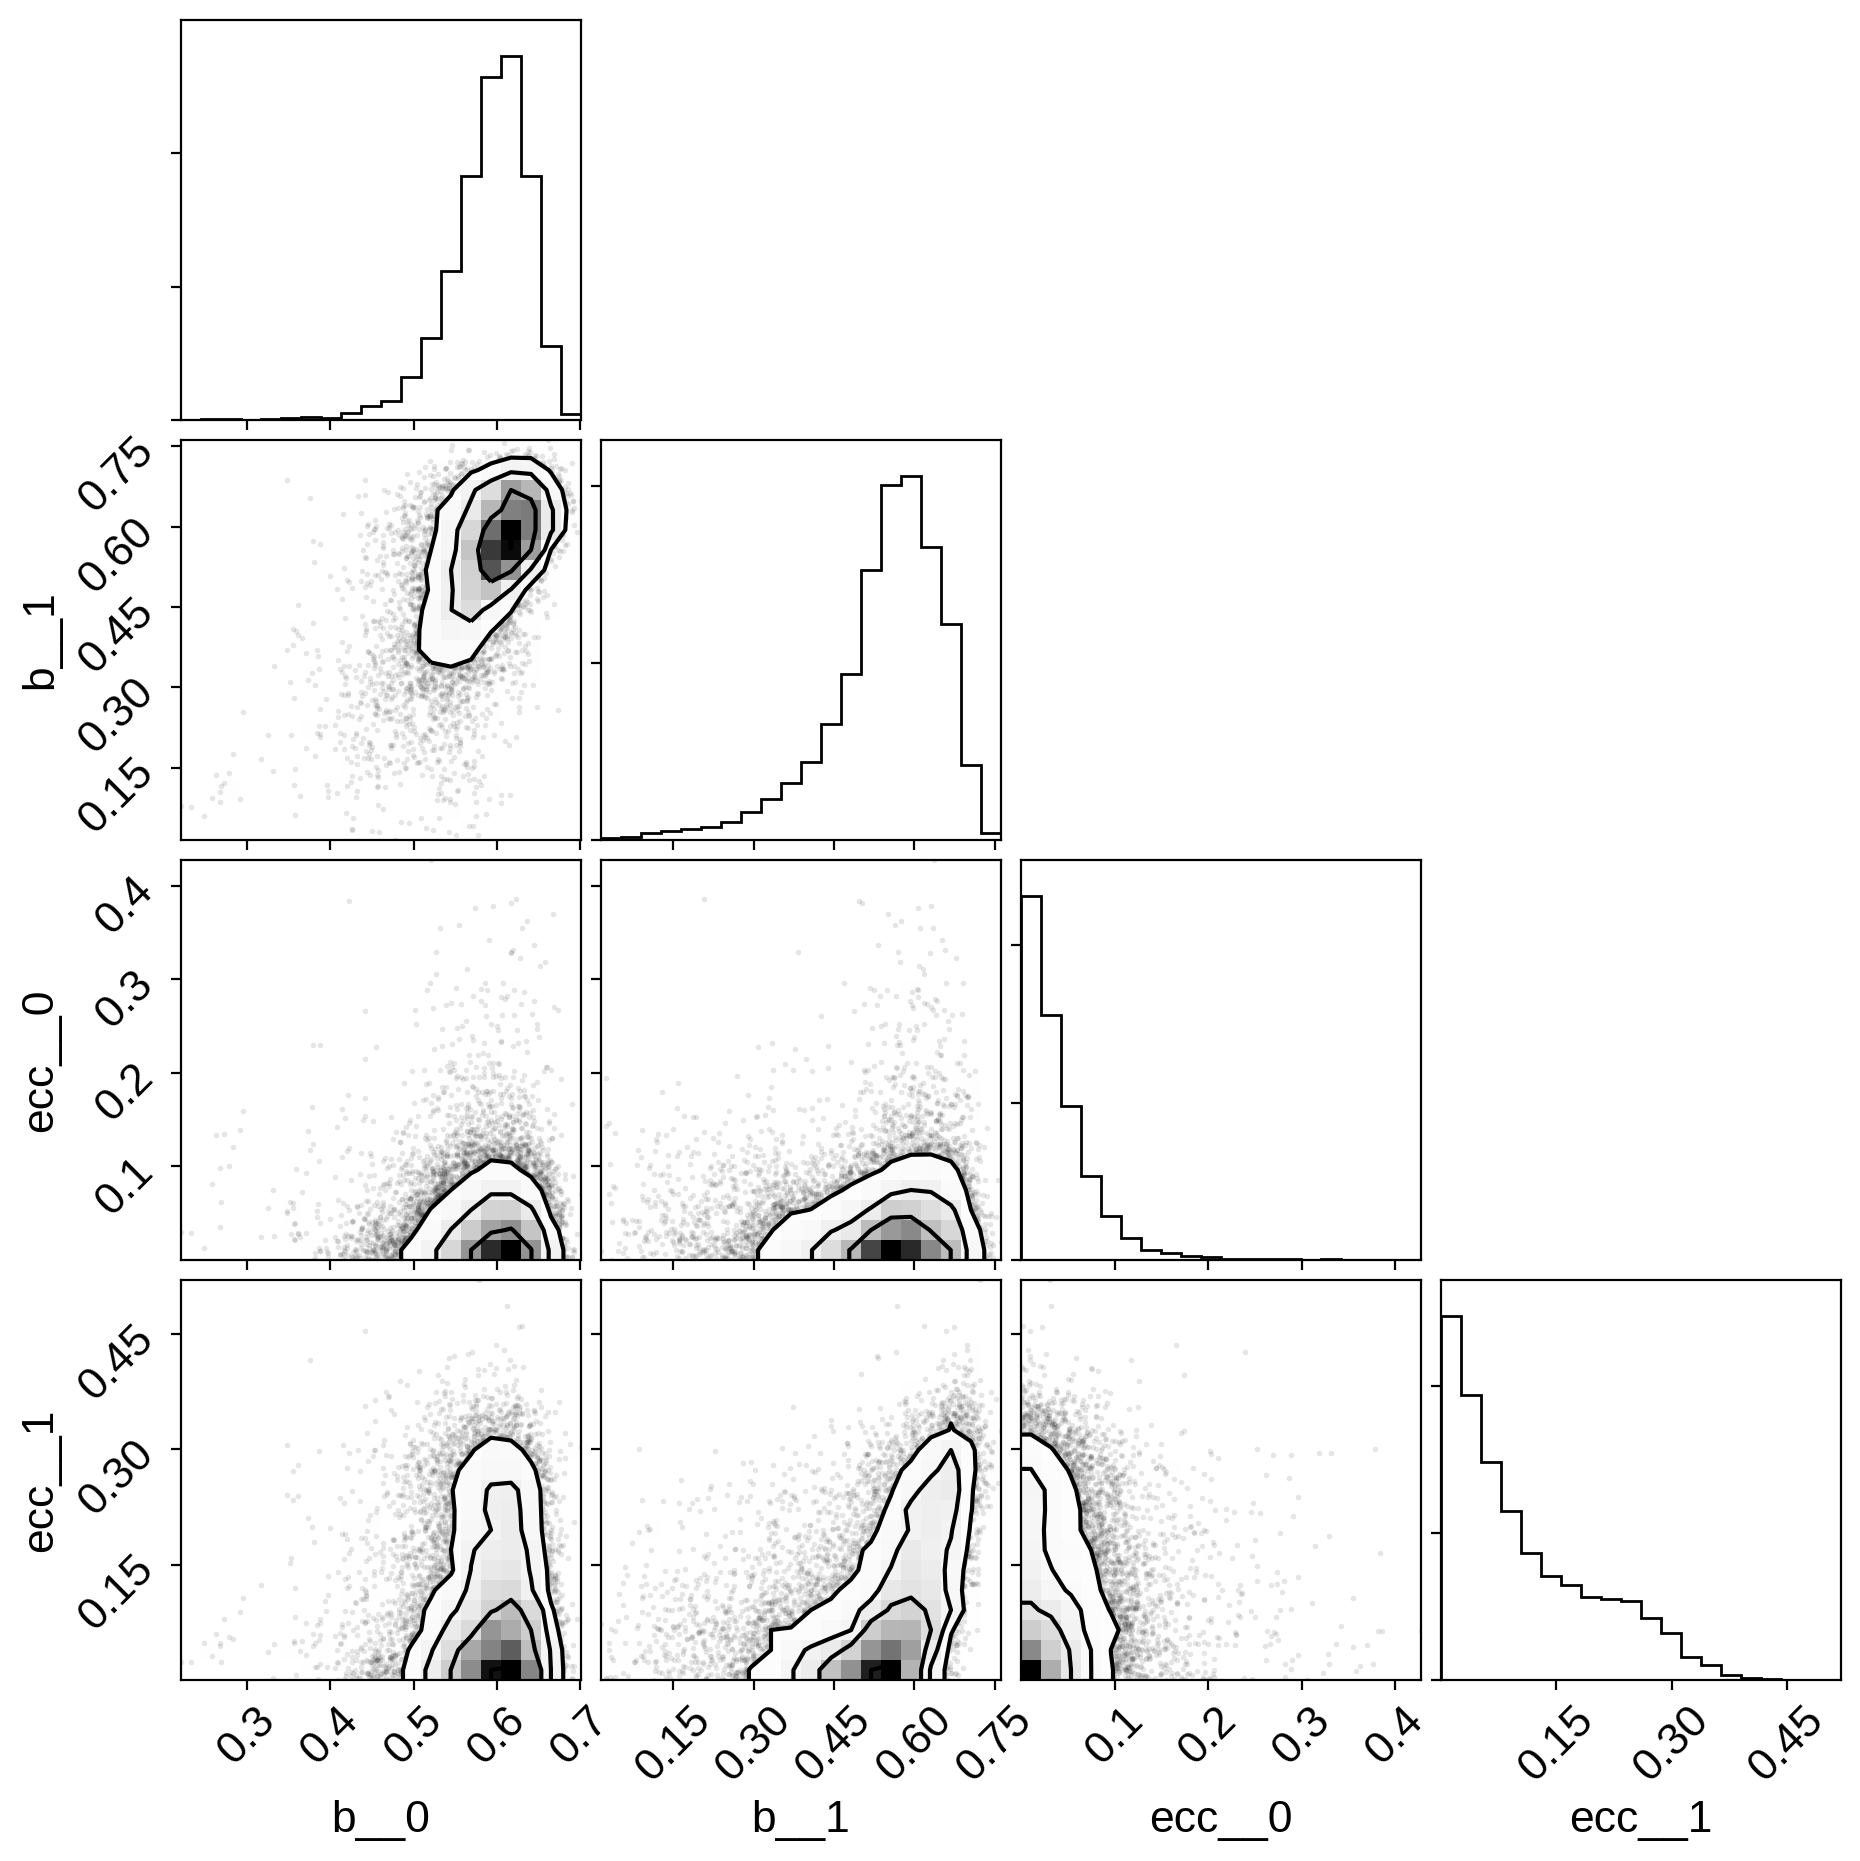

In [16]:
import corner

varnames = ["b", "ecc"]
samples = pm.trace_to_dataframe(trace, varnames=varnames)
fig = corner.corner(samples);

## Phase plots

Finally, as in the :ref:`rv` and :ref:`transit` tutorials, we can make folded plots of the transits and the radial velocities and compare to the posterior model predictions. (Note: planets b and c in this tutorial are swapped compared to the labels from [Petigura et al. (2016)](https://arxiv.org/abs/1511.04497))

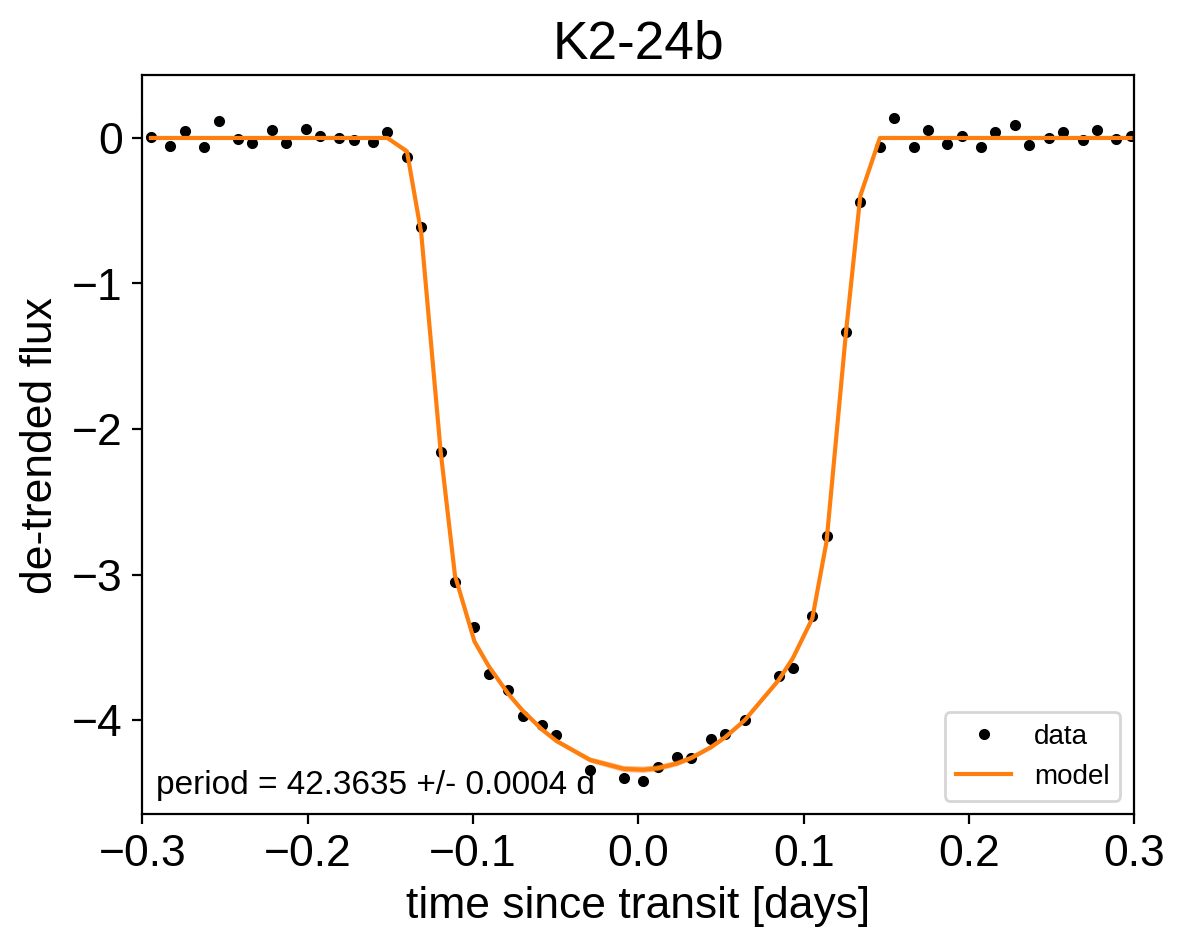

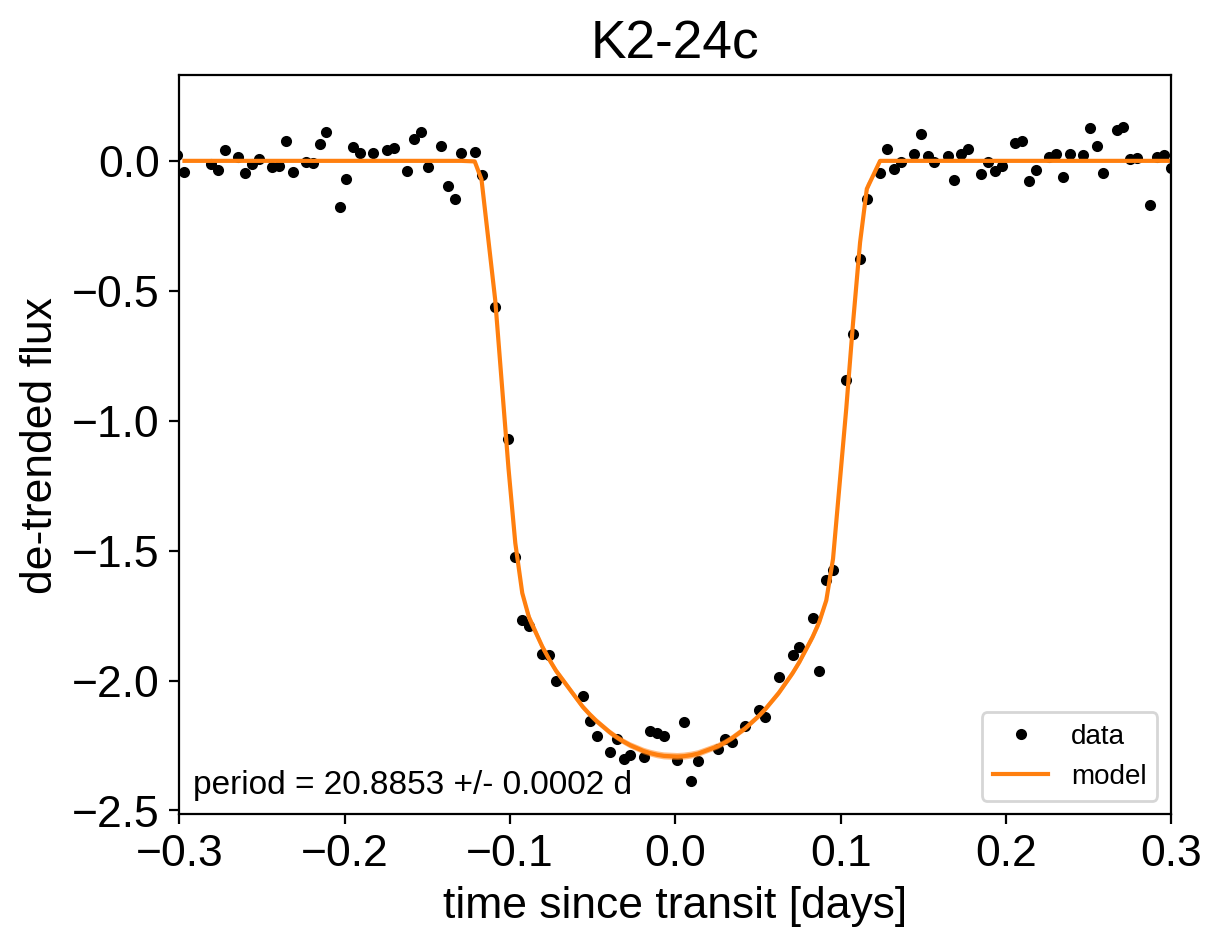

In [17]:
for n, letter in enumerate("bc"):
    plt.figure()

    # Compute the GP prediction
    gp_mod = np.median(trace["gp_pred"] + trace["mean"][:, None], axis=0)

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])

    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    other = np.median(trace["light_curves"][:, :, (n + 1) % 2], axis=0)

    # Plot the folded data
    x_fold = (x[mask] - t0 + 0.5 * p) % p - 0.5 * p
    plt.plot(x_fold, y[mask] - gp_mod - other, ".k", label="data", zorder=-1000)

    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = trace["light_curves"][:, inds, n]
    pred = np.percentile(pred, [16, 50, 84], axis=0)
    plt.plot(x_fold[inds], pred[1], color="C1", label="model")
    art = plt.fill_between(
        x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5, zorder=1000
    )
    art.set_edgecolor("none")

    # Annotate the plot with the planet's period
    txt = "period = {0:.4f} +/- {1:.4f} d".format(
        np.mean(trace["period"][:, n]), np.std(trace["period"][:, n])
    )
    plt.annotate(
        txt,
        (0, 0),
        xycoords="axes fraction",
        xytext=(5, 5),
        textcoords="offset points",
        ha="left",
        va="bottom",
        fontsize=12,
    )

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5 * p, 0.5 * p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("de-trended flux")
    plt.title("K2-24{0}".format(letter))
    plt.xlim(-0.3, 0.3)

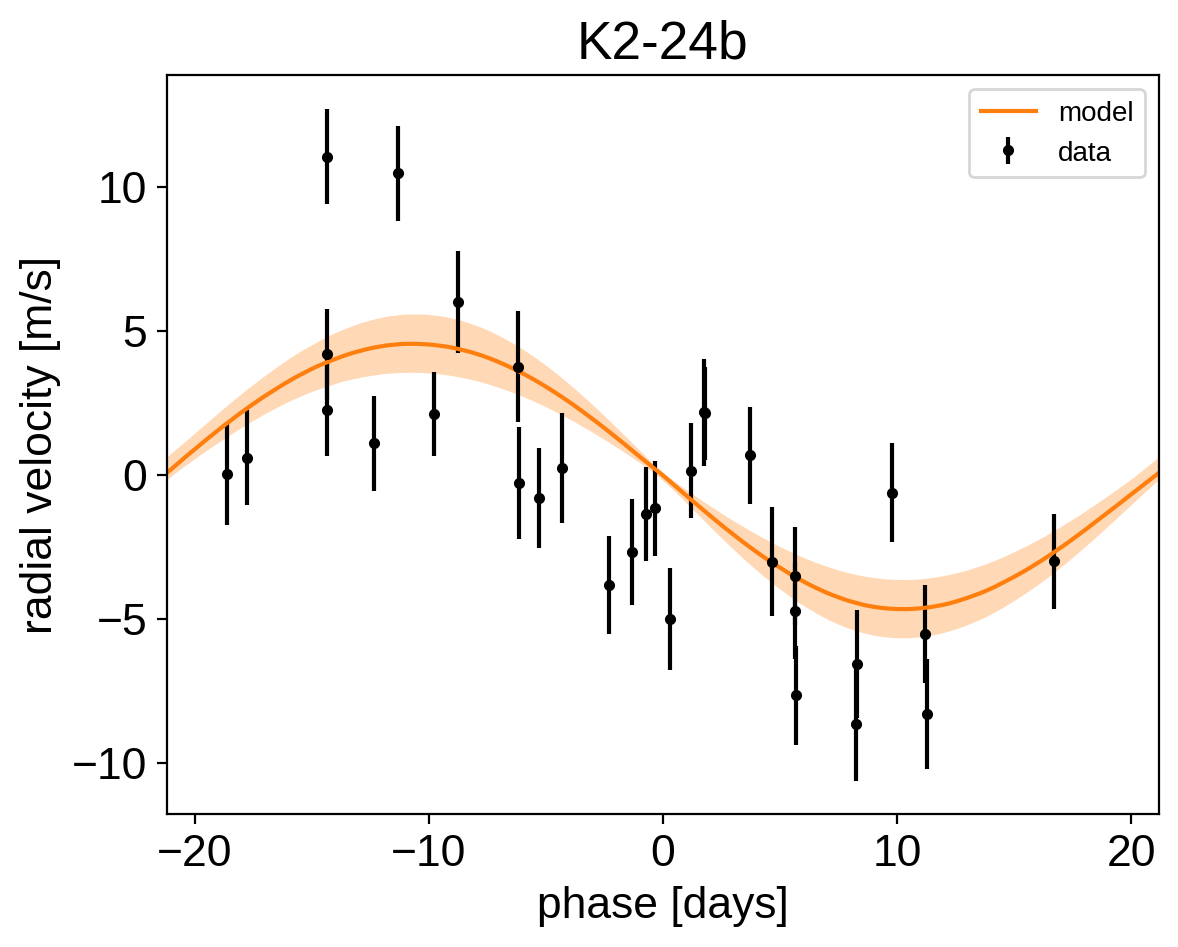

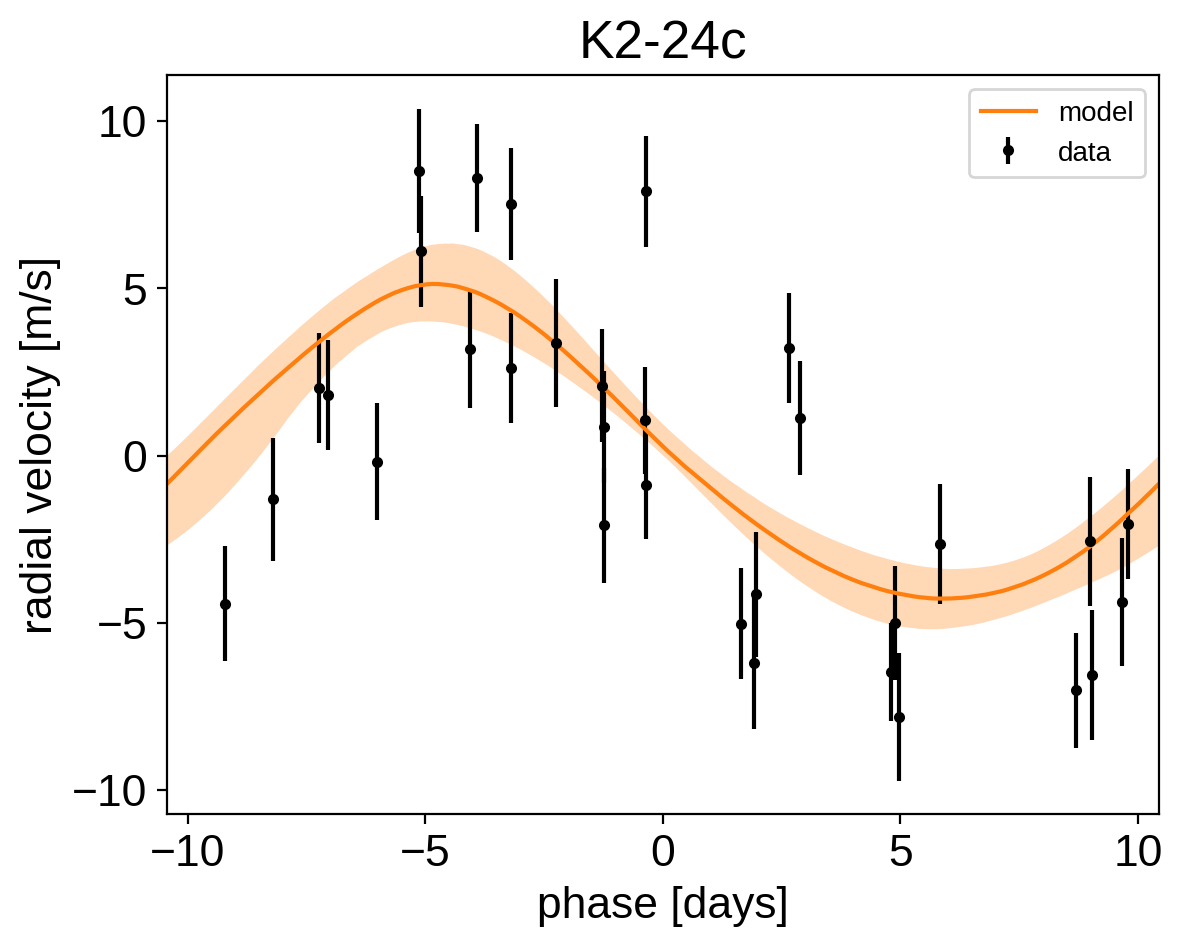

In [18]:
for n, letter in enumerate("bc"):
    plt.figure()

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])

    # Compute the median of posterior estimate of the background RV
    # and the contribution from the other planet. Then we can remove
    # this from the data to plot just the planet we care about.
    other = np.median(trace["vrad"][:, :, (n + 1) % 2], axis=0)
    other += np.median(trace["bkg"], axis=0)

    # Plot the folded data
    x_fold = (x_rv - t0 + 0.5 * p) % p - 0.5 * p
    plt.errorbar(x_fold, y_rv - other, yerr=yerr_rv, fmt=".k", label="data")

    # Compute the posterior prediction for the folded RV model for this
    # planet
    t_fold = (t_rv - t0 + 0.5 * p) % p - 0.5 * p
    inds = np.argsort(t_fold)
    pred = np.percentile(trace["vrad_pred"][:, inds, n], [16, 50, 84], axis=0)
    plt.plot(t_fold[inds], pred[1], color="C1", label="model")
    art = plt.fill_between(t_fold[inds], pred[0], pred[2], color="C1", alpha=0.3)
    art.set_edgecolor("none")

    plt.legend(fontsize=10)
    plt.xlim(-0.5 * p, 0.5 * p)
    plt.xlabel("phase [days]")
    plt.ylabel("radial velocity [m/s]")
    plt.title("K2-24{0}".format(letter));

We can also compute the posterior constraints on the planet densities.

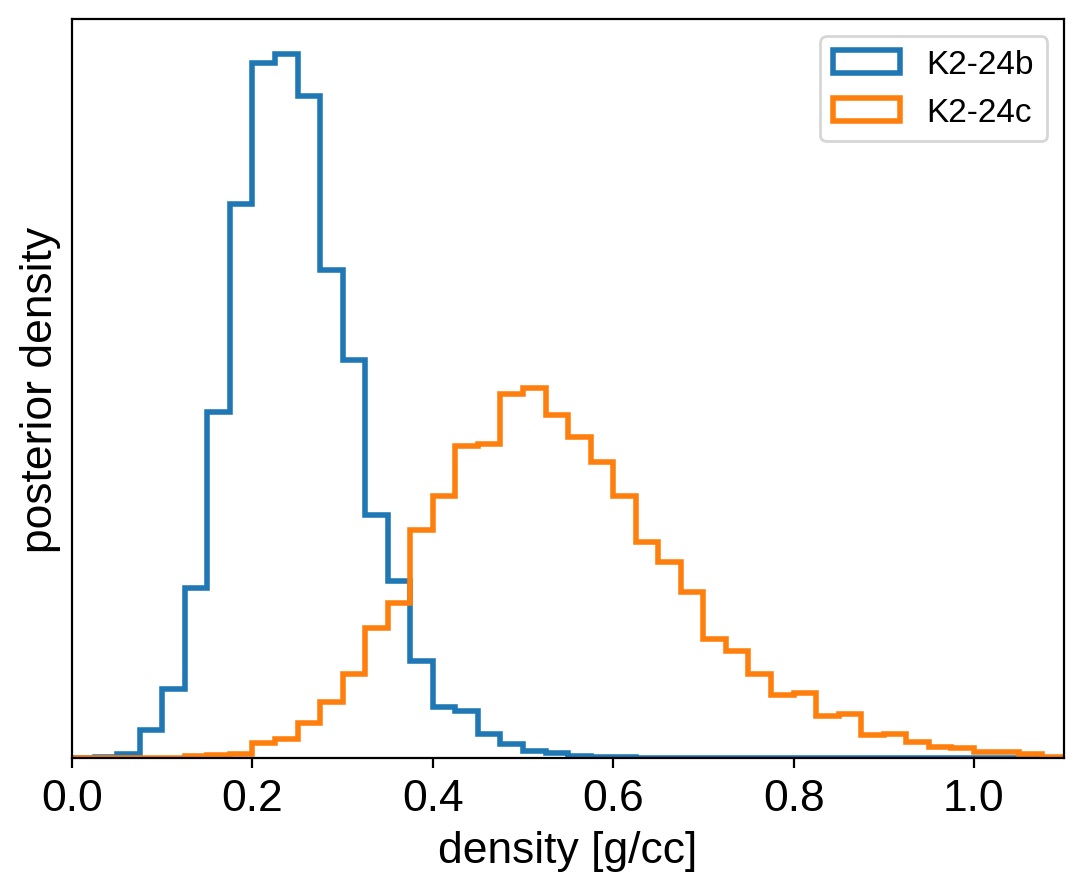

In [19]:
volume = 4 / 3 * np.pi * trace["r_pl"] ** 3
density = u.Quantity(trace["m_pl"] / volume, unit=u.M_earth / u.R_sun ** 3)
density = density.to(u.g / u.cm ** 3).value

bins = np.linspace(0, 1.1, 45)
for n, letter in enumerate("bc"):
    plt.hist(
        density[:, n],
        bins,
        histtype="step",
        lw=2,
        label="K2-24{0}".format(letter),
        density=True,
    )
plt.yticks([])
plt.legend(fontsize=12)
plt.xlim(bins[0], bins[-1])
plt.xlabel("density [g/cc]")
plt.ylabel("posterior density");

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.

In [20]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:agol19, exoplanet:astropy13, exoplanet:astropy18,
exoplanet:exoplanet, exoplanet:foremanmackey17, exoplanet:foremanmackey18,
exoplanet:kipping13, exoplanet:luger18, exoplanet:pymc3, exoplanet:theano,
exoplanet:vaneylen19}.


In [21]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
  author = {Daniel Foreman-Mackey and Ian Czekala and Rodrigo Luger and
            Eric Agol and Geert Barentsen and Tom Barclay},
   title = {exoplanet-dev/exoplanet v0.3.0},
   month = apr,
    year = 2020,
     doi = {10.5281/zenodo.1998447},
     url = {https://doi.org/10.5281/zenodo.1998447}
}
...
